# TESS Atlas fit for TOI 495

**Version: 0.1.0**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 495.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.0/toi-495.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.0/toi-495.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.0/toi-495.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 495

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 495 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

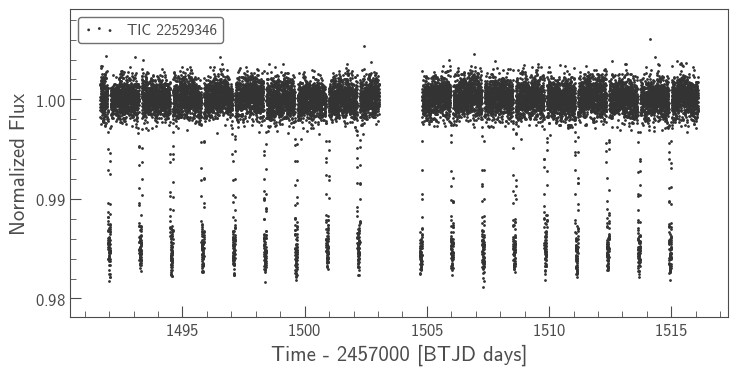

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all()
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")

# tpf_collection[0].to_lightcurve(aperture_mask="pipeline").plot()
# assert 0
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])    
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
lc = lc.remove_outliers()
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] *= 1000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Optimization terminated successfully.
logp: -47271.77418372623 -> -47255.27748357665


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -37197.580066012764 -> -34845.75173746155


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -34845.75173746155 -> -31130.674460974336


optimizing logp for variables: ['logg_star']


message: Desired error not necessarily achieved due to precision loss.
logp: -31130.674460974336 -> -29158.581193693568


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -29158.581193693568 -> -29095.559790790554


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -29095.559790790554 -> -29045.543230274052


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -29045.543230274052 -> -27356.96767794257


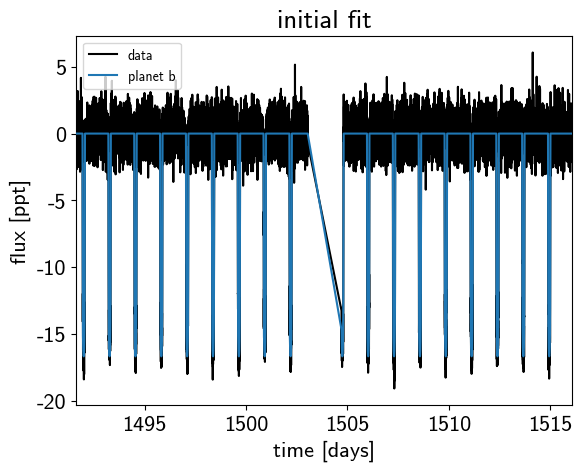

In [7]:
model = build_model(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:03, 24.48draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:00<00:14,  6.28draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:14,  6.25draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:01<00:26,  3.43draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:25,  3.42draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:02<00:24,  3.46draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:02<00:20,  4.21draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:03<00:25,  3.35draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:03<00:22,  3.74draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:03<00:24,  3.29draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:23,  3.48draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:04<00:23,  3.36draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:04<00:23,  3.36draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:05<00:23,  3.35draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:05<00:20,  3.70draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:06<00:20,  3.63draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:06<00:16,  4.32draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:06<00:20,  3.48draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:07<00:19,  3.57draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:07<00:17,  3.94draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:07<00:14,  4.61draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:07<00:20,  3.30draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:08<00:18,  3.59draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:08<00:14,  4.50draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:08<00:18,  3.47draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:08<00:15,  3.94draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:09<00:11,  5.14draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:09<00:08,  6.51draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:09<00:07,  7.59draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:10<00:10,  5.12draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:10<00:12,  4.16draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:10<00:15,  3.37draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:11<00:15,  3.17draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:11<00:17,  2.84draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:11<00:15,  3.18draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:12<00:18,  2.49draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:13<00:16,  2.67draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:13<00:14,  3.04draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:13<00:15,  2.73draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:14<00:14,  2.96draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:14<00:15,  2.62draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:14<00:13,  3.06draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:15<00:14,  2.78draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:15<00:11,  3.18draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:15<00:09,  3.84draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:16<00:11,  3.09draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:16<00:08,  3.79draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:16<00:06,  4.65draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:16<00:06,  4.42draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:17<00:07,  3.89draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:17<00:07,  3.85draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:17<00:06,  4.14draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:17<00:05,  4.85draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:18<00:03,  6.27draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:18<00:02,  7.16draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:18<00:03,  6.22draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:18<00:02,  7.74draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:19<00:03,  4.05draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:20<00:04,  2.93draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:21<00:03,  3.05draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:21<00:04,  2.44draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:22<00:04,  2.08draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:22<00:04,  1.91draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:23<00:03,  1.82draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:24<00:03,  1.75draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:24<00:02,  1.75draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:25<00:02,  1.72draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:25<00:01,  1.72draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:26<00:01,  1.75draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:27<00:00,  1.72draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:29<00:00,  1.10s/draws]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:00, 93.89draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:00<00:07, 12.51draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:01<00:08,  9.95draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:01<00:07, 10.89draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:01<00:10,  7.95draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:02<00:10,  7.49draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:02<00:11,  6.79draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:03<00:14,  5.33draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:03<00:17,  4.38draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:04<00:15,  4.52draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:05<00:17,  3.91draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:05<00:18,  3.70draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:06<00:16,  3.94draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:06<00:17,  3.69draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:07<00:14,  4.04draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:07<00:12,  4.67draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:08<00:14,  4.04draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:08<00:13,  4.08draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:08<00:15,  3.58draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:08<00:14,  3.76draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:09<00:15,  3.34draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:09<00:14,  3.59draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:09<00:16,  3.09draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:10<00:12,  3.79draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:10<00:14,  3.26draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:10<00:14,  3.31draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:11<00:13,  3.30draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:11<00:11,  3.85draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:11<00:11,  3.69draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:12<00:11,  3.71draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:12<00:11,  3.45draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:12<00:10,  3.65draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:12<00:11,  3.34draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:13<00:10,  3.73draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:13<00:11,  3.31draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:14<00:10,  3.32draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:14<00:09,  3.32draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:15<00:09,  3.30draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:15<00:06,  4.39draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:15<00:08,  3.30draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:16<00:08,  3.18draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:16<00:07,  3.51draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:17<00:09,  2.74draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:17<00:06,  3.35draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:17<00:04,  4.08draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:18<00:05,  3.20draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:18<00:04,  3.84draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:18<00:03,  4.18draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:19<00:03,  3.99draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:19<00:03,  3.80draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:19<00:02,  4.27draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:20<00:03,  3.48draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:20<00:02,  4.01draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:20<00:02,  3.45draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:20<00:02,  3.96draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:21<00:02,  3.38draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:21<00:01,  3.95draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:21<00:01,  3.18draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:22<00:01,  2.63draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:22<00:00,  3.32draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:22<00:00,  2.71draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:24<00:00,  2.39draws/s]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:00<00:01, 144.39draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:00<00:01, 118.79draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:00<00:01, 102.26draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:00<00:02, 55.07draws/s] 

Sampling 2 chains:  24%|██▎       | 48/204 [00:00<00:03, 46.67draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:00<00:03, 45.17draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:01<00:03, 41.04draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:01<00:03, 42.75draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:01<00:04, 29.73draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:01<00:05, 24.94draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:01<00:04, 28.02draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:01<00:04, 25.14draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:02<00:04, 26.02draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:02<00:04, 29.06draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:02<00:04, 27.15draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:02<00:04, 26.76draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [00:02<00:03, 28.98draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:02<00:02, 34.19draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:02<00:02, 40.25draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:02<00:02, 41.87draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:03<00:02, 39.72draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:03<00:01, 46.61draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:03<00:01, 48.06draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:03<00:01, 44.97draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [00:03<00:01, 47.27draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:03<00:01, 41.48draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [00:03<00:01, 41.58draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [00:03<00:00, 42.73draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [00:04<00:00, 41.49draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [00:04<00:00, 45.01draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [00:04<00:00, 36.72draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [00:04<00:00, 27.31draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [00:04<00:00, 25.73draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [00:04<00:00, 27.98draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [00:05<00:00, 31.90draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [00:05<00:00, 35.57draws/s]

The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   3%|▎         | 11/404 [00:00<00:03, 99.91draws/s]

Sampling 2 chains:   4%|▍         | 17/404 [00:00<00:04, 81.52draws/s]

Sampling 2 chains:   6%|▌         | 25/404 [00:00<00:04, 76.40draws/s]

Sampling 2 chains:   8%|▊         | 33/404 [00:00<00:04, 76.16draws/s]

Sampling 2 chains:  10%|▉         | 39/404 [00:00<00:05, 65.29draws/s]

Sampling 2 chains:  12%|█▏        | 47/404 [00:00<00:05, 66.06draws/s]

Sampling 2 chains:  13%|█▎        | 53/404 [00:00<00:06, 55.69draws/s]

Sampling 2 chains:  15%|█▍        | 59/404 [00:00<00:06, 55.71draws/s]

Sampling 2 chains:  16%|█▌        | 65/404 [00:01<00:07, 47.56draws/s]

Sampling 2 chains:  17%|█▋        | 70/404 [00:01<00:07, 45.57draws/s]

Sampling 2 chains:  19%|█▉        | 76/404 [00:01<00:06, 47.30draws/s]

Sampling 2 chains:  21%|██        | 83/404 [00:01<00:06, 50.62draws/s]

Sampling 2 chains:  22%|██▏       | 89/404 [00:01<00:07, 43.87draws/s]

Sampling 2 chains:  23%|██▎       | 94/404 [00:01<00:08, 37.76draws/s]

Sampling 2 chains:  25%|██▍       | 99/404 [00:02<00:09, 30.88draws/s]

Sampling 2 chains:  25%|██▌       | 103/404 [00:02<00:09, 33.08draws/s]

Sampling 2 chains:  27%|██▋       | 109/404 [00:02<00:07, 37.44draws/s]

Sampling 2 chains:  28%|██▊       | 114/404 [00:02<00:07, 39.57draws/s]

Sampling 2 chains:  29%|██▉       | 119/404 [00:02<00:06, 40.99draws/s]

Sampling 2 chains:  31%|███       | 124/404 [00:02<00:06, 42.19draws/s]

Sampling 2 chains:  32%|███▏      | 129/404 [00:02<00:06, 40.55draws/s]

Sampling 2 chains:  33%|███▎      | 134/404 [00:02<00:06, 41.81draws/s]

Sampling 2 chains:  34%|███▍      | 139/404 [00:02<00:06, 39.01draws/s]

Sampling 2 chains:  36%|███▌      | 144/404 [00:03<00:08, 32.12draws/s]

Sampling 2 chains:  37%|███▋      | 151/404 [00:03<00:06, 37.71draws/s]

Sampling 2 chains:  39%|███▊      | 156/404 [00:03<00:07, 35.05draws/s]

Sampling 2 chains:  40%|███▉      | 160/404 [00:03<00:07, 32.44draws/s]

Sampling 2 chains:  41%|████      | 164/404 [00:03<00:07, 33.10draws/s]

Sampling 2 chains:  42%|████▏     | 170/404 [00:03<00:06, 37.98draws/s]

Sampling 2 chains:  43%|████▎     | 175/404 [00:04<00:06, 32.76draws/s]

Sampling 2 chains:  44%|████▍     | 179/404 [00:04<00:06, 33.55draws/s]

Sampling 2 chains:  45%|████▌     | 183/404 [00:04<00:07, 29.68draws/s]

Sampling 2 chains:  46%|████▋     | 187/404 [00:04<00:07, 28.21draws/s]

Sampling 2 chains:  47%|████▋     | 191/404 [00:04<00:07, 27.83draws/s]

Sampling 2 chains:  48%|████▊     | 195/404 [00:04<00:07, 27.61draws/s]

Sampling 2 chains:  49%|████▉     | 198/404 [00:04<00:08, 24.90draws/s]

Sampling 2 chains:  50%|█████     | 202/404 [00:05<00:07, 27.19draws/s]

Sampling 2 chains:  51%|█████     | 205/404 [00:05<00:07, 27.27draws/s]

Sampling 2 chains:  52%|█████▏    | 211/404 [00:05<00:05, 32.59draws/s]

Sampling 2 chains:  53%|█████▎    | 215/404 [00:05<00:06, 30.23draws/s]

Sampling 2 chains:  55%|█████▍    | 221/404 [00:05<00:05, 33.33draws/s]

Sampling 2 chains:  57%|█████▋    | 229/404 [00:05<00:04, 40.26draws/s]

Sampling 2 chains:  58%|█████▊    | 235/404 [00:05<00:04, 41.53draws/s]

Sampling 2 chains:  60%|█████▉    | 241/404 [00:05<00:03, 44.33draws/s]

Sampling 2 chains:  62%|██████▏   | 250/404 [00:06<00:03, 50.86draws/s]

Sampling 2 chains:  63%|██████▎   | 256/404 [00:06<00:03, 48.89draws/s]

Sampling 2 chains:  65%|██████▌   | 263/404 [00:06<00:02, 53.47draws/s]

Sampling 2 chains:  67%|██████▋   | 269/404 [00:06<00:02, 51.06draws/s]

Sampling 2 chains:  68%|██████▊   | 275/404 [00:06<00:02, 47.64draws/s]

Sampling 2 chains:  70%|██████▉   | 281/404 [00:06<00:03, 33.55draws/s]

Sampling 2 chains:  71%|███████   | 286/404 [00:06<00:03, 34.47draws/s]

Sampling 2 chains:  73%|███████▎  | 293/404 [00:07<00:02, 39.79draws/s]

Sampling 2 chains:  74%|███████▍  | 298/404 [00:07<00:02, 40.79draws/s]

Sampling 2 chains:  75%|███████▌  | 303/404 [00:07<00:02, 35.11draws/s]

Sampling 2 chains:  76%|███████▌  | 307/404 [00:07<00:03, 28.06draws/s]

Sampling 2 chains:  77%|███████▋  | 311/404 [00:07<00:03, 26.82draws/s]

Sampling 2 chains:  78%|███████▊  | 315/404 [00:07<00:03, 25.34draws/s]

Sampling 2 chains:  79%|███████▊  | 318/404 [00:08<00:03, 25.61draws/s]

Sampling 2 chains:  80%|███████▉  | 322/404 [00:08<00:03, 26.98draws/s]

Sampling 2 chains:  81%|████████▏ | 329/404 [00:08<00:02, 32.62draws/s]

Sampling 2 chains:  82%|████████▏ | 333/404 [00:08<00:02, 30.62draws/s]

Sampling 2 chains:  83%|████████▎ | 337/404 [00:08<00:02, 26.10draws/s]

Sampling 2 chains:  84%|████████▍ | 341/404 [00:08<00:02, 26.27draws/s]

Sampling 2 chains:  86%|████████▌ | 346/404 [00:08<00:01, 29.74draws/s]

Sampling 2 chains:  87%|████████▋ | 350/404 [00:09<00:01, 32.19draws/s]

Sampling 2 chains:  89%|████████▊ | 358/404 [00:09<00:01, 37.38draws/s]

Sampling 2 chains:  90%|█████████ | 364/404 [00:09<00:00, 41.67draws/s]

Sampling 2 chains:  92%|█████████▏| 371/404 [00:09<00:00, 47.16draws/s]

Sampling 2 chains:  93%|█████████▎| 377/404 [00:09<00:00, 46.79draws/s]

Sampling 2 chains:  95%|█████████▍| 383/404 [00:09<00:00, 38.34draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [00:10<00:01, 13.39draws/s]

Sampling 2 chains:  97%|█████████▋| 392/404 [00:11<00:01, 11.61draws/s]

Sampling 2 chains:  98%|█████████▊| 395/404 [00:11<00:00, 12.71draws/s]

Sampling 2 chains:  99%|█████████▊| 398/404 [00:11<00:00, 13.91draws/s]

Sampling 2 chains: 100%|█████████▉| 402/404 [00:11<00:00, 16.09draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:11<00:00, 34.34draws/s]

The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 10/804 [00:00<00:08, 95.52draws/s]

Sampling 2 chains:   2%|▏         | 20/804 [00:00<00:08, 94.33draws/s]

Sampling 2 chains:   4%|▎         | 30/804 [00:00<00:08, 90.03draws/s]

Sampling 2 chains:   5%|▍         | 38/804 [00:00<00:09, 83.97draws/s]

Sampling 2 chains:   6%|▌         | 46/804 [00:00<00:09, 80.89draws/s]

Sampling 2 chains:   7%|▋         | 55/804 [00:00<00:09, 79.13draws/s]

Sampling 2 chains:   8%|▊         | 62/804 [00:00<00:11, 62.35draws/s]

Sampling 2 chains:   9%|▊         | 69/804 [00:00<00:12, 56.99draws/s]

Sampling 2 chains:   9%|▉         | 76/804 [00:01<00:12, 59.09draws/s]

Sampling 2 chains:  10%|█         | 84/804 [00:01<00:11, 62.35draws/s]

Sampling 2 chains:  11%|█▏        | 91/804 [00:01<00:12, 59.34draws/s]

Sampling 2 chains:  12%|█▏        | 97/804 [00:01<00:12, 58.15draws/s]

Sampling 2 chains:  13%|█▎        | 103/804 [00:01<00:21, 32.82draws/s]

Sampling 2 chains:  13%|█▎        | 108/804 [00:02<00:25, 27.13draws/s]

Sampling 2 chains:  14%|█▍        | 112/804 [00:02<00:28, 23.97draws/s]

Sampling 2 chains:  15%|█▍        | 118/804 [00:02<00:23, 29.21draws/s]

Sampling 2 chains:  15%|█▌        | 124/804 [00:02<00:19, 34.34draws/s]

Sampling 2 chains:  16%|█▌        | 129/804 [00:02<00:18, 36.37draws/s]

Sampling 2 chains:  17%|█▋        | 135/804 [00:02<00:16, 41.09draws/s]

Sampling 2 chains:  18%|█▊        | 142/804 [00:02<00:14, 46.76draws/s]

Sampling 2 chains:  19%|█▉        | 151/804 [00:02<00:12, 53.87draws/s]

Sampling 2 chains:  20%|█▉        | 158/804 [00:03<00:12, 50.08draws/s]

Sampling 2 chains:  20%|██        | 164/804 [00:03<00:18, 33.81draws/s]

Sampling 2 chains:  21%|██        | 170/804 [00:03<00:18, 34.91draws/s]

Sampling 2 chains:  22%|██▏       | 175/804 [00:03<00:21, 29.02draws/s]

Sampling 2 chains:  22%|██▏       | 180/804 [00:03<00:18, 33.13draws/s]

Sampling 2 chains:  23%|██▎       | 185/804 [00:04<00:18, 33.08draws/s]

Sampling 2 chains:  24%|██▎       | 190/804 [00:04<00:17, 35.23draws/s]

Sampling 2 chains:  24%|██▍       | 194/804 [00:04<00:18, 33.62draws/s]

Sampling 2 chains:  25%|██▍       | 198/804 [00:04<00:19, 30.69draws/s]

Sampling 2 chains:  25%|██▌       | 202/804 [00:04<00:21, 28.56draws/s]

Sampling 2 chains:  26%|██▌       | 207/804 [00:04<00:19, 30.65draws/s]

Sampling 2 chains:  26%|██▋       | 213/804 [00:04<00:17, 34.49draws/s]

Sampling 2 chains:  27%|██▋       | 217/804 [00:04<00:16, 35.05draws/s]

Sampling 2 chains:  28%|██▊       | 222/804 [00:05<00:15, 37.09draws/s]

Sampling 2 chains:  28%|██▊       | 227/804 [00:05<00:15, 37.79draws/s]

Sampling 2 chains:  29%|██▊       | 231/804 [00:05<00:15, 36.91draws/s]

Sampling 2 chains:  29%|██▉       | 236/804 [00:05<00:14, 40.04draws/s]

Sampling 2 chains:  30%|██▉       | 241/804 [00:05<00:14, 39.95draws/s]

Sampling 2 chains:  31%|███       | 246/804 [00:05<00:16, 33.97draws/s]

Sampling 2 chains:  31%|███       | 250/804 [00:05<00:16, 33.16draws/s]

Sampling 2 chains:  32%|███▏      | 254/804 [00:05<00:15, 34.81draws/s]

Sampling 2 chains:  32%|███▏      | 258/804 [00:06<00:18, 29.88draws/s]

Sampling 2 chains:  33%|███▎      | 262/804 [00:06<00:18, 29.15draws/s]

Sampling 2 chains:  33%|███▎      | 266/804 [00:06<00:18, 29.56draws/s]

Sampling 2 chains:  34%|███▎      | 270/804 [00:06<00:19, 27.61draws/s]

Sampling 2 chains:  34%|███▍      | 274/804 [00:06<00:17, 30.29draws/s]

Sampling 2 chains:  35%|███▍      | 278/804 [00:06<00:16, 32.18draws/s]

Sampling 2 chains:  35%|███▌      | 283/804 [00:06<00:14, 34.94draws/s]

Sampling 2 chains:  36%|███▌      | 287/804 [00:07<00:15, 33.60draws/s]

Sampling 2 chains:  36%|███▋      | 292/804 [00:07<00:14, 35.88draws/s]

Sampling 2 chains:  37%|███▋      | 296/804 [00:07<00:14, 34.07draws/s]

Sampling 2 chains:  37%|███▋      | 301/804 [00:07<00:13, 36.49draws/s]

Sampling 2 chains:  38%|███▊      | 308/804 [00:07<00:11, 42.46draws/s]

Sampling 2 chains:  39%|███▉      | 317/804 [00:07<00:09, 49.41draws/s]

Sampling 2 chains:  40%|████      | 323/804 [00:07<00:10, 46.82draws/s]

Sampling 2 chains:  41%|████▏     | 332/804 [00:07<00:08, 54.57draws/s]

Sampling 2 chains:  42%|████▏     | 339/804 [00:08<00:09, 49.53draws/s]

Sampling 2 chains:  43%|████▎     | 347/804 [00:08<00:08, 55.38draws/s]

Sampling 2 chains:  44%|████▍     | 354/804 [00:08<00:07, 58.00draws/s]

Sampling 2 chains:  45%|████▍     | 361/804 [00:08<00:08, 52.48draws/s]

Sampling 2 chains:  46%|████▌     | 367/804 [00:08<00:14, 30.01draws/s]

Sampling 2 chains:  46%|████▋     | 372/804 [00:09<00:23, 18.61draws/s]

Sampling 2 chains:  47%|████▋     | 376/804 [00:09<00:26, 16.06draws/s]

Sampling 2 chains:  47%|████▋     | 379/804 [00:10<00:33, 12.51draws/s]

Sampling 2 chains:  48%|████▊     | 382/804 [00:10<00:37, 11.24draws/s]

Sampling 2 chains:  48%|████▊     | 386/804 [00:10<00:33, 12.40draws/s]

Sampling 2 chains:  49%|████▊     | 390/804 [00:10<00:27, 14.83draws/s]

Sampling 2 chains:  49%|████▉     | 394/804 [00:10<00:23, 17.67draws/s]

Sampling 2 chains:  49%|████▉     | 397/804 [00:11<00:21, 18.98draws/s]

Sampling 2 chains:  50%|████▉     | 401/804 [00:11<00:18, 21.70draws/s]

Sampling 2 chains:  50%|█████     | 404/804 [00:11<00:19, 20.41draws/s]

Sampling 2 chains:  51%|█████     | 407/804 [00:11<00:20, 19.57draws/s]

Sampling 2 chains:  51%|█████     | 410/804 [00:11<00:20, 19.06draws/s]

Sampling 2 chains:  51%|█████▏    | 413/804 [00:11<00:19, 19.92draws/s]

Sampling 2 chains:  52%|█████▏    | 417/804 [00:11<00:17, 22.71draws/s]

Sampling 2 chains:  52%|█████▏    | 422/804 [00:12<00:15, 25.04draws/s]

Sampling 2 chains:  53%|█████▎    | 425/804 [00:12<00:26, 14.14draws/s]

Sampling 2 chains:  53%|█████▎    | 428/804 [00:12<00:25, 14.61draws/s]

Sampling 2 chains:  53%|█████▎    | 430/804 [00:12<00:29, 12.73draws/s]

Sampling 2 chains:  54%|█████▎    | 432/804 [00:13<00:34, 10.70draws/s]

Sampling 2 chains:  54%|█████▍    | 435/804 [00:13<00:28, 12.75draws/s]

Sampling 2 chains:  54%|█████▍    | 437/804 [00:13<00:28, 12.70draws/s]

Sampling 2 chains:  55%|█████▍    | 439/804 [00:13<00:32, 11.38draws/s]

Sampling 2 chains:  55%|█████▍    | 441/804 [00:13<00:29, 12.52draws/s]

Sampling 2 chains:  55%|█████▌    | 446/804 [00:13<00:22, 15.80draws/s]

Sampling 2 chains:  56%|█████▌    | 449/804 [00:14<00:21, 16.33draws/s]

Sampling 2 chains:  56%|█████▌    | 452/804 [00:14<00:19, 17.78draws/s]

Sampling 2 chains:  57%|█████▋    | 455/804 [00:14<00:17, 20.04draws/s]

Sampling 2 chains:  57%|█████▋    | 458/804 [00:14<00:16, 21.39draws/s]

Sampling 2 chains:  57%|█████▋    | 462/804 [00:14<00:14, 24.05draws/s]

Sampling 2 chains:  58%|█████▊    | 467/804 [00:14<00:12, 27.58draws/s]

Sampling 2 chains:  59%|█████▊    | 471/804 [00:14<00:11, 29.95draws/s]

Sampling 2 chains:  59%|█████▉    | 477/804 [00:14<00:09, 32.73draws/s]

Sampling 2 chains:  60%|█████▉    | 481/804 [00:15<00:12, 25.89draws/s]

Sampling 2 chains:  60%|██████    | 485/804 [00:15<00:11, 28.08draws/s]

Sampling 2 chains:  61%|██████    | 489/804 [00:15<00:13, 23.86draws/s]

Sampling 2 chains:  61%|██████    | 492/804 [00:15<00:16, 19.29draws/s]

Sampling 2 chains:  62%|██████▏   | 495/804 [00:15<00:14, 21.60draws/s]

Sampling 2 chains:  62%|██████▏   | 498/804 [00:15<00:13, 22.00draws/s]

Sampling 2 chains:  62%|██████▏   | 501/804 [00:16<00:12, 23.82draws/s]

Sampling 2 chains:  63%|██████▎   | 505/804 [00:16<00:12, 23.46draws/s]

Sampling 2 chains:  63%|██████▎   | 508/804 [00:16<00:13, 22.33draws/s]

Sampling 2 chains:  64%|██████▍   | 513/804 [00:16<00:11, 25.86draws/s]

Sampling 2 chains:  64%|██████▍   | 518/804 [00:16<00:10, 27.00draws/s]

Sampling 2 chains:  65%|██████▍   | 521/804 [00:16<00:10, 27.22draws/s]

Sampling 2 chains:  65%|██████▌   | 524/804 [00:16<00:12, 22.41draws/s]

Sampling 2 chains:  66%|██████▌   | 528/804 [00:17<00:11, 24.73draws/s]

Sampling 2 chains:  66%|██████▌   | 531/804 [00:17<00:10, 24.86draws/s]

Sampling 2 chains:  66%|██████▋   | 534/804 [00:17<00:14, 18.99draws/s]

Sampling 2 chains:  67%|██████▋   | 538/804 [00:17<00:11, 22.54draws/s]

Sampling 2 chains:  67%|██████▋   | 541/804 [00:17<00:14, 18.73draws/s]

Sampling 2 chains:  68%|██████▊   | 544/804 [00:17<00:13, 19.74draws/s]

Sampling 2 chains:  68%|██████▊   | 547/804 [00:18<00:13, 19.65draws/s]

Sampling 2 chains:  68%|██████▊   | 550/804 [00:18<00:12, 20.90draws/s]

Sampling 2 chains:  69%|██████▉   | 553/804 [00:18<00:11, 22.39draws/s]

Sampling 2 chains:  69%|██████▉   | 557/804 [00:18<00:09, 24.77draws/s]

Sampling 2 chains:  70%|██████▉   | 560/804 [00:18<00:09, 25.63draws/s]

Sampling 2 chains:  70%|███████   | 563/804 [00:18<00:09, 25.03draws/s]

Sampling 2 chains:  71%|███████   | 568/804 [00:18<00:08, 29.01draws/s]

Sampling 2 chains:  71%|███████   | 572/804 [00:18<00:09, 23.56draws/s]

Sampling 2 chains:  72%|███████▏  | 575/804 [00:19<00:09, 24.27draws/s]

Sampling 2 chains:  72%|███████▏  | 578/804 [00:19<00:08, 25.16draws/s]

Sampling 2 chains:  72%|███████▏  | 581/804 [00:19<00:08, 24.78draws/s]

Sampling 2 chains:  73%|███████▎  | 584/804 [00:19<00:09, 24.26draws/s]

Sampling 2 chains:  73%|███████▎  | 587/804 [00:19<00:10, 20.26draws/s]

Sampling 2 chains:  73%|███████▎  | 590/804 [00:19<00:12, 17.36draws/s]

Sampling 2 chains:  74%|███████▍  | 595/804 [00:20<00:09, 21.17draws/s]

Sampling 2 chains:  74%|███████▍  | 598/804 [00:20<00:10, 19.66draws/s]

Sampling 2 chains:  75%|███████▍  | 601/804 [00:20<00:15, 13.34draws/s]

Sampling 2 chains:  75%|███████▌  | 603/804 [00:20<00:17, 11.26draws/s]

Sampling 2 chains:  75%|███████▌  | 605/804 [00:20<00:17, 11.31draws/s]

Sampling 2 chains:  75%|███████▌  | 607/804 [00:21<00:16, 12.01draws/s]

Sampling 2 chains:  76%|███████▌  | 609/804 [00:21<00:14, 13.49draws/s]

Sampling 2 chains:  76%|███████▌  | 613/804 [00:21<00:11, 16.21draws/s]

Sampling 2 chains:  77%|███████▋  | 617/804 [00:21<00:10, 18.43draws/s]

Sampling 2 chains:  77%|███████▋  | 622/804 [00:21<00:08, 21.85draws/s]

Sampling 2 chains:  78%|███████▊  | 628/804 [00:21<00:06, 26.76draws/s]

Sampling 2 chains:  79%|███████▊  | 633/804 [00:22<00:07, 21.47draws/s]

Sampling 2 chains:  79%|███████▉  | 636/804 [00:22<00:09, 17.08draws/s]

Sampling 2 chains:  79%|███████▉  | 639/804 [00:23<00:18,  8.94draws/s]

Sampling 2 chains:  80%|███████▉  | 641/804 [00:23<00:22,  7.30draws/s]

Sampling 2 chains:  80%|███████▉  | 643/804 [00:24<00:43,  3.73draws/s]

Sampling 2 chains:  80%|████████  | 645/804 [00:25<00:49,  3.20draws/s]

Sampling 2 chains:  80%|████████  | 646/804 [00:26<01:12,  2.18draws/s]

Sampling 2 chains:  80%|████████  | 647/804 [00:26<00:59,  2.66draws/s]

Sampling 2 chains:  81%|████████  | 648/804 [00:26<00:53,  2.89draws/s]

Sampling 2 chains:  81%|████████  | 649/804 [00:27<01:01,  2.52draws/s]

Sampling 2 chains:  81%|████████  | 650/804 [00:27<00:49,  3.11draws/s]

Sampling 2 chains:  81%|████████  | 651/804 [00:28<01:05,  2.35draws/s]

Sampling 2 chains:  81%|████████  | 652/804 [00:28<01:11,  2.12draws/s]

Sampling 2 chains:  81%|████████  | 653/804 [00:29<01:15,  2.00draws/s]

Sampling 2 chains:  81%|████████▏ | 654/804 [00:29<01:01,  2.44draws/s]

Sampling 2 chains:  81%|████████▏ | 655/804 [00:29<01:01,  2.43draws/s]

Sampling 2 chains:  82%|████████▏ | 656/804 [00:30<00:56,  2.64draws/s]

Sampling 2 chains:  82%|████████▏ | 657/804 [00:30<00:57,  2.56draws/s]

Sampling 2 chains:  82%|████████▏ | 658/804 [00:30<00:52,  2.79draws/s]

Sampling 2 chains:  82%|████████▏ | 659/804 [00:31<00:50,  2.85draws/s]

Sampling 2 chains:  82%|████████▏ | 660/804 [00:31<00:40,  3.51draws/s]

Sampling 2 chains:  82%|████████▏ | 661/804 [00:31<00:35,  4.00draws/s]

Sampling 2 chains:  82%|████████▏ | 662/804 [00:31<00:31,  4.52draws/s]

Sampling 2 chains:  82%|████████▏ | 663/804 [00:31<00:28,  4.96draws/s]

Sampling 2 chains:  83%|████████▎ | 664/804 [00:31<00:27,  5.14draws/s]

Sampling 2 chains:  83%|████████▎ | 665/804 [00:32<00:24,  5.59draws/s]

Sampling 2 chains:  83%|████████▎ | 666/804 [00:32<00:23,  5.89draws/s]

Sampling 2 chains:  83%|████████▎ | 667/804 [00:32<00:21,  6.26draws/s]

Sampling 2 chains:  83%|████████▎ | 671/804 [00:32<00:16,  8.05draws/s]

Sampling 2 chains:  84%|████████▍ | 675/804 [00:32<00:12, 10.13draws/s]

Sampling 2 chains:  84%|████████▍ | 679/804 [00:32<00:09, 12.82draws/s]

Sampling 2 chains:  85%|████████▍ | 683/804 [00:32<00:07, 15.70draws/s]

Sampling 2 chains:  85%|████████▌ | 687/804 [00:33<00:06, 17.20draws/s]

Sampling 2 chains:  86%|████████▌ | 690/804 [00:33<00:07, 15.18draws/s]

Sampling 2 chains:  86%|████████▌ | 693/804 [00:33<00:07, 15.84draws/s]

Sampling 2 chains:  87%|████████▋ | 699/804 [00:33<00:05, 19.99draws/s]

Sampling 2 chains:  88%|████████▊ | 704/804 [00:33<00:04, 22.50draws/s]

Sampling 2 chains:  88%|████████▊ | 707/804 [00:33<00:04, 21.82draws/s]

Sampling 2 chains:  88%|████████▊ | 710/804 [00:34<00:04, 20.96draws/s]

Sampling 2 chains:  89%|████████▊ | 713/804 [00:34<00:04, 22.27draws/s]

Sampling 2 chains:  89%|████████▉ | 716/804 [00:34<00:03, 22.19draws/s]

Sampling 2 chains:  90%|████████▉ | 721/804 [00:34<00:03, 25.34draws/s]

Sampling 2 chains:  90%|█████████ | 724/804 [00:34<00:03, 22.57draws/s]

Sampling 2 chains:  90%|█████████ | 727/804 [00:34<00:03, 21.30draws/s]

Sampling 2 chains:  91%|█████████ | 730/804 [00:34<00:03, 22.55draws/s]

Sampling 2 chains:  91%|█████████ | 733/804 [00:35<00:02, 24.13draws/s]

Sampling 2 chains:  92%|█████████▏| 738/804 [00:35<00:02, 28.47draws/s]

Sampling 2 chains:  93%|█████████▎| 744/804 [00:35<00:01, 33.53draws/s]

Sampling 2 chains:  93%|█████████▎| 749/804 [00:39<00:14,  3.81draws/s]

Sampling 2 chains:  94%|█████████▎| 752/804 [00:40<00:14,  3.69draws/s]

Sampling 2 chains:  94%|█████████▍| 755/804 [00:41<00:13,  3.52draws/s]

Sampling 2 chains:  94%|█████████▍| 757/804 [00:41<00:12,  3.77draws/s]

Sampling 2 chains:  94%|█████████▍| 759/804 [00:42<00:11,  3.78draws/s]

Sampling 2 chains:  95%|█████████▍| 760/804 [00:42<00:09,  4.42draws/s]

Sampling 2 chains:  95%|█████████▍| 761/804 [00:42<00:09,  4.76draws/s]

Sampling 2 chains:  95%|█████████▍| 762/804 [00:42<00:08,  5.03draws/s]

Sampling 2 chains:  95%|█████████▌| 764/804 [00:42<00:06,  5.93draws/s]

Sampling 2 chains:  95%|█████████▌| 766/804 [00:42<00:05,  7.17draws/s]

Sampling 2 chains:  96%|█████████▌| 769/804 [00:42<00:03,  9.05draws/s]

Sampling 2 chains:  96%|█████████▌| 771/804 [00:43<00:03, 10.24draws/s]

Sampling 2 chains:  96%|█████████▋| 774/804 [00:43<00:02, 11.20draws/s]

Sampling 2 chains:  97%|█████████▋| 776/804 [00:43<00:02, 11.11draws/s]

Sampling 2 chains:  97%|█████████▋| 779/804 [00:43<00:01, 12.94draws/s]

Sampling 2 chains:  97%|█████████▋| 782/804 [00:43<00:01, 14.65draws/s]

Sampling 2 chains:  98%|█████████▊| 785/804 [00:43<00:01, 16.96draws/s]

Sampling 2 chains:  98%|█████████▊| 791/804 [00:44<00:00, 18.72draws/s]

Sampling 2 chains:  99%|█████████▉| 794/804 [00:44<00:00, 17.07draws/s]

Sampling 2 chains:  99%|█████████▉| 797/804 [00:44<00:00, 19.35draws/s]

Sampling 2 chains: 100%|█████████▉| 802/804 [00:44<00:00, 22.68draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:44<00:00, 18.02draws/s]

The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 15/4404 [00:00<00:31, 137.35draws/s]

Sampling 2 chains:   1%|          | 23/4404 [00:00<00:38, 112.94draws/s]

Sampling 2 chains:   1%|          | 32/4404 [00:00<00:43, 100.04draws/s]

Sampling 2 chains:   1%|          | 41/4404 [00:00<00:47, 92.52draws/s] 

Sampling 2 chains:   1%|          | 48/4404 [00:00<00:51, 83.99draws/s]

Sampling 2 chains:   1%|▏         | 57/4404 [00:00<00:54, 79.63draws/s]

Sampling 2 chains:   1%|▏         | 66/4404 [00:00<00:53, 81.00draws/s]

Sampling 2 chains:   2%|▏         | 74/4404 [00:00<00:53, 80.43draws/s]

Sampling 2 chains:   2%|▏         | 82/4404 [00:01<01:08, 62.78draws/s]

Sampling 2 chains:   2%|▏         | 89/4404 [00:01<01:15, 56.82draws/s]

Sampling 2 chains:   2%|▏         | 95/4404 [00:01<01:15, 56.81draws/s]

Sampling 2 chains:   2%|▏         | 103/4404 [00:01<01:11, 60.08draws/s]

Sampling 2 chains:   2%|▏         | 110/4404 [00:01<01:16, 56.00draws/s]

Sampling 2 chains:   3%|▎         | 116/4404 [00:01<01:25, 50.40draws/s]

Sampling 2 chains:   3%|▎         | 122/4404 [00:01<01:36, 44.15draws/s]

Sampling 2 chains:   3%|▎         | 130/4404 [00:02<01:26, 49.41draws/s]

Sampling 2 chains:   3%|▎         | 136/4404 [00:02<01:24, 50.38draws/s]

Sampling 2 chains:   3%|▎         | 143/4404 [00:02<01:23, 50.87draws/s]

Sampling 2 chains:   3%|▎         | 149/4404 [00:02<01:41, 41.91draws/s]

Sampling 2 chains:   3%|▎         | 154/4404 [00:02<02:00, 35.33draws/s]

Sampling 2 chains:   4%|▎         | 158/4404 [00:02<02:10, 32.59draws/s]

Sampling 2 chains:   4%|▎         | 163/4404 [00:03<02:24, 29.44draws/s]

Sampling 2 chains:   4%|▍         | 167/4404 [00:03<03:15, 21.63draws/s]

Sampling 2 chains:   4%|▍         | 170/4404 [00:03<03:41, 19.14draws/s]

Sampling 2 chains:   4%|▍         | 174/4404 [00:03<03:06, 22.63draws/s]

Sampling 2 chains:   4%|▍         | 177/4404 [00:03<03:02, 23.20draws/s]

Sampling 2 chains:   4%|▍         | 181/4404 [00:03<02:44, 25.70draws/s]

Sampling 2 chains:   4%|▍         | 184/4404 [00:03<02:38, 26.69draws/s]

Sampling 2 chains:   4%|▍         | 190/4404 [00:04<02:13, 31.66draws/s]

Sampling 2 chains:   4%|▍         | 196/4404 [00:04<01:54, 36.84draws/s]

Sampling 2 chains:   5%|▍         | 201/4404 [00:04<01:57, 35.74draws/s]

Sampling 2 chains:   5%|▍         | 206/4404 [00:04<01:58, 35.33draws/s]

Sampling 2 chains:   5%|▍         | 210/4404 [00:04<01:55, 36.35draws/s]

Sampling 2 chains:   5%|▍         | 215/4404 [00:04<01:49, 38.34draws/s]

Sampling 2 chains:   5%|▍         | 220/4404 [00:04<02:24, 28.89draws/s]

Sampling 2 chains:   5%|▌         | 224/4404 [00:05<02:23, 29.08draws/s]

Sampling 2 chains:   5%|▌         | 228/4404 [00:05<02:22, 29.23draws/s]

Sampling 2 chains:   5%|▌         | 232/4404 [00:05<02:30, 27.72draws/s]

Sampling 2 chains:   5%|▌         | 237/4404 [00:05<02:15, 30.82draws/s]

Sampling 2 chains:   6%|▌         | 243/4404 [00:05<02:01, 34.25draws/s]

Sampling 2 chains:   6%|▌         | 248/4404 [00:05<01:52, 36.89draws/s]

Sampling 2 chains:   6%|▌         | 253/4404 [00:05<01:46, 39.11draws/s]

Sampling 2 chains:   6%|▌         | 259/4404 [00:06<02:24, 28.65draws/s]

Sampling 2 chains:   6%|▌         | 263/4404 [00:07<05:57, 11.58draws/s]

Sampling 2 chains:   6%|▌         | 266/4404 [00:07<06:37, 10.40draws/s]

Sampling 2 chains:   6%|▌         | 269/4404 [00:07<05:46, 11.94draws/s]

Sampling 2 chains:   6%|▌         | 271/4404 [00:07<06:33, 10.50draws/s]

Sampling 2 chains:   6%|▌         | 273/4404 [00:07<06:04, 11.35draws/s]

Sampling 2 chains:   6%|▋         | 277/4404 [00:08<04:56, 13.92draws/s]

Sampling 2 chains:   6%|▋         | 280/4404 [00:08<04:19, 15.86draws/s]

Sampling 2 chains:   6%|▋         | 284/4404 [00:08<03:37, 18.98draws/s]

Sampling 2 chains:   7%|▋         | 289/4404 [00:08<03:02, 22.52draws/s]

Sampling 2 chains:   7%|▋         | 294/4404 [00:08<02:34, 26.59draws/s]

Sampling 2 chains:   7%|▋         | 298/4404 [00:08<02:33, 26.70draws/s]

Sampling 2 chains:   7%|▋         | 303/4404 [00:08<02:38, 25.90draws/s]

Sampling 2 chains:   7%|▋         | 306/4404 [00:09<03:02, 22.49draws/s]

Sampling 2 chains:   7%|▋         | 309/4404 [00:09<02:58, 22.88draws/s]

Sampling 2 chains:   7%|▋         | 313/4404 [00:09<02:37, 25.89draws/s]

Sampling 2 chains:   7%|▋         | 318/4404 [00:09<02:20, 29.02draws/s]

Sampling 2 chains:   7%|▋         | 323/4404 [00:09<02:03, 32.98draws/s]

Sampling 2 chains:   7%|▋         | 329/4404 [00:09<01:54, 35.48draws/s]

Sampling 2 chains:   8%|▊         | 333/4404 [00:09<01:51, 36.51draws/s]

Sampling 2 chains:   8%|▊         | 337/4404 [00:09<02:20, 28.84draws/s]

Sampling 2 chains:   8%|▊         | 341/4404 [00:10<02:31, 26.89draws/s]

Sampling 2 chains:   8%|▊         | 345/4404 [00:10<02:39, 25.51draws/s]

Sampling 2 chains:   8%|▊         | 350/4404 [00:10<02:19, 29.06draws/s]

Sampling 2 chains:   8%|▊         | 354/4404 [00:10<02:11, 30.75draws/s]

Sampling 2 chains:   8%|▊         | 363/4404 [00:10<01:47, 37.43draws/s]

Sampling 2 chains:   8%|▊         | 368/4404 [00:10<02:16, 29.57draws/s]

Sampling 2 chains:   8%|▊         | 374/4404 [00:11<02:01, 33.17draws/s]

Sampling 2 chains:   9%|▊         | 379/4404 [00:11<01:57, 34.28draws/s]

Sampling 2 chains:   9%|▉         | 386/4404 [00:11<01:41, 39.75draws/s]

Sampling 2 chains:   9%|▉         | 391/4404 [00:11<01:44, 38.49draws/s]

Sampling 2 chains:   9%|▉         | 396/4404 [00:11<01:58, 33.69draws/s]

Sampling 2 chains:   9%|▉         | 401/4404 [00:11<01:50, 36.08draws/s]

Sampling 2 chains:   9%|▉         | 405/4404 [00:11<02:07, 31.36draws/s]

Sampling 2 chains:   9%|▉         | 409/4404 [00:12<02:20, 28.36draws/s]

Sampling 2 chains:   9%|▉         | 413/4404 [00:12<02:19, 28.59draws/s]

Sampling 2 chains:   9%|▉         | 417/4404 [00:12<02:44, 24.17draws/s]

Sampling 2 chains:  10%|▉         | 421/4404 [00:12<02:25, 27.37draws/s]

Sampling 2 chains:  10%|▉         | 425/4404 [00:12<02:19, 28.48draws/s]

Sampling 2 chains:  10%|▉         | 429/4404 [00:12<02:36, 25.33draws/s]

Sampling 2 chains:  10%|▉         | 433/4404 [00:12<02:20, 28.18draws/s]

Sampling 2 chains:  10%|▉         | 437/4404 [00:13<02:19, 28.47draws/s]

Sampling 2 chains:  10%|█         | 443/4404 [00:13<02:00, 32.84draws/s]

Sampling 2 chains:  10%|█         | 447/4404 [00:13<02:03, 32.06draws/s]

Sampling 2 chains:  10%|█         | 452/4404 [00:13<02:06, 31.19draws/s]

Sampling 2 chains:  10%|█         | 456/4404 [00:13<02:46, 23.66draws/s]

Sampling 2 chains:  10%|█         | 459/4404 [00:13<03:06, 21.21draws/s]

Sampling 2 chains:  10%|█         | 462/4404 [00:14<02:53, 22.70draws/s]

Sampling 2 chains:  11%|█         | 465/4404 [00:14<02:57, 22.18draws/s]

Sampling 2 chains:  11%|█         | 468/4404 [00:14<03:07, 20.98draws/s]

Sampling 2 chains:  11%|█         | 474/4404 [00:14<02:37, 24.94draws/s]

Sampling 2 chains:  11%|█         | 480/4404 [00:14<02:15, 29.04draws/s]

Sampling 2 chains:  11%|█         | 485/4404 [00:14<02:02, 32.10draws/s]

Sampling 2 chains:  11%|█         | 490/4404 [00:14<01:48, 35.92draws/s]

Sampling 2 chains:  11%|█         | 495/4404 [00:15<01:53, 34.38draws/s]

Sampling 2 chains:  11%|█▏        | 501/4404 [00:15<01:39, 39.09draws/s]

Sampling 2 chains:  11%|█▏        | 506/4404 [00:15<01:51, 34.82draws/s]

Sampling 2 chains:  12%|█▏        | 510/4404 [00:15<02:02, 31.83draws/s]

Sampling 2 chains:  12%|█▏        | 514/4404 [00:15<02:11, 29.63draws/s]

Sampling 2 chains:  12%|█▏        | 518/4404 [00:15<02:03, 31.42draws/s]

Sampling 2 chains:  12%|█▏        | 524/4404 [00:15<01:51, 34.83draws/s]

Sampling 2 chains:  12%|█▏        | 529/4404 [00:15<01:44, 37.20draws/s]

Sampling 2 chains:  12%|█▏        | 535/4404 [00:16<01:35, 40.44draws/s]

Sampling 2 chains:  12%|█▏        | 540/4404 [00:16<01:35, 40.60draws/s]

Sampling 2 chains:  12%|█▏        | 545/4404 [00:16<01:40, 38.34draws/s]

Sampling 2 chains:  12%|█▏        | 550/4404 [00:16<01:35, 40.49draws/s]

Sampling 2 chains:  13%|█▎        | 556/4404 [00:16<01:27, 44.05draws/s]

Sampling 2 chains:  13%|█▎        | 561/4404 [00:16<02:18, 27.65draws/s]

Sampling 2 chains:  13%|█▎        | 565/4404 [00:17<03:28, 18.42draws/s]

Sampling 2 chains:  13%|█▎        | 568/4404 [00:17<04:11, 15.23draws/s]

Sampling 2 chains:  13%|█▎        | 573/4404 [00:17<03:19, 19.19draws/s]

Sampling 2 chains:  13%|█▎        | 578/4404 [00:17<02:46, 23.04draws/s]

Sampling 2 chains:  13%|█▎        | 582/4404 [00:17<02:54, 21.93draws/s]

Sampling 2 chains:  13%|█▎        | 589/4404 [00:18<02:20, 27.22draws/s]

Sampling 2 chains:  14%|█▎        | 595/4404 [00:18<02:03, 30.91draws/s]

Sampling 2 chains:  14%|█▎        | 600/4404 [00:18<02:13, 28.47draws/s]

Sampling 2 chains:  14%|█▎        | 604/4404 [00:18<02:15, 28.07draws/s]

Sampling 2 chains:  14%|█▍        | 609/4404 [00:18<02:05, 30.22draws/s]

Sampling 2 chains:  14%|█▍        | 613/4404 [00:18<01:56, 32.47draws/s]

Sampling 2 chains:  14%|█▍        | 618/4404 [00:18<01:51, 34.08draws/s]

Sampling 2 chains:  14%|█▍        | 623/4404 [00:19<01:45, 35.87draws/s]

Sampling 2 chains:  14%|█▍        | 627/4404 [00:19<01:46, 35.60draws/s]

Sampling 2 chains:  14%|█▍        | 636/4404 [00:19<01:27, 42.84draws/s]

Sampling 2 chains:  15%|█▍        | 642/4404 [00:19<01:37, 38.45draws/s]

Sampling 2 chains:  15%|█▍        | 650/4404 [00:19<01:26, 43.15draws/s]

Sampling 2 chains:  15%|█▍        | 656/4404 [00:19<01:28, 42.22draws/s]

Sampling 2 chains:  15%|█▌        | 661/4404 [00:19<01:35, 39.36draws/s]

Sampling 2 chains:  15%|█▌        | 666/4404 [00:20<01:57, 31.80draws/s]

Sampling 2 chains:  15%|█▌        | 670/4404 [00:20<02:08, 29.12draws/s]

Sampling 2 chains:  15%|█▌        | 677/4404 [00:20<01:48, 34.32draws/s]

Sampling 2 chains:  15%|█▌        | 682/4404 [00:20<01:40, 37.03draws/s]

Sampling 2 chains:  16%|█▌        | 687/4404 [00:20<01:51, 33.22draws/s]

Sampling 2 chains:  16%|█▌        | 691/4404 [00:20<02:06, 29.41draws/s]

Sampling 2 chains:  16%|█▌        | 695/4404 [00:21<02:01, 30.45draws/s]

Sampling 2 chains:  16%|█▌        | 699/4404 [00:21<01:53, 32.58draws/s]

Sampling 2 chains:  16%|█▌        | 704/4404 [00:21<01:44, 35.28draws/s]

Sampling 2 chains:  16%|█▌        | 710/4404 [00:21<01:35, 38.83draws/s]

Sampling 2 chains:  16%|█▌        | 715/4404 [00:21<01:39, 37.08draws/s]

Sampling 2 chains:  16%|█▋        | 720/4404 [00:21<01:47, 34.42draws/s]

Sampling 2 chains:  16%|█▋        | 724/4404 [00:21<01:56, 31.49draws/s]

Sampling 2 chains:  17%|█▋        | 728/4404 [00:22<02:19, 26.35draws/s]

Sampling 2 chains:  17%|█▋        | 731/4404 [00:22<02:44, 22.34draws/s]

Sampling 2 chains:  17%|█▋        | 734/4404 [00:22<02:50, 21.56draws/s]

Sampling 2 chains:  17%|█▋        | 740/4404 [00:22<02:18, 26.49draws/s]

Sampling 2 chains:  17%|█▋        | 744/4404 [00:22<02:09, 28.33draws/s]

Sampling 2 chains:  17%|█▋        | 749/4404 [00:22<01:53, 32.14draws/s]

Sampling 2 chains:  17%|█▋        | 753/4404 [00:22<01:53, 32.14draws/s]

Sampling 2 chains:  17%|█▋        | 759/4404 [00:22<01:37, 37.20draws/s]

Sampling 2 chains:  17%|█▋        | 765/4404 [00:23<01:28, 41.31draws/s]

Sampling 2 chains:  17%|█▋        | 770/4404 [00:23<01:59, 30.29draws/s]

Sampling 2 chains:  18%|█▊        | 774/4404 [00:23<02:20, 25.91draws/s]

Sampling 2 chains:  18%|█▊        | 778/4404 [00:23<02:57, 20.44draws/s]

Sampling 2 chains:  18%|█▊        | 781/4404 [00:23<02:52, 21.05draws/s]

Sampling 2 chains:  18%|█▊        | 784/4404 [00:24<02:57, 20.34draws/s]

Sampling 2 chains:  18%|█▊        | 788/4404 [00:24<02:41, 22.33draws/s]

Sampling 2 chains:  18%|█▊        | 792/4404 [00:24<02:24, 25.08draws/s]

Sampling 2 chains:  18%|█▊        | 795/4404 [00:24<02:33, 23.50draws/s]

Sampling 2 chains:  18%|█▊        | 798/4404 [00:24<02:27, 24.38draws/s]

Sampling 2 chains:  18%|█▊        | 801/4404 [00:24<02:24, 24.96draws/s]

Sampling 2 chains:  18%|█▊        | 806/4404 [00:24<02:07, 28.16draws/s]

Sampling 2 chains:  18%|█▊        | 812/4404 [00:24<01:48, 33.06draws/s]

Sampling 2 chains:  19%|█▊        | 816/4404 [00:25<01:45, 34.14draws/s]

Sampling 2 chains:  19%|█▊        | 820/4404 [00:25<02:03, 29.00draws/s]

Sampling 2 chains:  19%|█▊        | 824/4404 [00:25<02:06, 28.23draws/s]

Sampling 2 chains:  19%|█▉        | 830/4404 [00:25<01:51, 31.96draws/s]

Sampling 2 chains:  19%|█▉        | 834/4404 [00:25<02:08, 27.74draws/s]

Sampling 2 chains:  19%|█▉        | 838/4404 [00:25<02:13, 26.79draws/s]

Sampling 2 chains:  19%|█▉        | 842/4404 [00:26<02:09, 27.57draws/s]

Sampling 2 chains:  19%|█▉        | 845/4404 [00:26<02:14, 26.54draws/s]

Sampling 2 chains:  19%|█▉        | 848/4404 [00:26<02:20, 25.37draws/s]

Sampling 2 chains:  19%|█▉        | 852/4404 [00:26<02:05, 28.29draws/s]

Sampling 2 chains:  19%|█▉        | 856/4404 [00:26<02:04, 28.53draws/s]

Sampling 2 chains:  20%|█▉        | 861/4404 [00:26<01:51, 31.82draws/s]

Sampling 2 chains:  20%|█▉        | 865/4404 [00:26<01:47, 32.92draws/s]

Sampling 2 chains:  20%|█▉        | 869/4404 [00:26<01:41, 34.69draws/s]

Sampling 2 chains:  20%|█▉        | 875/4404 [00:26<01:30, 39.07draws/s]

Sampling 2 chains:  20%|██        | 882/4404 [00:27<01:18, 44.80draws/s]

Sampling 2 chains:  20%|██        | 887/4404 [00:27<01:16, 45.86draws/s]

Sampling 2 chains:  20%|██        | 893/4404 [00:27<01:11, 49.27draws/s]

Sampling 2 chains:  20%|██        | 901/4404 [00:27<01:04, 54.52draws/s]

Sampling 2 chains:  21%|██        | 907/4404 [00:27<01:27, 39.89draws/s]

Sampling 2 chains:  21%|██        | 912/4404 [00:27<01:45, 33.21draws/s]

Sampling 2 chains:  21%|██        | 917/4404 [00:27<01:41, 34.48draws/s]

Sampling 2 chains:  21%|██        | 922/4404 [00:28<01:46, 32.69draws/s]

Sampling 2 chains:  21%|██        | 931/4404 [00:28<01:26, 39.96draws/s]

Sampling 2 chains:  21%|██▏       | 937/4404 [00:28<01:25, 40.46draws/s]

Sampling 2 chains:  21%|██▏       | 942/4404 [00:28<01:32, 37.59draws/s]

Sampling 2 chains:  22%|██▏       | 947/4404 [00:28<01:32, 37.35draws/s]

Sampling 2 chains:  22%|██▏       | 952/4404 [00:28<01:32, 37.35draws/s]

Sampling 2 chains:  22%|██▏       | 957/4404 [00:28<01:39, 34.62draws/s]

Sampling 2 chains:  22%|██▏       | 961/4404 [00:29<01:43, 33.12draws/s]

Sampling 2 chains:  22%|██▏       | 965/4404 [00:29<01:44, 32.93draws/s]

Sampling 2 chains:  22%|██▏       | 969/4404 [00:29<01:55, 29.63draws/s]

Sampling 2 chains:  22%|██▏       | 973/4404 [00:29<01:57, 29.16draws/s]

Sampling 2 chains:  22%|██▏       | 981/4404 [00:29<01:38, 34.62draws/s]

Sampling 2 chains:  22%|██▏       | 985/4404 [00:29<01:40, 34.17draws/s]

Sampling 2 chains:  23%|██▎       | 992/4404 [00:29<01:29, 37.92draws/s]

Sampling 2 chains:  23%|██▎       | 997/4404 [00:30<01:36, 35.29draws/s]

Sampling 2 chains:  23%|██▎       | 1001/4404 [00:30<01:38, 34.65draws/s]

Sampling 2 chains:  23%|██▎       | 1008/4404 [00:30<01:23, 40.54draws/s]

Sampling 2 chains:  23%|██▎       | 1013/4404 [00:30<01:23, 40.40draws/s]

Sampling 2 chains:  23%|██▎       | 1018/4404 [00:30<01:24, 39.87draws/s]

Sampling 2 chains:  23%|██▎       | 1025/4404 [00:30<01:16, 43.93draws/s]

Sampling 2 chains:  23%|██▎       | 1031/4404 [00:30<01:14, 45.39draws/s]

Sampling 2 chains:  24%|██▎       | 1039/4404 [00:30<01:05, 51.04draws/s]

Sampling 2 chains:  24%|██▎       | 1045/4404 [00:31<01:05, 51.43draws/s]

Sampling 2 chains:  24%|██▍       | 1051/4404 [00:31<01:24, 39.69draws/s]

Sampling 2 chains:  24%|██▍       | 1056/4404 [00:31<01:27, 38.41draws/s]

Sampling 2 chains:  24%|██▍       | 1061/4404 [00:31<01:25, 39.21draws/s]

Sampling 2 chains:  24%|██▍       | 1066/4404 [00:31<01:38, 33.81draws/s]

Sampling 2 chains:  24%|██▍       | 1071/4404 [00:31<01:33, 35.64draws/s]

Sampling 2 chains:  24%|██▍       | 1075/4404 [00:31<01:40, 33.23draws/s]

Sampling 2 chains:  25%|██▍       | 1079/4404 [00:32<01:48, 30.66draws/s]

Sampling 2 chains:  25%|██▍       | 1083/4404 [00:32<01:40, 32.93draws/s]

Sampling 2 chains:  25%|██▍       | 1087/4404 [00:32<02:00, 27.61draws/s]

Sampling 2 chains:  25%|██▍       | 1093/4404 [00:32<01:41, 32.72draws/s]

Sampling 2 chains:  25%|██▍       | 1100/4404 [00:32<01:33, 35.49draws/s]

Sampling 2 chains:  25%|██▌       | 1106/4404 [00:32<01:22, 40.10draws/s]

Sampling 2 chains:  25%|██▌       | 1111/4404 [00:33<01:43, 31.94draws/s]

Sampling 2 chains:  25%|██▌       | 1115/4404 [00:33<01:47, 30.56draws/s]

Sampling 2 chains:  25%|██▌       | 1119/4404 [00:33<02:05, 26.22draws/s]

Sampling 2 chains:  26%|██▌       | 1125/4404 [00:33<01:46, 30.77draws/s]

Sampling 2 chains:  26%|██▌       | 1130/4404 [00:33<01:38, 33.09draws/s]

Sampling 2 chains:  26%|██▌       | 1134/4404 [00:33<01:53, 28.90draws/s]

Sampling 2 chains:  26%|██▌       | 1138/4404 [00:33<01:54, 28.41draws/s]

Sampling 2 chains:  26%|██▌       | 1144/4404 [00:34<01:43, 31.36draws/s]

Sampling 2 chains:  26%|██▌       | 1149/4404 [00:34<01:42, 31.81draws/s]

Sampling 2 chains:  26%|██▋       | 1157/4404 [00:34<01:23, 38.73draws/s]

Sampling 2 chains:  26%|██▋       | 1162/4404 [00:34<01:26, 37.40draws/s]

Sampling 2 chains:  26%|██▋       | 1167/4404 [00:34<01:38, 32.77draws/s]

Sampling 2 chains:  27%|██▋       | 1171/4404 [00:34<01:56, 27.76draws/s]

Sampling 2 chains:  27%|██▋       | 1175/4404 [00:35<01:53, 28.49draws/s]

Sampling 2 chains:  27%|██▋       | 1179/4404 [00:35<01:48, 29.71draws/s]

Sampling 2 chains:  27%|██▋       | 1188/4404 [00:35<01:26, 37.06draws/s]

Sampling 2 chains:  27%|██▋       | 1199/4404 [00:35<01:12, 44.25draws/s]

Sampling 2 chains:  27%|██▋       | 1205/4404 [00:35<01:11, 45.02draws/s]

Sampling 2 chains:  27%|██▋       | 1211/4404 [00:35<01:15, 42.35draws/s]

Sampling 2 chains:  28%|██▊       | 1217/4404 [00:35<01:11, 44.83draws/s]

Sampling 2 chains:  28%|██▊       | 1223/4404 [00:35<01:09, 45.47draws/s]

Sampling 2 chains:  28%|██▊       | 1228/4404 [00:36<01:25, 37.25draws/s]

Sampling 2 chains:  28%|██▊       | 1233/4404 [00:36<02:03, 25.60draws/s]

Sampling 2 chains:  28%|██▊       | 1237/4404 [00:36<02:09, 24.48draws/s]

Sampling 2 chains:  28%|██▊       | 1241/4404 [00:36<02:22, 22.21draws/s]

Sampling 2 chains:  28%|██▊       | 1244/4404 [00:36<02:20, 22.46draws/s]

Sampling 2 chains:  28%|██▊       | 1248/4404 [00:37<02:03, 25.56draws/s]

Sampling 2 chains:  28%|██▊       | 1251/4404 [00:37<02:11, 23.98draws/s]

Sampling 2 chains:  28%|██▊       | 1254/4404 [00:37<02:10, 24.05draws/s]

Sampling 2 chains:  29%|██▊       | 1257/4404 [00:37<02:03, 25.56draws/s]

Sampling 2 chains:  29%|██▊       | 1262/4404 [00:37<01:46, 29.44draws/s]

Sampling 2 chains:  29%|██▊       | 1266/4404 [00:37<01:56, 26.96draws/s]

Sampling 2 chains:  29%|██▉       | 1269/4404 [00:37<02:20, 22.28draws/s]

Sampling 2 chains:  29%|██▉       | 1272/4404 [00:38<02:11, 23.75draws/s]

Sampling 2 chains:  29%|██▉       | 1278/4404 [00:38<01:47, 28.98draws/s]

Sampling 2 chains:  29%|██▉       | 1282/4404 [00:38<01:50, 28.23draws/s]

Sampling 2 chains:  29%|██▉       | 1286/4404 [00:38<02:19, 22.36draws/s]

Sampling 2 chains:  29%|██▉       | 1289/4404 [00:38<02:27, 21.17draws/s]

Sampling 2 chains:  29%|██▉       | 1293/4404 [00:38<02:06, 24.50draws/s]

Sampling 2 chains:  29%|██▉       | 1297/4404 [00:38<01:56, 26.77draws/s]

Sampling 2 chains:  30%|██▉       | 1301/4404 [00:39<01:50, 28.18draws/s]

Sampling 2 chains:  30%|██▉       | 1305/4404 [00:39<01:41, 30.44draws/s]

Sampling 2 chains:  30%|██▉       | 1309/4404 [00:39<02:11, 23.45draws/s]

Sampling 2 chains:  30%|██▉       | 1312/4404 [00:39<02:31, 20.46draws/s]

Sampling 2 chains:  30%|██▉       | 1315/4404 [00:39<02:28, 20.73draws/s]

Sampling 2 chains:  30%|██▉       | 1320/4404 [00:39<02:02, 25.11draws/s]

Sampling 2 chains:  30%|███       | 1324/4404 [00:39<01:52, 27.42draws/s]

Sampling 2 chains:  30%|███       | 1329/4404 [00:40<01:45, 29.25draws/s]

Sampling 2 chains:  30%|███       | 1333/4404 [00:40<02:01, 25.27draws/s]

Sampling 2 chains:  30%|███       | 1336/4404 [00:40<02:54, 17.59draws/s]

Sampling 2 chains:  30%|███       | 1339/4404 [00:41<04:08, 12.35draws/s]

Sampling 2 chains:  30%|███       | 1341/4404 [00:41<03:52, 13.17draws/s]

Sampling 2 chains:  30%|███       | 1343/4404 [00:41<03:34, 14.29draws/s]

Sampling 2 chains:  31%|███       | 1345/4404 [00:41<03:50, 13.30draws/s]

Sampling 2 chains:  31%|███       | 1348/4404 [00:41<03:30, 14.50draws/s]

Sampling 2 chains:  31%|███       | 1351/4404 [00:41<03:17, 15.45draws/s]

Sampling 2 chains:  31%|███       | 1353/4404 [00:41<03:04, 16.54draws/s]

Sampling 2 chains:  31%|███       | 1357/4404 [00:41<02:33, 19.83draws/s]

Sampling 2 chains:  31%|███       | 1360/4404 [00:42<02:42, 18.72draws/s]

Sampling 2 chains:  31%|███       | 1363/4404 [00:42<02:50, 17.84draws/s]

Sampling 2 chains:  31%|███       | 1365/4404 [00:42<03:02, 16.61draws/s]

Sampling 2 chains:  31%|███       | 1367/4404 [00:42<03:02, 16.63draws/s]

Sampling 2 chains:  31%|███       | 1370/4404 [00:42<02:44, 18.47draws/s]

Sampling 2 chains:  31%|███       | 1375/4404 [00:42<02:13, 22.75draws/s]

Sampling 2 chains:  31%|███▏      | 1378/4404 [00:42<02:17, 22.03draws/s]

Sampling 2 chains:  31%|███▏      | 1381/4404 [00:43<02:11, 22.95draws/s]

Sampling 2 chains:  31%|███▏      | 1384/4404 [00:43<02:26, 20.62draws/s]

Sampling 2 chains:  31%|███▏      | 1387/4404 [00:43<02:57, 17.02draws/s]

Sampling 2 chains:  32%|███▏      | 1393/4404 [00:43<02:21, 21.23draws/s]

Sampling 2 chains:  32%|███▏      | 1397/4404 [00:43<02:02, 24.60draws/s]

Sampling 2 chains:  32%|███▏      | 1402/4404 [00:43<01:54, 26.26draws/s]

Sampling 2 chains:  32%|███▏      | 1406/4404 [00:44<01:58, 25.31draws/s]

Sampling 2 chains:  32%|███▏      | 1409/4404 [00:44<02:27, 20.29draws/s]

Sampling 2 chains:  32%|███▏      | 1412/4404 [00:44<02:32, 19.63draws/s]

Sampling 2 chains:  32%|███▏      | 1415/4404 [00:44<02:37, 18.98draws/s]

Sampling 2 chains:  32%|███▏      | 1418/4404 [00:44<02:49, 17.62draws/s]

Sampling 2 chains:  32%|███▏      | 1421/4404 [00:44<02:32, 19.61draws/s]

Sampling 2 chains:  32%|███▏      | 1425/4404 [00:45<02:12, 22.50draws/s]

Sampling 2 chains:  32%|███▏      | 1429/4404 [00:45<02:03, 24.05draws/s]

Sampling 2 chains:  33%|███▎      | 1432/4404 [00:45<02:16, 21.72draws/s]

Sampling 2 chains:  33%|███▎      | 1437/4404 [00:45<02:01, 24.44draws/s]

Sampling 2 chains:  33%|███▎      | 1440/4404 [00:45<02:06, 23.50draws/s]

Sampling 2 chains:  33%|███▎      | 1443/4404 [00:45<02:19, 21.20draws/s]

Sampling 2 chains:  33%|███▎      | 1446/4404 [00:45<02:22, 20.69draws/s]

Sampling 2 chains:  33%|███▎      | 1449/4404 [00:46<02:22, 20.67draws/s]

Sampling 2 chains:  33%|███▎      | 1452/4404 [00:46<02:45, 17.86draws/s]

Sampling 2 chains:  33%|███▎      | 1454/4404 [00:46<03:05, 15.94draws/s]

Sampling 2 chains:  33%|███▎      | 1456/4404 [00:46<03:22, 14.55draws/s]

Sampling 2 chains:  33%|███▎      | 1458/4404 [00:46<03:33, 13.77draws/s]

Sampling 2 chains:  33%|███▎      | 1461/4404 [00:46<03:02, 16.09draws/s]

Sampling 2 chains:  33%|███▎      | 1465/4404 [00:47<02:36, 18.82draws/s]

Sampling 2 chains:  33%|███▎      | 1472/4404 [00:47<02:04, 23.51draws/s]

Sampling 2 chains:  34%|███▎      | 1476/4404 [00:47<02:08, 22.73draws/s]

Sampling 2 chains:  34%|███▎      | 1479/4404 [00:47<02:21, 20.69draws/s]

Sampling 2 chains:  34%|███▎      | 1482/4404 [00:47<03:12, 15.15draws/s]

Sampling 2 chains:  34%|███▎      | 1485/4404 [00:48<03:19, 14.62draws/s]

Sampling 2 chains:  34%|███▍      | 1487/4404 [00:48<05:10,  9.39draws/s]

Sampling 2 chains:  34%|███▍      | 1489/4404 [00:48<05:09,  9.43draws/s]

Sampling 2 chains:  34%|███▍      | 1491/4404 [00:48<04:56,  9.81draws/s]

Sampling 2 chains:  34%|███▍      | 1493/4404 [00:49<04:42, 10.31draws/s]

Sampling 2 chains:  34%|███▍      | 1495/4404 [00:49<04:02, 11.99draws/s]

Sampling 2 chains:  34%|███▍      | 1497/4404 [00:49<03:54, 12.41draws/s]

Sampling 2 chains:  34%|███▍      | 1499/4404 [00:49<03:35, 13.48draws/s]

Sampling 2 chains:  34%|███▍      | 1502/4404 [00:49<03:00, 16.10draws/s]

Sampling 2 chains:  34%|███▍      | 1505/4404 [00:49<02:50, 16.99draws/s]

Sampling 2 chains:  34%|███▍      | 1510/4404 [00:49<02:24, 20.02draws/s]

Sampling 2 chains:  34%|███▍      | 1513/4404 [00:49<02:13, 21.74draws/s]

Sampling 2 chains:  34%|███▍      | 1516/4404 [00:50<02:30, 19.16draws/s]

Sampling 2 chains:  34%|███▍      | 1519/4404 [00:50<02:26, 19.75draws/s]

Sampling 2 chains:  35%|███▍      | 1523/4404 [00:50<02:04, 23.06draws/s]

Sampling 2 chains:  35%|███▍      | 1526/4404 [00:50<02:18, 20.75draws/s]

Sampling 2 chains:  35%|███▍      | 1529/4404 [00:50<03:04, 15.58draws/s]

Sampling 2 chains:  35%|███▍      | 1532/4404 [00:50<02:43, 17.57draws/s]

Sampling 2 chains:  35%|███▍      | 1535/4404 [00:51<03:10, 15.06draws/s]

Sampling 2 chains:  35%|███▍      | 1537/4404 [00:51<03:09, 15.15draws/s]

Sampling 2 chains:  35%|███▍      | 1540/4404 [00:51<03:02, 15.72draws/s]

Sampling 2 chains:  35%|███▌      | 1543/4404 [00:51<02:44, 17.37draws/s]

Sampling 2 chains:  35%|███▌      | 1546/4404 [00:51<02:25, 19.69draws/s]

Sampling 2 chains:  35%|███▌      | 1549/4404 [00:51<02:19, 20.39draws/s]

Sampling 2 chains:  35%|███▌      | 1553/4404 [00:52<02:03, 23.03draws/s]

Sampling 2 chains:  35%|███▌      | 1556/4404 [00:52<02:01, 23.49draws/s]

Sampling 2 chains:  35%|███▌      | 1559/4404 [00:52<02:00, 23.62draws/s]

Sampling 2 chains:  35%|███▌      | 1562/4404 [00:52<02:10, 21.73draws/s]

Sampling 2 chains:  36%|███▌      | 1566/4404 [00:52<01:56, 24.33draws/s]

Sampling 2 chains:  36%|███▌      | 1569/4404 [00:52<01:57, 24.20draws/s]

Sampling 2 chains:  36%|███▌      | 1573/4404 [00:52<01:47, 26.32draws/s]

Sampling 2 chains:  36%|███▌      | 1576/4404 [00:52<01:47, 26.19draws/s]

Sampling 2 chains:  36%|███▌      | 1579/4404 [00:53<01:55, 24.49draws/s]

Sampling 2 chains:  36%|███▌      | 1584/4404 [00:53<01:40, 28.16draws/s]

Sampling 2 chains:  36%|███▌      | 1590/4404 [00:53<01:33, 30.06draws/s]

Sampling 2 chains:  36%|███▌      | 1594/4404 [00:53<01:55, 24.28draws/s]

Sampling 2 chains:  36%|███▋      | 1597/4404 [00:53<02:01, 23.10draws/s]

Sampling 2 chains:  36%|███▋      | 1600/4404 [00:53<02:03, 22.69draws/s]

Sampling 2 chains:  36%|███▋      | 1603/4404 [00:54<02:50, 16.41draws/s]

Sampling 2 chains:  36%|███▋      | 1607/4404 [00:54<02:21, 19.81draws/s]

Sampling 2 chains:  37%|███▋      | 1610/4404 [00:54<02:10, 21.35draws/s]

Sampling 2 chains:  37%|███▋      | 1615/4404 [00:54<01:53, 24.54draws/s]

Sampling 2 chains:  37%|███▋      | 1618/4404 [00:54<02:04, 22.39draws/s]

Sampling 2 chains:  37%|███▋      | 1621/4404 [00:54<02:42, 17.15draws/s]

Sampling 2 chains:  37%|███▋      | 1624/4404 [00:55<04:13, 10.95draws/s]

Sampling 2 chains:  37%|███▋      | 1627/4404 [00:55<03:50, 12.03draws/s]

Sampling 2 chains:  37%|███▋      | 1629/4404 [00:55<03:41, 12.51draws/s]

Sampling 2 chains:  37%|███▋      | 1631/4404 [00:56<03:58, 11.64draws/s]

Sampling 2 chains:  37%|███▋      | 1633/4404 [00:56<03:59, 11.57draws/s]

Sampling 2 chains:  37%|███▋      | 1636/4404 [00:56<03:37, 12.73draws/s]

Sampling 2 chains:  37%|███▋      | 1642/4404 [00:56<02:55, 15.70draws/s]

Sampling 2 chains:  37%|███▋      | 1645/4404 [00:56<02:45, 16.64draws/s]

Sampling 2 chains:  37%|███▋      | 1648/4404 [00:56<02:51, 16.05draws/s]

Sampling 2 chains:  37%|███▋      | 1651/4404 [00:57<02:43, 16.87draws/s]

Sampling 2 chains:  38%|███▊      | 1655/4404 [00:57<02:46, 16.50draws/s]

Sampling 2 chains:  38%|███▊      | 1657/4404 [00:57<03:00, 15.23draws/s]

Sampling 2 chains:  38%|███▊      | 1659/4404 [00:57<03:42, 12.36draws/s]

Sampling 2 chains:  38%|███▊      | 1661/4404 [00:57<04:27, 10.26draws/s]

Sampling 2 chains:  38%|███▊      | 1663/4404 [00:58<04:10, 10.96draws/s]

Sampling 2 chains:  38%|███▊      | 1665/4404 [00:58<03:42, 12.28draws/s]

Sampling 2 chains:  38%|███▊      | 1667/4404 [00:58<03:28, 13.11draws/s]

Sampling 2 chains:  38%|███▊      | 1669/4404 [00:58<03:18, 13.80draws/s]

Sampling 2 chains:  38%|███▊      | 1672/4404 [00:58<03:01, 15.05draws/s]

Sampling 2 chains:  38%|███▊      | 1676/4404 [00:58<02:31, 17.96draws/s]

Sampling 2 chains:  38%|███▊      | 1680/4404 [00:58<02:09, 21.02draws/s]

Sampling 2 chains:  38%|███▊      | 1684/4404 [00:59<01:57, 23.14draws/s]

Sampling 2 chains:  38%|███▊      | 1690/4404 [00:59<01:36, 28.22draws/s]

Sampling 2 chains:  38%|███▊      | 1694/4404 [00:59<02:43, 16.54draws/s]

Sampling 2 chains:  39%|███▊      | 1697/4404 [00:59<02:51, 15.76draws/s]

Sampling 2 chains:  39%|███▊      | 1700/4404 [01:00<03:10, 14.20draws/s]

Sampling 2 chains:  39%|███▊      | 1703/4404 [01:00<03:08, 14.33draws/s]

Sampling 2 chains:  39%|███▊      | 1705/4404 [01:00<03:33, 12.62draws/s]

Sampling 2 chains:  39%|███▉      | 1707/4404 [01:00<05:11,  8.65draws/s]

Sampling 2 chains:  39%|███▉      | 1709/4404 [01:01<05:26,  8.25draws/s]

Sampling 2 chains:  39%|███▉      | 1711/4404 [01:01<07:19,  6.13draws/s]

Sampling 2 chains:  39%|███▉      | 1713/4404 [01:01<06:37,  6.77draws/s]

Sampling 2 chains:  39%|███▉      | 1715/4404 [01:02<06:31,  6.88draws/s]

Sampling 2 chains:  39%|███▉      | 1716/4404 [01:02<06:55,  6.48draws/s]

Sampling 2 chains:  39%|███▉      | 1718/4404 [01:02<06:53,  6.49draws/s]

Sampling 2 chains:  39%|███▉      | 1720/4404 [01:02<06:39,  6.72draws/s]

Sampling 2 chains:  39%|███▉      | 1722/4404 [01:03<05:31,  8.08draws/s]

Sampling 2 chains:  39%|███▉      | 1724/4404 [01:03<05:28,  8.16draws/s]

Sampling 2 chains:  39%|███▉      | 1729/4404 [01:03<04:08, 10.78draws/s]

Sampling 2 chains:  39%|███▉      | 1733/4404 [01:03<03:23, 13.11draws/s]

Sampling 2 chains:  39%|███▉      | 1736/4404 [01:03<02:59, 14.88draws/s]

Sampling 2 chains:  39%|███▉      | 1739/4404 [01:03<03:07, 14.24draws/s]

Sampling 2 chains:  40%|███▉      | 1742/4404 [01:04<02:42, 16.42draws/s]

Sampling 2 chains:  40%|███▉      | 1745/4404 [01:04<02:20, 18.90draws/s]

Sampling 2 chains:  40%|███▉      | 1749/4404 [01:04<01:59, 22.21draws/s]

Sampling 2 chains:  40%|███▉      | 1757/4404 [01:04<01:35, 27.71draws/s]

Sampling 2 chains:  40%|███▉      | 1761/4404 [01:04<01:46, 24.79draws/s]

Sampling 2 chains:  40%|████      | 1766/4404 [01:04<01:43, 25.44draws/s]

Sampling 2 chains:  40%|████      | 1770/4404 [01:05<05:06,  8.60draws/s]

Sampling 2 chains:  40%|████      | 1773/4404 [01:06<06:49,  6.42draws/s]

Sampling 2 chains:  40%|████      | 1775/4404 [01:07<08:19,  5.26draws/s]

Sampling 2 chains:  40%|████      | 1777/4404 [01:07<08:43,  5.02draws/s]

Sampling 2 chains:  40%|████      | 1779/4404 [01:08<08:36,  5.08draws/s]

Sampling 2 chains:  40%|████      | 1780/4404 [01:08<08:54,  4.91draws/s]

Sampling 2 chains:  40%|████      | 1781/4404 [01:08<08:41,  5.03draws/s]

Sampling 2 chains:  40%|████      | 1782/4404 [01:08<11:39,  3.75draws/s]

Sampling 2 chains:  40%|████      | 1783/4404 [01:09<10:57,  3.99draws/s]

Sampling 2 chains:  41%|████      | 1784/4404 [01:09<10:37,  4.11draws/s]

Sampling 2 chains:  41%|████      | 1785/4404 [01:09<10:30,  4.15draws/s]

Sampling 2 chains:  41%|████      | 1786/4404 [01:09<09:39,  4.52draws/s]

Sampling 2 chains:  41%|████      | 1788/4404 [01:10<09:56,  4.39draws/s]

Sampling 2 chains:  41%|████      | 1789/4404 [01:10<09:32,  4.57draws/s]

Sampling 2 chains:  41%|████      | 1790/4404 [01:10<08:45,  4.97draws/s]

Sampling 2 chains:  41%|████      | 1792/4404 [01:10<08:00,  5.44draws/s]

Sampling 2 chains:  41%|████      | 1793/4404 [01:11<09:39,  4.50draws/s]

Sampling 2 chains:  41%|████      | 1794/4404 [01:11<08:57,  4.86draws/s]

Sampling 2 chains:  41%|████      | 1795/4404 [01:11<07:58,  5.46draws/s]

Sampling 2 chains:  41%|████      | 1796/4404 [01:11<07:26,  5.84draws/s]

Sampling 2 chains:  41%|████      | 1797/4404 [01:11<07:04,  6.13draws/s]

Sampling 2 chains:  41%|████      | 1798/4404 [01:12<08:44,  4.97draws/s]

Sampling 2 chains:  41%|████      | 1799/4404 [01:12<09:01,  4.81draws/s]

Sampling 2 chains:  41%|████      | 1800/4404 [01:12<07:43,  5.62draws/s]

Sampling 2 chains:  41%|████      | 1801/4404 [01:12<08:51,  4.89draws/s]

Sampling 2 chains:  41%|████      | 1802/4404 [01:12<07:54,  5.48draws/s]

Sampling 2 chains:  41%|████      | 1805/4404 [01:12<06:05,  7.11draws/s]

Sampling 2 chains:  41%|████      | 1807/4404 [01:13<06:46,  6.39draws/s]

Sampling 2 chains:  41%|████      | 1808/4404 [01:13<07:20,  5.90draws/s]

Sampling 2 chains:  41%|████      | 1809/4404 [01:13<07:43,  5.60draws/s]

Sampling 2 chains:  41%|████      | 1810/4404 [01:13<08:41,  4.97draws/s]

Sampling 2 chains:  41%|████      | 1811/4404 [01:14<07:45,  5.56draws/s]

Sampling 2 chains:  41%|████      | 1812/4404 [01:14<07:16,  5.94draws/s]

Sampling 2 chains:  41%|████      | 1813/4404 [01:14<08:22,  5.16draws/s]

Sampling 2 chains:  41%|████      | 1814/4404 [01:14<08:20,  5.18draws/s]

Sampling 2 chains:  41%|████      | 1816/4404 [01:14<06:53,  6.26draws/s]

Sampling 2 chains:  41%|████▏     | 1819/4404 [01:14<05:23,  7.98draws/s]

Sampling 2 chains:  41%|████▏     | 1821/4404 [01:15<04:47,  8.99draws/s]

Sampling 2 chains:  41%|████▏     | 1824/4404 [01:15<03:56, 10.89draws/s]

Sampling 2 chains:  41%|████▏     | 1827/4404 [01:15<03:12, 13.37draws/s]

Sampling 2 chains:  42%|████▏     | 1830/4404 [01:15<02:41, 15.99draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [01:15<02:44, 15.63draws/s]

Sampling 2 chains:  42%|████▏     | 1835/4404 [01:15<02:48, 15.29draws/s]

Sampling 2 chains:  42%|████▏     | 1844/4404 [01:15<02:06, 20.30draws/s]

Sampling 2 chains:  42%|████▏     | 1853/4404 [01:16<01:37, 26.19draws/s]

Sampling 2 chains:  42%|████▏     | 1859/4404 [01:17<03:44, 11.31draws/s]

Sampling 2 chains:  42%|████▏     | 1863/4404 [01:17<03:14, 13.03draws/s]

Sampling 2 chains:  42%|████▏     | 1867/4404 [01:17<03:42, 11.40draws/s]

Sampling 2 chains:  42%|████▏     | 1870/4404 [01:18<05:05,  8.29draws/s]

Sampling 2 chains:  43%|████▎     | 1872/4404 [01:19<07:11,  5.87draws/s]

Sampling 2 chains:  43%|████▎     | 1874/4404 [01:19<07:22,  5.71draws/s]

Sampling 2 chains:  43%|████▎     | 1876/4404 [01:20<09:02,  4.66draws/s]

Sampling 2 chains:  43%|████▎     | 1877/4404 [01:20<08:17,  5.08draws/s]

Sampling 2 chains:  43%|████▎     | 1878/4404 [01:20<07:51,  5.36draws/s]

Sampling 2 chains:  43%|████▎     | 1879/4404 [01:20<07:52,  5.34draws/s]

Sampling 2 chains:  43%|████▎     | 1881/4404 [01:20<07:14,  5.80draws/s]

Sampling 2 chains:  43%|████▎     | 1883/4404 [01:21<06:16,  6.69draws/s]

Sampling 2 chains:  43%|████▎     | 1886/4404 [01:21<04:54,  8.54draws/s]

Sampling 2 chains:  43%|████▎     | 1888/4404 [01:21<04:33,  9.19draws/s]

Sampling 2 chains:  43%|████▎     | 1892/4404 [01:21<03:31, 11.90draws/s]

Sampling 2 chains:  43%|████▎     | 1895/4404 [01:21<04:23,  9.52draws/s]

Sampling 2 chains:  43%|████▎     | 1898/4404 [01:22<03:48, 10.96draws/s]

Sampling 2 chains:  43%|████▎     | 1900/4404 [01:22<04:17,  9.72draws/s]

Sampling 2 chains:  43%|████▎     | 1902/4404 [01:22<04:46,  8.73draws/s]

Sampling 2 chains:  43%|████▎     | 1904/4404 [01:23<05:48,  7.18draws/s]

Sampling 2 chains:  43%|████▎     | 1905/4404 [01:23<08:08,  5.11draws/s]

Sampling 2 chains:  43%|████▎     | 1906/4404 [01:23<10:10,  4.09draws/s]

Sampling 2 chains:  43%|████▎     | 1907/4404 [01:23<08:26,  4.93draws/s]

Sampling 2 chains:  43%|████▎     | 1909/4404 [01:23<06:51,  6.07draws/s]

Sampling 2 chains:  43%|████▎     | 1910/4404 [01:24<06:17,  6.61draws/s]

Sampling 2 chains:  43%|████▎     | 1911/4404 [01:24<05:53,  7.06draws/s]

Sampling 2 chains:  43%|████▎     | 1912/4404 [01:24<06:55,  6.00draws/s]

Sampling 2 chains:  43%|████▎     | 1913/4404 [01:24<06:35,  6.30draws/s]

Sampling 2 chains:  43%|████▎     | 1915/4404 [01:24<05:25,  7.65draws/s]

Sampling 2 chains:  44%|████▎     | 1918/4404 [01:24<04:34,  9.07draws/s]

Sampling 2 chains:  44%|████▎     | 1920/4404 [01:25<05:28,  7.56draws/s]

Sampling 2 chains:  44%|████▎     | 1921/4404 [01:25<08:37,  4.80draws/s]

Sampling 2 chains:  44%|████▎     | 1922/4404 [01:25<09:32,  4.34draws/s]

Sampling 2 chains:  44%|████▎     | 1924/4404 [01:26<08:28,  4.88draws/s]

Sampling 2 chains:  44%|████▎     | 1925/4404 [01:26<08:19,  4.96draws/s]

Sampling 2 chains:  44%|████▎     | 1926/4404 [01:26<08:17,  4.98draws/s]

Sampling 2 chains:  44%|████▍     | 1927/4404 [01:26<08:05,  5.10draws/s]

Sampling 2 chains:  44%|████▍     | 1928/4404 [01:26<07:09,  5.77draws/s]

Sampling 2 chains:  44%|████▍     | 1929/4404 [01:27<06:22,  6.47draws/s]

Sampling 2 chains:  44%|████▍     | 1930/4404 [01:27<06:31,  6.31draws/s]

Sampling 2 chains:  44%|████▍     | 1931/4404 [01:27<06:57,  5.92draws/s]

Sampling 2 chains:  44%|████▍     | 1932/4404 [01:27<06:15,  6.58draws/s]

Sampling 2 chains:  44%|████▍     | 1935/4404 [01:27<05:04,  8.11draws/s]

Sampling 2 chains:  44%|████▍     | 1937/4404 [01:27<05:03,  8.12draws/s]

Sampling 2 chains:  44%|████▍     | 1938/4404 [01:28<04:47,  8.59draws/s]

Sampling 2 chains:  44%|████▍     | 1941/4404 [01:28<03:49, 10.72draws/s]

Sampling 2 chains:  44%|████▍     | 1943/4404 [01:28<03:32, 11.59draws/s]

Sampling 2 chains:  44%|████▍     | 1946/4404 [01:28<03:11, 12.82draws/s]

Sampling 2 chains:  44%|████▍     | 1948/4404 [01:28<03:34, 11.46draws/s]

Sampling 2 chains:  44%|████▍     | 1950/4404 [01:28<03:51, 10.61draws/s]

Sampling 2 chains:  44%|████▍     | 1952/4404 [01:29<03:28, 11.73draws/s]

Sampling 2 chains:  44%|████▍     | 1956/4404 [01:29<02:55, 13.97draws/s]

Sampling 2 chains:  44%|████▍     | 1958/4404 [01:29<02:48, 14.49draws/s]

Sampling 2 chains:  45%|████▍     | 1960/4404 [01:29<02:41, 15.14draws/s]

Sampling 2 chains:  45%|████▍     | 1963/4404 [01:29<02:23, 17.01draws/s]

Sampling 2 chains:  45%|████▍     | 1966/4404 [01:29<02:10, 18.65draws/s]

Sampling 2 chains:  45%|████▍     | 1969/4404 [01:29<02:03, 19.66draws/s]

Sampling 2 chains:  45%|████▍     | 1976/4404 [01:29<01:37, 24.92draws/s]

Sampling 2 chains:  45%|████▍     | 1981/4404 [01:30<01:23, 29.00draws/s]

Sampling 2 chains:  45%|████▌     | 1985/4404 [01:30<01:20, 29.93draws/s]

Sampling 2 chains:  45%|████▌     | 1989/4404 [01:30<01:23, 28.90draws/s]

Sampling 2 chains:  45%|████▌     | 1993/4404 [01:30<01:23, 29.04draws/s]

Sampling 2 chains:  45%|████▌     | 1997/4404 [01:31<02:50, 14.10draws/s]

Sampling 2 chains:  45%|████▌     | 2000/4404 [01:31<02:58, 13.49draws/s]

Sampling 2 chains:  46%|████▌     | 2005/4404 [01:31<02:24, 16.66draws/s]

Sampling 2 chains:  46%|████▌     | 2014/4404 [01:31<01:50, 21.60draws/s]

Sampling 2 chains:  46%|████▌     | 2018/4404 [01:31<02:10, 18.31draws/s]

Sampling 2 chains:  46%|████▌     | 2022/4404 [01:33<05:48,  6.83draws/s]

Sampling 2 chains:  46%|████▌     | 2025/4404 [01:34<09:31,  4.16draws/s]

Sampling 2 chains:  46%|████▌     | 2027/4404 [01:35<12:07,  3.27draws/s]

Sampling 2 chains:  46%|████▌     | 2029/4404 [01:36<12:00,  3.30draws/s]

Sampling 2 chains:  46%|████▌     | 2030/4404 [01:36<15:08,  2.61draws/s]

Sampling 2 chains:  46%|████▌     | 2031/4404 [01:37<15:12,  2.60draws/s]

Sampling 2 chains:  46%|████▌     | 2032/4404 [01:37<13:16,  2.98draws/s]

Sampling 2 chains:  46%|████▌     | 2033/4404 [01:37<13:44,  2.88draws/s]

Sampling 2 chains:  46%|████▌     | 2034/4404 [01:37<11:27,  3.45draws/s]

Sampling 2 chains:  46%|████▌     | 2036/4404 [01:38<08:39,  4.56draws/s]

Sampling 2 chains:  46%|████▋     | 2037/4404 [01:38<08:04,  4.89draws/s]

Sampling 2 chains:  46%|████▋     | 2038/4404 [01:38<07:24,  5.32draws/s]

Sampling 2 chains:  46%|████▋     | 2039/4404 [01:38<06:39,  5.93draws/s]

Sampling 2 chains:  46%|████▋     | 2042/4404 [01:38<05:05,  7.72draws/s]

Sampling 2 chains:  46%|████▋     | 2044/4404 [01:38<04:47,  8.20draws/s]

Sampling 2 chains:  46%|████▋     | 2046/4404 [01:39<05:03,  7.77draws/s]

Sampling 2 chains:  47%|████▋     | 2048/4404 [01:39<04:41,  8.36draws/s]

Sampling 2 chains:  47%|████▋     | 2050/4404 [01:39<04:54,  8.01draws/s]

Sampling 2 chains:  47%|████▋     | 2051/4404 [01:39<05:02,  7.78draws/s]

Sampling 2 chains:  47%|████▋     | 2052/4404 [01:39<05:31,  7.09draws/s]

Sampling 2 chains:  47%|████▋     | 2053/4404 [01:39<05:14,  7.48draws/s]

Sampling 2 chains:  47%|████▋     | 2054/4404 [01:40<05:52,  6.66draws/s]

Sampling 2 chains:  47%|████▋     | 2060/4404 [01:40<04:32,  8.59draws/s]

Sampling 2 chains:  47%|████▋     | 2062/4404 [01:40<03:47, 10.30draws/s]

Sampling 2 chains:  47%|████▋     | 2064/4404 [01:40<04:51,  8.03draws/s]

Sampling 2 chains:  47%|████▋     | 2066/4404 [01:41<04:53,  7.95draws/s]

Sampling 2 chains:  47%|████▋     | 2068/4404 [01:41<04:37,  8.42draws/s]

Sampling 2 chains:  47%|████▋     | 2070/4404 [01:41<04:22,  8.88draws/s]

Sampling 2 chains:  47%|████▋     | 2072/4404 [01:41<04:01,  9.65draws/s]

Sampling 2 chains:  47%|████▋     | 2074/4404 [01:41<03:45, 10.34draws/s]

Sampling 2 chains:  47%|████▋     | 2076/4404 [01:41<03:33, 10.91draws/s]

Sampling 2 chains:  47%|████▋     | 2078/4404 [01:42<03:53,  9.95draws/s]

Sampling 2 chains:  47%|████▋     | 2080/4404 [01:42<04:14,  9.12draws/s]

Sampling 2 chains:  47%|████▋     | 2081/4404 [01:42<04:28,  8.66draws/s]

Sampling 2 chains:  47%|████▋     | 2082/4404 [01:42<04:36,  8.39draws/s]

Sampling 2 chains:  47%|████▋     | 2083/4404 [01:42<04:56,  7.84draws/s]

Sampling 2 chains:  47%|████▋     | 2084/4404 [01:43<05:17,  7.31draws/s]

Sampling 2 chains:  47%|████▋     | 2085/4404 [01:43<05:19,  7.26draws/s]

Sampling 2 chains:  47%|████▋     | 2086/4404 [01:43<06:59,  5.53draws/s]

Sampling 2 chains:  47%|████▋     | 2087/4404 [01:43<06:42,  5.75draws/s]

Sampling 2 chains:  47%|████▋     | 2088/4404 [01:43<06:06,  6.33draws/s]

Sampling 2 chains:  47%|████▋     | 2089/4404 [01:43<05:54,  6.52draws/s]

Sampling 2 chains:  47%|████▋     | 2090/4404 [01:44<05:35,  6.89draws/s]

Sampling 2 chains:  48%|████▊     | 2092/4404 [01:44<04:55,  7.82draws/s]

Sampling 2 chains:  48%|████▊     | 2094/4404 [01:44<04:12,  9.15draws/s]

Sampling 2 chains:  48%|████▊     | 2097/4404 [01:44<03:30, 10.98draws/s]

Sampling 2 chains:  48%|████▊     | 2100/4404 [01:44<03:03, 12.56draws/s]

Sampling 2 chains:  48%|████▊     | 2104/4404 [01:44<02:29, 15.43draws/s]

Sampling 2 chains:  48%|████▊     | 2107/4404 [01:44<02:29, 15.41draws/s]

Sampling 2 chains:  48%|████▊     | 2110/4404 [01:45<02:16, 16.76draws/s]

Sampling 2 chains:  48%|████▊     | 2113/4404 [01:45<02:04, 18.45draws/s]

Sampling 2 chains:  48%|████▊     | 2116/4404 [01:45<02:20, 16.28draws/s]

Sampling 2 chains:  48%|████▊     | 2118/4404 [01:45<02:40, 14.20draws/s]

Sampling 2 chains:  48%|████▊     | 2121/4404 [01:45<02:26, 15.64draws/s]

Sampling 2 chains:  48%|████▊     | 2124/4404 [01:45<02:10, 17.49draws/s]

Sampling 2 chains:  48%|████▊     | 2127/4404 [01:46<01:56, 19.55draws/s]

Sampling 2 chains:  48%|████▊     | 2130/4404 [01:46<02:02, 18.61draws/s]

Sampling 2 chains:  48%|████▊     | 2134/4404 [01:46<01:42, 22.15draws/s]

Sampling 2 chains:  49%|████▊     | 2137/4404 [01:46<01:47, 20.99draws/s]

Sampling 2 chains:  49%|████▊     | 2140/4404 [01:46<01:54, 19.74draws/s]

Sampling 2 chains:  49%|████▊     | 2144/4404 [01:46<01:39, 22.79draws/s]

Sampling 2 chains:  49%|████▉     | 2151/4404 [01:46<01:20, 28.08draws/s]

Sampling 2 chains:  49%|████▉     | 2155/4404 [01:47<01:26, 26.09draws/s]

Sampling 2 chains:  49%|████▉     | 2159/4404 [01:47<01:25, 26.37draws/s]

Sampling 2 chains:  49%|████▉     | 2163/4404 [01:47<01:23, 26.91draws/s]

Sampling 2 chains:  49%|████▉     | 2167/4404 [01:47<01:31, 24.32draws/s]

Sampling 2 chains:  49%|████▉     | 2170/4404 [01:47<01:46, 20.89draws/s]

Sampling 2 chains:  49%|████▉     | 2173/4404 [01:48<02:48, 13.24draws/s]

Sampling 2 chains:  49%|████▉     | 2175/4404 [01:48<03:49,  9.70draws/s]

Sampling 2 chains:  49%|████▉     | 2177/4404 [01:48<03:29, 10.60draws/s]

Sampling 2 chains:  49%|████▉     | 2179/4404 [01:48<03:09, 11.72draws/s]

Sampling 2 chains:  50%|████▉     | 2181/4404 [01:48<03:10, 11.69draws/s]

Sampling 2 chains:  50%|████▉     | 2185/4404 [01:49<02:29, 14.80draws/s]

Sampling 2 chains:  50%|████▉     | 2191/4404 [01:49<01:56, 18.95draws/s]

Sampling 2 chains:  50%|████▉     | 2195/4404 [01:49<01:44, 21.15draws/s]

Sampling 2 chains:  50%|████▉     | 2199/4404 [01:49<01:30, 24.30draws/s]

Sampling 2 chains:  50%|█████     | 2203/4404 [01:49<01:32, 23.67draws/s]

Sampling 2 chains:  50%|█████     | 2207/4404 [01:49<01:25, 25.69draws/s]

Sampling 2 chains:  50%|█████     | 2211/4404 [01:49<01:23, 26.17draws/s]

Sampling 2 chains:  50%|█████     | 2214/4404 [01:50<01:41, 21.62draws/s]

Sampling 2 chains:  50%|█████     | 2217/4404 [01:50<01:37, 22.35draws/s]

Sampling 2 chains:  50%|█████     | 2220/4404 [01:50<01:35, 22.81draws/s]

Sampling 2 chains:  50%|█████     | 2223/4404 [01:50<01:48, 20.10draws/s]

Sampling 2 chains:  51%|█████     | 2227/4404 [01:50<01:33, 23.33draws/s]

Sampling 2 chains:  51%|█████     | 2231/4404 [01:50<01:24, 25.72draws/s]

Sampling 2 chains:  51%|█████     | 2234/4404 [01:50<01:37, 22.23draws/s]

Sampling 2 chains:  51%|█████     | 2238/4404 [01:51<01:32, 23.53draws/s]

Sampling 2 chains:  51%|█████     | 2241/4404 [01:51<01:35, 22.59draws/s]

Sampling 2 chains:  51%|█████     | 2244/4404 [01:51<01:36, 22.41draws/s]

Sampling 2 chains:  51%|█████     | 2247/4404 [01:51<01:43, 20.84draws/s]

Sampling 2 chains:  51%|█████     | 2252/4404 [01:51<01:31, 23.50draws/s]

Sampling 2 chains:  51%|█████     | 2255/4404 [01:51<01:31, 23.56draws/s]

Sampling 2 chains:  51%|█████▏    | 2258/4404 [01:51<01:32, 23.11draws/s]

Sampling 2 chains:  51%|█████▏    | 2261/4404 [01:52<01:38, 21.68draws/s]

Sampling 2 chains:  51%|█████▏    | 2264/4404 [01:52<01:32, 23.08draws/s]

Sampling 2 chains:  51%|█████▏    | 2267/4404 [01:52<01:39, 21.38draws/s]

Sampling 2 chains:  52%|█████▏    | 2270/4404 [01:52<01:42, 20.76draws/s]

Sampling 2 chains:  52%|█████▏    | 2276/4404 [01:52<01:25, 24.81draws/s]

Sampling 2 chains:  52%|█████▏    | 2281/4404 [01:52<01:19, 26.85draws/s]

Sampling 2 chains:  52%|█████▏    | 2285/4404 [01:52<01:14, 28.36draws/s]

Sampling 2 chains:  52%|█████▏    | 2292/4404 [01:52<01:01, 34.40draws/s]

Sampling 2 chains:  52%|█████▏    | 2297/4404 [01:53<00:57, 36.73draws/s]

Sampling 2 chains:  52%|█████▏    | 2302/4404 [01:53<00:57, 36.70draws/s]

Sampling 2 chains:  52%|█████▏    | 2307/4404 [01:53<00:58, 35.58draws/s]

Sampling 2 chains:  53%|█████▎    | 2313/4404 [01:53<00:53, 38.80draws/s]

Sampling 2 chains:  53%|█████▎    | 2318/4404 [01:53<00:56, 36.62draws/s]

Sampling 2 chains:  53%|█████▎    | 2322/4404 [01:53<01:19, 26.14draws/s]

Sampling 2 chains:  53%|█████▎    | 2326/4404 [01:54<02:19, 14.95draws/s]

Sampling 2 chains:  53%|█████▎    | 2329/4404 [01:54<02:48, 12.32draws/s]

Sampling 2 chains:  53%|█████▎    | 2331/4404 [01:55<03:41,  9.37draws/s]

Sampling 2 chains:  53%|█████▎    | 2334/4404 [01:55<03:00, 11.45draws/s]

Sampling 2 chains:  53%|█████▎    | 2336/4404 [01:55<02:47, 12.34draws/s]

Sampling 2 chains:  53%|█████▎    | 2338/4404 [01:55<03:06, 11.07draws/s]

Sampling 2 chains:  53%|█████▎    | 2340/4404 [01:55<03:20, 10.31draws/s]

Sampling 2 chains:  53%|█████▎    | 2342/4404 [01:56<04:58,  6.91draws/s]

Sampling 2 chains:  53%|█████▎    | 2344/4404 [01:56<04:26,  7.72draws/s]

Sampling 2 chains:  53%|█████▎    | 2346/4404 [01:56<04:27,  7.70draws/s]

Sampling 2 chains:  53%|█████▎    | 2348/4404 [01:56<03:46,  9.07draws/s]

Sampling 2 chains:  53%|█████▎    | 2352/4404 [01:57<02:55, 11.70draws/s]

Sampling 2 chains:  53%|█████▎    | 2356/4404 [01:57<02:18, 14.79draws/s]

Sampling 2 chains:  54%|█████▎    | 2360/4404 [01:57<01:52, 18.22draws/s]

Sampling 2 chains:  54%|█████▎    | 2363/4404 [01:57<01:39, 20.53draws/s]

Sampling 2 chains:  54%|█████▎    | 2366/4404 [01:57<02:04, 16.39draws/s]

Sampling 2 chains:  54%|█████▍    | 2369/4404 [01:57<02:46, 12.23draws/s]

Sampling 2 chains:  54%|█████▍    | 2371/4404 [01:58<02:27, 13.80draws/s]

Sampling 2 chains:  54%|█████▍    | 2374/4404 [01:58<02:20, 14.50draws/s]

Sampling 2 chains:  54%|█████▍    | 2376/4404 [01:58<02:24, 14.03draws/s]

Sampling 2 chains:  54%|█████▍    | 2380/4404 [01:58<01:59, 16.87draws/s]

Sampling 2 chains:  54%|█████▍    | 2383/4404 [01:58<01:55, 17.56draws/s]

Sampling 2 chains:  54%|█████▍    | 2386/4404 [01:59<02:26, 13.76draws/s]

Sampling 2 chains:  54%|█████▍    | 2388/4404 [01:59<02:56, 11.41draws/s]

Sampling 2 chains:  54%|█████▍    | 2390/4404 [01:59<03:41,  9.10draws/s]

Sampling 2 chains:  54%|█████▍    | 2392/4404 [01:59<03:28,  9.65draws/s]

Sampling 2 chains:  54%|█████▍    | 2394/4404 [01:59<03:22,  9.94draws/s]

Sampling 2 chains:  54%|█████▍    | 2398/4404 [02:00<02:36, 12.78draws/s]

Sampling 2 chains:  55%|█████▍    | 2403/4404 [02:00<02:10, 15.39draws/s]

Sampling 2 chains:  55%|█████▍    | 2406/4404 [02:00<02:03, 16.22draws/s]

Sampling 2 chains:  55%|█████▍    | 2409/4404 [02:00<02:23, 13.86draws/s]

Sampling 2 chains:  55%|█████▍    | 2411/4404 [02:00<02:33, 13.01draws/s]

Sampling 2 chains:  55%|█████▍    | 2414/4404 [02:00<02:09, 15.39draws/s]

Sampling 2 chains:  55%|█████▍    | 2416/4404 [02:01<02:19, 14.28draws/s]

Sampling 2 chains:  55%|█████▍    | 2419/4404 [02:01<02:02, 16.23draws/s]

Sampling 2 chains:  55%|█████▍    | 2422/4404 [02:01<01:48, 18.34draws/s]

Sampling 2 chains:  55%|█████▌    | 2425/4404 [02:01<01:45, 18.74draws/s]

Sampling 2 chains:  55%|█████▌    | 2429/4404 [02:01<01:31, 21.55draws/s]

Sampling 2 chains:  55%|█████▌    | 2432/4404 [02:01<01:47, 18.26draws/s]

Sampling 2 chains:  55%|█████▌    | 2435/4404 [02:02<01:39, 19.82draws/s]

Sampling 2 chains:  55%|█████▌    | 2438/4404 [02:02<01:31, 21.40draws/s]

Sampling 2 chains:  55%|█████▌    | 2441/4404 [02:02<01:28, 22.31draws/s]

Sampling 2 chains:  55%|█████▌    | 2444/4404 [02:02<01:35, 20.47draws/s]

Sampling 2 chains:  56%|█████▌    | 2447/4404 [02:02<01:33, 20.94draws/s]

Sampling 2 chains:  56%|█████▌    | 2450/4404 [02:02<01:29, 21.79draws/s]

Sampling 2 chains:  56%|█████▌    | 2454/4404 [02:02<01:21, 23.81draws/s]

Sampling 2 chains:  56%|█████▌    | 2457/4404 [02:02<01:21, 24.00draws/s]

Sampling 2 chains:  56%|█████▌    | 2461/4404 [02:03<01:13, 26.26draws/s]

Sampling 2 chains:  56%|█████▌    | 2465/4404 [02:03<01:09, 27.97draws/s]

Sampling 2 chains:  56%|█████▌    | 2468/4404 [02:03<01:10, 27.33draws/s]

Sampling 2 chains:  56%|█████▌    | 2471/4404 [02:03<01:11, 27.13draws/s]

Sampling 2 chains:  56%|█████▌    | 2474/4404 [02:03<01:13, 26.09draws/s]

Sampling 2 chains:  56%|█████▋    | 2481/4404 [02:03<01:03, 30.18draws/s]

Sampling 2 chains:  56%|█████▋    | 2485/4404 [02:03<01:07, 28.44draws/s]

Sampling 2 chains:  57%|█████▋    | 2489/4404 [02:04<01:15, 25.23draws/s]

Sampling 2 chains:  57%|█████▋    | 2492/4404 [02:04<01:14, 25.62draws/s]

Sampling 2 chains:  57%|█████▋    | 2495/4404 [02:04<01:30, 21.14draws/s]

Sampling 2 chains:  57%|█████▋    | 2498/4404 [02:04<01:40, 19.04draws/s]

Sampling 2 chains:  57%|█████▋    | 2501/4404 [02:04<01:56, 16.34draws/s]

Sampling 2 chains:  57%|█████▋    | 2503/4404 [02:04<01:50, 17.25draws/s]

Sampling 2 chains:  57%|█████▋    | 2511/4404 [02:04<01:24, 22.51draws/s]

Sampling 2 chains:  57%|█████▋    | 2515/4404 [02:05<01:32, 20.42draws/s]

Sampling 2 chains:  57%|█████▋    | 2519/4404 [02:05<02:35, 12.13draws/s]

Sampling 2 chains:  57%|█████▋    | 2522/4404 [02:06<02:46, 11.30draws/s]

Sampling 2 chains:  57%|█████▋    | 2525/4404 [02:06<02:35, 12.12draws/s]

Sampling 2 chains:  57%|█████▋    | 2527/4404 [02:06<02:50, 11.04draws/s]

Sampling 2 chains:  57%|█████▋    | 2529/4404 [02:06<02:45, 11.36draws/s]

Sampling 2 chains:  57%|█████▋    | 2531/4404 [02:06<02:42, 11.49draws/s]

Sampling 2 chains:  58%|█████▊    | 2533/4404 [02:07<02:39, 11.76draws/s]

Sampling 2 chains:  58%|█████▊    | 2535/4404 [02:07<02:25, 12.82draws/s]

Sampling 2 chains:  58%|█████▊    | 2538/4404 [02:07<02:07, 14.62draws/s]

Sampling 2 chains:  58%|█████▊    | 2541/4404 [02:07<01:55, 16.13draws/s]

Sampling 2 chains:  58%|█████▊    | 2543/4404 [02:07<02:02, 15.15draws/s]

Sampling 2 chains:  58%|█████▊    | 2545/4404 [02:07<02:11, 14.16draws/s]

Sampling 2 chains:  58%|█████▊    | 2549/4404 [02:07<01:45, 17.53draws/s]

Sampling 2 chains:  58%|█████▊    | 2552/4404 [02:08<01:43, 17.93draws/s]

Sampling 2 chains:  58%|█████▊    | 2557/4404 [02:08<01:25, 21.63draws/s]

Sampling 2 chains:  58%|█████▊    | 2561/4404 [02:08<01:22, 22.31draws/s]

Sampling 2 chains:  58%|█████▊    | 2564/4404 [02:08<01:22, 22.42draws/s]

Sampling 2 chains:  58%|█████▊    | 2567/4404 [02:08<01:36, 18.96draws/s]

Sampling 2 chains:  58%|█████▊    | 2570/4404 [02:08<01:44, 17.60draws/s]

Sampling 2 chains:  58%|█████▊    | 2573/4404 [02:09<01:34, 19.28draws/s]

Sampling 2 chains:  58%|█████▊    | 2576/4404 [02:09<01:28, 20.70draws/s]

Sampling 2 chains:  59%|█████▊    | 2579/4404 [02:09<01:42, 17.78draws/s]

Sampling 2 chains:  59%|█████▊    | 2582/4404 [02:09<01:33, 19.43draws/s]

Sampling 2 chains:  59%|█████▉    | 2590/4404 [02:09<01:12, 25.02draws/s]

Sampling 2 chains:  59%|█████▉    | 2594/4404 [02:09<01:13, 24.49draws/s]

Sampling 2 chains:  59%|█████▉    | 2598/4404 [02:09<01:22, 21.83draws/s]

Sampling 2 chains:  59%|█████▉    | 2602/4404 [02:10<01:18, 22.86draws/s]

Sampling 2 chains:  59%|█████▉    | 2610/4404 [02:10<01:03, 28.26draws/s]

Sampling 2 chains:  59%|█████▉    | 2619/4404 [02:10<00:51, 34.46draws/s]

Sampling 2 chains:  60%|█████▉    | 2624/4404 [02:10<01:06, 26.62draws/s]

Sampling 2 chains:  60%|█████▉    | 2628/4404 [02:11<01:54, 15.52draws/s]

Sampling 2 chains:  60%|█████▉    | 2631/4404 [02:11<03:10,  9.31draws/s]

Sampling 2 chains:  60%|█████▉    | 2634/4404 [02:12<04:40,  6.31draws/s]

Sampling 2 chains:  60%|█████▉    | 2636/4404 [02:12<04:36,  6.40draws/s]

Sampling 2 chains:  60%|█████▉    | 2638/4404 [02:13<04:38,  6.34draws/s]

Sampling 2 chains:  60%|█████▉    | 2640/4404 [02:13<04:03,  7.23draws/s]

Sampling 2 chains:  60%|█████▉    | 2642/4404 [02:13<03:53,  7.56draws/s]

Sampling 2 chains:  60%|██████    | 2644/4404 [02:14<04:25,  6.63draws/s]

Sampling 2 chains:  60%|██████    | 2645/4404 [02:14<04:14,  6.92draws/s]

Sampling 2 chains:  60%|██████    | 2647/4404 [02:14<03:42,  7.88draws/s]

Sampling 2 chains:  60%|██████    | 2648/4404 [02:14<04:57,  5.90draws/s]

Sampling 2 chains:  60%|██████    | 2650/4404 [02:14<04:16,  6.85draws/s]

Sampling 2 chains:  60%|██████    | 2652/4404 [02:14<03:27,  8.46draws/s]

Sampling 2 chains:  60%|██████    | 2654/4404 [02:15<03:15,  8.93draws/s]

Sampling 2 chains:  60%|██████    | 2656/4404 [02:15<03:18,  8.80draws/s]

Sampling 2 chains:  60%|██████    | 2658/4404 [02:15<03:13,  9.01draws/s]

Sampling 2 chains:  60%|██████    | 2660/4404 [02:15<02:49, 10.31draws/s]

Sampling 2 chains:  60%|██████    | 2663/4404 [02:15<02:23, 12.16draws/s]

Sampling 2 chains:  61%|██████    | 2665/4404 [02:16<02:19, 12.48draws/s]

Sampling 2 chains:  61%|██████    | 2668/4404 [02:16<02:16, 12.73draws/s]

Sampling 2 chains:  61%|██████    | 2670/4404 [02:16<02:31, 11.43draws/s]

Sampling 2 chains:  61%|██████    | 2672/4404 [02:16<02:50, 10.15draws/s]

Sampling 2 chains:  61%|██████    | 2674/4404 [02:16<03:04,  9.40draws/s]

Sampling 2 chains:  61%|██████    | 2676/4404 [02:17<02:48, 10.28draws/s]

Sampling 2 chains:  61%|██████    | 2678/4404 [02:17<03:01,  9.51draws/s]

Sampling 2 chains:  61%|██████    | 2680/4404 [02:17<03:37,  7.92draws/s]

Sampling 2 chains:  61%|██████    | 2681/4404 [02:17<04:11,  6.86draws/s]

Sampling 2 chains:  61%|██████    | 2682/4404 [02:18<04:19,  6.63draws/s]

Sampling 2 chains:  61%|██████    | 2684/4404 [02:18<03:29,  8.19draws/s]

Sampling 2 chains:  61%|██████    | 2686/4404 [02:18<03:58,  7.22draws/s]

Sampling 2 chains:  61%|██████    | 2688/4404 [02:18<03:21,  8.51draws/s]

Sampling 2 chains:  61%|██████    | 2690/4404 [02:19<03:51,  7.40draws/s]

Sampling 2 chains:  61%|██████    | 2691/4404 [02:19<03:46,  7.57draws/s]

Sampling 2 chains:  61%|██████    | 2693/4404 [02:19<03:22,  8.44draws/s]

Sampling 2 chains:  61%|██████    | 2694/4404 [02:19<03:24,  8.36draws/s]

Sampling 2 chains:  61%|██████    | 2696/4404 [02:19<03:04,  9.28draws/s]

Sampling 2 chains:  61%|██████▏   | 2698/4404 [02:19<03:03,  9.31draws/s]

Sampling 2 chains:  61%|██████▏   | 2702/4404 [02:19<02:24, 11.81draws/s]

Sampling 2 chains:  61%|██████▏   | 2705/4404 [02:20<02:00, 14.15draws/s]

Sampling 2 chains:  61%|██████▏   | 2708/4404 [02:20<01:45, 16.14draws/s]

Sampling 2 chains:  62%|██████▏   | 2711/4404 [02:20<01:47, 15.71draws/s]

Sampling 2 chains:  62%|██████▏   | 2713/4404 [02:20<02:04, 13.62draws/s]

Sampling 2 chains:  62%|██████▏   | 2715/4404 [02:20<02:15, 12.50draws/s]

Sampling 2 chains:  62%|██████▏   | 2717/4404 [02:20<02:22, 11.84draws/s]

Sampling 2 chains:  62%|██████▏   | 2719/4404 [02:21<02:18, 12.13draws/s]

Sampling 2 chains:  62%|██████▏   | 2721/4404 [02:21<02:12, 12.74draws/s]

Sampling 2 chains:  62%|██████▏   | 2723/4404 [02:21<02:07, 13.15draws/s]

Sampling 2 chains:  62%|██████▏   | 2726/4404 [02:21<01:49, 15.35draws/s]

Sampling 2 chains:  62%|██████▏   | 2728/4404 [02:21<01:47, 15.58draws/s]

Sampling 2 chains:  62%|██████▏   | 2733/4404 [02:21<01:26, 19.27draws/s]

Sampling 2 chains:  62%|██████▏   | 2736/4404 [02:21<01:28, 18.95draws/s]

Sampling 2 chains:  62%|██████▏   | 2739/4404 [02:22<01:37, 17.15draws/s]

Sampling 2 chains:  62%|██████▏   | 2742/4404 [02:22<01:32, 18.06draws/s]

Sampling 2 chains:  62%|██████▏   | 2745/4404 [02:22<01:29, 18.57draws/s]

Sampling 2 chains:  62%|██████▏   | 2748/4404 [02:22<01:23, 19.87draws/s]

Sampling 2 chains:  62%|██████▏   | 2751/4404 [02:22<01:20, 20.57draws/s]

Sampling 2 chains:  63%|██████▎   | 2757/4404 [02:22<01:04, 25.47draws/s]

Sampling 2 chains:  63%|██████▎   | 2764/4404 [02:22<00:53, 30.77draws/s]

Sampling 2 chains:  63%|██████▎   | 2769/4404 [02:23<01:03, 25.77draws/s]

Sampling 2 chains:  63%|██████▎   | 2773/4404 [02:23<01:09, 23.42draws/s]

Sampling 2 chains:  63%|██████▎   | 2776/4404 [02:23<01:15, 21.58draws/s]

Sampling 2 chains:  63%|██████▎   | 2779/4404 [02:23<01:21, 19.98draws/s]

Sampling 2 chains:  63%|██████▎   | 2782/4404 [02:23<01:19, 20.42draws/s]

Sampling 2 chains:  63%|██████▎   | 2785/4404 [02:24<01:21, 19.97draws/s]

Sampling 2 chains:  63%|██████▎   | 2788/4404 [02:24<01:20, 20.00draws/s]

Sampling 2 chains:  63%|██████▎   | 2791/4404 [02:24<01:19, 20.25draws/s]

Sampling 2 chains:  63%|██████▎   | 2794/4404 [02:24<01:12, 22.26draws/s]

Sampling 2 chains:  64%|██████▎   | 2800/4404 [02:24<01:00, 26.51draws/s]

Sampling 2 chains:  64%|██████▎   | 2804/4404 [02:24<01:03, 25.21draws/s]

Sampling 2 chains:  64%|██████▍   | 2811/4404 [02:24<00:51, 30.72draws/s]

Sampling 2 chains:  64%|██████▍   | 2816/4404 [02:24<00:46, 34.18draws/s]

Sampling 2 chains:  64%|██████▍   | 2825/4404 [02:25<00:39, 40.40draws/s]

Sampling 2 chains:  64%|██████▍   | 2830/4404 [02:25<00:44, 35.70draws/s]

Sampling 2 chains:  64%|██████▍   | 2836/4404 [02:25<00:41, 38.09draws/s]

Sampling 2 chains:  65%|██████▍   | 2842/4404 [02:25<00:41, 37.81draws/s]

Sampling 2 chains:  65%|██████▍   | 2848/4404 [02:25<00:38, 40.77draws/s]

Sampling 2 chains:  65%|██████▍   | 2853/4404 [02:25<00:40, 38.47draws/s]

Sampling 2 chains:  65%|██████▍   | 2859/4404 [02:25<00:36, 42.44draws/s]

Sampling 2 chains:  65%|██████▌   | 2864/4404 [02:26<00:41, 36.80draws/s]

Sampling 2 chains:  65%|██████▌   | 2869/4404 [02:26<00:49, 31.05draws/s]

Sampling 2 chains:  65%|██████▌   | 2873/4404 [02:26<00:57, 26.60draws/s]

Sampling 2 chains:  65%|██████▌   | 2877/4404 [02:26<01:08, 22.15draws/s]

Sampling 2 chains:  65%|██████▌   | 2880/4404 [02:26<01:12, 20.96draws/s]

Sampling 2 chains:  65%|██████▌   | 2883/4404 [02:27<01:13, 20.72draws/s]

Sampling 2 chains:  66%|██████▌   | 2886/4404 [02:27<01:14, 20.49draws/s]

Sampling 2 chains:  66%|██████▌   | 2890/4404 [02:27<01:04, 23.46draws/s]

Sampling 2 chains:  66%|██████▌   | 2895/4404 [02:27<00:56, 26.61draws/s]

Sampling 2 chains:  66%|██████▌   | 2898/4404 [02:27<01:01, 24.43draws/s]

Sampling 2 chains:  66%|██████▌   | 2903/4404 [02:27<00:55, 26.99draws/s]

Sampling 2 chains:  66%|██████▌   | 2907/4404 [02:27<00:51, 28.86draws/s]

Sampling 2 chains:  66%|██████▌   | 2911/4404 [02:28<00:55, 26.93draws/s]

Sampling 2 chains:  66%|██████▌   | 2915/4404 [02:28<00:51, 28.92draws/s]

Sampling 2 chains:  66%|██████▋   | 2921/4404 [02:28<00:43, 34.14draws/s]

Sampling 2 chains:  67%|██████▋   | 2930/4404 [02:28<00:35, 41.45draws/s]

Sampling 2 chains:  67%|██████▋   | 2936/4404 [02:28<00:50, 29.17draws/s]

Sampling 2 chains:  67%|██████▋   | 2941/4404 [02:29<01:11, 20.34draws/s]

Sampling 2 chains:  67%|██████▋   | 2945/4404 [02:29<01:15, 19.29draws/s]

Sampling 2 chains:  67%|██████▋   | 2950/4404 [02:29<01:07, 21.64draws/s]

Sampling 2 chains:  67%|██████▋   | 2953/4404 [02:29<01:25, 17.05draws/s]

Sampling 2 chains:  67%|██████▋   | 2956/4404 [02:30<01:52, 12.84draws/s]

Sampling 2 chains:  67%|██████▋   | 2959/4404 [02:30<01:35, 15.14draws/s]

Sampling 2 chains:  67%|██████▋   | 2962/4404 [02:30<02:38,  9.07draws/s]

Sampling 2 chains:  67%|██████▋   | 2964/4404 [02:31<04:23,  5.47draws/s]

Sampling 2 chains:  67%|██████▋   | 2966/4404 [02:32<05:59,  4.00draws/s]

Sampling 2 chains:  67%|██████▋   | 2967/4404 [02:32<06:03,  3.95draws/s]

Sampling 2 chains:  67%|██████▋   | 2968/4404 [02:33<07:20,  3.26draws/s]

Sampling 2 chains:  67%|██████▋   | 2969/4404 [02:33<06:58,  3.43draws/s]

Sampling 2 chains:  67%|██████▋   | 2970/4404 [02:33<06:57,  3.44draws/s]

Sampling 2 chains:  67%|██████▋   | 2971/4404 [02:34<07:22,  3.24draws/s]

Sampling 2 chains:  67%|██████▋   | 2972/4404 [02:34<06:03,  3.94draws/s]

Sampling 2 chains:  68%|██████▊   | 2974/4404 [02:34<04:45,  5.00draws/s]

Sampling 2 chains:  68%|██████▊   | 2976/4404 [02:34<03:57,  6.01draws/s]

Sampling 2 chains:  68%|██████▊   | 2977/4404 [02:34<04:03,  5.87draws/s]

Sampling 2 chains:  68%|██████▊   | 2982/4404 [02:34<03:00,  7.87draws/s]

Sampling 2 chains:  68%|██████▊   | 2984/4404 [02:34<02:40,  8.87draws/s]

Sampling 2 chains:  68%|██████▊   | 2986/4404 [02:35<03:23,  6.97draws/s]

Sampling 2 chains:  68%|██████▊   | 2988/4404 [02:35<03:03,  7.71draws/s]

Sampling 2 chains:  68%|██████▊   | 2990/4404 [02:35<03:21,  7.03draws/s]

Sampling 2 chains:  68%|██████▊   | 2991/4404 [02:36<03:10,  7.42draws/s]

Sampling 2 chains:  68%|██████▊   | 2993/4404 [02:36<02:50,  8.30draws/s]

Sampling 2 chains:  68%|██████▊   | 2995/4404 [02:36<02:22,  9.87draws/s]

Sampling 2 chains:  68%|██████▊   | 2997/4404 [02:36<02:09, 10.87draws/s]

Sampling 2 chains:  68%|██████▊   | 3000/4404 [02:36<01:47, 13.08draws/s]

Sampling 2 chains:  68%|██████▊   | 3004/4404 [02:36<01:30, 15.46draws/s]

Sampling 2 chains:  68%|██████▊   | 3006/4404 [02:36<01:29, 15.63draws/s]

Sampling 2 chains:  68%|██████▊   | 3009/4404 [02:36<01:20, 17.40draws/s]

Sampling 2 chains:  68%|██████▊   | 3012/4404 [02:37<01:11, 19.45draws/s]

Sampling 2 chains:  68%|██████▊   | 3015/4404 [02:37<01:19, 17.50draws/s]

Sampling 2 chains:  69%|██████▊   | 3017/4404 [02:37<01:31, 15.20draws/s]

Sampling 2 chains:  69%|██████▊   | 3019/4404 [02:37<01:24, 16.34draws/s]

Sampling 2 chains:  69%|██████▊   | 3021/4404 [02:37<01:30, 15.36draws/s]

Sampling 2 chains:  69%|██████▊   | 3023/4404 [02:37<01:26, 15.90draws/s]

Sampling 2 chains:  69%|██████▊   | 3025/4404 [02:37<01:29, 15.42draws/s]

Sampling 2 chains:  69%|██████▉   | 3029/4404 [02:38<01:16, 17.87draws/s]

Sampling 2 chains:  69%|██████▉   | 3033/4404 [02:38<01:11, 19.10draws/s]

Sampling 2 chains:  69%|██████▉   | 3038/4404 [02:38<01:00, 22.64draws/s]

Sampling 2 chains:  69%|██████▉   | 3041/4404 [02:38<01:04, 21.29draws/s]

Sampling 2 chains:  69%|██████▉   | 3044/4404 [02:38<01:01, 22.02draws/s]

Sampling 2 chains:  69%|██████▉   | 3047/4404 [02:38<01:00, 22.44draws/s]

Sampling 2 chains:  69%|██████▉   | 3052/4404 [02:38<00:50, 26.72draws/s]

Sampling 2 chains:  69%|██████▉   | 3060/4404 [02:39<00:46, 28.87draws/s]

Sampling 2 chains:  70%|██████▉   | 3064/4404 [02:40<02:09, 10.38draws/s]

Sampling 2 chains:  70%|██████▉   | 3067/4404 [02:41<03:56,  5.65draws/s]

Sampling 2 chains:  70%|██████▉   | 3069/4404 [02:41<04:37,  4.82draws/s]

Sampling 2 chains:  70%|██████▉   | 3071/4404 [02:42<06:07,  3.63draws/s]

Sampling 2 chains:  70%|██████▉   | 3073/4404 [02:42<05:28,  4.05draws/s]

Sampling 2 chains:  70%|██████▉   | 3075/4404 [02:43<04:29,  4.94draws/s]

Sampling 2 chains:  70%|██████▉   | 3078/4404 [02:43<03:55,  5.64draws/s]

Sampling 2 chains:  70%|██████▉   | 3079/4404 [02:43<05:32,  3.99draws/s]

Sampling 2 chains:  70%|██████▉   | 3080/4404 [02:44<04:36,  4.79draws/s]

Sampling 2 chains:  70%|██████▉   | 3081/4404 [02:44<04:41,  4.71draws/s]

Sampling 2 chains:  70%|███████   | 3083/4404 [02:44<04:23,  5.02draws/s]

Sampling 2 chains:  70%|███████   | 3084/4404 [02:44<04:28,  4.92draws/s]

Sampling 2 chains:  70%|███████   | 3085/4404 [02:44<04:00,  5.48draws/s]

Sampling 2 chains:  70%|███████   | 3086/4404 [02:45<04:01,  5.46draws/s]

Sampling 2 chains:  70%|███████   | 3088/4404 [02:45<03:16,  6.70draws/s]

Sampling 2 chains:  70%|███████   | 3089/4404 [02:45<03:09,  6.93draws/s]

Sampling 2 chains:  70%|███████   | 3091/4404 [02:45<02:45,  7.94draws/s]

Sampling 2 chains:  70%|███████   | 3093/4404 [02:45<02:30,  8.70draws/s]

Sampling 2 chains:  70%|███████   | 3094/4404 [02:45<02:36,  8.39draws/s]

Sampling 2 chains:  70%|███████   | 3096/4404 [02:46<02:25,  9.00draws/s]

Sampling 2 chains:  70%|███████   | 3097/4404 [02:46<02:31,  8.65draws/s]

Sampling 2 chains:  70%|███████   | 3099/4404 [02:46<02:18,  9.45draws/s]

Sampling 2 chains:  70%|███████   | 3101/4404 [02:46<02:19,  9.32draws/s]

Sampling 2 chains:  71%|███████   | 3106/4404 [02:46<01:45, 12.25draws/s]

Sampling 2 chains:  71%|███████   | 3109/4404 [02:46<01:27, 14.77draws/s]

Sampling 2 chains:  71%|███████   | 3112/4404 [02:46<01:22, 15.61draws/s]

Sampling 2 chains:  71%|███████   | 3115/4404 [02:47<01:23, 15.48draws/s]

Sampling 2 chains:  71%|███████   | 3117/4404 [02:47<01:31, 14.09draws/s]

Sampling 2 chains:  71%|███████   | 3120/4404 [02:47<01:22, 15.53draws/s]

Sampling 2 chains:  71%|███████   | 3122/4404 [02:47<01:20, 16.01draws/s]

Sampling 2 chains:  71%|███████   | 3126/4404 [02:47<01:08, 18.78draws/s]

Sampling 2 chains:  71%|███████   | 3129/4404 [02:47<01:08, 18.61draws/s]

Sampling 2 chains:  71%|███████   | 3132/4404 [02:48<01:10, 18.04draws/s]

Sampling 2 chains:  71%|███████   | 3134/4404 [02:48<01:32, 13.77draws/s]

Sampling 2 chains:  71%|███████   | 3136/4404 [02:48<01:27, 14.47draws/s]

Sampling 2 chains:  71%|███████▏  | 3138/4404 [02:48<01:27, 14.44draws/s]

Sampling 2 chains:  71%|███████▏  | 3140/4404 [02:48<01:37, 12.99draws/s]

Sampling 2 chains:  71%|███████▏  | 3142/4404 [02:48<01:28, 14.30draws/s]

Sampling 2 chains:  71%|███████▏  | 3145/4404 [02:49<01:19, 15.75draws/s]

Sampling 2 chains:  71%|███████▏  | 3148/4404 [02:49<01:09, 18.13draws/s]

Sampling 2 chains:  72%|███████▏  | 3152/4404 [02:49<00:59, 21.09draws/s]

Sampling 2 chains:  72%|███████▏  | 3157/4404 [02:49<00:50, 24.72draws/s]

Sampling 2 chains:  72%|███████▏  | 3161/4404 [02:49<00:50, 24.58draws/s]

Sampling 2 chains:  72%|███████▏  | 3164/4404 [02:49<00:48, 25.48draws/s]

Sampling 2 chains:  72%|███████▏  | 3167/4404 [02:49<00:47, 26.19draws/s]

Sampling 2 chains:  72%|███████▏  | 3171/4404 [02:49<00:43, 28.21draws/s]

Sampling 2 chains:  72%|███████▏  | 3175/4404 [02:50<00:43, 28.32draws/s]

Sampling 2 chains:  72%|███████▏  | 3179/4404 [02:50<00:39, 30.78draws/s]

Sampling 2 chains:  72%|███████▏  | 3186/4404 [02:50<00:34, 35.61draws/s]

Sampling 2 chains:  72%|███████▏  | 3190/4404 [02:50<00:33, 36.06draws/s]

Sampling 2 chains:  73%|███████▎  | 3194/4404 [02:50<00:43, 27.58draws/s]

Sampling 2 chains:  73%|███████▎  | 3198/4404 [02:51<01:35, 12.65draws/s]

Sampling 2 chains:  73%|███████▎  | 3201/4404 [02:51<01:35, 12.53draws/s]

Sampling 2 chains:  73%|███████▎  | 3204/4404 [02:51<01:49, 10.96draws/s]

Sampling 2 chains:  73%|███████▎  | 3207/4404 [02:52<01:42, 11.63draws/s]

Sampling 2 chains:  73%|███████▎  | 3209/4404 [02:52<02:05,  9.50draws/s]

Sampling 2 chains:  73%|███████▎  | 3212/4404 [02:52<01:49, 10.86draws/s]

Sampling 2 chains:  73%|███████▎  | 3214/4404 [02:52<02:01,  9.77draws/s]

Sampling 2 chains:  73%|███████▎  | 3216/4404 [02:53<02:03,  9.63draws/s]

Sampling 2 chains:  73%|███████▎  | 3218/4404 [02:53<01:45, 11.27draws/s]

Sampling 2 chains:  73%|███████▎  | 3220/4404 [02:53<01:46, 11.14draws/s]

Sampling 2 chains:  73%|███████▎  | 3222/4404 [02:53<01:57, 10.03draws/s]

Sampling 2 chains:  73%|███████▎  | 3224/4404 [02:53<02:17,  8.55draws/s]

Sampling 2 chains:  73%|███████▎  | 3225/4404 [02:54<02:54,  6.75draws/s]

Sampling 2 chains:  73%|███████▎  | 3226/4404 [02:54<03:27,  5.67draws/s]

Sampling 2 chains:  73%|███████▎  | 3227/4404 [02:54<03:23,  5.77draws/s]

Sampling 2 chains:  73%|███████▎  | 3228/4404 [02:54<03:23,  5.78draws/s]

Sampling 2 chains:  73%|███████▎  | 3230/4404 [02:54<02:42,  7.23draws/s]

Sampling 2 chains:  73%|███████▎  | 3234/4404 [02:54<02:02,  9.52draws/s]

Sampling 2 chains:  74%|███████▎  | 3241/4404 [02:55<01:32, 12.55draws/s]

Sampling 2 chains:  74%|███████▎  | 3245/4404 [02:55<01:13, 15.74draws/s]

Sampling 2 chains:  74%|███████▍  | 3249/4404 [02:55<01:08, 16.97draws/s]

Sampling 2 chains:  74%|███████▍  | 3252/4404 [02:55<01:47, 10.73draws/s]

Sampling 2 chains:  74%|███████▍  | 3255/4404 [02:56<03:09,  6.05draws/s]

Sampling 2 chains:  74%|███████▍  | 3257/4404 [02:57<04:38,  4.12draws/s]

Sampling 2 chains:  74%|███████▍  | 3259/4404 [02:58<05:13,  3.65draws/s]

Sampling 2 chains:  74%|███████▍  | 3260/4404 [02:58<05:09,  3.70draws/s]

Sampling 2 chains:  74%|███████▍  | 3261/4404 [02:58<05:14,  3.64draws/s]

Sampling 2 chains:  74%|███████▍  | 3262/4404 [02:59<04:36,  4.13draws/s]

Sampling 2 chains:  74%|███████▍  | 3263/4404 [02:59<04:12,  4.52draws/s]

Sampling 2 chains:  74%|███████▍  | 3264/4404 [02:59<03:52,  4.91draws/s]

Sampling 2 chains:  74%|███████▍  | 3265/4404 [02:59<03:35,  5.29draws/s]

Sampling 2 chains:  74%|███████▍  | 3266/4404 [02:59<03:21,  5.65draws/s]

Sampling 2 chains:  74%|███████▍  | 3267/4404 [02:59<03:21,  5.64draws/s]

Sampling 2 chains:  74%|███████▍  | 3268/4404 [03:00<02:55,  6.46draws/s]

Sampling 2 chains:  74%|███████▍  | 3269/4404 [03:00<02:45,  6.85draws/s]

Sampling 2 chains:  74%|███████▍  | 3271/4404 [03:00<02:33,  7.40draws/s]

Sampling 2 chains:  74%|███████▍  | 3273/4404 [03:00<02:26,  7.70draws/s]

Sampling 2 chains:  74%|███████▍  | 3277/4404 [03:00<01:59,  9.43draws/s]

Sampling 2 chains:  74%|███████▍  | 3279/4404 [03:01<01:55,  9.74draws/s]

Sampling 2 chains:  75%|███████▍  | 3281/4404 [03:01<01:45, 10.68draws/s]

Sampling 2 chains:  75%|███████▍  | 3283/4404 [03:01<01:34, 11.84draws/s]

Sampling 2 chains:  75%|███████▍  | 3285/4404 [03:01<01:47, 10.38draws/s]

Sampling 2 chains:  75%|███████▍  | 3287/4404 [03:01<01:38, 11.34draws/s]

Sampling 2 chains:  75%|███████▍  | 3289/4404 [03:01<01:37, 11.40draws/s]

Sampling 2 chains:  75%|███████▍  | 3293/4404 [03:01<01:17, 14.34draws/s]

Sampling 2 chains:  75%|███████▍  | 3302/4404 [03:02<01:02, 17.56draws/s]

Sampling 2 chains:  75%|███████▌  | 3305/4404 [03:03<02:16,  8.04draws/s]

Sampling 2 chains:  75%|███████▌  | 3307/4404 [03:03<02:59,  6.12draws/s]

Sampling 2 chains:  75%|███████▌  | 3309/4404 [03:03<03:05,  5.90draws/s]

Sampling 2 chains:  75%|███████▌  | 3311/4404 [03:04<04:09,  4.38draws/s]

Sampling 2 chains:  75%|███████▌  | 3312/4404 [03:04<04:18,  4.22draws/s]

Sampling 2 chains:  75%|███████▌  | 3313/4404 [03:05<04:04,  4.45draws/s]

Sampling 2 chains:  75%|███████▌  | 3314/4404 [03:05<03:43,  4.87draws/s]

Sampling 2 chains:  75%|███████▌  | 3315/4404 [03:05<03:53,  4.66draws/s]

Sampling 2 chains:  75%|███████▌  | 3317/4404 [03:05<03:04,  5.90draws/s]

Sampling 2 chains:  75%|███████▌  | 3318/4404 [03:05<03:45,  4.82draws/s]

Sampling 2 chains:  75%|███████▌  | 3319/4404 [03:06<03:48,  4.75draws/s]

Sampling 2 chains:  75%|███████▌  | 3321/4404 [03:06<03:34,  5.04draws/s]

Sampling 2 chains:  75%|███████▌  | 3322/4404 [03:06<03:11,  5.65draws/s]

Sampling 2 chains:  75%|███████▌  | 3324/4404 [03:06<02:46,  6.49draws/s]

Sampling 2 chains:  76%|███████▌  | 3326/4404 [03:06<02:13,  8.06draws/s]

Sampling 2 chains:  76%|███████▌  | 3328/4404 [03:07<01:57,  9.18draws/s]

Sampling 2 chains:  76%|███████▌  | 3331/4404 [03:07<01:33, 11.52draws/s]

Sampling 2 chains:  76%|███████▌  | 3333/4404 [03:07<01:47,  9.97draws/s]

Sampling 2 chains:  76%|███████▌  | 3336/4404 [03:07<01:29, 11.97draws/s]

Sampling 2 chains:  76%|███████▌  | 3340/4404 [03:07<01:15, 14.05draws/s]

Sampling 2 chains:  76%|███████▌  | 3342/4404 [03:07<01:12, 14.70draws/s]

Sampling 2 chains:  76%|███████▌  | 3346/4404 [03:07<00:59, 17.73draws/s]

Sampling 2 chains:  76%|███████▌  | 3349/4404 [03:08<01:07, 15.52draws/s]

Sampling 2 chains:  76%|███████▌  | 3351/4404 [03:08<01:11, 14.65draws/s]

Sampling 2 chains:  76%|███████▌  | 3354/4404 [03:08<01:02, 16.90draws/s]

Sampling 2 chains:  76%|███████▌  | 3357/4404 [03:08<00:56, 18.68draws/s]

Sampling 2 chains:  76%|███████▋  | 3363/4404 [03:08<00:46, 22.54draws/s]

Sampling 2 chains:  76%|███████▋  | 3366/4404 [03:08<00:52, 19.84draws/s]

Sampling 2 chains:  76%|███████▋  | 3369/4404 [03:09<00:58, 17.83draws/s]

Sampling 2 chains:  77%|███████▋  | 3375/4404 [03:09<00:45, 22.52draws/s]

Sampling 2 chains:  77%|███████▋  | 3382/4404 [03:09<00:36, 28.11draws/s]

Sampling 2 chains:  77%|███████▋  | 3387/4404 [03:10<01:04, 15.79draws/s]

Sampling 2 chains:  77%|███████▋  | 3391/4404 [03:10<01:21, 12.43draws/s]

Sampling 2 chains:  77%|███████▋  | 3394/4404 [03:10<01:39, 10.12draws/s]

Sampling 2 chains:  77%|███████▋  | 3396/4404 [03:11<01:29, 11.31draws/s]

Sampling 2 chains:  77%|███████▋  | 3398/4404 [03:11<01:24, 11.88draws/s]

Sampling 2 chains:  77%|███████▋  | 3400/4404 [03:11<01:20, 12.44draws/s]

Sampling 2 chains:  77%|███████▋  | 3405/4404 [03:11<01:02, 16.02draws/s]

Sampling 2 chains:  77%|███████▋  | 3408/4404 [03:11<00:59, 16.86draws/s]

Sampling 2 chains:  77%|███████▋  | 3411/4404 [03:11<00:55, 17.80draws/s]

Sampling 2 chains:  78%|███████▊  | 3415/4404 [03:11<00:46, 21.34draws/s]

Sampling 2 chains:  78%|███████▊  | 3419/4404 [03:11<00:39, 24.79draws/s]

Sampling 2 chains:  78%|███████▊  | 3423/4404 [03:12<00:42, 23.34draws/s]

Sampling 2 chains:  78%|███████▊  | 3426/4404 [03:12<00:44, 21.97draws/s]

Sampling 2 chains:  78%|███████▊  | 3429/4404 [03:12<00:44, 22.00draws/s]

Sampling 2 chains:  78%|███████▊  | 3432/4404 [03:12<00:58, 16.68draws/s]

Sampling 2 chains:  78%|███████▊  | 3435/4404 [03:13<01:28, 10.97draws/s]

Sampling 2 chains:  78%|███████▊  | 3437/4404 [03:13<01:38,  9.86draws/s]

Sampling 2 chains:  78%|███████▊  | 3439/4404 [03:13<01:57,  8.21draws/s]

Sampling 2 chains:  78%|███████▊  | 3441/4404 [03:13<01:46,  9.02draws/s]

Sampling 2 chains:  78%|███████▊  | 3446/4404 [03:14<01:22, 11.68draws/s]

Sampling 2 chains:  78%|███████▊  | 3451/4404 [03:14<01:06, 14.24draws/s]

Sampling 2 chains:  78%|███████▊  | 3454/4404 [03:14<01:07, 14.07draws/s]

Sampling 2 chains:  78%|███████▊  | 3457/4404 [03:14<01:05, 14.42draws/s]

Sampling 2 chains:  79%|███████▊  | 3459/4404 [03:14<01:09, 13.67draws/s]

Sampling 2 chains:  79%|███████▊  | 3461/4404 [03:15<01:26, 10.96draws/s]

Sampling 2 chains:  79%|███████▊  | 3463/4404 [03:15<01:28, 10.62draws/s]

Sampling 2 chains:  79%|███████▊  | 3465/4404 [03:15<01:17, 12.06draws/s]

Sampling 2 chains:  79%|███████▊  | 3467/4404 [03:15<01:16, 12.19draws/s]

Sampling 2 chains:  79%|███████▉  | 3469/4404 [03:15<01:19, 11.76draws/s]

Sampling 2 chains:  79%|███████▉  | 3471/4404 [03:15<01:17, 12.03draws/s]

Sampling 2 chains:  79%|███████▉  | 3474/4404 [03:16<01:07, 13.68draws/s]

Sampling 2 chains:  79%|███████▉  | 3478/4404 [03:16<00:55, 16.76draws/s]

Sampling 2 chains:  79%|███████▉  | 3481/4404 [03:16<00:53, 17.36draws/s]

Sampling 2 chains:  79%|███████▉  | 3484/4404 [03:16<00:51, 17.92draws/s]

Sampling 2 chains:  79%|███████▉  | 3487/4404 [03:16<00:52, 17.54draws/s]

Sampling 2 chains:  79%|███████▉  | 3489/4404 [03:16<00:54, 16.79draws/s]

Sampling 2 chains:  79%|███████▉  | 3491/4404 [03:16<00:53, 17.00draws/s]

Sampling 2 chains:  79%|███████▉  | 3494/4404 [03:17<00:46, 19.48draws/s]

Sampling 2 chains:  79%|███████▉  | 3497/4404 [03:17<00:42, 21.52draws/s]

Sampling 2 chains:  79%|███████▉  | 3501/4404 [03:17<00:37, 23.91draws/s]

Sampling 2 chains:  80%|███████▉  | 3504/4404 [03:17<00:37, 23.84draws/s]

Sampling 2 chains:  80%|███████▉  | 3507/4404 [03:17<00:39, 22.70draws/s]

Sampling 2 chains:  80%|███████▉  | 3510/4404 [03:17<00:38, 23.42draws/s]

Sampling 2 chains:  80%|███████▉  | 3513/4404 [03:17<00:38, 23.32draws/s]

Sampling 2 chains:  80%|███████▉  | 3518/4404 [03:17<00:32, 27.17draws/s]

Sampling 2 chains:  80%|████████  | 3524/4404 [03:18<00:27, 31.80draws/s]

Sampling 2 chains:  80%|████████  | 3530/4404 [03:18<00:23, 36.45draws/s]

Sampling 2 chains:  80%|████████  | 3537/4404 [03:18<00:22, 38.97draws/s]

Sampling 2 chains:  80%|████████  | 3542/4404 [03:18<00:22, 38.30draws/s]

Sampling 2 chains:  81%|████████  | 3550/4404 [03:18<00:20, 41.85draws/s]

Sampling 2 chains:  81%|████████  | 3555/4404 [03:19<00:53, 15.80draws/s]

Sampling 2 chains:  81%|████████  | 3559/4404 [03:21<02:47,  5.06draws/s]

Sampling 2 chains:  81%|████████  | 3562/4404 [03:22<03:02,  4.62draws/s]

Sampling 2 chains:  81%|████████  | 3564/4404 [03:22<02:38,  5.31draws/s]

Sampling 2 chains:  81%|████████  | 3566/4404 [03:22<02:13,  6.26draws/s]

Sampling 2 chains:  81%|████████  | 3568/4404 [03:22<01:47,  7.81draws/s]

Sampling 2 chains:  81%|████████  | 3571/4404 [03:22<01:26,  9.66draws/s]

Sampling 2 chains:  81%|████████  | 3575/4404 [03:23<01:10, 11.70draws/s]

Sampling 2 chains:  81%|████████▏ | 3579/4404 [03:23<00:56, 14.57draws/s]

Sampling 2 chains:  81%|████████▏ | 3582/4404 [03:23<01:05, 12.62draws/s]

Sampling 2 chains:  81%|████████▏ | 3584/4404 [03:23<01:28,  9.22draws/s]

Sampling 2 chains:  81%|████████▏ | 3586/4404 [03:24<01:49,  7.44draws/s]

Sampling 2 chains:  81%|████████▏ | 3588/4404 [03:24<01:30,  9.00draws/s]

Sampling 2 chains:  82%|████████▏ | 3590/4404 [03:24<01:26,  9.45draws/s]

Sampling 2 chains:  82%|████████▏ | 3592/4404 [03:24<01:19, 10.24draws/s]

Sampling 2 chains:  82%|████████▏ | 3594/4404 [03:24<01:11, 11.37draws/s]

Sampling 2 chains:  82%|████████▏ | 3596/4404 [03:24<01:03, 12.80draws/s]

Sampling 2 chains:  82%|████████▏ | 3599/4404 [03:25<00:57, 13.96draws/s]

Sampling 2 chains:  82%|████████▏ | 3601/4404 [03:25<00:57, 13.91draws/s]

Sampling 2 chains:  82%|████████▏ | 3603/4404 [03:25<00:54, 14.62draws/s]

Sampling 2 chains:  82%|████████▏ | 3606/4404 [03:25<00:46, 17.19draws/s]

Sampling 2 chains:  82%|████████▏ | 3609/4404 [03:25<00:41, 19.03draws/s]

Sampling 2 chains:  82%|████████▏ | 3612/4404 [03:25<00:42, 18.82draws/s]

Sampling 2 chains:  82%|████████▏ | 3615/4404 [03:25<00:38, 20.40draws/s]

Sampling 2 chains:  82%|████████▏ | 3619/4404 [03:25<00:33, 23.70draws/s]

Sampling 2 chains:  82%|████████▏ | 3622/4404 [03:26<00:31, 24.78draws/s]

Sampling 2 chains:  82%|████████▏ | 3625/4404 [03:26<00:36, 21.49draws/s]

Sampling 2 chains:  82%|████████▏ | 3628/4404 [03:26<00:40, 19.25draws/s]

Sampling 2 chains:  82%|████████▏ | 3631/4404 [03:26<00:42, 18.07draws/s]

Sampling 2 chains:  82%|████████▏ | 3633/4404 [03:26<00:46, 16.66draws/s]

Sampling 2 chains:  83%|████████▎ | 3635/4404 [03:26<00:53, 14.46draws/s]

Sampling 2 chains:  83%|████████▎ | 3637/4404 [03:27<00:58, 13.04draws/s]

Sampling 2 chains:  83%|████████▎ | 3639/4404 [03:27<00:59, 12.76draws/s]

Sampling 2 chains:  83%|████████▎ | 3641/4404 [03:27<00:56, 13.40draws/s]

Sampling 2 chains:  83%|████████▎ | 3644/4404 [03:27<00:49, 15.23draws/s]

Sampling 2 chains:  83%|████████▎ | 3646/4404 [03:27<00:46, 16.33draws/s]

Sampling 2 chains:  83%|████████▎ | 3649/4404 [03:27<00:41, 18.39draws/s]

Sampling 2 chains:  83%|████████▎ | 3653/4404 [03:27<00:35, 21.28draws/s]

Sampling 2 chains:  83%|████████▎ | 3656/4404 [03:27<00:32, 23.26draws/s]

Sampling 2 chains:  83%|████████▎ | 3659/4404 [03:28<00:30, 24.71draws/s]

Sampling 2 chains:  83%|████████▎ | 3664/4404 [03:28<00:26, 28.20draws/s]

Sampling 2 chains:  83%|████████▎ | 3669/4404 [03:28<00:23, 31.69draws/s]

Sampling 2 chains:  83%|████████▎ | 3673/4404 [03:28<00:21, 33.80draws/s]

Sampling 2 chains:  84%|████████▎ | 3679/4404 [03:28<00:18, 38.50draws/s]

Sampling 2 chains:  84%|████████▎ | 3684/4404 [03:28<00:17, 40.77draws/s]

Sampling 2 chains:  84%|████████▍ | 3689/4404 [03:28<00:20, 35.48draws/s]

Sampling 2 chains:  84%|████████▍ | 3693/4404 [03:28<00:20, 34.79draws/s]

Sampling 2 chains:  84%|████████▍ | 3697/4404 [03:29<00:19, 36.00draws/s]

Sampling 2 chains:  84%|████████▍ | 3701/4404 [03:29<00:20, 34.82draws/s]

Sampling 2 chains:  84%|████████▍ | 3705/4404 [03:29<00:19, 35.10draws/s]

Sampling 2 chains:  84%|████████▍ | 3712/4404 [03:29<00:16, 41.24draws/s]

Sampling 2 chains:  84%|████████▍ | 3717/4404 [03:29<00:15, 43.38draws/s]

Sampling 2 chains:  85%|████████▍ | 3722/4404 [03:29<00:21, 31.44draws/s]

Sampling 2 chains:  85%|████████▍ | 3726/4404 [03:30<00:29, 22.67draws/s]

Sampling 2 chains:  85%|████████▍ | 3730/4404 [03:30<00:25, 25.93draws/s]

Sampling 2 chains:  85%|████████▍ | 3736/4404 [03:30<00:22, 30.24draws/s]

Sampling 2 chains:  85%|████████▍ | 3740/4404 [03:30<00:21, 30.65draws/s]

Sampling 2 chains:  85%|████████▌ | 3745/4404 [03:30<00:20, 32.73draws/s]

Sampling 2 chains:  85%|████████▌ | 3752/4404 [03:30<00:17, 38.31draws/s]

Sampling 2 chains:  85%|████████▌ | 3757/4404 [03:30<00:23, 27.23draws/s]

Sampling 2 chains:  85%|████████▌ | 3761/4404 [03:31<00:27, 23.54draws/s]

Sampling 2 chains:  85%|████████▌ | 3765/4404 [03:31<00:35, 18.19draws/s]

Sampling 2 chains:  86%|████████▌ | 3769/4404 [03:31<00:29, 21.66draws/s]

Sampling 2 chains:  86%|████████▌ | 3773/4404 [03:31<00:26, 23.94draws/s]

Sampling 2 chains:  86%|████████▌ | 3777/4404 [03:31<00:29, 21.25draws/s]

Sampling 2 chains:  86%|████████▌ | 3780/4404 [03:32<00:36, 17.25draws/s]

Sampling 2 chains:  86%|████████▌ | 3783/4404 [03:32<00:33, 18.34draws/s]

Sampling 2 chains:  86%|████████▌ | 3786/4404 [03:32<00:30, 20.41draws/s]

Sampling 2 chains:  86%|████████▌ | 3791/4404 [03:32<00:25, 23.86draws/s]

Sampling 2 chains:  86%|████████▌ | 3794/4404 [03:32<00:32, 18.83draws/s]

Sampling 2 chains:  86%|████████▌ | 3797/4404 [03:33<00:34, 17.65draws/s]

Sampling 2 chains:  86%|████████▋ | 3800/4404 [03:33<00:33, 18.22draws/s]

Sampling 2 chains:  86%|████████▋ | 3803/4404 [03:33<00:32, 18.32draws/s]

Sampling 2 chains:  86%|████████▋ | 3806/4404 [03:33<00:30, 19.37draws/s]

Sampling 2 chains:  86%|████████▋ | 3809/4404 [03:33<00:29, 20.01draws/s]

Sampling 2 chains:  87%|████████▋ | 3812/4404 [03:33<00:27, 21.67draws/s]

Sampling 2 chains:  87%|████████▋ | 3815/4404 [03:33<00:31, 18.99draws/s]

Sampling 2 chains:  87%|████████▋ | 3820/4404 [03:34<00:26, 22.17draws/s]

Sampling 2 chains:  87%|████████▋ | 3823/4404 [03:34<00:25, 22.78draws/s]

Sampling 2 chains:  87%|████████▋ | 3826/4404 [03:34<00:33, 17.18draws/s]

Sampling 2 chains:  87%|████████▋ | 3829/4404 [03:34<00:33, 16.96draws/s]

Sampling 2 chains:  87%|████████▋ | 3831/4404 [03:34<00:35, 15.97draws/s]

Sampling 2 chains:  87%|████████▋ | 3833/4404 [03:34<00:34, 16.78draws/s]

Sampling 2 chains:  87%|████████▋ | 3836/4404 [03:35<00:31, 18.22draws/s]

Sampling 2 chains:  87%|████████▋ | 3840/4404 [03:35<00:26, 21.34draws/s]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [03:35<00:23, 23.63draws/s]

Sampling 2 chains:  87%|████████▋ | 3848/4404 [03:35<00:23, 23.42draws/s]

Sampling 2 chains:  87%|████████▋ | 3851/4404 [03:35<00:23, 23.61draws/s]

Sampling 2 chains:  88%|████████▊ | 3854/4404 [03:35<00:22, 24.24draws/s]

Sampling 2 chains:  88%|████████▊ | 3857/4404 [03:35<00:22, 24.85draws/s]

Sampling 2 chains:  88%|████████▊ | 3860/4404 [03:35<00:24, 22.55draws/s]

Sampling 2 chains:  88%|████████▊ | 3863/4404 [03:36<00:29, 18.15draws/s]

Sampling 2 chains:  88%|████████▊ | 3866/4404 [03:36<00:35, 15.10draws/s]

Sampling 2 chains:  88%|████████▊ | 3872/4404 [03:36<00:28, 18.62draws/s]

Sampling 2 chains:  88%|████████▊ | 3875/4404 [03:36<00:27, 19.34draws/s]

Sampling 2 chains:  88%|████████▊ | 3878/4404 [03:36<00:28, 18.71draws/s]

Sampling 2 chains:  88%|████████▊ | 3881/4404 [03:37<00:24, 21.01draws/s]

Sampling 2 chains:  88%|████████▊ | 3884/4404 [03:37<00:26, 19.75draws/s]

Sampling 2 chains:  88%|████████▊ | 3887/4404 [03:37<00:26, 19.20draws/s]

Sampling 2 chains:  88%|████████▊ | 3890/4404 [03:37<00:29, 17.63draws/s]

Sampling 2 chains:  88%|████████▊ | 3893/4404 [03:37<00:25, 19.86draws/s]

Sampling 2 chains:  88%|████████▊ | 3896/4404 [03:37<00:26, 19.28draws/s]

Sampling 2 chains:  89%|████████▊ | 3899/4404 [03:38<00:27, 18.48draws/s]

Sampling 2 chains:  89%|████████▊ | 3902/4404 [03:38<00:25, 19.67draws/s]

Sampling 2 chains:  89%|████████▊ | 3905/4404 [03:38<00:25, 19.65draws/s]

Sampling 2 chains:  89%|████████▊ | 3908/4404 [03:38<00:23, 21.08draws/s]

Sampling 2 chains:  89%|████████▉ | 3913/4404 [03:38<00:19, 24.67draws/s]

Sampling 2 chains:  89%|████████▉ | 3917/4404 [03:38<00:18, 25.84draws/s]

Sampling 2 chains:  89%|████████▉ | 3920/4404 [03:38<00:18, 25.54draws/s]

Sampling 2 chains:  89%|████████▉ | 3924/4404 [03:38<00:17, 26.82draws/s]

Sampling 2 chains:  89%|████████▉ | 3927/4404 [03:39<00:19, 24.73draws/s]

Sampling 2 chains:  89%|████████▉ | 3931/4404 [03:39<00:18, 26.27draws/s]

Sampling 2 chains:  89%|████████▉ | 3935/4404 [03:39<00:16, 28.48draws/s]

Sampling 2 chains:  89%|████████▉ | 3938/4404 [03:39<00:16, 27.54draws/s]

Sampling 2 chains:  90%|████████▉ | 3942/4404 [03:39<00:16, 28.68draws/s]

Sampling 2 chains:  90%|████████▉ | 3945/4404 [03:39<00:16, 28.17draws/s]

Sampling 2 chains:  90%|████████▉ | 3948/4404 [03:39<00:16, 27.12draws/s]

Sampling 2 chains:  90%|████████▉ | 3952/4404 [03:39<00:15, 29.80draws/s]

Sampling 2 chains:  90%|████████▉ | 3957/4404 [03:40<00:14, 30.15draws/s]

Sampling 2 chains:  90%|████████▉ | 3961/4404 [03:40<00:18, 23.37draws/s]

Sampling 2 chains:  90%|█████████ | 3965/4404 [03:40<00:17, 25.11draws/s]

Sampling 2 chains:  90%|█████████ | 3974/4404 [03:40<00:13, 31.96draws/s]

Sampling 2 chains:  90%|█████████ | 3984/4404 [03:40<00:13, 31.52draws/s]

Sampling 2 chains:  91%|█████████ | 3989/4404 [03:41<00:28, 14.62draws/s]

Sampling 2 chains:  91%|█████████ | 3993/4404 [03:42<00:53,  7.69draws/s]

Sampling 2 chains:  91%|█████████ | 3996/4404 [03:43<01:06,  6.14draws/s]

Sampling 2 chains:  91%|█████████ | 3998/4404 [03:44<01:22,  4.90draws/s]

Sampling 2 chains:  91%|█████████ | 4000/4404 [03:44<01:49,  3.68draws/s]

Sampling 2 chains:  91%|█████████ | 4001/4404 [03:45<02:05,  3.21draws/s]

Sampling 2 chains:  91%|█████████ | 4002/4404 [03:45<01:50,  3.63draws/s]

Sampling 2 chains:  91%|█████████ | 4003/4404 [03:45<01:41,  3.94draws/s]

Sampling 2 chains:  91%|█████████ | 4004/4404 [03:45<01:28,  4.53draws/s]

Sampling 2 chains:  91%|█████████ | 4006/4404 [03:46<01:12,  5.46draws/s]

Sampling 2 chains:  91%|█████████ | 4007/4404 [03:46<01:05,  6.05draws/s]

Sampling 2 chains:  91%|█████████ | 4008/4404 [03:46<01:04,  6.12draws/s]

Sampling 2 chains:  91%|█████████ | 4009/4404 [03:46<00:59,  6.67draws/s]

Sampling 2 chains:  91%|█████████ | 4010/4404 [03:46<00:57,  6.89draws/s]

Sampling 2 chains:  91%|█████████ | 4011/4404 [03:46<01:03,  6.18draws/s]

Sampling 2 chains:  91%|█████████ | 4013/4404 [03:46<00:53,  7.34draws/s]

Sampling 2 chains:  91%|█████████▏| 4019/4404 [03:47<00:38,  9.92draws/s]

Sampling 2 chains:  91%|█████████▏| 4026/4404 [03:47<00:29, 12.96draws/s]

Sampling 2 chains:  91%|█████████▏| 4029/4404 [03:47<00:37,  9.94draws/s]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [03:47<00:36, 10.19draws/s]

Sampling 2 chains:  92%|█████████▏| 4034/4404 [03:48<00:40,  9.05draws/s]

Sampling 2 chains:  92%|█████████▏| 4036/4404 [03:48<00:51,  7.11draws/s]

Sampling 2 chains:  92%|█████████▏| 4038/4404 [03:49<01:48,  3.38draws/s]

Sampling 2 chains:  92%|█████████▏| 4039/4404 [03:50<01:57,  3.11draws/s]

Sampling 2 chains:  92%|█████████▏| 4040/4404 [03:50<01:44,  3.49draws/s]

Sampling 2 chains:  92%|█████████▏| 4041/4404 [03:51<02:22,  2.54draws/s]

Sampling 2 chains:  92%|█████████▏| 4042/4404 [03:51<02:08,  2.81draws/s]

Sampling 2 chains:  92%|█████████▏| 4043/4404 [03:52<02:36,  2.31draws/s]

Sampling 2 chains:  92%|█████████▏| 4044/4404 [03:52<02:03,  2.91draws/s]

Sampling 2 chains:  92%|█████████▏| 4045/4404 [03:52<01:51,  3.21draws/s]

Sampling 2 chains:  92%|█████████▏| 4046/4404 [03:52<02:14,  2.65draws/s]

Sampling 2 chains:  92%|█████████▏| 4047/4404 [03:53<01:51,  3.19draws/s]

Sampling 2 chains:  92%|█████████▏| 4048/4404 [03:53<01:34,  3.75draws/s]

Sampling 2 chains:  92%|█████████▏| 4053/4404 [03:53<01:07,  5.18draws/s]

Sampling 2 chains:  92%|█████████▏| 4056/4404 [03:53<00:51,  6.80draws/s]

Sampling 2 chains:  92%|█████████▏| 4059/4404 [03:54<00:59,  5.84draws/s]

Sampling 2 chains:  92%|█████████▏| 4061/4404 [03:54<00:51,  6.71draws/s]

Sampling 2 chains:  92%|█████████▏| 4063/4404 [03:55<01:08,  5.00draws/s]

Sampling 2 chains:  92%|█████████▏| 4065/4404 [03:55<01:34,  3.60draws/s]

Sampling 2 chains:  92%|█████████▏| 4066/4404 [03:56<01:28,  3.84draws/s]

Sampling 2 chains:  92%|█████████▏| 4067/4404 [03:56<02:00,  2.79draws/s]

Sampling 2 chains:  92%|█████████▏| 4068/4404 [03:56<01:45,  3.19draws/s]

Sampling 2 chains:  92%|█████████▏| 4069/4404 [03:57<02:07,  2.64draws/s]

Sampling 2 chains:  92%|█████████▏| 4070/4404 [03:58<02:24,  2.31draws/s]

Sampling 2 chains:  92%|█████████▏| 4071/4404 [03:58<02:00,  2.77draws/s]

Sampling 2 chains:  92%|█████████▏| 4072/4404 [03:58<02:20,  2.36draws/s]

Sampling 2 chains:  92%|█████████▏| 4073/4404 [03:59<02:04,  2.66draws/s]

Sampling 2 chains:  93%|█████████▎| 4074/4404 [03:59<01:37,  3.39draws/s]

Sampling 2 chains:  93%|█████████▎| 4076/4404 [03:59<01:15,  4.36draws/s]

Sampling 2 chains:  93%|█████████▎| 4078/4404 [03:59<00:58,  5.61draws/s]

Sampling 2 chains:  93%|█████████▎| 4080/4404 [03:59<01:03,  5.08draws/s]

Sampling 2 chains:  93%|█████████▎| 4081/4404 [04:00<01:13,  4.37draws/s]

Sampling 2 chains:  93%|█████████▎| 4082/4404 [04:00<01:04,  4.96draws/s]

Sampling 2 chains:  93%|█████████▎| 4086/4404 [04:00<00:50,  6.25draws/s]

Sampling 2 chains:  93%|█████████▎| 4088/4404 [04:00<00:41,  7.61draws/s]

Sampling 2 chains:  93%|█████████▎| 4090/4404 [04:00<00:35,  8.95draws/s]

Sampling 2 chains:  93%|█████████▎| 4093/4404 [04:01<00:31,  9.87draws/s]

Sampling 2 chains:  93%|█████████▎| 4097/4404 [04:01<00:25, 11.86draws/s]

Sampling 2 chains:  93%|█████████▎| 4099/4404 [04:01<00:23, 12.86draws/s]

Sampling 2 chains:  93%|█████████▎| 4101/4404 [04:01<00:21, 13.83draws/s]

Sampling 2 chains:  93%|█████████▎| 4103/4404 [04:01<00:22, 13.21draws/s]

Sampling 2 chains:  93%|█████████▎| 4108/4404 [04:01<00:17, 16.75draws/s]

Sampling 2 chains:  93%|█████████▎| 4111/4404 [04:02<00:28, 10.21draws/s]

Sampling 2 chains:  93%|█████████▎| 4113/4404 [04:02<00:25, 11.50draws/s]

Sampling 2 chains:  93%|█████████▎| 4115/4404 [04:02<00:30,  9.47draws/s]

Sampling 2 chains:  93%|█████████▎| 4117/4404 [04:03<00:31,  8.99draws/s]

Sampling 2 chains:  94%|█████████▎| 4119/4404 [04:03<00:31,  9.03draws/s]

Sampling 2 chains:  94%|█████████▎| 4123/4404 [04:03<00:24, 11.30draws/s]

Sampling 2 chains:  94%|█████████▎| 4125/4404 [04:03<00:32,  8.66draws/s]

Sampling 2 chains:  94%|█████████▎| 4127/4404 [04:04<00:35,  7.74draws/s]

Sampling 2 chains:  94%|█████████▍| 4129/4404 [04:04<00:43,  6.31draws/s]

Sampling 2 chains:  94%|█████████▍| 4130/4404 [04:04<01:01,  4.46draws/s]

Sampling 2 chains:  94%|█████████▍| 4131/4404 [04:05<01:11,  3.84draws/s]

Sampling 2 chains:  94%|█████████▍| 4132/4404 [04:05<01:11,  3.82draws/s]

Sampling 2 chains:  94%|█████████▍| 4133/4404 [04:05<01:06,  4.08draws/s]

Sampling 2 chains:  94%|█████████▍| 4134/4404 [04:05<00:59,  4.57draws/s]

Sampling 2 chains:  94%|█████████▍| 4136/4404 [04:06<00:48,  5.52draws/s]

Sampling 2 chains:  94%|█████████▍| 4137/4404 [04:06<00:55,  4.83draws/s]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [04:06<00:48,  5.45draws/s]

Sampling 2 chains:  94%|█████████▍| 4139/4404 [04:06<00:50,  5.30draws/s]

Sampling 2 chains:  94%|█████████▍| 4140/4404 [04:07<01:06,  3.97draws/s]

Sampling 2 chains:  94%|█████████▍| 4141/4404 [04:07<01:04,  4.09draws/s]

Sampling 2 chains:  94%|█████████▍| 4142/4404 [04:07<00:58,  4.51draws/s]

Sampling 2 chains:  94%|█████████▍| 4143/4404 [04:07<01:06,  3.95draws/s]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [04:08<01:12,  3.57draws/s]

Sampling 2 chains:  94%|█████████▍| 4145/4404 [04:08<01:10,  3.67draws/s]

Sampling 2 chains:  94%|█████████▍| 4146/4404 [04:08<01:14,  3.46draws/s]

Sampling 2 chains:  94%|█████████▍| 4147/4404 [04:08<01:10,  3.66draws/s]

Sampling 2 chains:  94%|█████████▍| 4148/4404 [04:09<00:58,  4.40draws/s]

Sampling 2 chains:  94%|█████████▍| 4149/4404 [04:09<00:50,  5.01draws/s]

Sampling 2 chains:  94%|█████████▍| 4150/4404 [04:09<00:45,  5.61draws/s]

Sampling 2 chains:  94%|█████████▍| 4152/4404 [04:09<00:35,  7.01draws/s]

Sampling 2 chains:  94%|█████████▍| 4153/4404 [04:09<00:32,  7.68draws/s]

Sampling 2 chains:  94%|█████████▍| 4154/4404 [04:09<00:30,  8.25draws/s]

Sampling 2 chains:  94%|█████████▍| 4155/4404 [04:09<00:32,  7.56draws/s]

Sampling 2 chains:  94%|█████████▍| 4156/4404 [04:09<00:32,  7.63draws/s]

Sampling 2 chains:  94%|█████████▍| 4158/4404 [04:10<00:27,  8.88draws/s]

Sampling 2 chains:  94%|█████████▍| 4160/4404 [04:10<00:23, 10.50draws/s]

Sampling 2 chains:  95%|█████████▍| 4162/4404 [04:10<00:24,  9.89draws/s]

Sampling 2 chains:  95%|█████████▍| 4164/4404 [04:10<00:23, 10.31draws/s]

Sampling 2 chains:  95%|█████████▍| 4166/4404 [04:10<00:27,  8.66draws/s]

Sampling 2 chains:  95%|█████████▍| 4168/4404 [04:11<00:24,  9.72draws/s]

Sampling 2 chains:  95%|█████████▍| 4170/4404 [04:11<00:21, 10.88draws/s]

Sampling 2 chains:  95%|█████████▍| 4172/4404 [04:11<00:19, 11.71draws/s]

Sampling 2 chains:  95%|█████████▍| 4174/4404 [04:11<00:18, 12.71draws/s]

Sampling 2 chains:  95%|█████████▍| 4177/4404 [04:11<00:14, 15.18draws/s]

Sampling 2 chains:  95%|█████████▍| 4179/4404 [04:11<00:14, 15.95draws/s]

Sampling 2 chains:  95%|█████████▍| 4182/4404 [04:11<00:12, 18.47draws/s]

Sampling 2 chains:  95%|█████████▌| 4187/4404 [04:11<00:09, 22.45draws/s]

Sampling 2 chains:  95%|█████████▌| 4190/4404 [04:12<00:09, 22.67draws/s]

Sampling 2 chains:  95%|█████████▌| 4193/4404 [04:12<00:08, 23.53draws/s]

Sampling 2 chains:  95%|█████████▌| 4196/4404 [04:12<00:09, 21.50draws/s]

Sampling 2 chains:  95%|█████████▌| 4199/4404 [04:12<00:11, 18.00draws/s]

Sampling 2 chains:  95%|█████████▌| 4202/4404 [04:12<00:11, 18.01draws/s]

Sampling 2 chains:  95%|█████████▌| 4204/4404 [04:12<00:10, 18.29draws/s]

Sampling 2 chains:  96%|█████████▌| 4208/4404 [04:12<00:09, 21.49draws/s]

Sampling 2 chains:  96%|█████████▌| 4211/4404 [04:13<00:08, 22.88draws/s]

Sampling 2 chains:  96%|█████████▌| 4215/4404 [04:13<00:07, 25.90draws/s]

Sampling 2 chains:  96%|█████████▌| 4220/4404 [04:13<00:06, 29.82draws/s]

Sampling 2 chains:  96%|█████████▌| 4224/4404 [04:13<00:06, 26.54draws/s]

Sampling 2 chains:  96%|█████████▌| 4228/4404 [04:13<00:06, 26.42draws/s]

Sampling 2 chains:  96%|█████████▌| 4232/4404 [04:13<00:05, 28.72draws/s]

Sampling 2 chains:  96%|█████████▌| 4236/4404 [04:13<00:05, 28.88draws/s]

Sampling 2 chains:  96%|█████████▋| 4244/4404 [04:13<00:04, 35.65draws/s]

Sampling 2 chains:  96%|█████████▋| 4249/4404 [04:14<00:04, 32.60draws/s]

Sampling 2 chains:  97%|█████████▋| 4253/4404 [04:14<00:05, 25.26draws/s]

Sampling 2 chains:  97%|█████████▋| 4257/4404 [04:14<00:07, 18.85draws/s]

Sampling 2 chains:  97%|█████████▋| 4261/4404 [04:14<00:07, 20.43draws/s]

Sampling 2 chains:  97%|█████████▋| 4265/4404 [04:14<00:05, 23.29draws/s]

Sampling 2 chains:  97%|█████████▋| 4268/4404 [04:15<00:06, 21.68draws/s]

Sampling 2 chains:  97%|█████████▋| 4271/4404 [04:15<00:06, 19.88draws/s]

Sampling 2 chains:  97%|█████████▋| 4274/4404 [04:15<00:06, 19.98draws/s]

Sampling 2 chains:  97%|█████████▋| 4277/4404 [04:15<00:07, 17.56draws/s]

Sampling 2 chains:  97%|█████████▋| 4279/4404 [04:15<00:07, 16.85draws/s]

Sampling 2 chains:  97%|█████████▋| 4281/4404 [04:15<00:07, 17.43draws/s]

Sampling 2 chains:  97%|█████████▋| 4283/4404 [04:16<00:07, 17.09draws/s]

Sampling 2 chains:  97%|█████████▋| 4286/4404 [04:16<00:06, 17.59draws/s]

Sampling 2 chains:  97%|█████████▋| 4289/4404 [04:16<00:06, 19.15draws/s]

Sampling 2 chains:  97%|█████████▋| 4292/4404 [04:16<00:05, 21.35draws/s]

Sampling 2 chains:  98%|█████████▊| 4295/4404 [04:16<00:04, 22.97draws/s]

Sampling 2 chains:  98%|█████████▊| 4299/4404 [04:16<00:04, 25.66draws/s]

Sampling 2 chains:  98%|█████████▊| 4303/4404 [04:16<00:03, 28.13draws/s]

Sampling 2 chains:  98%|█████████▊| 4307/4404 [04:16<00:03, 30.55draws/s]

Sampling 2 chains:  98%|█████████▊| 4311/4404 [04:16<00:02, 31.68draws/s]

Sampling 2 chains:  98%|█████████▊| 4318/4404 [04:17<00:02, 36.44draws/s]

Sampling 2 chains:  98%|█████████▊| 4325/4404 [04:17<00:01, 39.54draws/s]

Sampling 2 chains:  98%|█████████▊| 4330/4404 [04:17<00:02, 30.45draws/s]

Sampling 2 chains:  98%|█████████▊| 4334/4404 [04:17<00:02, 25.62draws/s]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [04:17<00:02, 25.97draws/s]

Sampling 2 chains:  99%|█████████▊| 4347/4404 [04:17<00:01, 32.23draws/s]

Sampling 2 chains:  99%|█████████▉| 4352/4404 [04:18<00:02, 20.20draws/s]

Sampling 2 chains:  99%|█████████▉| 4356/4404 [04:18<00:02, 17.41draws/s]

Sampling 2 chains:  99%|█████████▉| 4359/4404 [04:18<00:02, 17.82draws/s]

Sampling 2 chains:  99%|█████████▉| 4364/4404 [04:19<00:01, 20.49draws/s]

Sampling 2 chains:  99%|█████████▉| 4367/4404 [04:19<00:01, 19.47draws/s]

Sampling 2 chains:  99%|█████████▉| 4370/4404 [04:19<00:01, 18.26draws/s]

Sampling 2 chains:  99%|█████████▉| 4373/4404 [04:19<00:01, 19.37draws/s]

Sampling 2 chains:  99%|█████████▉| 4377/4404 [04:19<00:01, 20.93draws/s]

Sampling 2 chains: 100%|█████████▉| 4383/4404 [04:19<00:00, 25.62draws/s]

Sampling 2 chains: 100%|█████████▉| 4388/4404 [04:19<00:00, 29.28draws/s]

Sampling 2 chains: 100%|█████████▉| 4392/4404 [04:20<00:00, 31.56draws/s]

Sampling 2 chains: 100%|█████████▉| 4396/4404 [04:20<00:00, 18.99draws/s]

Sampling 2 chains: 100%|█████████▉| 4399/4404 [04:20<00:00, 18.94draws/s]

Sampling 2 chains: 100%|█████████▉| 4403/4404 [04:20<00:00, 21.33draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [04:20<00:00, 16.89draws/s]

The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 11/1004 [00:00<00:10, 98.17draws/s]

Sampling 2 chains:   2%|▏         | 19/1004 [00:00<00:11, 82.67draws/s]

Sampling 2 chains:   2%|▏         | 23/1004 [00:00<00:16, 58.89draws/s]

Sampling 2 chains:   3%|▎         | 27/1004 [00:00<00:21, 46.46draws/s]

Sampling 2 chains:   3%|▎         | 31/1004 [00:00<00:22, 43.59draws/s]

Sampling 2 chains:   3%|▎         | 35/1004 [00:01<00:56, 17.08draws/s]

Sampling 2 chains:   4%|▍         | 38/1004 [00:02<02:04,  7.75draws/s]

Sampling 2 chains:   4%|▍         | 41/1004 [00:03<03:00,  5.34draws/s]

Sampling 2 chains:   4%|▍         | 43/1004 [00:03<03:41,  4.34draws/s]

Sampling 2 chains:   4%|▍         | 45/1004 [00:04<04:03,  3.94draws/s]

Sampling 2 chains:   5%|▍         | 46/1004 [00:04<03:48,  4.19draws/s]

Sampling 2 chains:   5%|▍         | 47/1004 [00:04<03:32,  4.49draws/s]

Sampling 2 chains:   5%|▍         | 48/1004 [00:05<04:33,  3.49draws/s]

Sampling 2 chains:   5%|▍         | 49/1004 [00:05<05:04,  3.14draws/s]

Sampling 2 chains:   5%|▍         | 50/1004 [00:05<04:59,  3.19draws/s]

Sampling 2 chains:   5%|▌         | 51/1004 [00:06<05:26,  2.92draws/s]

Sampling 2 chains:   5%|▌         | 52/1004 [00:06<05:25,  2.92draws/s]

Sampling 2 chains:   5%|▌         | 53/1004 [00:07<06:01,  2.63draws/s]

Sampling 2 chains:   5%|▌         | 54/1004 [00:07<05:12,  3.04draws/s]

Sampling 2 chains:   5%|▌         | 55/1004 [00:07<06:41,  2.37draws/s]

Sampling 2 chains:   6%|▌         | 57/1004 [00:08<06:19,  2.50draws/s]

Sampling 2 chains:   6%|▌         | 59/1004 [00:09<05:47,  2.72draws/s]

Sampling 2 chains:   6%|▌         | 60/1004 [00:09<04:57,  3.17draws/s]

Sampling 2 chains:   6%|▌         | 61/1004 [00:09<05:24,  2.91draws/s]

Sampling 2 chains:   6%|▌         | 62/1004 [00:10<05:00,  3.14draws/s]

Sampling 2 chains:   6%|▋         | 63/1004 [00:10<05:03,  3.10draws/s]

Sampling 2 chains:   6%|▋         | 64/1004 [00:10<04:43,  3.32draws/s]

Sampling 2 chains:   6%|▋         | 65/1004 [00:10<04:45,  3.29draws/s]

Sampling 2 chains:   7%|▋         | 66/1004 [00:11<04:30,  3.47draws/s]

Sampling 2 chains:   7%|▋         | 67/1004 [00:11<04:36,  3.38draws/s]

Sampling 2 chains:   7%|▋         | 68/1004 [00:11<04:26,  3.51draws/s]

Sampling 2 chains:   7%|▋         | 69/1004 [00:12<04:35,  3.40draws/s]

Sampling 2 chains:   7%|▋         | 70/1004 [00:12<04:20,  3.59draws/s]

Sampling 2 chains:   7%|▋         | 71/1004 [00:12<04:39,  3.33draws/s]

Sampling 2 chains:   7%|▋         | 72/1004 [00:12<04:12,  3.68draws/s]

Sampling 2 chains:   7%|▋         | 73/1004 [00:13<04:36,  3.36draws/s]

Sampling 2 chains:   7%|▋         | 74/1004 [00:13<04:21,  3.56draws/s]

Sampling 2 chains:   7%|▋         | 75/1004 [00:13<04:40,  3.32draws/s]

Sampling 2 chains:   8%|▊         | 76/1004 [00:14<04:46,  3.24draws/s]

Sampling 2 chains:   8%|▊         | 77/1004 [00:14<04:36,  3.35draws/s]

Sampling 2 chains:   8%|▊         | 78/1004 [00:14<05:16,  2.93draws/s]

Sampling 2 chains:   8%|▊         | 79/1004 [00:15<04:35,  3.36draws/s]

Sampling 2 chains:   8%|▊         | 80/1004 [00:15<05:16,  2.92draws/s]

Sampling 2 chains:   8%|▊         | 81/1004 [00:15<04:20,  3.54draws/s]

Sampling 2 chains:   8%|▊         | 82/1004 [00:16<04:57,  3.10draws/s]

Sampling 2 chains:   8%|▊         | 83/1004 [00:16<04:33,  3.37draws/s]

Sampling 2 chains:   8%|▊         | 84/1004 [00:16<04:51,  3.16draws/s]

Sampling 2 chains:   8%|▊         | 85/1004 [00:16<04:44,  3.23draws/s]

Sampling 2 chains:   9%|▊         | 87/1004 [00:17<03:59,  3.83draws/s]

Sampling 2 chains:   9%|▉         | 88/1004 [00:17<04:11,  3.65draws/s]

Sampling 2 chains:   9%|▉         | 89/1004 [00:17<04:02,  3.78draws/s]

Sampling 2 chains:   9%|▉         | 90/1004 [00:18<04:25,  3.44draws/s]

Sampling 2 chains:   9%|▉         | 91/1004 [00:18<04:15,  3.57draws/s]

Sampling 2 chains:   9%|▉         | 92/1004 [00:18<04:32,  3.35draws/s]

Sampling 2 chains:   9%|▉         | 93/1004 [00:18<04:11,  3.62draws/s]

Sampling 2 chains:   9%|▉         | 94/1004 [00:19<04:32,  3.34draws/s]

Sampling 2 chains:   9%|▉         | 95/1004 [00:19<04:14,  3.57draws/s]

Sampling 2 chains:  10%|▉         | 96/1004 [00:19<04:34,  3.31draws/s]

Sampling 2 chains:  10%|▉         | 97/1004 [00:20<04:18,  3.51draws/s]

Sampling 2 chains:  10%|▉         | 98/1004 [00:20<04:26,  3.40draws/s]

Sampling 2 chains:  10%|▉         | 99/1004 [00:20<04:08,  3.65draws/s]

Sampling 2 chains:  10%|▉         | 100/1004 [00:21<04:27,  3.37draws/s]

Sampling 2 chains:  10%|█         | 101/1004 [00:21<04:12,  3.57draws/s]

Sampling 2 chains:  10%|█         | 102/1004 [00:21<04:23,  3.42draws/s]

Sampling 2 chains:  10%|█         | 103/1004 [00:21<04:05,  3.66draws/s]

Sampling 2 chains:  10%|█         | 104/1004 [00:22<04:53,  3.07draws/s]

Sampling 2 chains:  10%|█         | 105/1004 [00:22<04:11,  3.58draws/s]

Sampling 2 chains:  11%|█         | 106/1004 [00:22<05:16,  2.84draws/s]

Sampling 2 chains:  11%|█         | 108/1004 [00:23<05:12,  2.87draws/s]

Sampling 2 chains:  11%|█         | 110/1004 [00:24<05:03,  2.95draws/s]

Sampling 2 chains:  11%|█         | 112/1004 [00:24<04:55,  3.02draws/s]

Sampling 2 chains:  11%|█▏        | 114/1004 [00:25<04:52,  3.05draws/s]

Sampling 2 chains:  12%|█▏        | 116/1004 [00:26<04:44,  3.12draws/s]

Sampling 2 chains:  12%|█▏        | 117/1004 [00:26<03:53,  3.79draws/s]

Sampling 2 chains:  12%|█▏        | 118/1004 [00:26<04:48,  3.07draws/s]

Sampling 2 chains:  12%|█▏        | 119/1004 [00:26<04:14,  3.48draws/s]

Sampling 2 chains:  12%|█▏        | 120/1004 [00:27<04:41,  3.14draws/s]

Sampling 2 chains:  12%|█▏        | 121/1004 [00:27<04:28,  3.28draws/s]

Sampling 2 chains:  12%|█▏        | 122/1004 [00:28<05:26,  2.71draws/s]

Sampling 2 chains:  12%|█▏        | 123/1004 [00:28<04:37,  3.18draws/s]

Sampling 2 chains:  12%|█▏        | 124/1004 [00:28<05:25,  2.70draws/s]

Sampling 2 chains:  12%|█▏        | 125/1004 [00:28<04:27,  3.29draws/s]

Sampling 2 chains:  13%|█▎        | 126/1004 [00:29<05:22,  2.72draws/s]

Sampling 2 chains:  13%|█▎        | 127/1004 [00:29<04:36,  3.17draws/s]

Sampling 2 chains:  13%|█▎        | 128/1004 [00:30<05:00,  2.91draws/s]

Sampling 2 chains:  13%|█▎        | 129/1004 [00:30<04:38,  3.14draws/s]

Sampling 2 chains:  13%|█▎        | 130/1004 [00:30<04:38,  3.14draws/s]

Sampling 2 chains:  13%|█▎        | 131/1004 [00:31<04:56,  2.94draws/s]

Sampling 2 chains:  13%|█▎        | 132/1004 [00:31<04:19,  3.36draws/s]

Sampling 2 chains:  13%|█▎        | 133/1004 [00:31<05:23,  2.70draws/s]

Sampling 2 chains:  13%|█▎        | 134/1004 [00:31<04:25,  3.28draws/s]

Sampling 2 chains:  13%|█▎        | 135/1004 [00:32<05:04,  2.85draws/s]

Sampling 2 chains:  14%|█▎        | 136/1004 [00:32<04:06,  3.52draws/s]

Sampling 2 chains:  14%|█▎        | 137/1004 [00:33<05:33,  2.60draws/s]

Sampling 2 chains:  14%|█▍        | 139/1004 [00:33<05:20,  2.70draws/s]

Sampling 2 chains:  14%|█▍        | 141/1004 [00:34<05:00,  2.87draws/s]

Sampling 2 chains:  14%|█▍        | 143/1004 [00:35<04:47,  2.99draws/s]

Sampling 2 chains:  14%|█▍        | 144/1004 [00:35<03:56,  3.64draws/s]

Sampling 2 chains:  14%|█▍        | 145/1004 [00:35<04:45,  3.01draws/s]

Sampling 2 chains:  15%|█▍        | 146/1004 [00:35<03:54,  3.66draws/s]

Sampling 2 chains:  15%|█▍        | 147/1004 [00:36<04:49,  2.96draws/s]

Sampling 2 chains:  15%|█▍        | 148/1004 [00:36<04:04,  3.50draws/s]

Sampling 2 chains:  15%|█▍        | 149/1004 [00:36<04:50,  2.95draws/s]

Sampling 2 chains:  15%|█▍        | 150/1004 [00:36<03:53,  3.65draws/s]

Sampling 2 chains:  15%|█▌        | 151/1004 [00:37<05:10,  2.75draws/s]

Sampling 2 chains:  15%|█▌        | 152/1004 [00:37<04:05,  3.47draws/s]

Sampling 2 chains:  15%|█▌        | 153/1004 [00:38<05:01,  2.82draws/s]

Sampling 2 chains:  15%|█▌        | 154/1004 [00:38<04:42,  3.00draws/s]

Sampling 2 chains:  15%|█▌        | 155/1004 [00:38<04:58,  2.85draws/s]

Sampling 2 chains:  16%|█▌        | 156/1004 [00:39<04:40,  3.02draws/s]

Sampling 2 chains:  16%|█▌        | 157/1004 [00:39<04:36,  3.07draws/s]

Sampling 2 chains:  16%|█▌        | 158/1004 [00:39<05:13,  2.70draws/s]

Sampling 2 chains:  16%|█▌        | 159/1004 [00:40<04:06,  3.43draws/s]

Sampling 2 chains:  16%|█▌        | 160/1004 [00:40<05:24,  2.60draws/s]

Sampling 2 chains:  16%|█▌        | 162/1004 [00:41<05:04,  2.77draws/s]

Sampling 2 chains:  16%|█▋        | 164/1004 [00:41<04:45,  2.94draws/s]

Sampling 2 chains:  16%|█▋        | 165/1004 [00:41<03:49,  3.66draws/s]

Sampling 2 chains:  17%|█▋        | 166/1004 [00:42<04:37,  3.02draws/s]

Sampling 2 chains:  17%|█▋        | 167/1004 [00:42<04:09,  3.35draws/s]

Sampling 2 chains:  17%|█▋        | 168/1004 [00:43<04:27,  3.13draws/s]

Sampling 2 chains:  17%|█▋        | 169/1004 [00:43<04:22,  3.18draws/s]

Sampling 2 chains:  17%|█▋        | 170/1004 [00:43<04:17,  3.24draws/s]

Sampling 2 chains:  17%|█▋        | 171/1004 [00:43<04:28,  3.10draws/s]

Sampling 2 chains:  17%|█▋        | 172/1004 [00:44<04:32,  3.06draws/s]

Sampling 2 chains:  17%|█▋        | 173/1004 [00:44<04:25,  3.13draws/s]

Sampling 2 chains:  17%|█▋        | 174/1004 [00:44<04:37,  2.99draws/s]

Sampling 2 chains:  17%|█▋        | 175/1004 [00:45<04:22,  3.15draws/s]

Sampling 2 chains:  18%|█▊        | 176/1004 [00:45<04:29,  3.08draws/s]

Sampling 2 chains:  18%|█▊        | 177/1004 [00:45<04:20,  3.17draws/s]

Sampling 2 chains:  18%|█▊        | 179/1004 [00:46<03:41,  3.72draws/s]

Sampling 2 chains:  18%|█▊        | 180/1004 [00:46<04:23,  3.13draws/s]

Sampling 2 chains:  18%|█▊        | 181/1004 [00:46<04:17,  3.20draws/s]

Sampling 2 chains:  18%|█▊        | 182/1004 [00:47<05:02,  2.72draws/s]

Sampling 2 chains:  18%|█▊        | 183/1004 [00:47<04:31,  3.03draws/s]

Sampling 2 chains:  18%|█▊        | 184/1004 [00:48<05:42,  2.40draws/s]

Sampling 2 chains:  19%|█▊        | 186/1004 [00:48<05:19,  2.56draws/s]

Sampling 2 chains:  19%|█▊        | 187/1004 [00:49<04:30,  3.02draws/s]

Sampling 2 chains:  19%|█▊        | 188/1004 [00:49<04:59,  2.72draws/s]

Sampling 2 chains:  19%|█▉        | 189/1004 [00:49<04:02,  3.36draws/s]

Sampling 2 chains:  19%|█▉        | 190/1004 [00:50<05:12,  2.60draws/s]

Sampling 2 chains:  19%|█▉        | 192/1004 [00:50<04:49,  2.80draws/s]

Sampling 2 chains:  19%|█▉        | 194/1004 [00:51<04:32,  2.97draws/s]

Sampling 2 chains:  20%|█▉        | 196/1004 [00:52<04:20,  3.10draws/s]

Sampling 2 chains:  20%|█▉        | 197/1004 [00:52<03:27,  3.89draws/s]

Sampling 2 chains:  20%|█▉        | 198/1004 [00:52<04:19,  3.10draws/s]

Sampling 2 chains:  20%|█▉        | 199/1004 [00:52<03:26,  3.90draws/s]

Sampling 2 chains:  20%|█▉        | 200/1004 [00:53<04:20,  3.08draws/s]

Sampling 2 chains:  20%|██        | 201/1004 [00:53<03:43,  3.59draws/s]

Sampling 2 chains:  20%|██        | 202/1004 [00:53<04:41,  2.85draws/s]

Sampling 2 chains:  20%|██        | 203/1004 [00:54<04:02,  3.30draws/s]

Sampling 2 chains:  20%|██        | 204/1004 [00:54<04:48,  2.77draws/s]

Sampling 2 chains:  20%|██        | 205/1004 [00:54<04:11,  3.18draws/s]

Sampling 2 chains:  21%|██        | 206/1004 [00:55<04:58,  2.68draws/s]

Sampling 2 chains:  21%|██        | 207/1004 [00:55<04:09,  3.20draws/s]

Sampling 2 chains:  21%|██        | 208/1004 [00:56<05:22,  2.47draws/s]

Sampling 2 chains:  21%|██        | 210/1004 [00:56<05:00,  2.64draws/s]

Sampling 2 chains:  21%|██        | 211/1004 [00:57<04:36,  2.87draws/s]

Sampling 2 chains:  21%|██        | 212/1004 [00:57<04:37,  2.85draws/s]

Sampling 2 chains:  21%|██        | 213/1004 [00:57<04:45,  2.77draws/s]

Sampling 2 chains:  21%|██▏       | 214/1004 [00:58<04:20,  3.04draws/s]

Sampling 2 chains:  21%|██▏       | 215/1004 [00:58<04:58,  2.65draws/s]

Sampling 2 chains:  22%|██▏       | 216/1004 [00:58<03:59,  3.29draws/s]

Sampling 2 chains:  22%|██▏       | 217/1004 [00:58<03:15,  4.03draws/s]

Sampling 2 chains:  22%|██▏       | 218/1004 [00:59<03:42,  3.53draws/s]

Sampling 2 chains:  22%|██▏       | 219/1004 [00:59<03:32,  3.69draws/s]

Sampling 2 chains:  22%|██▏       | 220/1004 [00:59<04:03,  3.22draws/s]

Sampling 2 chains:  22%|██▏       | 221/1004 [01:00<03:46,  3.46draws/s]

Sampling 2 chains:  22%|██▏       | 222/1004 [01:00<04:05,  3.19draws/s]

Sampling 2 chains:  22%|██▏       | 223/1004 [01:00<03:51,  3.38draws/s]

Sampling 2 chains:  22%|██▏       | 224/1004 [01:01<04:24,  2.95draws/s]

Sampling 2 chains:  22%|██▏       | 225/1004 [01:01<03:54,  3.33draws/s]

Sampling 2 chains:  23%|██▎       | 226/1004 [01:01<04:55,  2.64draws/s]

Sampling 2 chains:  23%|██▎       | 228/1004 [01:02<04:39,  2.78draws/s]

Sampling 2 chains:  23%|██▎       | 230/1004 [01:03<04:20,  2.97draws/s]

Sampling 2 chains:  23%|██▎       | 232/1004 [01:03<04:07,  3.12draws/s]

Sampling 2 chains:  23%|██▎       | 234/1004 [01:04<04:01,  3.19draws/s]

Sampling 2 chains:  23%|██▎       | 235/1004 [01:04<03:17,  3.89draws/s]

Sampling 2 chains:  24%|██▎       | 236/1004 [01:04<04:34,  2.80draws/s]

Sampling 2 chains:  24%|██▎       | 238/1004 [01:05<04:16,  2.98draws/s]

Sampling 2 chains:  24%|██▍       | 239/1004 [01:05<03:32,  3.60draws/s]

Sampling 2 chains:  24%|██▍       | 240/1004 [01:06<04:04,  3.12draws/s]

Sampling 2 chains:  24%|██▍       | 241/1004 [01:06<03:54,  3.25draws/s]

Sampling 2 chains:  24%|██▍       | 242/1004 [01:06<03:53,  3.26draws/s]

Sampling 2 chains:  24%|██▍       | 243/1004 [01:07<04:41,  2.70draws/s]

Sampling 2 chains:  24%|██▍       | 245/1004 [01:07<03:28,  3.64draws/s]

Sampling 2 chains:  25%|██▍       | 246/1004 [01:07<04:38,  2.72draws/s]

Sampling 2 chains:  25%|██▍       | 247/1004 [01:08<03:53,  3.24draws/s]

Sampling 2 chains:  25%|██▍       | 248/1004 [01:08<04:23,  2.86draws/s]

Sampling 2 chains:  25%|██▍       | 249/1004 [01:08<04:02,  3.11draws/s]

Sampling 2 chains:  25%|██▍       | 250/1004 [01:09<04:09,  3.02draws/s]

Sampling 2 chains:  25%|██▌       | 251/1004 [01:09<04:07,  3.04draws/s]

Sampling 2 chains:  25%|██▌       | 252/1004 [01:09<04:19,  2.89draws/s]

Sampling 2 chains:  25%|██▌       | 253/1004 [01:10<04:08,  3.02draws/s]

Sampling 2 chains:  25%|██▌       | 254/1004 [01:10<04:03,  3.08draws/s]

Sampling 2 chains:  25%|██▌       | 255/1004 [01:10<04:50,  2.58draws/s]

Sampling 2 chains:  26%|██▌       | 257/1004 [01:11<04:46,  2.61draws/s]

Sampling 2 chains:  26%|██▌       | 259/1004 [01:12<04:33,  2.73draws/s]

Sampling 2 chains:  26%|██▌       | 261/1004 [01:12<04:22,  2.83draws/s]

Sampling 2 chains:  26%|██▌       | 263/1004 [01:13<04:13,  2.93draws/s]

Sampling 2 chains:  26%|██▋       | 265/1004 [01:14<04:11,  2.94draws/s]

Sampling 2 chains:  27%|██▋       | 267/1004 [01:15<04:18,  2.85draws/s]

Sampling 2 chains:  27%|██▋       | 268/1004 [01:15<03:25,  3.58draws/s]

Sampling 2 chains:  27%|██▋       | 269/1004 [01:15<04:52,  2.51draws/s]

Sampling 2 chains:  27%|██▋       | 271/1004 [01:16<04:42,  2.59draws/s]

Sampling 2 chains:  27%|██▋       | 273/1004 [01:17<04:27,  2.73draws/s]

Sampling 2 chains:  27%|██▋       | 274/1004 [01:17<03:31,  3.44draws/s]

Sampling 2 chains:  27%|██▋       | 275/1004 [01:17<04:26,  2.73draws/s]

Sampling 2 chains:  27%|██▋       | 276/1004 [01:18<03:46,  3.22draws/s]

Sampling 2 chains:  28%|██▊       | 277/1004 [01:18<04:16,  2.84draws/s]

Sampling 2 chains:  28%|██▊       | 278/1004 [01:18<04:11,  2.88draws/s]

Sampling 2 chains:  28%|██▊       | 279/1004 [01:19<04:03,  2.97draws/s]

Sampling 2 chains:  28%|██▊       | 280/1004 [01:19<04:43,  2.56draws/s]

Sampling 2 chains:  28%|██▊       | 281/1004 [01:19<04:06,  2.93draws/s]

Sampling 2 chains:  28%|██▊       | 282/1004 [01:20<04:17,  2.81draws/s]

Sampling 2 chains:  28%|██▊       | 283/1004 [01:20<03:46,  3.18draws/s]

Sampling 2 chains:  28%|██▊       | 284/1004 [01:20<04:11,  2.86draws/s]

Sampling 2 chains:  28%|██▊       | 285/1004 [01:21<03:39,  3.28draws/s]

Sampling 2 chains:  28%|██▊       | 286/1004 [01:21<03:58,  3.01draws/s]

Sampling 2 chains:  29%|██▊       | 287/1004 [01:21<03:50,  3.11draws/s]

Sampling 2 chains:  29%|██▊       | 288/1004 [01:22<04:12,  2.84draws/s]

Sampling 2 chains:  29%|██▉       | 289/1004 [01:22<04:06,  2.90draws/s]

Sampling 2 chains:  29%|██▉       | 290/1004 [01:23<04:33,  2.61draws/s]

Sampling 2 chains:  29%|██▉       | 291/1004 [01:23<03:50,  3.09draws/s]

Sampling 2 chains:  29%|██▉       | 292/1004 [01:23<04:21,  2.72draws/s]

Sampling 2 chains:  29%|██▉       | 293/1004 [01:23<03:41,  3.21draws/s]

Sampling 2 chains:  29%|██▉       | 294/1004 [01:24<04:01,  2.94draws/s]

Sampling 2 chains:  29%|██▉       | 295/1004 [01:24<03:28,  3.40draws/s]

Sampling 2 chains:  29%|██▉       | 296/1004 [01:24<03:51,  3.06draws/s]

Sampling 2 chains:  30%|██▉       | 297/1004 [01:25<03:19,  3.55draws/s]

Sampling 2 chains:  30%|██▉       | 298/1004 [01:25<03:43,  3.16draws/s]

Sampling 2 chains:  30%|██▉       | 299/1004 [01:25<03:22,  3.49draws/s]

Sampling 2 chains:  30%|██▉       | 300/1004 [01:26<03:51,  3.04draws/s]

Sampling 2 chains:  30%|██▉       | 301/1004 [01:26<03:17,  3.56draws/s]

Sampling 2 chains:  30%|███       | 302/1004 [01:26<04:08,  2.83draws/s]

Sampling 2 chains:  30%|███       | 303/1004 [01:26<03:19,  3.52draws/s]

Sampling 2 chains:  30%|███       | 304/1004 [01:27<04:05,  2.85draws/s]

Sampling 2 chains:  30%|███       | 305/1004 [01:27<03:18,  3.52draws/s]

Sampling 2 chains:  30%|███       | 306/1004 [01:27<03:58,  2.92draws/s]

Sampling 2 chains:  31%|███       | 307/1004 [01:28<03:22,  3.44draws/s]

Sampling 2 chains:  31%|███       | 308/1004 [01:28<02:50,  4.09draws/s]

Sampling 2 chains:  31%|███       | 309/1004 [01:28<03:33,  3.25draws/s]

Sampling 2 chains:  31%|███       | 310/1004 [01:28<03:22,  3.44draws/s]

Sampling 2 chains:  31%|███       | 311/1004 [01:29<03:36,  3.20draws/s]

Sampling 2 chains:  31%|███       | 313/1004 [01:29<03:12,  3.59draws/s]

Sampling 2 chains:  31%|███▏      | 314/1004 [01:29<03:03,  3.76draws/s]

Sampling 2 chains:  31%|███▏      | 315/1004 [01:30<03:14,  3.54draws/s]

Sampling 2 chains:  32%|███▏      | 317/1004 [01:30<02:45,  4.14draws/s]

Sampling 2 chains:  32%|███▏      | 318/1004 [01:30<03:13,  3.54draws/s]

Sampling 2 chains:  32%|███▏      | 320/1004 [01:31<02:59,  3.82draws/s]

Sampling 2 chains:  32%|███▏      | 321/1004 [01:31<02:39,  4.28draws/s]

Sampling 2 chains:  32%|███▏      | 322/1004 [01:32<03:23,  3.35draws/s]

Sampling 2 chains:  32%|███▏      | 323/1004 [01:32<02:54,  3.90draws/s]

Sampling 2 chains:  32%|███▏      | 325/1004 [01:32<02:45,  4.11draws/s]

Sampling 2 chains:  32%|███▏      | 326/1004 [01:32<02:41,  4.20draws/s]

Sampling 2 chains:  33%|███▎      | 327/1004 [01:33<03:23,  3.33draws/s]

Sampling 2 chains:  33%|███▎      | 328/1004 [01:33<03:16,  3.45draws/s]

Sampling 2 chains:  33%|███▎      | 329/1004 [01:34<04:02,  2.78draws/s]

Sampling 2 chains:  33%|███▎      | 330/1004 [01:34<03:23,  3.31draws/s]

Sampling 2 chains:  33%|███▎      | 331/1004 [01:34<03:07,  3.59draws/s]

Sampling 2 chains:  33%|███▎      | 332/1004 [01:35<04:11,  2.67draws/s]

Sampling 2 chains:  33%|███▎      | 334/1004 [01:35<04:14,  2.63draws/s]

Sampling 2 chains:  33%|███▎      | 336/1004 [01:36<04:08,  2.69draws/s]

Sampling 2 chains:  34%|███▎      | 337/1004 [01:36<03:40,  3.03draws/s]

Sampling 2 chains:  34%|███▎      | 338/1004 [01:37<03:39,  3.04draws/s]

Sampling 2 chains:  34%|███▍      | 339/1004 [01:37<03:38,  3.04draws/s]

Sampling 2 chains:  34%|███▍      | 340/1004 [01:37<03:02,  3.65draws/s]

Sampling 2 chains:  34%|███▍      | 341/1004 [01:38<04:04,  2.72draws/s]

Sampling 2 chains:  34%|███▍      | 342/1004 [01:38<03:29,  3.16draws/s]

Sampling 2 chains:  34%|███▍      | 343/1004 [01:38<03:56,  2.79draws/s]

Sampling 2 chains:  34%|███▍      | 344/1004 [01:39<03:26,  3.19draws/s]

Sampling 2 chains:  34%|███▍      | 345/1004 [01:39<03:43,  2.95draws/s]

Sampling 2 chains:  34%|███▍      | 346/1004 [01:39<03:54,  2.81draws/s]

Sampling 2 chains:  35%|███▍      | 347/1004 [01:40<03:24,  3.21draws/s]

Sampling 2 chains:  35%|███▍      | 348/1004 [01:40<04:25,  2.47draws/s]

Sampling 2 chains:  35%|███▍      | 350/1004 [01:41<04:11,  2.60draws/s]

Sampling 2 chains:  35%|███▍      | 351/1004 [01:41<03:23,  3.21draws/s]

Sampling 2 chains:  35%|███▌      | 352/1004 [01:42<04:13,  2.57draws/s]

Sampling 2 chains:  35%|███▌      | 353/1004 [01:42<03:32,  3.07draws/s]

Sampling 2 chains:  35%|███▌      | 354/1004 [01:42<02:53,  3.74draws/s]

Sampling 2 chains:  35%|███▌      | 355/1004 [01:42<03:05,  3.50draws/s]

Sampling 2 chains:  35%|███▌      | 356/1004 [01:43<03:28,  3.11draws/s]

Sampling 2 chains:  36%|███▌      | 357/1004 [01:43<03:15,  3.31draws/s]

Sampling 2 chains:  36%|███▌      | 358/1004 [01:43<02:51,  3.77draws/s]

Sampling 2 chains:  36%|███▌      | 359/1004 [01:44<04:00,  2.68draws/s]

Sampling 2 chains:  36%|███▌      | 360/1004 [01:44<03:21,  3.20draws/s]

Sampling 2 chains:  36%|███▌      | 361/1004 [01:45<04:38,  2.31draws/s]

Sampling 2 chains:  36%|███▌      | 362/1004 [01:45<03:41,  2.90draws/s]

Sampling 2 chains:  36%|███▋      | 364/1004 [01:45<02:48,  3.80draws/s]

Sampling 2 chains:  36%|███▋      | 366/1004 [01:45<02:12,  4.81draws/s]

Sampling 2 chains:  37%|███▋      | 368/1004 [01:45<01:51,  5.69draws/s]

Sampling 2 chains:  37%|███▋      | 371/1004 [01:45<01:28,  7.18draws/s]

Sampling 2 chains:  37%|███▋      | 374/1004 [01:46<01:38,  6.42draws/s]

Sampling 2 chains:  37%|███▋      | 375/1004 [01:46<01:32,  6.78draws/s]

Sampling 2 chains:  37%|███▋      | 376/1004 [01:46<02:23,  4.36draws/s]

Sampling 2 chains:  38%|███▊      | 377/1004 [01:47<02:05,  5.01draws/s]

Sampling 2 chains:  38%|███▊      | 379/1004 [01:47<02:30,  4.15draws/s]

Sampling 2 chains:  38%|███▊      | 381/1004 [01:48<02:43,  3.80draws/s]

Sampling 2 chains:  38%|███▊      | 383/1004 [01:49<03:01,  3.43draws/s]

Sampling 2 chains:  38%|███▊      | 384/1004 [01:49<02:29,  4.15draws/s]

Sampling 2 chains:  38%|███▊      | 385/1004 [01:49<03:44,  2.75draws/s]

Sampling 2 chains:  39%|███▊      | 387/1004 [01:50<03:44,  2.75draws/s]

Sampling 2 chains:  39%|███▊      | 388/1004 [01:50<03:00,  3.41draws/s]

Sampling 2 chains:  39%|███▊      | 389/1004 [01:51<03:43,  2.75draws/s]

Sampling 2 chains:  39%|███▉      | 390/1004 [01:51<03:10,  3.22draws/s]

Sampling 2 chains:  39%|███▉      | 391/1004 [01:51<03:36,  2.83draws/s]

Sampling 2 chains:  39%|███▉      | 392/1004 [01:52<03:01,  3.38draws/s]

Sampling 2 chains:  39%|███▉      | 393/1004 [01:52<03:38,  2.80draws/s]

Sampling 2 chains:  39%|███▉      | 394/1004 [01:52<03:00,  3.37draws/s]

Sampling 2 chains:  39%|███▉      | 395/1004 [01:53<03:19,  3.06draws/s]

Sampling 2 chains:  39%|███▉      | 396/1004 [01:53<02:37,  3.85draws/s]

Sampling 2 chains:  40%|███▉      | 398/1004 [01:53<02:51,  3.53draws/s]

Sampling 2 chains:  40%|███▉      | 400/1004 [01:54<02:49,  3.57draws/s]

Sampling 2 chains:  40%|███▉      | 401/1004 [01:54<02:40,  3.75draws/s]

Sampling 2 chains:  40%|████      | 402/1004 [01:56<07:02,  1.43draws/s]

Sampling 2 chains:  40%|████      | 403/1004 [01:57<07:25,  1.35draws/s]

Sampling 2 chains:  40%|████      | 404/1004 [01:57<06:11,  1.61draws/s]

Sampling 2 chains:  40%|████      | 405/1004 [01:59<09:28,  1.05draws/s]

Sampling 2 chains:  40%|████      | 406/1004 [01:59<07:18,  1.36draws/s]

Sampling 2 chains:  41%|████      | 407/1004 [02:00<06:58,  1.43draws/s]

Sampling 2 chains:  41%|████      | 408/1004 [02:00<07:00,  1.42draws/s]

Sampling 2 chains:  41%|████      | 409/1004 [02:01<07:57,  1.25draws/s]

Sampling 2 chains:  41%|████      | 411/1004 [02:02<05:43,  1.72draws/s]

Sampling 2 chains:  41%|████      | 413/1004 [02:02<04:09,  2.37draws/s]

Sampling 2 chains:  41%|████▏     | 415/1004 [02:02<03:46,  2.60draws/s]

Sampling 2 chains:  41%|████▏     | 416/1004 [02:03<04:09,  2.35draws/s]

Sampling 2 chains:  42%|████▏     | 417/1004 [02:04<05:21,  1.83draws/s]

Sampling 2 chains:  42%|████▏     | 418/1004 [02:04<04:50,  2.02draws/s]

Sampling 2 chains:  42%|████▏     | 419/1004 [02:05<05:51,  1.67draws/s]

Sampling 2 chains:  42%|████▏     | 420/1004 [02:06<07:46,  1.25draws/s]

Sampling 2 chains:  42%|████▏     | 421/1004 [02:07<08:36,  1.13draws/s]

Sampling 2 chains:  42%|████▏     | 422/1004 [02:07<06:28,  1.50draws/s]

Sampling 2 chains:  42%|████▏     | 423/1004 [02:08<05:44,  1.69draws/s]

Sampling 2 chains:  42%|████▏     | 424/1004 [02:08<04:32,  2.13draws/s]

Sampling 2 chains:  42%|████▏     | 426/1004 [02:08<03:20,  2.88draws/s]

Sampling 2 chains:  43%|████▎     | 428/1004 [02:08<02:30,  3.84draws/s]

Sampling 2 chains:  43%|████▎     | 430/1004 [02:08<01:53,  5.06draws/s]

Sampling 2 chains:  43%|████▎     | 432/1004 [02:08<01:28,  6.45draws/s]

Sampling 2 chains:  43%|████▎     | 434/1004 [02:09<01:51,  5.11draws/s]

Sampling 2 chains:  43%|████▎     | 436/1004 [02:10<02:06,  4.48draws/s]

Sampling 2 chains:  44%|████▎     | 438/1004 [02:10<01:37,  5.78draws/s]

Sampling 2 chains:  44%|████▍     | 440/1004 [02:10<01:34,  6.00draws/s]

Sampling 2 chains:  44%|████▍     | 442/1004 [02:10<01:50,  5.10draws/s]

Sampling 2 chains:  44%|████▍     | 443/1004 [02:11<02:19,  4.03draws/s]

Sampling 2 chains:  44%|████▍     | 444/1004 [02:11<03:09,  2.95draws/s]

Sampling 2 chains:  44%|████▍     | 445/1004 [02:12<03:13,  2.88draws/s]

Sampling 2 chains:  44%|████▍     | 446/1004 [02:12<02:58,  3.12draws/s]

Sampling 2 chains:  45%|████▍     | 447/1004 [02:12<03:03,  3.03draws/s]

Sampling 2 chains:  45%|████▍     | 450/1004 [02:13<02:37,  3.53draws/s]

Sampling 2 chains:  45%|████▍     | 451/1004 [02:13<02:46,  3.33draws/s]

Sampling 2 chains:  45%|████▌     | 452/1004 [02:14<03:25,  2.68draws/s]

Sampling 2 chains:  45%|████▌     | 455/1004 [02:14<02:32,  3.60draws/s]

Sampling 2 chains:  46%|████▌     | 458/1004 [02:14<01:53,  4.80draws/s]

Sampling 2 chains:  46%|████▌     | 460/1004 [02:14<01:30,  6.01draws/s]

Sampling 2 chains:  46%|████▌     | 462/1004 [02:14<01:13,  7.40draws/s]

Sampling 2 chains:  46%|████▌     | 464/1004 [02:15<01:08,  7.94draws/s]

Sampling 2 chains:  46%|████▋     | 466/1004 [02:15<01:25,  6.32draws/s]

Sampling 2 chains:  47%|████▋     | 468/1004 [02:15<01:11,  7.55draws/s]

Sampling 2 chains:  47%|████▋     | 470/1004 [02:16<01:52,  4.75draws/s]

Sampling 2 chains:  47%|████▋     | 471/1004 [02:17<03:55,  2.26draws/s]

Sampling 2 chains:  47%|████▋     | 472/1004 [02:17<03:49,  2.32draws/s]

Sampling 2 chains:  47%|████▋     | 474/1004 [02:17<02:51,  3.10draws/s]

Sampling 2 chains:  47%|████▋     | 475/1004 [02:18<02:23,  3.69draws/s]

Sampling 2 chains:  47%|████▋     | 476/1004 [02:18<02:21,  3.72draws/s]

Sampling 2 chains:  48%|████▊     | 477/1004 [02:18<02:39,  3.30draws/s]

Sampling 2 chains:  48%|████▊     | 478/1004 [02:18<02:11,  4.01draws/s]

Sampling 2 chains:  48%|████▊     | 479/1004 [02:19<02:03,  4.27draws/s]

Sampling 2 chains:  48%|████▊     | 480/1004 [02:19<02:32,  3.43draws/s]

Sampling 2 chains:  48%|████▊     | 481/1004 [02:19<02:11,  3.99draws/s]

Sampling 2 chains:  48%|████▊     | 484/1004 [02:20<02:06,  4.11draws/s]

Sampling 2 chains:  49%|████▊     | 488/1004 [02:20<01:32,  5.61draws/s]

Sampling 2 chains:  49%|████▉     | 491/1004 [02:20<01:18,  6.58draws/s]

Sampling 2 chains:  49%|████▉     | 493/1004 [02:22<03:29,  2.44draws/s]

Sampling 2 chains:  49%|████▉     | 494/1004 [02:22<02:46,  3.07draws/s]

Sampling 2 chains:  49%|████▉     | 496/1004 [02:24<04:06,  2.06draws/s]

Sampling 2 chains:  50%|████▉     | 498/1004 [02:24<03:03,  2.76draws/s]

Sampling 2 chains:  50%|████▉     | 499/1004 [02:25<02:59,  2.81draws/s]

Sampling 2 chains:  50%|█████     | 502/1004 [02:25<02:30,  3.33draws/s]

Sampling 2 chains:  50%|█████     | 504/1004 [02:25<02:04,  4.00draws/s]

Sampling 2 chains:  50%|█████     | 505/1004 [02:26<01:48,  4.61draws/s]

Sampling 2 chains:  50%|█████     | 506/1004 [02:26<01:48,  4.58draws/s]

Sampling 2 chains:  50%|█████     | 507/1004 [02:26<01:42,  4.87draws/s]

Sampling 2 chains:  51%|█████     | 508/1004 [02:26<02:24,  3.44draws/s]

Sampling 2 chains:  51%|█████     | 509/1004 [02:27<03:09,  2.61draws/s]

Sampling 2 chains:  51%|█████     | 510/1004 [02:27<02:42,  3.04draws/s]

Sampling 2 chains:  51%|█████     | 511/1004 [02:30<07:58,  1.03draws/s]

Sampling 2 chains:  51%|█████     | 513/1004 [02:30<05:43,  1.43draws/s]

Sampling 2 chains:  51%|█████     | 514/1004 [02:30<04:22,  1.87draws/s]

Sampling 2 chains:  51%|█████▏    | 515/1004 [02:30<03:36,  2.26draws/s]

Sampling 2 chains:  51%|█████▏    | 516/1004 [02:30<02:51,  2.85draws/s]

Sampling 2 chains:  51%|█████▏    | 517/1004 [02:30<02:20,  3.46draws/s]

Sampling 2 chains:  52%|█████▏    | 518/1004 [02:31<02:29,  3.25draws/s]

Sampling 2 chains:  52%|█████▏    | 519/1004 [02:31<02:38,  3.06draws/s]

Sampling 2 chains:  52%|█████▏    | 521/1004 [02:31<01:59,  4.05draws/s]

Sampling 2 chains:  52%|█████▏    | 523/1004 [02:31<01:37,  4.92draws/s]

Sampling 2 chains:  52%|█████▏    | 525/1004 [02:32<01:18,  6.14draws/s]

Sampling 2 chains:  52%|█████▏    | 527/1004 [02:32<01:04,  7.37draws/s]

Sampling 2 chains:  53%|█████▎    | 529/1004 [02:32<00:59,  7.99draws/s]

Sampling 2 chains:  53%|█████▎    | 531/1004 [02:32<00:55,  8.57draws/s]

Sampling 2 chains:  53%|█████▎    | 533/1004 [02:32<00:49,  9.52draws/s]

Sampling 2 chains:  53%|█████▎    | 535/1004 [02:33<00:52,  8.97draws/s]

Sampling 2 chains:  53%|█████▎    | 537/1004 [02:33<01:11,  6.53draws/s]

Sampling 2 chains:  54%|█████▎    | 538/1004 [02:33<01:15,  6.14draws/s]

Sampling 2 chains:  54%|█████▎    | 539/1004 [02:34<01:38,  4.71draws/s]

Sampling 2 chains:  54%|█████▍    | 541/1004 [02:34<01:16,  6.06draws/s]

Sampling 2 chains:  54%|█████▍    | 544/1004 [02:34<00:59,  7.68draws/s]

Sampling 2 chains:  54%|█████▍    | 546/1004 [02:34<00:49,  9.26draws/s]

Sampling 2 chains:  55%|█████▍    | 548/1004 [02:34<00:43, 10.46draws/s]

Sampling 2 chains:  55%|█████▍    | 550/1004 [02:35<01:01,  7.33draws/s]

Sampling 2 chains:  55%|█████▍    | 552/1004 [02:35<00:57,  7.82draws/s]

Sampling 2 chains:  55%|█████▌    | 554/1004 [02:35<01:08,  6.60draws/s]

Sampling 2 chains:  55%|█████▌    | 555/1004 [02:35<01:03,  7.13draws/s]

Sampling 2 chains:  55%|█████▌    | 556/1004 [02:35<01:07,  6.65draws/s]

Sampling 2 chains:  55%|█████▌    | 557/1004 [02:36<01:25,  5.22draws/s]

Sampling 2 chains:  56%|█████▌    | 558/1004 [02:36<01:27,  5.07draws/s]

Sampling 2 chains:  56%|█████▌    | 559/1004 [02:36<01:29,  4.96draws/s]

Sampling 2 chains:  56%|█████▌    | 562/1004 [02:36<01:08,  6.44draws/s]

Sampling 2 chains:  56%|█████▌    | 564/1004 [02:36<00:56,  7.72draws/s]

Sampling 2 chains:  56%|█████▋    | 566/1004 [02:37<00:47,  9.13draws/s]

Sampling 2 chains:  57%|█████▋    | 569/1004 [02:37<00:44,  9.87draws/s]

Sampling 2 chains:  57%|█████▋    | 571/1004 [02:37<00:56,  7.61draws/s]

Sampling 2 chains:  57%|█████▋    | 574/1004 [02:37<00:45,  9.51draws/s]

Sampling 2 chains:  57%|█████▋    | 576/1004 [02:38<00:39, 10.79draws/s]

Sampling 2 chains:  58%|█████▊    | 578/1004 [02:38<00:35, 11.83draws/s]

Sampling 2 chains:  58%|█████▊    | 580/1004 [02:38<00:34, 12.16draws/s]

Sampling 2 chains:  58%|█████▊    | 583/1004 [02:38<00:29, 14.14draws/s]

Sampling 2 chains:  58%|█████▊    | 585/1004 [02:38<00:28, 14.89draws/s]

Sampling 2 chains:  59%|█████▊    | 588/1004 [02:38<00:24, 17.07draws/s]

Sampling 2 chains:  59%|█████▉    | 590/1004 [02:38<00:24, 16.63draws/s]

Sampling 2 chains:  59%|█████▉    | 592/1004 [02:38<00:24, 16.50draws/s]

Sampling 2 chains:  59%|█████▉    | 595/1004 [02:39<00:25, 16.22draws/s]

Sampling 2 chains:  59%|█████▉    | 597/1004 [02:39<00:41,  9.73draws/s]

Sampling 2 chains:  60%|█████▉    | 599/1004 [02:39<00:40, 10.10draws/s]

Sampling 2 chains:  60%|█████▉    | 601/1004 [02:40<01:07,  5.97draws/s]

Sampling 2 chains:  60%|█████▉    | 602/1004 [02:40<01:30,  4.44draws/s]

Sampling 2 chains:  60%|██████    | 603/1004 [02:40<01:32,  4.31draws/s]

Sampling 2 chains:  60%|██████    | 604/1004 [02:41<01:19,  5.05draws/s]

Sampling 2 chains:  60%|██████    | 605/1004 [02:41<01:41,  3.95draws/s]

Sampling 2 chains:  60%|██████    | 607/1004 [02:41<01:39,  3.99draws/s]

Sampling 2 chains:  61%|██████    | 608/1004 [02:42<01:50,  3.59draws/s]

Sampling 2 chains:  61%|██████    | 609/1004 [02:42<02:10,  3.03draws/s]

Sampling 2 chains:  61%|██████    | 611/1004 [02:42<01:37,  4.02draws/s]

Sampling 2 chains:  61%|██████▏   | 615/1004 [02:43<01:32,  4.20draws/s]

Sampling 2 chains:  62%|██████▏   | 618/1004 [02:43<01:10,  5.45draws/s]

Sampling 2 chains:  62%|██████▏   | 621/1004 [02:44<00:57,  6.62draws/s]

Sampling 2 chains:  62%|██████▏   | 623/1004 [02:44<01:22,  4.62draws/s]

Sampling 2 chains:  62%|██████▏   | 626/1004 [02:45<01:06,  5.70draws/s]

Sampling 2 chains:  62%|██████▏   | 627/1004 [02:45<01:33,  4.04draws/s]

Sampling 2 chains:  63%|██████▎   | 628/1004 [02:45<01:26,  4.37draws/s]

Sampling 2 chains:  63%|██████▎   | 629/1004 [02:46<01:38,  3.80draws/s]

Sampling 2 chains:  63%|██████▎   | 630/1004 [02:46<01:56,  3.22draws/s]

Sampling 2 chains:  63%|██████▎   | 631/1004 [02:46<02:08,  2.91draws/s]

Sampling 2 chains:  63%|██████▎   | 632/1004 [02:47<02:13,  2.78draws/s]

Sampling 2 chains:  63%|██████▎   | 633/1004 [02:47<02:03,  3.01draws/s]

Sampling 2 chains:  63%|██████▎   | 634/1004 [02:47<02:00,  3.08draws/s]

Sampling 2 chains:  63%|██████▎   | 635/1004 [02:47<01:36,  3.83draws/s]

Sampling 2 chains:  63%|██████▎   | 637/1004 [02:48<01:20,  4.54draws/s]

Sampling 2 chains:  64%|██████▎   | 638/1004 [02:48<01:09,  5.27draws/s]

Sampling 2 chains:  64%|██████▍   | 641/1004 [02:48<00:56,  6.38draws/s]

Sampling 2 chains:  64%|██████▍   | 642/1004 [02:48<00:57,  6.26draws/s]

Sampling 2 chains:  64%|██████▍   | 643/1004 [02:48<00:59,  6.08draws/s]

Sampling 2 chains:  64%|██████▍   | 644/1004 [02:49<01:23,  4.34draws/s]

Sampling 2 chains:  64%|██████▍   | 646/1004 [02:49<01:04,  5.57draws/s]

Sampling 2 chains:  65%|██████▍   | 648/1004 [02:49<01:10,  5.04draws/s]

Sampling 2 chains:  65%|██████▍   | 649/1004 [02:50<01:03,  5.61draws/s]

Sampling 2 chains:  65%|██████▍   | 650/1004 [02:50<01:13,  4.80draws/s]

Sampling 2 chains:  65%|██████▍   | 652/1004 [02:50<00:57,  6.10draws/s]

Sampling 2 chains:  65%|██████▌   | 654/1004 [02:50<00:46,  7.47draws/s]

Sampling 2 chains:  65%|██████▌   | 656/1004 [02:50<00:50,  6.85draws/s]

Sampling 2 chains:  65%|██████▌   | 657/1004 [02:51<01:07,  5.17draws/s]

Sampling 2 chains:  66%|██████▌   | 658/1004 [02:51<01:16,  4.52draws/s]

Sampling 2 chains:  66%|██████▌   | 659/1004 [02:51<01:17,  4.47draws/s]

Sampling 2 chains:  66%|██████▌   | 660/1004 [02:51<01:19,  4.32draws/s]

Sampling 2 chains:  66%|██████▌   | 661/1004 [02:52<01:14,  4.60draws/s]

Sampling 2 chains:  66%|██████▌   | 663/1004 [02:52<01:04,  5.31draws/s]

Sampling 2 chains:  66%|██████▌   | 664/1004 [02:52<01:06,  5.15draws/s]

Sampling 2 chains:  66%|██████▋   | 666/1004 [02:53<01:07,  5.00draws/s]

Sampling 2 chains:  66%|██████▋   | 667/1004 [02:53<01:21,  4.15draws/s]

Sampling 2 chains:  67%|██████▋   | 668/1004 [02:53<01:12,  4.61draws/s]

Sampling 2 chains:  67%|██████▋   | 669/1004 [02:53<01:14,  4.48draws/s]

Sampling 2 chains:  67%|██████▋   | 670/1004 [02:53<01:05,  5.10draws/s]

Sampling 2 chains:  67%|██████▋   | 671/1004 [02:54<00:59,  5.59draws/s]

Sampling 2 chains:  67%|██████▋   | 672/1004 [02:54<01:02,  5.29draws/s]

Sampling 2 chains:  67%|██████▋   | 673/1004 [02:54<01:06,  4.98draws/s]

Sampling 2 chains:  67%|██████▋   | 674/1004 [02:54<01:02,  5.26draws/s]

Sampling 2 chains:  67%|██████▋   | 675/1004 [02:54<01:01,  5.38draws/s]

Sampling 2 chains:  67%|██████▋   | 676/1004 [02:55<01:24,  3.86draws/s]

Sampling 2 chains:  68%|██████▊   | 678/1004 [02:55<01:16,  4.28draws/s]

Sampling 2 chains:  68%|██████▊   | 679/1004 [02:55<01:13,  4.41draws/s]

Sampling 2 chains:  68%|██████▊   | 680/1004 [02:55<01:10,  4.58draws/s]

Sampling 2 chains:  68%|██████▊   | 682/1004 [02:56<00:55,  5.77draws/s]

Sampling 2 chains:  68%|██████▊   | 683/1004 [02:56<00:50,  6.30draws/s]

Sampling 2 chains:  68%|██████▊   | 685/1004 [02:56<00:42,  7.45draws/s]

Sampling 2 chains:  68%|██████▊   | 687/1004 [02:56<00:35,  8.95draws/s]

Sampling 2 chains:  69%|██████▊   | 689/1004 [02:56<00:31, 10.08draws/s]

Sampling 2 chains:  69%|██████▉   | 693/1004 [02:56<00:26, 11.76draws/s]

Sampling 2 chains:  69%|██████▉   | 695/1004 [02:57<00:41,  7.53draws/s]

Sampling 2 chains:  69%|██████▉   | 697/1004 [02:57<00:51,  5.98draws/s]

Sampling 2 chains:  70%|██████▉   | 702/1004 [02:58<00:42,  7.14draws/s]

Sampling 2 chains:  70%|███████   | 704/1004 [02:58<00:57,  5.23draws/s]

Sampling 2 chains:  70%|███████   | 705/1004 [02:59<01:02,  4.81draws/s]

Sampling 2 chains:  70%|███████   | 706/1004 [02:59<01:38,  3.02draws/s]

Sampling 2 chains:  70%|███████   | 707/1004 [03:00<02:40,  1.85draws/s]

Sampling 2 chains:  71%|███████   | 708/1004 [03:01<02:20,  2.10draws/s]

Sampling 2 chains:  71%|███████   | 709/1004 [03:01<02:38,  1.86draws/s]

Sampling 2 chains:  71%|███████   | 710/1004 [03:02<02:55,  1.68draws/s]

Sampling 2 chains:  71%|███████   | 711/1004 [03:03<02:55,  1.67draws/s]

Sampling 2 chains:  71%|███████   | 713/1004 [03:03<02:11,  2.22draws/s]

Sampling 2 chains:  71%|███████   | 715/1004 [03:03<01:52,  2.56draws/s]

Sampling 2 chains:  71%|███████▏  | 716/1004 [03:04<01:42,  2.81draws/s]

Sampling 2 chains:  71%|███████▏  | 717/1004 [03:04<01:25,  3.34draws/s]

Sampling 2 chains:  72%|███████▏  | 718/1004 [03:04<01:53,  2.51draws/s]

Sampling 2 chains:  72%|███████▏  | 719/1004 [03:05<02:13,  2.14draws/s]

Sampling 2 chains:  72%|███████▏  | 720/1004 [03:06<02:39,  1.78draws/s]

Sampling 2 chains:  72%|███████▏  | 721/1004 [03:06<02:42,  1.74draws/s]

Sampling 2 chains:  72%|███████▏  | 722/1004 [03:07<02:17,  2.05draws/s]

Sampling 2 chains:  72%|███████▏  | 723/1004 [03:07<01:49,  2.56draws/s]

Sampling 2 chains:  72%|███████▏  | 725/1004 [03:07<01:23,  3.34draws/s]

Sampling 2 chains:  72%|███████▏  | 726/1004 [03:07<01:12,  3.82draws/s]

Sampling 2 chains:  72%|███████▏  | 727/1004 [03:07<01:06,  4.19draws/s]

Sampling 2 chains:  73%|███████▎  | 728/1004 [03:08<01:00,  4.54draws/s]

Sampling 2 chains:  73%|███████▎  | 729/1004 [03:08<00:59,  4.60draws/s]

Sampling 2 chains:  73%|███████▎  | 730/1004 [03:08<01:10,  3.89draws/s]

Sampling 2 chains:  73%|███████▎  | 731/1004 [03:08<01:16,  3.56draws/s]

Sampling 2 chains:  73%|███████▎  | 732/1004 [03:09<01:05,  4.13draws/s]

Sampling 2 chains:  73%|███████▎  | 733/1004 [03:09<01:48,  2.49draws/s]

Sampling 2 chains:  73%|███████▎  | 734/1004 [03:10<02:00,  2.24draws/s]

Sampling 2 chains:  73%|███████▎  | 735/1004 [03:12<04:22,  1.02draws/s]

Sampling 2 chains:  73%|███████▎  | 736/1004 [03:14<06:00,  1.34s/draws]

Sampling 2 chains:  73%|███████▎  | 737/1004 [03:17<07:08,  1.60s/draws]

Sampling 2 chains:  74%|███████▎  | 738/1004 [03:19<07:55,  1.79s/draws]

Sampling 2 chains:  74%|███████▎  | 739/1004 [03:21<08:28,  1.92s/draws]

Sampling 2 chains:  74%|███████▎  | 740/1004 [03:23<08:49,  2.00s/draws]

Sampling 2 chains:  74%|███████▍  | 741/1004 [03:25<09:03,  2.07s/draws]

Sampling 2 chains:  74%|███████▍  | 742/1004 [03:28<09:13,  2.11s/draws]

Sampling 2 chains:  74%|███████▍  | 743/1004 [03:30<09:24,  2.16s/draws]

Sampling 2 chains:  74%|███████▍  | 744/1004 [03:32<09:22,  2.16s/draws]

Sampling 2 chains:  74%|███████▍  | 745/1004 [03:34<09:22,  2.17s/draws]

Sampling 2 chains:  74%|███████▍  | 746/1004 [03:36<09:20,  2.17s/draws]

Sampling 2 chains:  74%|███████▍  | 747/1004 [03:39<09:22,  2.19s/draws]

Sampling 2 chains:  75%|███████▍  | 748/1004 [03:41<09:19,  2.19s/draws]

Sampling 2 chains:  75%|███████▍  | 749/1004 [03:43<09:18,  2.19s/draws]

Sampling 2 chains:  75%|███████▍  | 750/1004 [03:45<09:16,  2.19s/draws]

Sampling 2 chains:  75%|███████▍  | 751/1004 [03:48<09:23,  2.23s/draws]

Sampling 2 chains:  75%|███████▍  | 752/1004 [03:50<09:21,  2.23s/draws]

Sampling 2 chains:  75%|███████▌  | 753/1004 [03:52<09:25,  2.25s/draws]

Sampling 2 chains:  75%|███████▌  | 754/1004 [03:54<09:24,  2.26s/draws]

Sampling 2 chains:  75%|███████▌  | 755/1004 [03:57<09:19,  2.25s/draws]

Sampling 2 chains:  75%|███████▌  | 756/1004 [03:59<09:19,  2.26s/draws]

Sampling 2 chains:  75%|███████▌  | 757/1004 [04:01<09:18,  2.26s/draws]

Sampling 2 chains:  75%|███████▌  | 758/1004 [04:03<09:13,  2.25s/draws]

Sampling 2 chains:  76%|███████▌  | 759/1004 [04:06<09:09,  2.24s/draws]

Sampling 2 chains:  76%|███████▌  | 760/1004 [04:08<09:05,  2.23s/draws]

Sampling 2 chains:  76%|███████▌  | 761/1004 [04:10<09:01,  2.23s/draws]

Sampling 2 chains:  76%|███████▌  | 762/1004 [04:12<08:59,  2.23s/draws]

Sampling 2 chains:  76%|███████▌  | 763/1004 [04:14<08:54,  2.22s/draws]

Sampling 2 chains:  76%|███████▌  | 764/1004 [04:17<09:00,  2.25s/draws]

Sampling 2 chains:  76%|███████▌  | 765/1004 [04:19<09:08,  2.29s/draws]

Sampling 2 chains:  76%|███████▋  | 766/1004 [04:22<09:29,  2.39s/draws]

Sampling 2 chains:  76%|███████▋  | 767/1004 [04:24<09:28,  2.40s/draws]

Sampling 2 chains:  76%|███████▋  | 768/1004 [04:27<09:31,  2.42s/draws]

Sampling 2 chains:  77%|███████▋  | 769/1004 [04:29<09:49,  2.51s/draws]

Sampling 2 chains:  77%|███████▋  | 770/1004 [04:32<09:48,  2.51s/draws]

Sampling 2 chains:  77%|███████▋  | 771/1004 [04:34<09:42,  2.50s/draws]

Sampling 2 chains:  77%|███████▋  | 772/1004 [04:37<09:35,  2.48s/draws]

Sampling 2 chains:  77%|███████▋  | 773/1004 [04:39<09:47,  2.54s/draws]

Sampling 2 chains:  77%|███████▋  | 774/1004 [04:42<09:54,  2.58s/draws]

Sampling 2 chains:  77%|███████▋  | 775/1004 [04:45<09:58,  2.61s/draws]

Sampling 2 chains:  77%|███████▋  | 776/1004 [04:47<09:55,  2.61s/draws]

Sampling 2 chains:  77%|███████▋  | 777/1004 [04:50<09:40,  2.56s/draws]

Sampling 2 chains:  77%|███████▋  | 778/1004 [04:52<09:36,  2.55s/draws]

Sampling 2 chains:  78%|███████▊  | 779/1004 [04:56<10:08,  2.71s/draws]

Sampling 2 chains:  78%|███████▊  | 780/1004 [04:58<09:49,  2.63s/draws]

Sampling 2 chains:  78%|███████▊  | 781/1004 [05:01<09:45,  2.63s/draws]

Sampling 2 chains:  78%|███████▊  | 782/1004 [05:03<09:25,  2.55s/draws]

Sampling 2 chains:  78%|███████▊  | 783/1004 [05:05<09:16,  2.52s/draws]

Sampling 2 chains:  78%|███████▊  | 784/1004 [05:08<09:06,  2.48s/draws]

Sampling 2 chains:  78%|███████▊  | 785/1004 [05:10<09:07,  2.50s/draws]

Sampling 2 chains:  78%|███████▊  | 786/1004 [05:13<09:08,  2.51s/draws]

Sampling 2 chains:  78%|███████▊  | 787/1004 [05:15<09:02,  2.50s/draws]

Sampling 2 chains:  78%|███████▊  | 788/1004 [05:18<08:53,  2.47s/draws]

Sampling 2 chains:  79%|███████▊  | 789/1004 [05:20<09:03,  2.53s/draws]

Sampling 2 chains:  79%|███████▊  | 790/1004 [05:23<09:00,  2.52s/draws]

Sampling 2 chains:  79%|███████▉  | 791/1004 [05:26<09:02,  2.55s/draws]

Sampling 2 chains:  79%|███████▉  | 792/1004 [05:28<08:48,  2.50s/draws]

Sampling 2 chains:  79%|███████▉  | 793/1004 [05:31<08:55,  2.54s/draws]

Sampling 2 chains:  79%|███████▉  | 794/1004 [05:33<09:15,  2.65s/draws]

Sampling 2 chains:  79%|███████▉  | 795/1004 [05:36<08:58,  2.58s/draws]

Sampling 2 chains:  79%|███████▉  | 796/1004 [05:38<08:52,  2.56s/draws]

Sampling 2 chains:  79%|███████▉  | 797/1004 [05:41<08:59,  2.61s/draws]

Sampling 2 chains:  79%|███████▉  | 798/1004 [05:43<08:44,  2.55s/draws]

Sampling 2 chains:  80%|███████▉  | 799/1004 [05:46<08:42,  2.55s/draws]

Sampling 2 chains:  80%|███████▉  | 800/1004 [05:49<08:41,  2.56s/draws]

Sampling 2 chains:  80%|███████▉  | 801/1004 [05:51<08:37,  2.55s/draws]

Sampling 2 chains:  80%|███████▉  | 802/1004 [05:54<08:33,  2.54s/draws]

Sampling 2 chains:  80%|███████▉  | 803/1004 [05:56<08:26,  2.52s/draws]

Sampling 2 chains:  80%|████████  | 804/1004 [05:59<08:16,  2.48s/draws]

Sampling 2 chains:  80%|████████  | 805/1004 [06:01<08:11,  2.47s/draws]

Sampling 2 chains:  80%|████████  | 806/1004 [06:03<08:07,  2.46s/draws]

Sampling 2 chains:  80%|████████  | 807/1004 [06:06<08:07,  2.48s/draws]

Sampling 2 chains:  80%|████████  | 808/1004 [06:08<08:02,  2.46s/draws]

Sampling 2 chains:  81%|████████  | 809/1004 [06:11<08:03,  2.48s/draws]

Sampling 2 chains:  81%|████████  | 810/1004 [06:13<08:06,  2.51s/draws]

Sampling 2 chains:  81%|████████  | 811/1004 [06:16<08:24,  2.62s/draws]

Sampling 2 chains:  81%|████████  | 812/1004 [06:19<08:14,  2.58s/draws]

Sampling 2 chains:  81%|████████  | 813/1004 [06:21<07:55,  2.49s/draws]

Sampling 2 chains:  81%|████████  | 814/1004 [06:23<07:42,  2.44s/draws]

Sampling 2 chains:  81%|████████  | 815/1004 [06:26<07:36,  2.42s/draws]

Sampling 2 chains:  81%|████████▏ | 816/1004 [06:28<07:32,  2.41s/draws]

Sampling 2 chains:  81%|████████▏ | 817/1004 [06:30<07:19,  2.35s/draws]

Sampling 2 chains:  81%|████████▏ | 818/1004 [06:33<07:15,  2.34s/draws]

Sampling 2 chains:  82%|████████▏ | 819/1004 [06:35<07:23,  2.40s/draws]

Sampling 2 chains:  82%|████████▏ | 820/1004 [06:38<07:21,  2.40s/draws]

Sampling 2 chains:  82%|████████▏ | 821/1004 [06:40<07:38,  2.50s/draws]

Sampling 2 chains:  82%|████████▏ | 822/1004 [06:43<07:35,  2.50s/draws]

Sampling 2 chains:  82%|████████▏ | 823/1004 [06:45<07:32,  2.50s/draws]

Sampling 2 chains:  82%|████████▏ | 824/1004 [06:48<07:48,  2.60s/draws]

Sampling 2 chains:  82%|████████▏ | 825/1004 [06:51<07:33,  2.53s/draws]

Sampling 2 chains:  82%|████████▏ | 826/1004 [06:53<07:47,  2.63s/draws]

Sampling 2 chains:  82%|████████▏ | 827/1004 [06:56<07:26,  2.52s/draws]

Sampling 2 chains:  82%|████████▏ | 828/1004 [06:58<07:13,  2.46s/draws]

Sampling 2 chains:  83%|████████▎ | 829/1004 [07:01<07:18,  2.51s/draws]

Sampling 2 chains:  83%|████████▎ | 830/1004 [07:01<05:28,  1.89s/draws]

Sampling 2 chains:  83%|████████▎ | 831/1004 [07:03<05:50,  2.03s/draws]

Sampling 2 chains:  83%|████████▎ | 832/1004 [07:06<06:10,  2.15s/draws]

Sampling 2 chains:  83%|████████▎ | 833/1004 [07:08<06:22,  2.24s/draws]

Sampling 2 chains:  83%|████████▎ | 834/1004 [07:11<06:24,  2.26s/draws]

Sampling 2 chains:  83%|████████▎ | 835/1004 [07:13<06:27,  2.29s/draws]

Sampling 2 chains:  83%|████████▎ | 836/1004 [07:15<06:30,  2.32s/draws]

Sampling 2 chains:  83%|████████▎ | 837/1004 [07:18<06:45,  2.43s/draws]

Sampling 2 chains:  83%|████████▎ | 838/1004 [07:21<07:11,  2.60s/draws]

Sampling 2 chains:  84%|████████▎ | 839/1004 [07:24<07:06,  2.58s/draws]

Sampling 2 chains:  84%|████████▎ | 840/1004 [07:26<06:44,  2.46s/draws]

Sampling 2 chains:  84%|████████▍ | 841/1004 [07:28<06:27,  2.38s/draws]

Sampling 2 chains:  84%|████████▍ | 842/1004 [07:30<06:16,  2.32s/draws]

Sampling 2 chains:  84%|████████▍ | 843/1004 [07:32<06:10,  2.30s/draws]

Sampling 2 chains:  84%|████████▍ | 844/1004 [07:35<06:02,  2.26s/draws]

Sampling 2 chains:  84%|████████▍ | 845/1004 [07:37<05:55,  2.23s/draws]

Sampling 2 chains:  84%|████████▍ | 846/1004 [07:39<05:50,  2.22s/draws]

Sampling 2 chains:  84%|████████▍ | 847/1004 [07:41<05:48,  2.22s/draws]

Sampling 2 chains:  84%|████████▍ | 848/1004 [07:43<05:45,  2.21s/draws]

Sampling 2 chains:  85%|████████▍ | 849/1004 [07:46<06:03,  2.34s/draws]

Sampling 2 chains:  85%|████████▍ | 850/1004 [07:48<05:52,  2.29s/draws]

Sampling 2 chains:  85%|████████▍ | 851/1004 [07:50<05:44,  2.25s/draws]

Sampling 2 chains:  85%|████████▍ | 852/1004 [07:53<05:38,  2.23s/draws]

Sampling 2 chains:  85%|████████▍ | 853/1004 [07:55<05:39,  2.25s/draws]

Sampling 2 chains:  85%|████████▌ | 854/1004 [07:57<05:39,  2.26s/draws]

Sampling 2 chains:  85%|████████▌ | 855/1004 [07:59<05:33,  2.24s/draws]

Sampling 2 chains:  85%|████████▌ | 856/1004 [08:02<05:31,  2.24s/draws]

Sampling 2 chains:  85%|████████▌ | 858/1004 [08:04<04:37,  1.90s/draws]

Sampling 2 chains:  86%|████████▌ | 859/1004 [08:06<04:47,  1.99s/draws]

Sampling 2 chains:  86%|████████▌ | 861/1004 [08:08<04:06,  1.73s/draws]

Sampling 2 chains:  86%|████████▌ | 862/1004 [08:10<04:23,  1.85s/draws]

Sampling 2 chains:  86%|████████▌ | 863/1004 [08:12<04:33,  1.94s/draws]

Sampling 2 chains:  86%|████████▌ | 864/1004 [08:15<04:40,  2.00s/draws]

Sampling 2 chains:  86%|████████▌ | 865/1004 [08:17<04:43,  2.04s/draws]

Sampling 2 chains:  86%|████████▋ | 866/1004 [08:19<04:45,  2.07s/draws]

Sampling 2 chains:  86%|████████▋ | 867/1004 [08:21<04:46,  2.09s/draws]

Sampling 2 chains:  86%|████████▋ | 868/1004 [08:23<04:46,  2.10s/draws]

Sampling 2 chains:  87%|████████▋ | 869/1004 [08:25<04:47,  2.13s/draws]

Sampling 2 chains:  87%|████████▋ | 870/1004 [08:28<04:46,  2.14s/draws]

Sampling 2 chains:  87%|████████▋ | 871/1004 [08:30<04:45,  2.14s/draws]

Sampling 2 chains:  87%|████████▋ | 872/1004 [08:32<04:43,  2.14s/draws]

Sampling 2 chains:  87%|████████▋ | 873/1004 [08:34<04:41,  2.15s/draws]

Sampling 2 chains:  87%|████████▋ | 874/1004 [08:36<04:39,  2.15s/draws]

Sampling 2 chains:  87%|████████▋ | 875/1004 [08:38<04:39,  2.16s/draws]

Sampling 2 chains:  87%|████████▋ | 876/1004 [08:40<04:36,  2.16s/draws]

Sampling 2 chains:  87%|████████▋ | 877/1004 [08:43<04:34,  2.16s/draws]

Sampling 2 chains:  87%|████████▋ | 878/1004 [08:45<04:41,  2.23s/draws]

Sampling 2 chains:  88%|████████▊ | 879/1004 [08:47<04:44,  2.28s/draws]

Sampling 2 chains:  88%|████████▊ | 880/1004 [08:50<04:47,  2.32s/draws]

Sampling 2 chains:  88%|████████▊ | 881/1004 [08:52<04:50,  2.36s/draws]

Sampling 2 chains:  88%|████████▊ | 882/1004 [08:55<04:47,  2.35s/draws]

Sampling 2 chains:  88%|████████▊ | 883/1004 [08:57<04:45,  2.36s/draws]

Sampling 2 chains:  88%|████████▊ | 884/1004 [09:00<04:55,  2.46s/draws]

Sampling 2 chains:  88%|████████▊ | 885/1004 [09:02<04:49,  2.43s/draws]

Sampling 2 chains:  88%|████████▊ | 886/1004 [09:04<04:43,  2.41s/draws]

Sampling 2 chains:  88%|████████▊ | 887/1004 [09:07<04:42,  2.42s/draws]

Sampling 2 chains:  88%|████████▊ | 888/1004 [09:07<03:21,  1.73s/draws]

Sampling 2 chains:  89%|████████▊ | 889/1004 [09:09<03:43,  1.94s/draws]

Sampling 2 chains:  89%|████████▊ | 890/1004 [09:12<03:51,  2.03s/draws]

Sampling 2 chains:  89%|████████▊ | 891/1004 [09:14<03:53,  2.07s/draws]

Sampling 2 chains:  89%|████████▉ | 892/1004 [09:16<03:55,  2.10s/draws]

Sampling 2 chains:  89%|████████▉ | 893/1004 [09:18<03:55,  2.12s/draws]

Sampling 2 chains:  89%|████████▉ | 894/1004 [09:20<03:55,  2.14s/draws]

Sampling 2 chains:  89%|████████▉ | 895/1004 [09:23<03:54,  2.15s/draws]

Sampling 2 chains:  89%|████████▉ | 896/1004 [09:25<03:57,  2.20s/draws]

Sampling 2 chains:  89%|████████▉ | 897/1004 [09:27<03:55,  2.20s/draws]

Sampling 2 chains:  89%|████████▉ | 898/1004 [09:29<03:52,  2.20s/draws]

Sampling 2 chains:  90%|████████▉ | 899/1004 [09:31<03:49,  2.19s/draws]

Sampling 2 chains:  90%|████████▉ | 900/1004 [09:34<03:46,  2.18s/draws]

Sampling 2 chains:  90%|████████▉ | 901/1004 [09:36<03:43,  2.17s/draws]

Sampling 2 chains:  90%|████████▉ | 902/1004 [09:38<03:41,  2.17s/draws]

Sampling 2 chains:  90%|████████▉ | 903/1004 [09:40<03:38,  2.17s/draws]

Sampling 2 chains:  90%|█████████ | 904/1004 [09:42<03:36,  2.17s/draws]

Sampling 2 chains:  90%|█████████ | 905/1004 [09:44<03:37,  2.20s/draws]

Sampling 2 chains:  90%|█████████ | 906/1004 [09:47<03:34,  2.18s/draws]

Sampling 2 chains:  90%|█████████ | 907/1004 [09:49<03:32,  2.19s/draws]

Sampling 2 chains:  90%|█████████ | 908/1004 [09:51<03:31,  2.20s/draws]

Sampling 2 chains:  91%|█████████ | 909/1004 [09:53<03:27,  2.19s/draws]

Sampling 2 chains:  91%|█████████ | 910/1004 [09:55<03:25,  2.18s/draws]

Sampling 2 chains:  91%|█████████ | 911/1004 [09:58<03:25,  2.22s/draws]

Sampling 2 chains:  91%|█████████ | 912/1004 [10:00<03:22,  2.20s/draws]

Sampling 2 chains:  91%|█████████ | 913/1004 [10:02<03:22,  2.23s/draws]

Sampling 2 chains:  91%|█████████ | 914/1004 [10:04<03:20,  2.22s/draws]

Sampling 2 chains:  91%|█████████ | 915/1004 [10:06<03:16,  2.21s/draws]

Sampling 2 chains:  91%|█████████ | 916/1004 [10:09<03:14,  2.21s/draws]

Sampling 2 chains:  91%|█████████▏| 917/1004 [10:11<03:10,  2.19s/draws]

Sampling 2 chains:  91%|█████████▏| 918/1004 [10:13<03:07,  2.18s/draws]

Sampling 2 chains:  92%|█████████▏| 919/1004 [10:15<03:07,  2.21s/draws]

Sampling 2 chains:  92%|█████████▏| 920/1004 [10:18<03:09,  2.26s/draws]

Sampling 2 chains:  92%|█████████▏| 921/1004 [10:20<03:07,  2.26s/draws]

Sampling 2 chains:  92%|█████████▏| 922/1004 [10:22<03:04,  2.25s/draws]

Sampling 2 chains:  92%|█████████▏| 923/1004 [10:24<02:59,  2.22s/draws]

Sampling 2 chains:  92%|█████████▏| 924/1004 [10:27<02:57,  2.22s/draws]

Sampling 2 chains:  92%|█████████▏| 925/1004 [10:29<02:56,  2.24s/draws]

Sampling 2 chains:  92%|█████████▏| 926/1004 [10:31<02:53,  2.22s/draws]

Sampling 2 chains:  92%|█████████▏| 927/1004 [10:33<02:52,  2.25s/draws]

Sampling 2 chains:  92%|█████████▏| 928/1004 [10:35<02:48,  2.22s/draws]

Sampling 2 chains:  93%|█████████▎| 929/1004 [10:38<02:48,  2.25s/draws]

Sampling 2 chains:  93%|█████████▎| 930/1004 [10:40<02:44,  2.22s/draws]

Sampling 2 chains:  93%|█████████▎| 931/1004 [10:42<02:42,  2.22s/draws]

Sampling 2 chains:  93%|█████████▎| 932/1004 [10:44<02:39,  2.21s/draws]

Sampling 2 chains:  93%|█████████▎| 933/1004 [10:47<02:37,  2.21s/draws]

Sampling 2 chains:  93%|█████████▎| 934/1004 [10:49<02:33,  2.19s/draws]

Sampling 2 chains:  93%|█████████▎| 935/1004 [10:51<02:30,  2.18s/draws]

Sampling 2 chains:  93%|█████████▎| 936/1004 [10:53<02:29,  2.20s/draws]

Sampling 2 chains:  93%|█████████▎| 937/1004 [10:55<02:26,  2.18s/draws]

Sampling 2 chains:  93%|█████████▎| 938/1004 [10:58<02:28,  2.25s/draws]

Sampling 2 chains:  94%|█████████▎| 939/1004 [11:00<02:25,  2.23s/draws]

Sampling 2 chains:  94%|█████████▎| 940/1004 [11:02<02:22,  2.22s/draws]

Sampling 2 chains:  94%|█████████▎| 941/1004 [11:04<02:19,  2.22s/draws]

Sampling 2 chains:  94%|█████████▍| 942/1004 [11:07<02:18,  2.23s/draws]

Sampling 2 chains:  94%|█████████▍| 943/1004 [11:09<02:14,  2.21s/draws]

Sampling 2 chains:  94%|█████████▍| 944/1004 [11:11<02:13,  2.23s/draws]

Sampling 2 chains:  94%|█████████▍| 945/1004 [11:13<02:11,  2.22s/draws]

Sampling 2 chains:  94%|█████████▍| 946/1004 [11:15<02:07,  2.21s/draws]

Sampling 2 chains:  94%|█████████▍| 947/1004 [11:18<02:07,  2.23s/draws]

Sampling 2 chains:  94%|█████████▍| 948/1004 [11:20<02:07,  2.28s/draws]

Sampling 2 chains:  95%|█████████▍| 949/1004 [11:23<02:10,  2.37s/draws]

Sampling 2 chains:  95%|█████████▍| 950/1004 [11:25<02:05,  2.32s/draws]

Sampling 2 chains:  95%|█████████▍| 951/1004 [11:27<02:01,  2.29s/draws]

Sampling 2 chains:  95%|█████████▍| 952/1004 [11:29<01:59,  2.29s/draws]

Sampling 2 chains:  95%|█████████▍| 953/1004 [11:31<01:55,  2.26s/draws]

Sampling 2 chains:  95%|█████████▌| 954/1004 [11:34<01:52,  2.25s/draws]

Sampling 2 chains:  95%|█████████▌| 955/1004 [11:36<01:49,  2.24s/draws]

Sampling 2 chains:  95%|█████████▌| 956/1004 [11:38<01:46,  2.22s/draws]

Sampling 2 chains:  95%|█████████▌| 957/1004 [11:40<01:43,  2.20s/draws]

Sampling 2 chains:  95%|█████████▌| 958/1004 [11:42<01:40,  2.18s/draws]

Sampling 2 chains:  96%|█████████▌| 959/1004 [11:45<01:38,  2.18s/draws]

Sampling 2 chains:  96%|█████████▌| 960/1004 [11:47<01:35,  2.17s/draws]

Sampling 2 chains:  96%|█████████▌| 961/1004 [11:49<01:33,  2.17s/draws]

Sampling 2 chains:  96%|█████████▌| 962/1004 [11:51<01:30,  2.16s/draws]

Sampling 2 chains:  96%|█████████▌| 963/1004 [11:53<01:28,  2.16s/draws]

Sampling 2 chains:  96%|█████████▌| 964/1004 [11:55<01:26,  2.17s/draws]

Sampling 2 chains:  96%|█████████▌| 965/1004 [11:58<01:24,  2.17s/draws]

Sampling 2 chains:  96%|█████████▌| 966/1004 [12:00<01:21,  2.15s/draws]

Sampling 2 chains:  96%|█████████▋| 967/1004 [12:02<01:19,  2.15s/draws]

Sampling 2 chains:  96%|█████████▋| 968/1004 [12:04<01:18,  2.17s/draws]

Sampling 2 chains:  97%|█████████▋| 969/1004 [12:06<01:15,  2.17s/draws]

Sampling 2 chains:  97%|█████████▋| 970/1004 [12:08<01:13,  2.17s/draws]

Sampling 2 chains:  97%|█████████▋| 971/1004 [12:11<01:11,  2.17s/draws]

Sampling 2 chains:  97%|█████████▋| 972/1004 [12:13<01:09,  2.17s/draws]

Sampling 2 chains:  97%|█████████▋| 973/1004 [12:15<01:07,  2.17s/draws]

Sampling 2 chains:  97%|█████████▋| 974/1004 [12:17<01:05,  2.18s/draws]

Sampling 2 chains:  97%|█████████▋| 975/1004 [12:19<01:03,  2.19s/draws]

Sampling 2 chains:  97%|█████████▋| 976/1004 [12:22<01:01,  2.20s/draws]

Sampling 2 chains:  97%|█████████▋| 977/1004 [12:24<00:59,  2.19s/draws]

Sampling 2 chains:  97%|█████████▋| 978/1004 [12:26<00:56,  2.18s/draws]

Sampling 2 chains:  98%|█████████▊| 979/1004 [12:28<00:54,  2.17s/draws]

Sampling 2 chains:  98%|█████████▊| 980/1004 [12:30<00:52,  2.18s/draws]

Sampling 2 chains:  98%|█████████▊| 981/1004 [12:32<00:50,  2.19s/draws]

Sampling 2 chains:  98%|█████████▊| 982/1004 [12:35<00:47,  2.18s/draws]

Sampling 2 chains:  98%|█████████▊| 983/1004 [12:35<00:33,  1.60s/draws]

Sampling 2 chains:  98%|█████████▊| 984/1004 [12:37<00:35,  1.77s/draws]

Sampling 2 chains:  98%|█████████▊| 985/1004 [12:39<00:35,  1.89s/draws]

Sampling 2 chains:  98%|█████████▊| 986/1004 [12:41<00:35,  1.97s/draws]

Sampling 2 chains:  98%|█████████▊| 987/1004 [12:43<00:34,  2.04s/draws]

Sampling 2 chains:  98%|█████████▊| 988/1004 [12:46<00:33,  2.07s/draws]

Sampling 2 chains:  99%|█████████▊| 989/1004 [12:48<00:31,  2.10s/draws]

Sampling 2 chains:  99%|█████████▊| 990/1004 [12:50<00:29,  2.12s/draws]

Sampling 2 chains:  99%|█████████▊| 991/1004 [12:52<00:27,  2.14s/draws]

Sampling 2 chains:  99%|█████████▉| 992/1004 [12:54<00:26,  2.18s/draws]

Sampling 2 chains:  99%|█████████▉| 993/1004 [12:57<00:23,  2.18s/draws]

Sampling 2 chains:  99%|█████████▉| 994/1004 [12:59<00:22,  2.23s/draws]

Sampling 2 chains:  99%|█████████▉| 995/1004 [13:01<00:20,  2.24s/draws]

Sampling 2 chains:  99%|█████████▉| 996/1004 [13:03<00:18,  2.25s/draws]

Sampling 2 chains:  99%|█████████▉| 997/1004 [13:06<00:15,  2.28s/draws]

Sampling 2 chains:  99%|█████████▉| 998/1004 [13:08<00:13,  2.32s/draws]

Sampling 2 chains: 100%|█████████▉| 999/1004 [13:10<00:11,  2.29s/draws]

Sampling 2 chains: 100%|█████████▉| 1000/1004 [13:13<00:09,  2.32s/draws]

Sampling 2 chains: 100%|█████████▉| 1001/1004 [13:15<00:06,  2.29s/draws]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [13:17<00:04,  2.26s/draws]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [13:20<00:02,  2.26s/draws]

Sampling 2 chains: 100%|██████████| 1004/1004 [13:22<00:00,  2.24s/draws]

The chain contains only diverging samples. The model is probably misspecified.


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/2000 [00:00<02:04, 16.10draws/s]

Sampling 2 chains:   0%|          | 8/2000 [00:00<01:45, 18.84draws/s]

Sampling 2 chains:   0%|          | 10/2000 [00:00<02:20, 14.15draws/s]

Sampling 2 chains:   1%|          | 13/2000 [00:00<02:00, 16.49draws/s]

Sampling 2 chains:   1%|          | 15/2000 [00:00<02:40, 12.40draws/s]

Sampling 2 chains:   1%|          | 17/2000 [00:01<03:36,  9.14draws/s]

Sampling 2 chains:   1%|          | 19/2000 [00:01<03:12, 10.27draws/s]

Sampling 2 chains:   1%|          | 23/2000 [00:01<02:59, 11.00draws/s]

Sampling 2 chains:   1%|▏         | 25/2000 [00:02<05:30,  5.97draws/s]

Sampling 2 chains:   1%|▏         | 29/2000 [00:02<04:18,  7.63draws/s]

Sampling 2 chains:   2%|▏         | 32/2000 [00:02<03:20,  9.81draws/s]

Sampling 2 chains:   2%|▏         | 36/2000 [00:02<02:42, 12.09draws/s]

Sampling 2 chains:   2%|▏         | 40/2000 [00:02<02:09, 15.10draws/s]

Sampling 2 chains:   2%|▏         | 43/2000 [00:03<03:12, 10.18draws/s]

Sampling 2 chains:   2%|▏         | 45/2000 [00:04<05:02,  6.47draws/s]

Sampling 2 chains:   2%|▏         | 47/2000 [00:04<05:47,  5.61draws/s]

Sampling 2 chains:   2%|▏         | 49/2000 [00:05<07:05,  4.58draws/s]

Sampling 2 chains:   3%|▎         | 51/2000 [00:05<06:07,  5.30draws/s]

Sampling 2 chains:   3%|▎         | 52/2000 [00:05<07:13,  4.49draws/s]

Sampling 2 chains:   3%|▎         | 53/2000 [00:05<07:19,  4.43draws/s]

Sampling 2 chains:   3%|▎         | 54/2000 [00:06<07:23,  4.39draws/s]

Sampling 2 chains:   3%|▎         | 55/2000 [00:06<07:39,  4.23draws/s]

Sampling 2 chains:   3%|▎         | 56/2000 [00:06<07:10,  4.52draws/s]

Sampling 2 chains:   3%|▎         | 57/2000 [00:06<06:50,  4.74draws/s]

Sampling 2 chains:   3%|▎         | 58/2000 [00:07<07:21,  4.40draws/s]

Sampling 2 chains:   3%|▎         | 59/2000 [00:07<07:20,  4.41draws/s]

Sampling 2 chains:   3%|▎         | 60/2000 [00:07<06:50,  4.72draws/s]

Sampling 2 chains:   3%|▎         | 62/2000 [00:07<06:21,  5.08draws/s]

Sampling 2 chains:   3%|▎         | 63/2000 [00:08<07:41,  4.19draws/s]

Sampling 2 chains:   3%|▎         | 64/2000 [00:08<06:50,  4.71draws/s]

Sampling 2 chains:   3%|▎         | 65/2000 [00:08<08:08,  3.96draws/s]

Sampling 2 chains:   3%|▎         | 68/2000 [00:08<06:09,  5.23draws/s]

Sampling 2 chains:   4%|▎         | 72/2000 [00:08<04:35,  7.01draws/s]

Sampling 2 chains:   4%|▎         | 74/2000 [00:09<04:48,  6.67draws/s]

Sampling 2 chains:   4%|▍         | 76/2000 [00:09<03:56,  8.15draws/s]

Sampling 2 chains:   4%|▍         | 78/2000 [00:09<05:41,  5.63draws/s]

Sampling 2 chains:   4%|▍         | 80/2000 [00:11<12:32,  2.55draws/s]

Sampling 2 chains:   4%|▍         | 81/2000 [00:12<15:29,  2.06draws/s]

Sampling 2 chains:   4%|▍         | 82/2000 [00:13<20:00,  1.60draws/s]

Sampling 2 chains:   4%|▍         | 83/2000 [00:13<19:20,  1.65draws/s]

Sampling 2 chains:   4%|▍         | 84/2000 [00:14<21:16,  1.50draws/s]

Sampling 2 chains:   4%|▍         | 85/2000 [00:15<23:31,  1.36draws/s]

Sampling 2 chains:   4%|▍         | 86/2000 [00:16<21:35,  1.48draws/s]

Sampling 2 chains:   4%|▍         | 87/2000 [00:16<18:39,  1.71draws/s]

Sampling 2 chains:   4%|▍         | 88/2000 [00:16<15:20,  2.08draws/s]

Sampling 2 chains:   4%|▍         | 89/2000 [00:17<12:44,  2.50draws/s]

Sampling 2 chains:   4%|▍         | 90/2000 [00:17<11:11,  2.84draws/s]

Sampling 2 chains:   5%|▍         | 91/2000 [00:17<11:20,  2.81draws/s]

Sampling 2 chains:   5%|▍         | 92/2000 [00:17<11:16,  2.82draws/s]

Sampling 2 chains:   5%|▍         | 93/2000 [00:18<11:12,  2.84draws/s]

Sampling 2 chains:   5%|▍         | 94/2000 [00:18<12:37,  2.52draws/s]

Sampling 2 chains:   5%|▍         | 95/2000 [00:19<14:12,  2.23draws/s]

Sampling 2 chains:   5%|▍         | 96/2000 [00:21<26:05,  1.22draws/s]

Sampling 2 chains:   5%|▍         | 97/2000 [00:21<24:38,  1.29draws/s]

Sampling 2 chains:   5%|▍         | 98/2000 [00:22<20:19,  1.56draws/s]

Sampling 2 chains:   5%|▍         | 99/2000 [00:24<35:51,  1.13s/draws]

Sampling 2 chains:   5%|▌         | 100/2000 [00:24<27:57,  1.13draws/s]

Sampling 2 chains:   5%|▌         | 101/2000 [00:27<42:10,  1.33s/draws]

Sampling 2 chains:   5%|▌         | 102/2000 [00:27<32:47,  1.04s/draws]

Sampling 2 chains:   5%|▌         | 103/2000 [00:29<41:16,  1.31s/draws]

Sampling 2 chains:   5%|▌         | 104/2000 [00:29<34:01,  1.08s/draws]

Sampling 2 chains:   5%|▌         | 105/2000 [00:32<45:26,  1.44s/draws]

Sampling 2 chains:   5%|▌         | 106/2000 [00:32<33:46,  1.07s/draws]

Sampling 2 chains:   5%|▌         | 107/2000 [00:34<42:47,  1.36s/draws]

Sampling 2 chains:   5%|▌         | 108/2000 [00:35<36:45,  1.17s/draws]

Sampling 2 chains:   5%|▌         | 109/2000 [00:36<39:41,  1.26s/draws]

Sampling 2 chains:   6%|▌         | 110/2000 [00:37<36:58,  1.17s/draws]

Sampling 2 chains:   6%|▌         | 111/2000 [00:39<41:33,  1.32s/draws]

Sampling 2 chains:   6%|▌         | 112/2000 [00:40<38:30,  1.22s/draws]

Sampling 2 chains:   6%|▌         | 113/2000 [00:42<44:35,  1.42s/draws]

Sampling 2 chains:   6%|▌         | 114/2000 [00:43<39:59,  1.27s/draws]

Sampling 2 chains:   6%|▌         | 115/2000 [00:44<43:18,  1.38s/draws]

Sampling 2 chains:   6%|▌         | 116/2000 [00:45<37:56,  1.21s/draws]

Sampling 2 chains:   6%|▌         | 117/2000 [00:46<32:55,  1.05s/draws]

Sampling 2 chains:   6%|▌         | 118/2000 [00:47<34:32,  1.10s/draws]

Sampling 2 chains:   6%|▌         | 119/2000 [00:48<35:47,  1.14s/draws]

Sampling 2 chains:   6%|▌         | 120/2000 [00:50<38:48,  1.24s/draws]

Sampling 2 chains:   6%|▌         | 121/2000 [00:50<32:48,  1.05s/draws]

Sampling 2 chains:   6%|▌         | 122/2000 [00:52<38:02,  1.22s/draws]

Sampling 2 chains:   6%|▌         | 123/2000 [00:53<33:50,  1.08s/draws]

Sampling 2 chains:   6%|▌         | 124/2000 [00:54<37:59,  1.22s/draws]

Sampling 2 chains:   6%|▋         | 125/2000 [00:55<36:27,  1.17s/draws]

Sampling 2 chains:   6%|▋         | 126/2000 [00:56<37:18,  1.19s/draws]

Sampling 2 chains:   6%|▋         | 127/2000 [00:57<35:45,  1.15s/draws]

Sampling 2 chains:   6%|▋         | 128/2000 [00:59<42:08,  1.35s/draws]

Sampling 2 chains:   6%|▋         | 129/2000 [01:00<34:17,  1.10s/draws]

Sampling 2 chains:   6%|▋         | 130/2000 [01:00<26:40,  1.17draws/s]

Sampling 2 chains:   7%|▋         | 131/2000 [01:00<19:50,  1.57draws/s]

Sampling 2 chains:   7%|▋         | 132/2000 [01:00<16:25,  1.90draws/s]

Sampling 2 chains:   7%|▋         | 133/2000 [01:01<13:52,  2.24draws/s]

Sampling 2 chains:   7%|▋         | 134/2000 [01:01<13:12,  2.36draws/s]

Sampling 2 chains:   7%|▋         | 137/2000 [01:01<09:39,  3.21draws/s]

Sampling 2 chains:   7%|▋         | 139/2000 [01:02<08:21,  3.71draws/s]

Sampling 2 chains:   7%|▋         | 141/2000 [01:02<06:45,  4.58draws/s]

Sampling 2 chains:   7%|▋         | 143/2000 [01:02<06:08,  5.05draws/s]

Sampling 2 chains:   7%|▋         | 144/2000 [01:02<06:01,  5.14draws/s]

Sampling 2 chains:   7%|▋         | 145/2000 [01:04<19:16,  1.60draws/s]

Sampling 2 chains:   7%|▋         | 146/2000 [01:05<20:10,  1.53draws/s]

Sampling 2 chains:   7%|▋         | 147/2000 [01:06<30:45,  1.00draws/s]

Sampling 2 chains:   7%|▋         | 149/2000 [01:09<33:04,  1.07s/draws]

Sampling 2 chains:   8%|▊         | 150/2000 [01:09<28:32,  1.08draws/s]

Sampling 2 chains:   8%|▊         | 151/2000 [01:11<36:34,  1.19s/draws]

Sampling 2 chains:   8%|▊         | 152/2000 [01:11<27:04,  1.14draws/s]

Sampling 2 chains:   8%|▊         | 154/2000 [01:12<23:04,  1.33draws/s]

Sampling 2 chains:   8%|▊         | 155/2000 [01:13<23:33,  1.31draws/s]

Sampling 2 chains:   8%|▊         | 156/2000 [01:14<26:53,  1.14draws/s]

Sampling 2 chains:   8%|▊         | 157/2000 [01:15<23:37,  1.30draws/s]

Sampling 2 chains:   8%|▊         | 158/2000 [01:16<25:22,  1.21draws/s]

Sampling 2 chains:   8%|▊         | 159/2000 [01:18<37:33,  1.22s/draws]

Sampling 2 chains:   8%|▊         | 160/2000 [01:18<29:26,  1.04draws/s]

Sampling 2 chains:   8%|▊         | 161/2000 [01:21<46:53,  1.53s/draws]

Sampling 2 chains:   8%|▊         | 162/2000 [01:21<35:02,  1.14s/draws]

Sampling 2 chains:   8%|▊         | 163/2000 [01:24<44:51,  1.47s/draws]

Sampling 2 chains:   8%|▊         | 164/2000 [01:24<32:24,  1.06s/draws]

Sampling 2 chains:   8%|▊         | 165/2000 [01:26<44:06,  1.44s/draws]

Sampling 2 chains:   8%|▊         | 166/2000 [01:26<31:59,  1.05s/draws]

Sampling 2 chains:   8%|▊         | 168/2000 [01:29<34:02,  1.11s/draws]

Sampling 2 chains:   8%|▊         | 169/2000 [01:29<30:03,  1.02draws/s]

Sampling 2 chains:   8%|▊         | 170/2000 [01:31<40:30,  1.33s/draws]

Sampling 2 chains:   9%|▊         | 171/2000 [01:32<33:00,  1.08s/draws]

Sampling 2 chains:   9%|▊         | 172/2000 [01:34<45:49,  1.50s/draws]

Sampling 2 chains:   9%|▊         | 173/2000 [01:35<33:09,  1.09s/draws]

Sampling 2 chains:   9%|▊         | 174/2000 [01:37<44:43,  1.47s/draws]

Sampling 2 chains:   9%|▉         | 176/2000 [01:40<43:05,  1.42s/draws]

Sampling 2 chains:   9%|▉         | 177/2000 [01:40<32:52,  1.08s/draws]

Sampling 2 chains:   9%|▉         | 178/2000 [01:42<42:32,  1.40s/draws]

Sampling 2 chains:   9%|▉         | 179/2000 [01:42<31:48,  1.05s/draws]

Sampling 2 chains:   9%|▉         | 180/2000 [01:44<42:25,  1.40s/draws]

Sampling 2 chains:   9%|▉         | 181/2000 [01:45<33:25,  1.10s/draws]

Sampling 2 chains:   9%|▉         | 182/2000 [01:47<42:41,  1.41s/draws]

Sampling 2 chains:   9%|▉         | 183/2000 [01:48<37:26,  1.24s/draws]

Sampling 2 chains:   9%|▉         | 184/2000 [01:50<42:25,  1.40s/draws]

Sampling 2 chains:   9%|▉         | 185/2000 [01:51<42:38,  1.41s/draws]

Sampling 2 chains:   9%|▉         | 186/2000 [01:52<40:53,  1.35s/draws]

Sampling 2 chains:   9%|▉         | 187/2000 [01:54<41:28,  1.37s/draws]

Sampling 2 chains:   9%|▉         | 188/2000 [01:55<39:52,  1.32s/draws]

Sampling 2 chains:   9%|▉         | 189/2000 [01:56<38:16,  1.27s/draws]

Sampling 2 chains:  10%|▉         | 190/2000 [01:57<39:15,  1.30s/draws]

Sampling 2 chains:  10%|▉         | 191/2000 [01:59<38:01,  1.26s/draws]

Sampling 2 chains:  10%|▉         | 192/2000 [02:00<38:37,  1.28s/draws]

Sampling 2 chains:  10%|▉         | 193/2000 [02:01<38:59,  1.29s/draws]

Sampling 2 chains:  10%|▉         | 194/2000 [02:02<32:31,  1.08s/draws]

Sampling 2 chains:  10%|▉         | 195/2000 [02:04<39:39,  1.32s/draws]

Sampling 2 chains:  10%|▉         | 196/2000 [02:04<34:42,  1.15s/draws]

Sampling 2 chains:  10%|▉         | 197/2000 [02:06<39:19,  1.31s/draws]

Sampling 2 chains:  10%|▉         | 198/2000 [02:07<35:00,  1.17s/draws]

Sampling 2 chains:  10%|▉         | 199/2000 [02:09<41:17,  1.38s/draws]

Sampling 2 chains:  10%|█         | 200/2000 [02:09<33:26,  1.11s/draws]

Sampling 2 chains:  10%|█         | 201/2000 [02:11<41:11,  1.37s/draws]

Sampling 2 chains:  10%|█         | 202/2000 [02:12<36:54,  1.23s/draws]

Sampling 2 chains:  10%|█         | 203/2000 [02:14<40:07,  1.34s/draws]

Sampling 2 chains:  10%|█         | 204/2000 [02:15<35:02,  1.17s/draws]

Sampling 2 chains:  10%|█         | 205/2000 [02:16<39:06,  1.31s/draws]

Sampling 2 chains:  10%|█         | 206/2000 [02:17<34:24,  1.15s/draws]

Sampling 2 chains:  10%|█         | 207/2000 [02:19<40:44,  1.36s/draws]

Sampling 2 chains:  10%|█         | 208/2000 [02:19<32:32,  1.09s/draws]

Sampling 2 chains:  10%|█         | 209/2000 [02:21<42:29,  1.42s/draws]

Sampling 2 chains:  10%|█         | 210/2000 [02:22<31:29,  1.06s/draws]

Sampling 2 chains:  11%|█         | 211/2000 [02:22<24:33,  1.21draws/s]

Sampling 2 chains:  11%|█         | 212/2000 [02:24<35:09,  1.18s/draws]

Sampling 2 chains:  11%|█         | 213/2000 [02:24<27:41,  1.08draws/s]

Sampling 2 chains:  11%|█         | 214/2000 [02:25<22:07,  1.35draws/s]

Sampling 2 chains:  11%|█         | 215/2000 [02:26<32:07,  1.08s/draws]

Sampling 2 chains:  11%|█         | 216/2000 [02:27<27:02,  1.10draws/s]

Sampling 2 chains:  11%|█         | 217/2000 [02:29<35:55,  1.21s/draws]

Sampling 2 chains:  11%|█         | 218/2000 [02:29<29:00,  1.02draws/s]

Sampling 2 chains:  11%|█         | 219/2000 [02:31<38:25,  1.29s/draws]

Sampling 2 chains:  11%|█         | 220/2000 [02:32<28:23,  1.04draws/s]

Sampling 2 chains:  11%|█         | 221/2000 [02:34<40:04,  1.35s/draws]

Sampling 2 chains:  11%|█         | 223/2000 [02:36<37:49,  1.28s/draws]

Sampling 2 chains:  11%|█         | 224/2000 [02:36<29:57,  1.01s/draws]

Sampling 2 chains:  11%|█▏        | 225/2000 [02:38<37:49,  1.28s/draws]

Sampling 2 chains:  11%|█▏        | 226/2000 [02:39<32:23,  1.10s/draws]

Sampling 2 chains:  11%|█▏        | 227/2000 [02:41<37:41,  1.28s/draws]

Sampling 2 chains:  11%|█▏        | 228/2000 [02:42<35:35,  1.21s/draws]

Sampling 2 chains:  11%|█▏        | 229/2000 [02:43<35:29,  1.20s/draws]

Sampling 2 chains:  12%|█▏        | 230/2000 [02:44<34:59,  1.19s/draws]

Sampling 2 chains:  12%|█▏        | 231/2000 [02:46<37:29,  1.27s/draws]

Sampling 2 chains:  12%|█▏        | 232/2000 [02:47<35:39,  1.21s/draws]

Sampling 2 chains:  12%|█▏        | 233/2000 [02:48<37:03,  1.26s/draws]

Sampling 2 chains:  12%|█▏        | 234/2000 [02:49<34:41,  1.18s/draws]

Sampling 2 chains:  12%|█▏        | 235/2000 [02:51<38:54,  1.32s/draws]

Sampling 2 chains:  12%|█▏        | 236/2000 [02:51<34:10,  1.16s/draws]

Sampling 2 chains:  12%|█▏        | 237/2000 [02:53<36:55,  1.26s/draws]

Sampling 2 chains:  12%|█▏        | 238/2000 [02:54<32:41,  1.11s/draws]

Sampling 2 chains:  12%|█▏        | 239/2000 [02:55<35:48,  1.22s/draws]

Sampling 2 chains:  12%|█▏        | 240/2000 [02:56<33:15,  1.13s/draws]

Sampling 2 chains:  12%|█▏        | 241/2000 [02:57<35:37,  1.22s/draws]

Sampling 2 chains:  12%|█▏        | 242/2000 [02:59<34:57,  1.19s/draws]

Sampling 2 chains:  12%|█▏        | 243/2000 [03:00<36:58,  1.26s/draws]

Sampling 2 chains:  12%|█▏        | 244/2000 [03:01<36:35,  1.25s/draws]

Sampling 2 chains:  12%|█▏        | 246/2000 [03:03<31:27,  1.08s/draws]

Sampling 2 chains:  12%|█▏        | 247/2000 [03:04<30:56,  1.06s/draws]

Sampling 2 chains:  12%|█▏        | 248/2000 [03:05<32:53,  1.13s/draws]

Sampling 2 chains:  12%|█▏        | 249/2000 [03:06<32:08,  1.10s/draws]

Sampling 2 chains:  12%|█▎        | 250/2000 [03:07<33:59,  1.17s/draws]

Sampling 2 chains:  13%|█▎        | 251/2000 [03:09<36:17,  1.24s/draws]

Sampling 2 chains:  13%|█▎        | 252/2000 [03:09<31:33,  1.08s/draws]

Sampling 2 chains:  13%|█▎        | 253/2000 [03:11<37:44,  1.30s/draws]

Sampling 2 chains:  13%|█▎        | 254/2000 [03:12<31:29,  1.08s/draws]

Sampling 2 chains:  13%|█▎        | 255/2000 [03:13<34:53,  1.20s/draws]

Sampling 2 chains:  13%|█▎        | 256/2000 [03:14<34:30,  1.19s/draws]

Sampling 2 chains:  13%|█▎        | 257/2000 [03:16<34:50,  1.20s/draws]

Sampling 2 chains:  13%|█▎        | 258/2000 [03:17<34:19,  1.18s/draws]

Sampling 2 chains:  13%|█▎        | 259/2000 [03:18<35:23,  1.22s/draws]

Sampling 2 chains:  13%|█▎        | 260/2000 [03:19<33:31,  1.16s/draws]

Sampling 2 chains:  13%|█▎        | 261/2000 [03:20<34:15,  1.18s/draws]

Sampling 2 chains:  13%|█▎        | 262/2000 [03:21<33:33,  1.16s/draws]

Sampling 2 chains:  13%|█▎        | 263/2000 [03:23<34:43,  1.20s/draws]

Sampling 2 chains:  13%|█▎        | 264/2000 [03:24<33:18,  1.15s/draws]

Sampling 2 chains:  13%|█▎        | 265/2000 [03:25<34:47,  1.20s/draws]

Sampling 2 chains:  13%|█▎        | 266/2000 [03:26<33:16,  1.15s/draws]

Sampling 2 chains:  13%|█▎        | 267/2000 [03:27<35:11,  1.22s/draws]

Sampling 2 chains:  13%|█▎        | 268/2000 [03:29<33:35,  1.16s/draws]

Sampling 2 chains:  13%|█▎        | 269/2000 [03:30<35:53,  1.24s/draws]

Sampling 2 chains:  14%|█▎        | 270/2000 [03:31<33:11,  1.15s/draws]

Sampling 2 chains:  14%|█▎        | 271/2000 [03:32<36:46,  1.28s/draws]

Sampling 2 chains:  14%|█▎        | 272/2000 [03:33<32:29,  1.13s/draws]

Sampling 2 chains:  14%|█▎        | 273/2000 [03:35<36:01,  1.25s/draws]

Sampling 2 chains:  14%|█▎        | 274/2000 [03:36<32:25,  1.13s/draws]

Sampling 2 chains:  14%|█▍        | 275/2000 [03:37<37:53,  1.32s/draws]

Sampling 2 chains:  14%|█▍        | 276/2000 [03:38<31:24,  1.09s/draws]

Sampling 2 chains:  14%|█▍        | 277/2000 [03:40<42:08,  1.47s/draws]

Sampling 2 chains:  14%|█▍        | 279/2000 [03:43<39:41,  1.38s/draws]

Sampling 2 chains:  14%|█▍        | 281/2000 [03:45<37:22,  1.30s/draws]

Sampling 2 chains:  14%|█▍        | 282/2000 [03:45<27:27,  1.04draws/s]

Sampling 2 chains:  14%|█▍        | 283/2000 [03:47<38:38,  1.35s/draws]

Sampling 2 chains:  14%|█▍        | 284/2000 [03:47<28:22,  1.01draws/s]

Sampling 2 chains:  14%|█▍        | 285/2000 [03:50<38:59,  1.36s/draws]

Sampling 2 chains:  14%|█▍        | 287/2000 [03:52<37:31,  1.31s/draws]

Sampling 2 chains:  14%|█▍        | 289/2000 [03:55<37:12,  1.30s/draws]

Sampling 2 chains:  14%|█▍        | 290/2000 [03:55<28:32,  1.00s/draws]

Sampling 2 chains:  15%|█▍        | 291/2000 [03:57<38:09,  1.34s/draws]

Sampling 2 chains:  15%|█▍        | 292/2000 [03:58<31:12,  1.10s/draws]

Sampling 2 chains:  15%|█▍        | 293/2000 [04:00<38:02,  1.34s/draws]

Sampling 2 chains:  15%|█▍        | 294/2000 [04:00<30:15,  1.06s/draws]

Sampling 2 chains:  15%|█▍        | 295/2000 [04:02<41:17,  1.45s/draws]

Sampling 2 chains:  15%|█▍        | 297/2000 [04:05<39:09,  1.38s/draws]

Sampling 2 chains:  15%|█▍        | 298/2000 [04:05<29:51,  1.05s/draws]

Sampling 2 chains:  15%|█▍        | 299/2000 [04:07<38:43,  1.37s/draws]

Sampling 2 chains:  15%|█▌        | 300/2000 [04:07<28:47,  1.02s/draws]

Sampling 2 chains:  15%|█▌        | 301/2000 [04:09<38:43,  1.37s/draws]

Sampling 2 chains:  15%|█▌        | 302/2000 [04:10<31:39,  1.12s/draws]

Sampling 2 chains:  15%|█▌        | 303/2000 [04:12<38:32,  1.36s/draws]

Sampling 2 chains:  15%|█▌        | 304/2000 [04:12<30:01,  1.06s/draws]

Sampling 2 chains:  15%|█▌        | 305/2000 [04:15<40:06,  1.42s/draws]

Sampling 2 chains:  15%|█▌        | 307/2000 [04:17<38:42,  1.37s/draws]

Sampling 2 chains:  15%|█▌        | 308/2000 [04:17<29:37,  1.05s/draws]

Sampling 2 chains:  15%|█▌        | 309/2000 [04:20<39:00,  1.38s/draws]

Sampling 2 chains:  16%|█▌        | 310/2000 [04:20<30:06,  1.07s/draws]

Sampling 2 chains:  16%|█▌        | 311/2000 [04:22<37:14,  1.32s/draws]

Sampling 2 chains:  16%|█▌        | 312/2000 [04:22<30:07,  1.07s/draws]

Sampling 2 chains:  16%|█▌        | 313/2000 [04:24<36:19,  1.29s/draws]

Sampling 2 chains:  16%|█▌        | 314/2000 [04:25<29:47,  1.06s/draws]

Sampling 2 chains:  16%|█▌        | 315/2000 [04:27<39:21,  1.40s/draws]

Sampling 2 chains:  16%|█▌        | 316/2000 [04:27<28:36,  1.02s/draws]

Sampling 2 chains:  16%|█▌        | 317/2000 [04:29<39:24,  1.40s/draws]

Sampling 2 chains:  16%|█▌        | 318/2000 [04:30<29:56,  1.07s/draws]

Sampling 2 chains:  16%|█▌        | 319/2000 [04:32<37:47,  1.35s/draws]

Sampling 2 chains:  16%|█▌        | 320/2000 [04:32<29:05,  1.04s/draws]

Sampling 2 chains:  16%|█▌        | 321/2000 [04:34<37:52,  1.35s/draws]

Sampling 2 chains:  16%|█▌        | 322/2000 [04:34<30:18,  1.08s/draws]

Sampling 2 chains:  16%|█▌        | 323/2000 [04:36<36:21,  1.30s/draws]

Sampling 2 chains:  16%|█▌        | 324/2000 [04:37<33:42,  1.21s/draws]

Sampling 2 chains:  16%|█▋        | 325/2000 [04:39<35:12,  1.26s/draws]

Sampling 2 chains:  16%|█▋        | 326/2000 [04:40<32:33,  1.17s/draws]

Sampling 2 chains:  16%|█▋        | 327/2000 [04:41<34:18,  1.23s/draws]

Sampling 2 chains:  16%|█▋        | 328/2000 [04:42<36:08,  1.30s/draws]

Sampling 2 chains:  16%|█▋        | 329/2000 [04:44<36:40,  1.32s/draws]

Sampling 2 chains:  16%|█▋        | 330/2000 [04:45<35:02,  1.26s/draws]

Sampling 2 chains:  17%|█▋        | 331/2000 [04:47<38:44,  1.39s/draws]

Sampling 2 chains:  17%|█▋        | 332/2000 [04:48<36:36,  1.32s/draws]

Sampling 2 chains:  17%|█▋        | 333/2000 [04:50<40:58,  1.47s/draws]

Sampling 2 chains:  17%|█▋        | 334/2000 [04:50<34:30,  1.24s/draws]

Sampling 2 chains:  17%|█▋        | 335/2000 [04:53<43:08,  1.55s/draws]

Sampling 2 chains:  17%|█▋        | 336/2000 [04:53<31:33,  1.14s/draws]

Sampling 2 chains:  17%|█▋        | 337/2000 [04:55<40:51,  1.47s/draws]

Sampling 2 chains:  17%|█▋        | 338/2000 [04:55<32:28,  1.17s/draws]

Sampling 2 chains:  17%|█▋        | 339/2000 [04:58<41:48,  1.51s/draws]

Sampling 2 chains:  17%|█▋        | 340/2000 [04:58<31:26,  1.14s/draws]

Sampling 2 chains:  17%|█▋        | 341/2000 [05:01<43:49,  1.59s/draws]

Sampling 2 chains:  17%|█▋        | 342/2000 [05:01<31:54,  1.15s/draws]

Sampling 2 chains:  17%|█▋        | 343/2000 [05:03<42:03,  1.52s/draws]

Sampling 2 chains:  17%|█▋        | 344/2000 [05:03<31:16,  1.13s/draws]

Sampling 2 chains:  17%|█▋        | 345/2000 [05:06<41:58,  1.52s/draws]

Sampling 2 chains:  17%|█▋        | 346/2000 [05:06<33:35,  1.22s/draws]

Sampling 2 chains:  17%|█▋        | 347/2000 [05:08<41:14,  1.50s/draws]

Sampling 2 chains:  17%|█▋        | 348/2000 [05:09<31:03,  1.13s/draws]

Sampling 2 chains:  17%|█▋        | 349/2000 [05:11<37:18,  1.36s/draws]

Sampling 2 chains:  18%|█▊        | 350/2000 [05:11<28:28,  1.04s/draws]

Sampling 2 chains:  18%|█▊        | 351/2000 [05:13<34:59,  1.27s/draws]

Sampling 2 chains:  18%|█▊        | 352/2000 [05:13<27:01,  1.02draws/s]

Sampling 2 chains:  18%|█▊        | 353/2000 [05:15<33:46,  1.23s/draws]

Sampling 2 chains:  18%|█▊        | 354/2000 [05:15<26:19,  1.04draws/s]

Sampling 2 chains:  18%|█▊        | 355/2000 [05:17<33:07,  1.21s/draws]

Sampling 2 chains:  18%|█▊        | 356/2000 [05:17<26:00,  1.05draws/s]

Sampling 2 chains:  18%|█▊        | 357/2000 [05:19<33:02,  1.21s/draws]

Sampling 2 chains:  18%|█▊        | 358/2000 [05:20<26:31,  1.03draws/s]

Sampling 2 chains:  18%|█▊        | 359/2000 [05:21<33:57,  1.24s/draws]

Sampling 2 chains:  18%|█▊        | 360/2000 [05:22<27:52,  1.02s/draws]

Sampling 2 chains:  18%|█▊        | 361/2000 [05:24<33:06,  1.21s/draws]

Sampling 2 chains:  18%|█▊        | 362/2000 [05:24<27:36,  1.01s/draws]

Sampling 2 chains:  18%|█▊        | 363/2000 [05:26<34:11,  1.25s/draws]

Sampling 2 chains:  18%|█▊        | 364/2000 [05:26<28:09,  1.03s/draws]

Sampling 2 chains:  18%|█▊        | 365/2000 [05:28<34:17,  1.26s/draws]

Sampling 2 chains:  18%|█▊        | 366/2000 [05:29<28:17,  1.04s/draws]

Sampling 2 chains:  18%|█▊        | 367/2000 [05:31<34:30,  1.27s/draws]

Sampling 2 chains:  18%|█▊        | 368/2000 [05:31<30:43,  1.13s/draws]

Sampling 2 chains:  18%|█▊        | 369/2000 [05:33<37:48,  1.39s/draws]

Sampling 2 chains:  18%|█▊        | 370/2000 [05:34<30:32,  1.12s/draws]

Sampling 2 chains:  19%|█▊        | 371/2000 [05:36<35:52,  1.32s/draws]

Sampling 2 chains:  19%|█▊        | 372/2000 [05:37<34:27,  1.27s/draws]

Sampling 2 chains:  19%|█▊        | 373/2000 [05:38<34:47,  1.28s/draws]

Sampling 2 chains:  19%|█▊        | 374/2000 [05:39<32:35,  1.20s/draws]

Sampling 2 chains:  19%|█▉        | 375/2000 [05:41<34:52,  1.29s/draws]

Sampling 2 chains:  19%|█▉        | 376/2000 [05:41<31:37,  1.17s/draws]

Sampling 2 chains:  19%|█▉        | 377/2000 [05:43<33:31,  1.24s/draws]

Sampling 2 chains:  19%|█▉        | 378/2000 [05:44<32:42,  1.21s/draws]

Sampling 2 chains:  19%|█▉        | 379/2000 [05:46<36:01,  1.33s/draws]

Sampling 2 chains:  19%|█▉        | 380/2000 [05:46<31:43,  1.18s/draws]

Sampling 2 chains:  19%|█▉        | 381/2000 [05:48<34:12,  1.27s/draws]

Sampling 2 chains:  19%|█▉        | 382/2000 [05:49<30:03,  1.11s/draws]

Sampling 2 chains:  19%|█▉        | 383/2000 [05:50<34:25,  1.28s/draws]

Sampling 2 chains:  19%|█▉        | 384/2000 [05:51<28:59,  1.08s/draws]

Sampling 2 chains:  19%|█▉        | 385/2000 [05:53<33:42,  1.25s/draws]

Sampling 2 chains:  19%|█▉        | 386/2000 [05:54<32:29,  1.21s/draws]

Sampling 2 chains:  19%|█▉        | 387/2000 [05:55<31:07,  1.16s/draws]

Sampling 2 chains:  19%|█▉        | 388/2000 [05:56<30:51,  1.15s/draws]

Sampling 2 chains:  19%|█▉        | 389/2000 [05:57<31:51,  1.19s/draws]

Sampling 2 chains:  20%|█▉        | 390/2000 [05:58<30:59,  1.16s/draws]

Sampling 2 chains:  20%|█▉        | 391/2000 [06:00<32:04,  1.20s/draws]

Sampling 2 chains:  20%|█▉        | 392/2000 [06:00<29:51,  1.11s/draws]

Sampling 2 chains:  20%|█▉        | 393/2000 [06:02<30:33,  1.14s/draws]

Sampling 2 chains:  20%|█▉        | 394/2000 [06:03<29:09,  1.09s/draws]

Sampling 2 chains:  20%|█▉        | 395/2000 [06:04<30:39,  1.15s/draws]

Sampling 2 chains:  20%|█▉        | 396/2000 [06:05<30:41,  1.15s/draws]

Sampling 2 chains:  20%|█▉        | 397/2000 [06:06<30:50,  1.15s/draws]

Sampling 2 chains:  20%|█▉        | 398/2000 [06:07<31:07,  1.17s/draws]

Sampling 2 chains:  20%|█▉        | 399/2000 [06:09<33:02,  1.24s/draws]

Sampling 2 chains:  20%|██        | 400/2000 [06:10<30:40,  1.15s/draws]

Sampling 2 chains:  20%|██        | 401/2000 [06:11<32:53,  1.23s/draws]

Sampling 2 chains:  20%|██        | 402/2000 [06:12<31:14,  1.17s/draws]

Sampling 2 chains:  20%|██        | 403/2000 [06:14<32:02,  1.20s/draws]

Sampling 2 chains:  20%|██        | 404/2000 [06:15<31:37,  1.19s/draws]

Sampling 2 chains:  20%|██        | 405/2000 [06:16<31:20,  1.18s/draws]

Sampling 2 chains:  20%|██        | 406/2000 [06:17<30:20,  1.14s/draws]

Sampling 2 chains:  20%|██        | 407/2000 [06:18<31:49,  1.20s/draws]

Sampling 2 chains:  20%|██        | 408/2000 [06:19<32:06,  1.21s/draws]

Sampling 2 chains:  20%|██        | 409/2000 [06:20<30:29,  1.15s/draws]

Sampling 2 chains:  20%|██        | 410/2000 [06:22<33:00,  1.25s/draws]

Sampling 2 chains:  21%|██        | 411/2000 [06:23<30:14,  1.14s/draws]

Sampling 2 chains:  21%|██        | 412/2000 [06:25<34:44,  1.31s/draws]

Sampling 2 chains:  21%|██        | 413/2000 [06:25<28:48,  1.09s/draws]

Sampling 2 chains:  21%|██        | 414/2000 [06:27<34:18,  1.30s/draws]

Sampling 2 chains:  21%|██        | 415/2000 [06:27<28:01,  1.06s/draws]

Sampling 2 chains:  21%|██        | 416/2000 [06:29<34:47,  1.32s/draws]

Sampling 2 chains:  21%|██        | 417/2000 [06:30<27:50,  1.06s/draws]

Sampling 2 chains:  21%|██        | 418/2000 [06:32<35:11,  1.33s/draws]

Sampling 2 chains:  21%|██        | 419/2000 [06:33<32:11,  1.22s/draws]

Sampling 2 chains:  21%|██        | 420/2000 [06:34<33:36,  1.28s/draws]

Sampling 2 chains:  21%|██        | 421/2000 [06:36<35:24,  1.35s/draws]

Sampling 2 chains:  21%|██        | 422/2000 [06:36<31:02,  1.18s/draws]

Sampling 2 chains:  21%|██        | 423/2000 [06:38<34:48,  1.32s/draws]

Sampling 2 chains:  21%|██        | 424/2000 [06:39<30:32,  1.16s/draws]

Sampling 2 chains:  21%|██▏       | 425/2000 [06:40<33:21,  1.27s/draws]

Sampling 2 chains:  21%|██▏       | 426/2000 [06:41<28:47,  1.10s/draws]

Sampling 2 chains:  21%|██▏       | 427/2000 [06:43<35:11,  1.34s/draws]

Sampling 2 chains:  21%|██▏       | 428/2000 [06:43<27:56,  1.07s/draws]

Sampling 2 chains:  21%|██▏       | 429/2000 [06:45<35:06,  1.34s/draws]

Sampling 2 chains:  22%|██▏       | 430/2000 [06:46<27:39,  1.06s/draws]

Sampling 2 chains:  22%|██▏       | 431/2000 [06:48<34:23,  1.32s/draws]

Sampling 2 chains:  22%|██▏       | 432/2000 [06:48<27:44,  1.06s/draws]

Sampling 2 chains:  22%|██▏       | 433/2000 [06:50<34:26,  1.32s/draws]

Sampling 2 chains:  22%|██▏       | 434/2000 [06:50<26:58,  1.03s/draws]

Sampling 2 chains:  22%|██▏       | 435/2000 [06:52<32:31,  1.25s/draws]

Sampling 2 chains:  22%|██▏       | 436/2000 [06:53<26:53,  1.03s/draws]

Sampling 2 chains:  22%|██▏       | 437/2000 [06:55<32:43,  1.26s/draws]

Sampling 2 chains:  22%|██▏       | 438/2000 [06:55<26:29,  1.02s/draws]

Sampling 2 chains:  22%|██▏       | 439/2000 [06:57<31:35,  1.21s/draws]

Sampling 2 chains:  22%|██▏       | 440/2000 [06:57<25:31,  1.02draws/s]

Sampling 2 chains:  22%|██▏       | 441/2000 [06:59<31:05,  1.20s/draws]

Sampling 2 chains:  22%|██▏       | 442/2000 [06:59<25:06,  1.03draws/s]

Sampling 2 chains:  22%|██▏       | 443/2000 [07:01<33:05,  1.28s/draws]

Sampling 2 chains:  22%|██▏       | 444/2000 [07:02<29:10,  1.13s/draws]

Sampling 2 chains:  22%|██▏       | 445/2000 [07:04<32:58,  1.27s/draws]

Sampling 2 chains:  22%|██▏       | 446/2000 [07:05<30:48,  1.19s/draws]

Sampling 2 chains:  22%|██▏       | 447/2000 [07:06<31:50,  1.23s/draws]

Sampling 2 chains:  22%|██▏       | 448/2000 [07:07<29:41,  1.15s/draws]

Sampling 2 chains:  22%|██▏       | 449/2000 [07:08<30:52,  1.19s/draws]

Sampling 2 chains:  22%|██▎       | 450/2000 [07:09<30:25,  1.18s/draws]

Sampling 2 chains:  23%|██▎       | 451/2000 [07:11<30:44,  1.19s/draws]

Sampling 2 chains:  23%|██▎       | 452/2000 [07:12<32:38,  1.27s/draws]

Sampling 2 chains:  23%|██▎       | 453/2000 [07:13<31:28,  1.22s/draws]

Sampling 2 chains:  23%|██▎       | 454/2000 [07:14<31:23,  1.22s/draws]

Sampling 2 chains:  23%|██▎       | 455/2000 [07:15<30:29,  1.18s/draws]

Sampling 2 chains:  23%|██▎       | 456/2000 [07:17<29:52,  1.16s/draws]

Sampling 2 chains:  23%|██▎       | 457/2000 [07:18<29:35,  1.15s/draws]

Sampling 2 chains:  23%|██▎       | 458/2000 [07:19<29:52,  1.16s/draws]

Sampling 2 chains:  23%|██▎       | 459/2000 [07:20<29:21,  1.14s/draws]

Sampling 2 chains:  23%|██▎       | 460/2000 [07:21<31:01,  1.21s/draws]

Sampling 2 chains:  23%|██▎       | 461/2000 [07:22<29:42,  1.16s/draws]

Sampling 2 chains:  23%|██▎       | 462/2000 [07:24<34:21,  1.34s/draws]

Sampling 2 chains:  23%|██▎       | 463/2000 [07:25<28:26,  1.11s/draws]

Sampling 2 chains:  23%|██▎       | 464/2000 [07:27<34:29,  1.35s/draws]

Sampling 2 chains:  23%|██▎       | 465/2000 [07:27<27:23,  1.07s/draws]

Sampling 2 chains:  23%|██▎       | 466/2000 [07:29<33:30,  1.31s/draws]

Sampling 2 chains:  23%|██▎       | 467/2000 [07:30<29:31,  1.16s/draws]

Sampling 2 chains:  23%|██▎       | 468/2000 [07:31<32:31,  1.27s/draws]

Sampling 2 chains:  23%|██▎       | 469/2000 [07:32<28:30,  1.12s/draws]

Sampling 2 chains:  24%|██▎       | 470/2000 [07:34<31:45,  1.25s/draws]

Sampling 2 chains:  24%|██▎       | 471/2000 [07:34<28:11,  1.11s/draws]

Sampling 2 chains:  24%|██▎       | 472/2000 [07:36<33:11,  1.30s/draws]

Sampling 2 chains:  24%|██▎       | 473/2000 [07:37<27:24,  1.08s/draws]

Sampling 2 chains:  24%|██▎       | 474/2000 [07:38<33:06,  1.30s/draws]

Sampling 2 chains:  24%|██▍       | 475/2000 [07:39<27:23,  1.08s/draws]

Sampling 2 chains:  24%|██▍       | 476/2000 [07:41<32:04,  1.26s/draws]

Sampling 2 chains:  24%|██▍       | 477/2000 [07:41<26:51,  1.06s/draws]

Sampling 2 chains:  24%|██▍       | 478/2000 [07:44<36:07,  1.42s/draws]

Sampling 2 chains:  24%|██▍       | 480/2000 [07:46<34:03,  1.34s/draws]

Sampling 2 chains:  24%|██▍       | 482/2000 [07:48<33:12,  1.31s/draws]

Sampling 2 chains:  24%|██▍       | 484/2000 [07:51<32:09,  1.27s/draws]

Sampling 2 chains:  24%|██▍       | 485/2000 [07:51<23:26,  1.08draws/s]

Sampling 2 chains:  24%|██▍       | 487/2000 [07:53<25:00,  1.01draws/s]

Sampling 2 chains:  24%|██▍       | 488/2000 [07:53<18:50,  1.34draws/s]

Sampling 2 chains:  24%|██▍       | 489/2000 [07:56<29:59,  1.19s/draws]

Sampling 2 chains:  24%|██▍       | 490/2000 [07:56<24:35,  1.02draws/s]

Sampling 2 chains:  25%|██▍       | 491/2000 [07:58<31:32,  1.25s/draws]

Sampling 2 chains:  25%|██▍       | 492/2000 [07:58<24:26,  1.03draws/s]

Sampling 2 chains:  25%|██▍       | 493/2000 [08:00<32:19,  1.29s/draws]

Sampling 2 chains:  25%|██▍       | 494/2000 [08:00<23:56,  1.05draws/s]

Sampling 2 chains:  25%|██▍       | 495/2000 [08:03<34:10,  1.36s/draws]

Sampling 2 chains:  25%|██▍       | 497/2000 [08:05<32:23,  1.29s/draws]

Sampling 2 chains:  25%|██▍       | 499/2000 [08:07<31:16,  1.25s/draws]

Sampling 2 chains:  25%|██▌       | 500/2000 [08:08<25:19,  1.01s/draws]

Sampling 2 chains:  25%|██▌       | 501/2000 [08:10<31:09,  1.25s/draws]

Sampling 2 chains:  25%|██▌       | 502/2000 [08:10<26:15,  1.05s/draws]

Sampling 2 chains:  25%|██▌       | 503/2000 [08:12<30:55,  1.24s/draws]

Sampling 2 chains:  25%|██▌       | 504/2000 [08:13<27:34,  1.11s/draws]

Sampling 2 chains:  25%|██▌       | 505/2000 [08:14<32:11,  1.29s/draws]

Sampling 2 chains:  25%|██▌       | 506/2000 [08:15<27:23,  1.10s/draws]

Sampling 2 chains:  25%|██▌       | 507/2000 [08:17<34:34,  1.39s/draws]

Sampling 2 chains:  25%|██▌       | 508/2000 [08:17<25:39,  1.03s/draws]

Sampling 2 chains:  25%|██▌       | 509/2000 [08:20<35:04,  1.41s/draws]

Sampling 2 chains:  26%|██▌       | 510/2000 [08:20<26:20,  1.06s/draws]

Sampling 2 chains:  26%|██▌       | 511/2000 [08:22<34:25,  1.39s/draws]

Sampling 2 chains:  26%|██▌       | 512/2000 [08:22<25:44,  1.04s/draws]

Sampling 2 chains:  26%|██▌       | 513/2000 [08:24<33:13,  1.34s/draws]

Sampling 2 chains:  26%|██▌       | 514/2000 [08:24<25:22,  1.02s/draws]

Sampling 2 chains:  26%|██▌       | 515/2000 [08:27<33:08,  1.34s/draws]

Sampling 2 chains:  26%|██▌       | 516/2000 [08:27<27:12,  1.10s/draws]

Sampling 2 chains:  26%|██▌       | 517/2000 [08:29<31:51,  1.29s/draws]

Sampling 2 chains:  26%|██▌       | 518/2000 [08:29<26:48,  1.09s/draws]

Sampling 2 chains:  26%|██▌       | 519/2000 [08:31<31:17,  1.27s/draws]

Sampling 2 chains:  26%|██▌       | 520/2000 [08:32<26:26,  1.07s/draws]

Sampling 2 chains:  26%|██▌       | 521/2000 [08:33<30:57,  1.26s/draws]

Sampling 2 chains:  26%|██▌       | 522/2000 [08:34<26:34,  1.08s/draws]

Sampling 2 chains:  26%|██▌       | 523/2000 [08:36<30:43,  1.25s/draws]

Sampling 2 chains:  26%|██▌       | 524/2000 [08:37<27:05,  1.10s/draws]

Sampling 2 chains:  26%|██▋       | 525/2000 [08:38<30:20,  1.23s/draws]

Sampling 2 chains:  26%|██▋       | 526/2000 [08:39<27:19,  1.11s/draws]

Sampling 2 chains:  26%|██▋       | 527/2000 [08:40<30:59,  1.26s/draws]

Sampling 2 chains:  26%|██▋       | 528/2000 [08:41<26:45,  1.09s/draws]

Sampling 2 chains:  26%|██▋       | 529/2000 [08:43<30:44,  1.25s/draws]

Sampling 2 chains:  26%|██▋       | 530/2000 [08:44<26:47,  1.09s/draws]

Sampling 2 chains:  27%|██▋       | 531/2000 [08:46<33:50,  1.38s/draws]

Sampling 2 chains:  27%|██▋       | 532/2000 [08:46<25:08,  1.03s/draws]

Sampling 2 chains:  27%|██▋       | 533/2000 [08:48<34:09,  1.40s/draws]

Sampling 2 chains:  27%|██▋       | 535/2000 [08:50<32:20,  1.32s/draws]

Sampling 2 chains:  27%|██▋       | 537/2000 [08:53<30:51,  1.27s/draws]

Sampling 2 chains:  27%|██▋       | 538/2000 [08:53<24:01,  1.01draws/s]

Sampling 2 chains:  27%|██▋       | 539/2000 [08:55<31:28,  1.29s/draws]

Sampling 2 chains:  27%|██▋       | 540/2000 [08:55<24:54,  1.02s/draws]

Sampling 2 chains:  27%|██▋       | 541/2000 [08:58<33:54,  1.39s/draws]

Sampling 2 chains:  27%|██▋       | 543/2000 [09:00<31:22,  1.29s/draws]

Sampling 2 chains:  27%|██▋       | 545/2000 [09:02<29:34,  1.22s/draws]

Sampling 2 chains:  27%|██▋       | 547/2000 [09:04<28:29,  1.18s/draws]

Sampling 2 chains:  27%|██▋       | 548/2000 [09:04<20:43,  1.17draws/s]

Sampling 2 chains:  27%|██▋       | 549/2000 [09:06<29:00,  1.20s/draws]

Sampling 2 chains:  28%|██▊       | 550/2000 [09:06<21:23,  1.13draws/s]

Sampling 2 chains:  28%|██▊       | 551/2000 [09:08<30:29,  1.26s/draws]

Sampling 2 chains:  28%|██▊       | 553/2000 [09:10<28:57,  1.20s/draws]

Sampling 2 chains:  28%|██▊       | 554/2000 [09:11<21:01,  1.15draws/s]

Sampling 2 chains:  28%|██▊       | 555/2000 [09:13<30:31,  1.27s/draws]

Sampling 2 chains:  28%|██▊       | 556/2000 [09:13<22:08,  1.09draws/s]

Sampling 2 chains:  28%|██▊       | 557/2000 [09:15<31:59,  1.33s/draws]

Sampling 2 chains:  28%|██▊       | 558/2000 [09:15<23:31,  1.02draws/s]

Sampling 2 chains:  28%|██▊       | 559/2000 [09:18<32:19,  1.35s/draws]

Sampling 2 chains:  28%|██▊       | 561/2000 [09:20<31:09,  1.30s/draws]

Sampling 2 chains:  28%|██▊       | 562/2000 [09:20<23:52,  1.00draws/s]

Sampling 2 chains:  28%|██▊       | 563/2000 [09:22<30:46,  1.28s/draws]

Sampling 2 chains:  28%|██▊       | 564/2000 [09:22<23:40,  1.01draws/s]

Sampling 2 chains:  28%|██▊       | 565/2000 [09:25<31:14,  1.31s/draws]

Sampling 2 chains:  28%|██▊       | 566/2000 [09:25<24:06,  1.01s/draws]

Sampling 2 chains:  28%|██▊       | 567/2000 [09:27<31:43,  1.33s/draws]

Sampling 2 chains:  28%|██▊       | 568/2000 [09:27<23:50,  1.00draws/s]

Sampling 2 chains:  28%|██▊       | 569/2000 [09:29<30:58,  1.30s/draws]

Sampling 2 chains:  28%|██▊       | 570/2000 [09:29<24:05,  1.01s/draws]

Sampling 2 chains:  29%|██▊       | 571/2000 [09:31<30:53,  1.30s/draws]

Sampling 2 chains:  29%|██▊       | 572/2000 [09:32<24:16,  1.02s/draws]

Sampling 2 chains:  29%|██▊       | 573/2000 [09:34<31:33,  1.33s/draws]

Sampling 2 chains:  29%|██▊       | 574/2000 [09:34<24:46,  1.04s/draws]

Sampling 2 chains:  29%|██▉       | 575/2000 [09:36<30:41,  1.29s/draws]

Sampling 2 chains:  29%|██▉       | 576/2000 [09:36<24:08,  1.02s/draws]

Sampling 2 chains:  29%|██▉       | 577/2000 [09:38<30:53,  1.30s/draws]

Sampling 2 chains:  29%|██▉       | 578/2000 [09:39<24:02,  1.01s/draws]

Sampling 2 chains:  29%|██▉       | 579/2000 [09:41<30:47,  1.30s/draws]

Sampling 2 chains:  29%|██▉       | 580/2000 [09:41<23:42,  1.00s/draws]

Sampling 2 chains:  29%|██▉       | 581/2000 [09:42<25:25,  1.08s/draws]

Sampling 2 chains:  29%|██▉       | 582/2000 [09:43<25:01,  1.06s/draws]

Sampling 2 chains:  29%|██▉       | 583/2000 [09:45<27:04,  1.15s/draws]

Sampling 2 chains:  29%|██▉       | 584/2000 [09:46<26:05,  1.11s/draws]

Sampling 2 chains:  29%|██▉       | 585/2000 [09:47<27:17,  1.16s/draws]

Sampling 2 chains:  29%|██▉       | 586/2000 [09:48<26:12,  1.11s/draws]

Sampling 2 chains:  29%|██▉       | 587/2000 [09:49<28:02,  1.19s/draws]

Sampling 2 chains:  29%|██▉       | 588/2000 [09:50<27:03,  1.15s/draws]

Sampling 2 chains:  29%|██▉       | 589/2000 [09:52<28:01,  1.19s/draws]

Sampling 2 chains:  30%|██▉       | 590/2000 [09:53<27:49,  1.18s/draws]

Sampling 2 chains:  30%|██▉       | 591/2000 [09:54<27:20,  1.16s/draws]

Sampling 2 chains:  30%|██▉       | 592/2000 [09:55<27:32,  1.17s/draws]

Sampling 2 chains:  30%|██▉       | 593/2000 [09:56<26:45,  1.14s/draws]

Sampling 2 chains:  30%|██▉       | 594/2000 [09:57<27:29,  1.17s/draws]

Sampling 2 chains:  30%|██▉       | 595/2000 [09:59<27:20,  1.17s/draws]

Sampling 2 chains:  30%|██▉       | 596/2000 [10:00<27:36,  1.18s/draws]

Sampling 2 chains:  30%|██▉       | 597/2000 [10:01<28:22,  1.21s/draws]

Sampling 2 chains:  30%|██▉       | 598/2000 [10:02<27:11,  1.16s/draws]

Sampling 2 chains:  30%|██▉       | 599/2000 [10:04<30:52,  1.32s/draws]

Sampling 2 chains:  30%|███       | 600/2000 [10:04<25:21,  1.09s/draws]

Sampling 2 chains:  30%|███       | 601/2000 [10:06<32:02,  1.37s/draws]

Sampling 2 chains:  30%|███       | 602/2000 [10:07<24:37,  1.06s/draws]

Sampling 2 chains:  30%|███       | 603/2000 [10:08<24:54,  1.07s/draws]

Sampling 2 chains:  30%|███       | 604/2000 [10:09<26:02,  1.12s/draws]

Sampling 2 chains:  30%|███       | 605/2000 [10:10<26:01,  1.12s/draws]

Sampling 2 chains:  30%|███       | 606/2000 [10:11<26:04,  1.12s/draws]

Sampling 2 chains:  30%|███       | 607/2000 [10:13<26:06,  1.12s/draws]

Sampling 2 chains:  30%|███       | 608/2000 [10:14<25:21,  1.09s/draws]

Sampling 2 chains:  30%|███       | 610/2000 [10:15<21:32,  1.08draws/s]

Sampling 2 chains:  31%|███       | 611/2000 [10:16<22:39,  1.02draws/s]

Sampling 2 chains:  31%|███       | 612/2000 [10:17<22:57,  1.01draws/s]

Sampling 2 chains:  31%|███       | 613/2000 [10:18<24:51,  1.08s/draws]

Sampling 2 chains:  31%|███       | 614/2000 [10:19<24:08,  1.05s/draws]

Sampling 2 chains:  31%|███       | 615/2000 [10:20<24:49,  1.08s/draws]

Sampling 2 chains:  31%|███       | 616/2000 [10:21<24:05,  1.04s/draws]

Sampling 2 chains:  31%|███       | 617/2000 [10:22<24:43,  1.07s/draws]

Sampling 2 chains:  31%|███       | 618/2000 [10:23<24:22,  1.06s/draws]

Sampling 2 chains:  31%|███       | 619/2000 [10:24<24:37,  1.07s/draws]

Sampling 2 chains:  31%|███       | 620/2000 [10:25<24:18,  1.06s/draws]

Sampling 2 chains:  31%|███       | 621/2000 [10:26<24:26,  1.06s/draws]

Sampling 2 chains:  31%|███       | 622/2000 [10:28<24:16,  1.06s/draws]

Sampling 2 chains:  31%|███       | 623/2000 [10:29<24:18,  1.06s/draws]

Sampling 2 chains:  31%|███       | 624/2000 [10:30<24:14,  1.06s/draws]

Sampling 2 chains:  31%|███▏      | 625/2000 [10:31<24:11,  1.06s/draws]

Sampling 2 chains:  31%|███▏      | 626/2000 [10:32<24:15,  1.06s/draws]

Sampling 2 chains:  31%|███▏      | 627/2000 [10:33<24:06,  1.05s/draws]

Sampling 2 chains:  31%|███▏      | 628/2000 [10:34<24:16,  1.06s/draws]

Sampling 2 chains:  31%|███▏      | 629/2000 [10:35<24:00,  1.05s/draws]

Sampling 2 chains:  32%|███▏      | 630/2000 [10:36<24:18,  1.06s/draws]

Sampling 2 chains:  32%|███▏      | 631/2000 [10:37<23:58,  1.05s/draws]

Sampling 2 chains:  32%|███▏      | 632/2000 [10:38<24:19,  1.07s/draws]

Sampling 2 chains:  32%|███▏      | 633/2000 [10:39<23:50,  1.05s/draws]

Sampling 2 chains:  32%|███▏      | 634/2000 [10:40<24:33,  1.08s/draws]

Sampling 2 chains:  32%|███▏      | 635/2000 [10:41<24:18,  1.07s/draws]

Sampling 2 chains:  32%|███▏      | 636/2000 [10:42<24:23,  1.07s/draws]

Sampling 2 chains:  32%|███▏      | 637/2000 [10:43<24:06,  1.06s/draws]

Sampling 2 chains:  32%|███▏      | 638/2000 [10:45<24:16,  1.07s/draws]

Sampling 2 chains:  32%|███▏      | 639/2000 [10:46<24:25,  1.08s/draws]

Sampling 2 chains:  32%|███▏      | 640/2000 [10:47<24:19,  1.07s/draws]

Sampling 2 chains:  32%|███▏      | 641/2000 [10:48<24:20,  1.07s/draws]

Sampling 2 chains:  32%|███▏      | 642/2000 [10:49<24:09,  1.07s/draws]

Sampling 2 chains:  32%|███▏      | 643/2000 [10:50<26:09,  1.16s/draws]

Sampling 2 chains:  32%|███▏      | 644/2000 [10:51<24:42,  1.09s/draws]

Sampling 2 chains:  32%|███▏      | 645/2000 [10:52<26:36,  1.18s/draws]

Sampling 2 chains:  32%|███▏      | 646/2000 [10:54<26:04,  1.16s/draws]

Sampling 2 chains:  32%|███▏      | 647/2000 [10:55<26:34,  1.18s/draws]

Sampling 2 chains:  32%|███▏      | 648/2000 [10:56<26:19,  1.17s/draws]

Sampling 2 chains:  32%|███▏      | 649/2000 [10:58<29:43,  1.32s/draws]

Sampling 2 chains:  32%|███▎      | 650/2000 [10:58<25:40,  1.14s/draws]

Sampling 2 chains:  33%|███▎      | 651/2000 [11:00<30:39,  1.36s/draws]

Sampling 2 chains:  33%|███▎      | 652/2000 [11:01<23:43,  1.06s/draws]

Sampling 2 chains:  33%|███▎      | 653/2000 [11:03<31:53,  1.42s/draws]

Sampling 2 chains:  33%|███▎      | 655/2000 [11:05<30:49,  1.37s/draws]

Sampling 2 chains:  33%|███▎      | 657/2000 [11:08<29:40,  1.33s/draws]

Sampling 2 chains:  33%|███▎      | 658/2000 [11:08<22:39,  1.01s/draws]

Sampling 2 chains:  33%|███▎      | 659/2000 [11:10<31:21,  1.40s/draws]

Sampling 2 chains:  33%|███▎      | 661/2000 [11:13<29:40,  1.33s/draws]

Sampling 2 chains:  33%|███▎      | 663/2000 [11:15<28:34,  1.28s/draws]

Sampling 2 chains:  33%|███▎      | 664/2000 [11:15<22:42,  1.02s/draws]

Sampling 2 chains:  33%|███▎      | 665/2000 [11:17<28:14,  1.27s/draws]

Sampling 2 chains:  33%|███▎      | 666/2000 [11:18<23:07,  1.04s/draws]

Sampling 2 chains:  33%|███▎      | 667/2000 [11:20<29:05,  1.31s/draws]

Sampling 2 chains:  33%|███▎      | 668/2000 [11:20<24:42,  1.11s/draws]

Sampling 2 chains:  33%|███▎      | 669/2000 [11:22<28:15,  1.27s/draws]

Sampling 2 chains:  34%|███▎      | 670/2000 [11:23<24:59,  1.13s/draws]

Sampling 2 chains:  34%|███▎      | 671/2000 [11:25<28:58,  1.31s/draws]

Sampling 2 chains:  34%|███▎      | 672/2000 [11:25<24:01,  1.09s/draws]

Sampling 2 chains:  34%|███▎      | 673/2000 [11:27<28:54,  1.31s/draws]

Sampling 2 chains:  34%|███▎      | 674/2000 [11:27<23:35,  1.07s/draws]

Sampling 2 chains:  34%|███▍      | 675/2000 [11:30<31:26,  1.42s/draws]

Sampling 2 chains:  34%|███▍      | 677/2000 [11:32<29:33,  1.34s/draws]

Sampling 2 chains:  34%|███▍      | 678/2000 [11:32<23:02,  1.05s/draws]

Sampling 2 chains:  34%|███▍      | 679/2000 [11:34<28:09,  1.28s/draws]

Sampling 2 chains:  34%|███▍      | 680/2000 [11:35<23:47,  1.08s/draws]

Sampling 2 chains:  34%|███▍      | 681/2000 [11:37<27:55,  1.27s/draws]

Sampling 2 chains:  34%|███▍      | 682/2000 [11:37<24:17,  1.11s/draws]

Sampling 2 chains:  34%|███▍      | 683/2000 [11:40<31:41,  1.44s/draws]

Sampling 2 chains:  34%|███▍      | 684/2000 [11:40<23:44,  1.08s/draws]

Sampling 2 chains:  34%|███▍      | 685/2000 [11:42<31:12,  1.42s/draws]

Sampling 2 chains:  34%|███▍      | 686/2000 [11:42<23:06,  1.06s/draws]

Sampling 2 chains:  34%|███▍      | 687/2000 [11:44<29:57,  1.37s/draws]

Sampling 2 chains:  34%|███▍      | 688/2000 [11:44<21:47,  1.00draws/s]

Sampling 2 chains:  34%|███▍      | 689/2000 [11:47<29:20,  1.34s/draws]

Sampling 2 chains:  34%|███▍      | 690/2000 [11:47<22:17,  1.02s/draws]

Sampling 2 chains:  35%|███▍      | 691/2000 [11:49<29:05,  1.33s/draws]

Sampling 2 chains:  35%|███▍      | 692/2000 [11:49<22:29,  1.03s/draws]

Sampling 2 chains:  35%|███▍      | 693/2000 [11:51<29:00,  1.33s/draws]

Sampling 2 chains:  35%|███▍      | 694/2000 [11:52<23:11,  1.07s/draws]

Sampling 2 chains:  35%|███▍      | 695/2000 [11:54<28:18,  1.30s/draws]

Sampling 2 chains:  35%|███▍      | 696/2000 [11:54<22:40,  1.04s/draws]

Sampling 2 chains:  35%|███▍      | 697/2000 [11:56<27:59,  1.29s/draws]

Sampling 2 chains:  35%|███▍      | 698/2000 [11:56<22:38,  1.04s/draws]

Sampling 2 chains:  35%|███▍      | 699/2000 [11:58<28:50,  1.33s/draws]

Sampling 2 chains:  35%|███▌      | 700/2000 [11:59<22:19,  1.03s/draws]

Sampling 2 chains:  35%|███▌      | 701/2000 [12:01<28:10,  1.30s/draws]

Sampling 2 chains:  35%|███▌      | 702/2000 [12:01<21:27,  1.01draws/s]

Sampling 2 chains:  35%|███▌      | 703/2000 [12:03<28:03,  1.30s/draws]

Sampling 2 chains:  35%|███▌      | 704/2000 [12:03<22:16,  1.03s/draws]

Sampling 2 chains:  35%|███▌      | 705/2000 [12:05<29:37,  1.37s/draws]

Sampling 2 chains:  35%|███▌      | 706/2000 [12:06<23:38,  1.10s/draws]

Sampling 2 chains:  35%|███▌      | 707/2000 [12:08<29:02,  1.35s/draws]

Sampling 2 chains:  35%|███▌      | 708/2000 [12:09<26:16,  1.22s/draws]

Sampling 2 chains:  35%|███▌      | 709/2000 [12:10<26:34,  1.23s/draws]

Sampling 2 chains:  36%|███▌      | 710/2000 [12:11<24:46,  1.15s/draws]

Sampling 2 chains:  36%|███▌      | 711/2000 [12:12<25:01,  1.16s/draws]

Sampling 2 chains:  36%|███▌      | 712/2000 [12:13<24:51,  1.16s/draws]

Sampling 2 chains:  36%|███▌      | 713/2000 [12:14<24:58,  1.16s/draws]

Sampling 2 chains:  36%|███▌      | 714/2000 [12:15<23:37,  1.10s/draws]

Sampling 2 chains:  36%|███▌      | 715/2000 [12:16<17:35,  1.22draws/s]

Sampling 2 chains:  36%|███▌      | 716/2000 [12:18<25:01,  1.17s/draws]

Sampling 2 chains:  36%|███▌      | 717/2000 [12:18<18:17,  1.17draws/s]

Sampling 2 chains:  36%|███▌      | 718/2000 [12:20<26:15,  1.23s/draws]

Sampling 2 chains:  36%|███▌      | 720/2000 [12:22<25:11,  1.18s/draws]

Sampling 2 chains:  36%|███▌      | 722/2000 [12:24<24:28,  1.15s/draws]

Sampling 2 chains:  36%|███▌      | 724/2000 [12:26<24:05,  1.13s/draws]

Sampling 2 chains:  36%|███▋      | 726/2000 [12:29<23:55,  1.13s/draws]

Sampling 2 chains:  36%|███▋      | 728/2000 [12:31<24:29,  1.15s/draws]

Sampling 2 chains:  36%|███▋      | 729/2000 [12:31<17:49,  1.19draws/s]

Sampling 2 chains:  36%|███▋      | 730/2000 [12:33<26:21,  1.25s/draws]

Sampling 2 chains:  37%|███▋      | 731/2000 [12:33<19:08,  1.11draws/s]

Sampling 2 chains:  37%|███▋      | 732/2000 [12:36<27:41,  1.31s/draws]

Sampling 2 chains:  37%|███▋      | 734/2000 [12:38<26:18,  1.25s/draws]

Sampling 2 chains:  37%|███▋      | 735/2000 [12:38<20:16,  1.04draws/s]

Sampling 2 chains:  37%|███▋      | 736/2000 [12:40<26:51,  1.27s/draws]

Sampling 2 chains:  37%|███▋      | 737/2000 [12:40<20:24,  1.03draws/s]

Sampling 2 chains:  37%|███▋      | 738/2000 [12:42<27:20,  1.30s/draws]

Sampling 2 chains:  37%|███▋      | 739/2000 [12:43<21:52,  1.04s/draws]

Sampling 2 chains:  37%|███▋      | 740/2000 [12:45<27:28,  1.31s/draws]

Sampling 2 chains:  37%|███▋      | 741/2000 [12:45<21:27,  1.02s/draws]

Sampling 2 chains:  37%|███▋      | 742/2000 [12:47<27:05,  1.29s/draws]

Sampling 2 chains:  37%|███▋      | 743/2000 [12:47<21:12,  1.01s/draws]

Sampling 2 chains:  37%|███▋      | 744/2000 [12:49<27:27,  1.31s/draws]

Sampling 2 chains:  37%|███▋      | 745/2000 [12:50<21:30,  1.03s/draws]

Sampling 2 chains:  37%|███▋      | 746/2000 [12:52<27:40,  1.32s/draws]

Sampling 2 chains:  37%|███▋      | 747/2000 [12:52<21:56,  1.05s/draws]

Sampling 2 chains:  37%|███▋      | 748/2000 [12:54<27:22,  1.31s/draws]

Sampling 2 chains:  37%|███▋      | 749/2000 [12:55<23:16,  1.12s/draws]

Sampling 2 chains:  38%|███▊      | 750/2000 [12:57<26:53,  1.29s/draws]

Sampling 2 chains:  38%|███▊      | 751/2000 [12:57<22:37,  1.09s/draws]

Sampling 2 chains:  38%|███▊      | 752/2000 [12:59<27:00,  1.30s/draws]

Sampling 2 chains:  38%|███▊      | 753/2000 [13:00<22:52,  1.10s/draws]

Sampling 2 chains:  38%|███▊      | 754/2000 [13:02<29:37,  1.43s/draws]

Sampling 2 chains:  38%|███▊      | 756/2000 [13:04<27:42,  1.34s/draws]

Sampling 2 chains:  38%|███▊      | 757/2000 [13:04<20:06,  1.03draws/s]

Sampling 2 chains:  38%|███▊      | 758/2000 [13:06<28:28,  1.38s/draws]

Sampling 2 chains:  38%|███▊      | 759/2000 [13:07<21:58,  1.06s/draws]

Sampling 2 chains:  38%|███▊      | 760/2000 [13:09<28:25,  1.38s/draws]

Sampling 2 chains:  38%|███▊      | 761/2000 [13:10<24:54,  1.21s/draws]

Sampling 2 chains:  38%|███▊      | 762/2000 [13:11<26:48,  1.30s/draws]

Sampling 2 chains:  38%|███▊      | 763/2000 [13:12<24:49,  1.20s/draws]

Sampling 2 chains:  38%|███▊      | 764/2000 [13:14<27:06,  1.32s/draws]

Sampling 2 chains:  38%|███▊      | 765/2000 [13:15<24:16,  1.18s/draws]

Sampling 2 chains:  38%|███▊      | 766/2000 [13:16<25:40,  1.25s/draws]

Sampling 2 chains:  38%|███▊      | 767/2000 [13:17<23:43,  1.15s/draws]

Sampling 2 chains:  38%|███▊      | 768/2000 [13:18<25:33,  1.24s/draws]

Sampling 2 chains:  38%|███▊      | 769/2000 [13:19<24:01,  1.17s/draws]

Sampling 2 chains:  38%|███▊      | 770/2000 [13:21<24:58,  1.22s/draws]

Sampling 2 chains:  39%|███▊      | 771/2000 [13:22<23:15,  1.14s/draws]

Sampling 2 chains:  39%|███▊      | 772/2000 [13:23<24:48,  1.21s/draws]

Sampling 2 chains:  39%|███▊      | 773/2000 [13:24<22:41,  1.11s/draws]

Sampling 2 chains:  39%|███▊      | 774/2000 [13:25<24:58,  1.22s/draws]

Sampling 2 chains:  39%|███▉      | 775/2000 [13:26<22:37,  1.11s/draws]

Sampling 2 chains:  39%|███▉      | 776/2000 [13:28<25:03,  1.23s/draws]

Sampling 2 chains:  39%|███▉      | 777/2000 [13:29<25:01,  1.23s/draws]

Sampling 2 chains:  39%|███▉      | 778/2000 [13:30<20:49,  1.02s/draws]

Sampling 2 chains:  39%|███▉      | 779/2000 [13:31<25:22,  1.25s/draws]

Sampling 2 chains:  39%|███▉      | 780/2000 [13:32<22:08,  1.09s/draws]

Sampling 2 chains:  39%|███▉      | 781/2000 [13:34<25:54,  1.28s/draws]

Sampling 2 chains:  39%|███▉      | 782/2000 [13:35<24:12,  1.19s/draws]

Sampling 2 chains:  39%|███▉      | 783/2000 [13:36<24:44,  1.22s/draws]

Sampling 2 chains:  39%|███▉      | 784/2000 [13:37<23:52,  1.18s/draws]

Sampling 2 chains:  39%|███▉      | 785/2000 [13:38<22:58,  1.13s/draws]

Sampling 2 chains:  39%|███▉      | 786/2000 [13:39<22:46,  1.13s/draws]

Sampling 2 chains:  39%|███▉      | 787/2000 [13:40<22:04,  1.09s/draws]

Sampling 2 chains:  39%|███▉      | 788/2000 [13:41<22:45,  1.13s/draws]

Sampling 2 chains:  39%|███▉      | 789/2000 [13:43<22:33,  1.12s/draws]

Sampling 2 chains:  40%|███▉      | 790/2000 [13:44<22:16,  1.10s/draws]

Sampling 2 chains:  40%|███▉      | 791/2000 [13:45<22:06,  1.10s/draws]

Sampling 2 chains:  40%|███▉      | 792/2000 [13:46<23:26,  1.16s/draws]

Sampling 2 chains:  40%|███▉      | 793/2000 [13:47<22:32,  1.12s/draws]

Sampling 2 chains:  40%|███▉      | 794/2000 [13:48<23:11,  1.15s/draws]

Sampling 2 chains:  40%|███▉      | 795/2000 [13:49<21:48,  1.09s/draws]

Sampling 2 chains:  40%|███▉      | 796/2000 [13:50<22:37,  1.13s/draws]

Sampling 2 chains:  40%|███▉      | 797/2000 [13:51<21:25,  1.07s/draws]

Sampling 2 chains:  40%|███▉      | 798/2000 [13:53<22:47,  1.14s/draws]

Sampling 2 chains:  40%|███▉      | 799/2000 [13:54<21:29,  1.07s/draws]

Sampling 2 chains:  40%|████      | 800/2000 [13:55<22:49,  1.14s/draws]

Sampling 2 chains:  40%|████      | 801/2000 [13:56<21:01,  1.05s/draws]

Sampling 2 chains:  40%|████      | 802/2000 [13:57<21:06,  1.06s/draws]

Sampling 2 chains:  40%|████      | 803/2000 [13:57<15:58,  1.25draws/s]

Sampling 2 chains:  40%|████      | 804/2000 [13:59<22:46,  1.14s/draws]

Sampling 2 chains:  40%|████      | 805/2000 [13:59<16:59,  1.17draws/s]

Sampling 2 chains:  40%|████      | 806/2000 [14:01<23:59,  1.21s/draws]

Sampling 2 chains:  40%|████      | 807/2000 [14:02<18:54,  1.05draws/s]

Sampling 2 chains:  40%|████      | 808/2000 [14:03<24:50,  1.25s/draws]

Sampling 2 chains:  40%|████      | 809/2000 [14:05<24:08,  1.22s/draws]

Sampling 2 chains:  40%|████      | 810/2000 [14:06<24:12,  1.22s/draws]

Sampling 2 chains:  41%|████      | 811/2000 [14:07<24:14,  1.22s/draws]

Sampling 2 chains:  41%|████      | 812/2000 [14:08<23:24,  1.18s/draws]

Sampling 2 chains:  41%|████      | 813/2000 [14:09<24:06,  1.22s/draws]

Sampling 2 chains:  41%|████      | 814/2000 [14:10<22:40,  1.15s/draws]

Sampling 2 chains:  41%|████      | 815/2000 [14:12<27:32,  1.39s/draws]

Sampling 2 chains:  41%|████      | 816/2000 [14:13<20:54,  1.06s/draws]

Sampling 2 chains:  41%|████      | 817/2000 [14:15<26:41,  1.35s/draws]

Sampling 2 chains:  41%|████      | 818/2000 [14:15<19:54,  1.01s/draws]

Sampling 2 chains:  41%|████      | 819/2000 [14:17<26:30,  1.35s/draws]

Sampling 2 chains:  41%|████      | 820/2000 [14:17<19:20,  1.02draws/s]

Sampling 2 chains:  41%|████      | 821/2000 [14:19<26:27,  1.35s/draws]

Sampling 2 chains:  41%|████      | 822/2000 [14:20<19:14,  1.02draws/s]

Sampling 2 chains:  41%|████      | 823/2000 [14:22<25:39,  1.31s/draws]

Sampling 2 chains:  41%|████      | 824/2000 [14:22<19:46,  1.01s/draws]

Sampling 2 chains:  41%|████▏     | 825/2000 [14:24<24:52,  1.27s/draws]

Sampling 2 chains:  41%|████▏     | 826/2000 [14:25<24:45,  1.27s/draws]

Sampling 2 chains:  41%|████▏     | 827/2000 [14:26<22:54,  1.17s/draws]

Sampling 2 chains:  41%|████▏     | 828/2000 [14:27<23:55,  1.22s/draws]

Sampling 2 chains:  41%|████▏     | 829/2000 [14:28<22:00,  1.13s/draws]

Sampling 2 chains:  42%|████▏     | 830/2000 [14:30<25:13,  1.29s/draws]

Sampling 2 chains:  42%|████▏     | 831/2000 [14:31<21:01,  1.08s/draws]

Sampling 2 chains:  42%|████▏     | 832/2000 [14:33<27:55,  1.43s/draws]

Sampling 2 chains:  42%|████▏     | 834/2000 [14:35<25:59,  1.34s/draws]

Sampling 2 chains:  42%|████▏     | 835/2000 [14:35<20:35,  1.06s/draws]

Sampling 2 chains:  42%|████▏     | 836/2000 [14:37<26:25,  1.36s/draws]

Sampling 2 chains:  42%|████▏     | 837/2000 [14:38<20:40,  1.07s/draws]

Sampling 2 chains:  42%|████▏     | 838/2000 [14:40<28:24,  1.47s/draws]

Sampling 2 chains:  42%|████▏     | 839/2000 [14:40<20:41,  1.07s/draws]

Sampling 2 chains:  42%|████▏     | 840/2000 [14:43<27:39,  1.43s/draws]

Sampling 2 chains:  42%|████▏     | 841/2000 [14:43<23:21,  1.21s/draws]

Sampling 2 chains:  42%|████▏     | 842/2000 [14:45<25:35,  1.33s/draws]

Sampling 2 chains:  42%|████▏     | 843/2000 [14:46<22:13,  1.15s/draws]

Sampling 2 chains:  42%|████▏     | 844/2000 [14:48<26:32,  1.38s/draws]

Sampling 2 chains:  42%|████▏     | 845/2000 [14:48<20:28,  1.06s/draws]

Sampling 2 chains:  42%|████▏     | 846/2000 [14:50<27:21,  1.42s/draws]

Sampling 2 chains:  42%|████▏     | 848/2000 [14:52<25:41,  1.34s/draws]

Sampling 2 chains:  42%|████▎     | 850/2000 [14:55<24:23,  1.27s/draws]

Sampling 2 chains:  43%|████▎     | 851/2000 [14:55<18:14,  1.05draws/s]

Sampling 2 chains:  43%|████▎     | 852/2000 [14:57<24:27,  1.28s/draws]

Sampling 2 chains:  43%|████▎     | 853/2000 [14:57<18:56,  1.01draws/s]

Sampling 2 chains:  43%|████▎     | 854/2000 [14:59<24:16,  1.27s/draws]

Sampling 2 chains:  43%|████▎     | 855/2000 [15:00<19:09,  1.00s/draws]

Sampling 2 chains:  43%|████▎     | 856/2000 [15:01<24:06,  1.26s/draws]

Sampling 2 chains:  43%|████▎     | 857/2000 [15:02<19:25,  1.02s/draws]

Sampling 2 chains:  43%|████▎     | 858/2000 [15:04<23:41,  1.24s/draws]

Sampling 2 chains:  43%|████▎     | 859/2000 [15:04<20:06,  1.06s/draws]

Sampling 2 chains:  43%|████▎     | 860/2000 [15:06<23:02,  1.21s/draws]

Sampling 2 chains:  43%|████▎     | 861/2000 [15:07<21:59,  1.16s/draws]

Sampling 2 chains:  43%|████▎     | 862/2000 [15:08<22:12,  1.17s/draws]

Sampling 2 chains:  43%|████▎     | 863/2000 [15:09<21:59,  1.16s/draws]

Sampling 2 chains:  43%|████▎     | 864/2000 [15:10<21:29,  1.14s/draws]

Sampling 2 chains:  43%|████▎     | 865/2000 [15:12<22:03,  1.17s/draws]

Sampling 2 chains:  43%|████▎     | 866/2000 [15:13<21:21,  1.13s/draws]

Sampling 2 chains:  43%|████▎     | 867/2000 [15:14<22:11,  1.17s/draws]

Sampling 2 chains:  43%|████▎     | 868/2000 [15:15<23:04,  1.22s/draws]

Sampling 2 chains:  43%|████▎     | 869/2000 [15:17<27:48,  1.48s/draws]

Sampling 2 chains:  44%|████▎     | 870/2000 [15:18<21:06,  1.12s/draws]

Sampling 2 chains:  44%|████▎     | 871/2000 [15:20<28:04,  1.49s/draws]

Sampling 2 chains:  44%|████▎     | 872/2000 [15:21<27:58,  1.49s/draws]

Sampling 2 chains:  44%|████▎     | 873/2000 [15:22<24:20,  1.30s/draws]

Sampling 2 chains:  44%|████▎     | 874/2000 [15:25<30:33,  1.63s/draws]

Sampling 2 chains:  44%|████▍     | 875/2000 [15:25<22:02,  1.18s/draws]

Sampling 2 chains:  44%|████▍     | 876/2000 [15:27<28:14,  1.51s/draws]

Sampling 2 chains:  44%|████▍     | 877/2000 [15:27<20:23,  1.09s/draws]

Sampling 2 chains:  44%|████▍     | 878/2000 [15:29<27:08,  1.45s/draws]

Sampling 2 chains:  44%|████▍     | 880/2000 [15:32<25:26,  1.36s/draws]

Sampling 2 chains:  44%|████▍     | 881/2000 [15:32<18:28,  1.01draws/s]

Sampling 2 chains:  44%|████▍     | 882/2000 [15:34<25:15,  1.36s/draws]

Sampling 2 chains:  44%|████▍     | 884/2000 [15:36<24:11,  1.30s/draws]

Sampling 2 chains:  44%|████▍     | 886/2000 [15:39<23:34,  1.27s/draws]

Sampling 2 chains:  44%|████▍     | 888/2000 [15:41<23:13,  1.25s/draws]

Sampling 2 chains:  44%|████▍     | 889/2000 [15:42<20:13,  1.09s/draws]

Sampling 2 chains:  44%|████▍     | 890/2000 [15:44<25:43,  1.39s/draws]

Sampling 2 chains:  45%|████▍     | 891/2000 [15:44<19:44,  1.07s/draws]

Sampling 2 chains:  45%|████▍     | 892/2000 [15:47<26:04,  1.41s/draws]

Sampling 2 chains:  45%|████▍     | 893/2000 [15:47<19:47,  1.07s/draws]

Sampling 2 chains:  45%|████▍     | 894/2000 [15:49<24:44,  1.34s/draws]

Sampling 2 chains:  45%|████▍     | 895/2000 [15:49<20:12,  1.10s/draws]

Sampling 2 chains:  45%|████▍     | 896/2000 [15:52<26:02,  1.41s/draws]

Sampling 2 chains:  45%|████▍     | 897/2000 [15:52<19:53,  1.08s/draws]

Sampling 2 chains:  45%|████▍     | 898/2000 [15:54<25:00,  1.36s/draws]

Sampling 2 chains:  45%|████▍     | 899/2000 [15:54<20:04,  1.09s/draws]

Sampling 2 chains:  45%|████▌     | 900/2000 [15:56<24:02,  1.31s/draws]

Sampling 2 chains:  45%|████▌     | 901/2000 [15:57<20:10,  1.10s/draws]

Sampling 2 chains:  45%|████▌     | 902/2000 [15:58<23:12,  1.27s/draws]

Sampling 2 chains:  45%|████▌     | 903/2000 [15:59<20:54,  1.14s/draws]

Sampling 2 chains:  45%|████▌     | 904/2000 [16:01<22:17,  1.22s/draws]

Sampling 2 chains:  45%|████▌     | 905/2000 [16:02<20:46,  1.14s/draws]

Sampling 2 chains:  45%|████▌     | 906/2000 [16:03<21:42,  1.19s/draws]

Sampling 2 chains:  45%|████▌     | 907/2000 [16:04<23:25,  1.29s/draws]

Sampling 2 chains:  45%|████▌     | 908/2000 [16:05<20:29,  1.13s/draws]

Sampling 2 chains:  45%|████▌     | 909/2000 [16:07<24:26,  1.34s/draws]

Sampling 2 chains:  46%|████▌     | 910/2000 [16:08<19:30,  1.07s/draws]

Sampling 2 chains:  46%|████▌     | 911/2000 [16:09<23:51,  1.31s/draws]

Sampling 2 chains:  46%|████▌     | 912/2000 [16:10<19:01,  1.05s/draws]

Sampling 2 chains:  46%|████▌     | 913/2000 [16:12<26:03,  1.44s/draws]

Sampling 2 chains:  46%|████▌     | 915/2000 [16:15<24:37,  1.36s/draws]

Sampling 2 chains:  46%|████▌     | 916/2000 [16:15<20:06,  1.11s/draws]

Sampling 2 chains:  46%|████▌     | 917/2000 [16:17<23:03,  1.28s/draws]

Sampling 2 chains:  46%|████▌     | 918/2000 [16:17<16:55,  1.06draws/s]

Sampling 2 chains:  46%|████▌     | 919/2000 [16:19<24:00,  1.33s/draws]

Sampling 2 chains:  46%|████▌     | 920/2000 [16:19<17:35,  1.02draws/s]

Sampling 2 chains:  46%|████▌     | 921/2000 [16:21<23:36,  1.31s/draws]

Sampling 2 chains:  46%|████▌     | 922/2000 [16:22<17:31,  1.02draws/s]

Sampling 2 chains:  46%|████▌     | 923/2000 [16:24<24:07,  1.34s/draws]

Sampling 2 chains:  46%|████▌     | 924/2000 [16:24<17:24,  1.03draws/s]

Sampling 2 chains:  46%|████▋     | 925/2000 [16:26<24:37,  1.37s/draws]

Sampling 2 chains:  46%|████▋     | 926/2000 [16:26<17:48,  1.00draws/s]

Sampling 2 chains:  46%|████▋     | 927/2000 [16:28<24:03,  1.35s/draws]

Sampling 2 chains:  46%|████▋     | 928/2000 [16:29<17:50,  1.00draws/s]

Sampling 2 chains:  46%|████▋     | 929/2000 [16:31<24:00,  1.35s/draws]

Sampling 2 chains:  46%|████▋     | 930/2000 [16:31<17:43,  1.01draws/s]

Sampling 2 chains:  47%|████▋     | 931/2000 [16:33<23:39,  1.33s/draws]

Sampling 2 chains:  47%|████▋     | 932/2000 [16:33<17:21,  1.03draws/s]

Sampling 2 chains:  47%|████▋     | 933/2000 [16:36<24:29,  1.38s/draws]

Sampling 2 chains:  47%|████▋     | 934/2000 [16:36<18:43,  1.05s/draws]

Sampling 2 chains:  47%|████▋     | 935/2000 [16:38<23:53,  1.35s/draws]

Sampling 2 chains:  47%|████▋     | 936/2000 [16:38<19:06,  1.08s/draws]

Sampling 2 chains:  47%|████▋     | 937/2000 [16:40<23:11,  1.31s/draws]

Sampling 2 chains:  47%|████▋     | 938/2000 [16:41<18:43,  1.06s/draws]

Sampling 2 chains:  47%|████▋     | 939/2000 [16:43<23:16,  1.32s/draws]

Sampling 2 chains:  47%|████▋     | 940/2000 [16:43<18:16,  1.03s/draws]

Sampling 2 chains:  47%|████▋     | 941/2000 [16:45<22:52,  1.30s/draws]

Sampling 2 chains:  47%|████▋     | 942/2000 [16:45<17:52,  1.01s/draws]

Sampling 2 chains:  47%|████▋     | 943/2000 [16:48<24:39,  1.40s/draws]

Sampling 2 chains:  47%|████▋     | 944/2000 [16:48<18:29,  1.05s/draws]

Sampling 2 chains:  47%|████▋     | 945/2000 [16:50<24:05,  1.37s/draws]

Sampling 2 chains:  47%|████▋     | 946/2000 [16:50<19:13,  1.09s/draws]

Sampling 2 chains:  47%|████▋     | 947/2000 [16:51<14:55,  1.18draws/s]

Sampling 2 chains:  47%|████▋     | 948/2000 [16:52<19:58,  1.14s/draws]

Sampling 2 chains:  47%|████▋     | 949/2000 [16:53<16:50,  1.04draws/s]

Sampling 2 chains:  48%|████▊     | 950/2000 [16:55<22:58,  1.31s/draws]

Sampling 2 chains:  48%|████▊     | 951/2000 [16:55<17:38,  1.01s/draws]

Sampling 2 chains:  48%|████▊     | 952/2000 [16:58<25:24,  1.45s/draws]

Sampling 2 chains:  48%|████▊     | 954/2000 [17:00<23:49,  1.37s/draws]

Sampling 2 chains:  48%|████▊     | 955/2000 [17:01<18:50,  1.08s/draws]

Sampling 2 chains:  48%|████▊     | 956/2000 [17:02<22:24,  1.29s/draws]

Sampling 2 chains:  48%|████▊     | 957/2000 [17:03<19:09,  1.10s/draws]

Sampling 2 chains:  48%|████▊     | 958/2000 [17:04<17:01,  1.02draws/s]

Sampling 2 chains:  48%|████▊     | 959/2000 [17:05<17:05,  1.01draws/s]

Sampling 2 chains:  48%|████▊     | 960/2000 [17:06<19:32,  1.13s/draws]

Sampling 2 chains:  48%|████▊     | 961/2000 [17:07<20:06,  1.16s/draws]

Sampling 2 chains:  48%|████▊     | 962/2000 [17:09<19:36,  1.13s/draws]

Sampling 2 chains:  48%|████▊     | 963/2000 [17:10<22:23,  1.30s/draws]

Sampling 2 chains:  48%|████▊     | 964/2000 [17:11<19:48,  1.15s/draws]

Sampling 2 chains:  48%|████▊     | 965/2000 [17:13<22:10,  1.29s/draws]

Sampling 2 chains:  48%|████▊     | 966/2000 [17:13<19:21,  1.12s/draws]

Sampling 2 chains:  48%|████▊     | 967/2000 [17:15<21:16,  1.24s/draws]

Sampling 2 chains:  48%|████▊     | 968/2000 [17:16<20:33,  1.19s/draws]

Sampling 2 chains:  48%|████▊     | 969/2000 [17:17<21:48,  1.27s/draws]

Sampling 2 chains:  48%|████▊     | 970/2000 [17:18<19:27,  1.13s/draws]

Sampling 2 chains:  49%|████▊     | 971/2000 [17:20<21:41,  1.27s/draws]

Sampling 2 chains:  49%|████▊     | 972/2000 [17:20<18:46,  1.10s/draws]

Sampling 2 chains:  49%|████▊     | 973/2000 [17:22<20:19,  1.19s/draws]

Sampling 2 chains:  49%|████▊     | 974/2000 [17:23<18:07,  1.06s/draws]

Sampling 2 chains:  49%|████▉     | 975/2000 [17:24<19:32,  1.14s/draws]

Sampling 2 chains:  49%|████▉     | 976/2000 [17:25<17:43,  1.04s/draws]

Sampling 2 chains:  49%|████▉     | 977/2000 [17:26<19:04,  1.12s/draws]

Sampling 2 chains:  49%|████▉     | 978/2000 [17:27<17:33,  1.03s/draws]

Sampling 2 chains:  49%|████▉     | 979/2000 [17:29<21:14,  1.25s/draws]

Sampling 2 chains:  49%|████▉     | 980/2000 [17:29<18:44,  1.10s/draws]

Sampling 2 chains:  49%|████▉     | 981/2000 [17:31<21:22,  1.26s/draws]

Sampling 2 chains:  49%|████▉     | 982/2000 [17:32<18:03,  1.06s/draws]

Sampling 2 chains:  49%|████▉     | 983/2000 [17:33<21:11,  1.25s/draws]

Sampling 2 chains:  49%|████▉     | 984/2000 [17:34<18:34,  1.10s/draws]

Sampling 2 chains:  49%|████▉     | 985/2000 [17:36<20:29,  1.21s/draws]

Sampling 2 chains:  49%|████▉     | 986/2000 [17:36<17:55,  1.06s/draws]

Sampling 2 chains:  49%|████▉     | 987/2000 [17:38<19:48,  1.17s/draws]

Sampling 2 chains:  49%|████▉     | 988/2000 [17:38<17:46,  1.05s/draws]

Sampling 2 chains:  49%|████▉     | 989/2000 [17:40<19:44,  1.17s/draws]

Sampling 2 chains:  50%|████▉     | 990/2000 [17:41<18:01,  1.07s/draws]

Sampling 2 chains:  50%|████▉     | 991/2000 [17:42<19:13,  1.14s/draws]

Sampling 2 chains:  50%|████▉     | 992/2000 [17:43<18:03,  1.08s/draws]

Sampling 2 chains:  50%|████▉     | 993/2000 [17:44<19:01,  1.13s/draws]

Sampling 2 chains:  50%|████▉     | 994/2000 [17:45<18:01,  1.08s/draws]

Sampling 2 chains:  50%|████▉     | 995/2000 [17:46<18:46,  1.12s/draws]

Sampling 2 chains:  50%|████▉     | 996/2000 [17:47<18:20,  1.10s/draws]

Sampling 2 chains:  50%|████▉     | 997/2000 [17:49<21:28,  1.28s/draws]

Sampling 2 chains:  50%|████▉     | 998/2000 [17:50<18:25,  1.10s/draws]

Sampling 2 chains:  50%|████▉     | 999/2000 [17:51<20:59,  1.26s/draws]

Sampling 2 chains:  50%|█████     | 1000/2000 [17:52<17:45,  1.07s/draws]

Sampling 2 chains:  50%|█████     | 1001/2000 [17:54<20:43,  1.24s/draws]

Sampling 2 chains:  50%|█████     | 1002/2000 [17:54<17:51,  1.07s/draws]

Sampling 2 chains:  50%|█████     | 1003/2000 [17:57<22:47,  1.37s/draws]

Sampling 2 chains:  50%|█████     | 1004/2000 [17:57<17:29,  1.05s/draws]

Sampling 2 chains:  50%|█████     | 1005/2000 [17:57<15:09,  1.09draws/s]

Sampling 2 chains:  50%|█████     | 1006/2000 [17:59<17:57,  1.08s/draws]

Sampling 2 chains:  50%|█████     | 1007/2000 [18:00<16:37,  1.00s/draws]

Sampling 2 chains:  50%|█████     | 1008/2000 [18:01<19:00,  1.15s/draws]

Sampling 2 chains:  50%|█████     | 1009/2000 [18:02<17:11,  1.04s/draws]

Sampling 2 chains:  50%|█████     | 1010/2000 [18:04<19:42,  1.19s/draws]

Sampling 2 chains:  51%|█████     | 1011/2000 [18:04<17:00,  1.03s/draws]

Sampling 2 chains:  51%|█████     | 1012/2000 [18:06<19:51,  1.21s/draws]

Sampling 2 chains:  51%|█████     | 1013/2000 [18:06<17:14,  1.05s/draws]

Sampling 2 chains:  51%|█████     | 1014/2000 [18:08<19:53,  1.21s/draws]

Sampling 2 chains:  51%|█████     | 1015/2000 [18:09<16:55,  1.03s/draws]

Sampling 2 chains:  51%|█████     | 1016/2000 [18:10<19:30,  1.19s/draws]

Sampling 2 chains:  51%|█████     | 1017/2000 [18:11<16:49,  1.03s/draws]

Sampling 2 chains:  51%|█████     | 1018/2000 [18:13<20:55,  1.28s/draws]

Sampling 2 chains:  51%|█████     | 1019/2000 [18:13<16:13,  1.01draws/s]

Sampling 2 chains:  51%|█████     | 1020/2000 [18:15<20:47,  1.27s/draws]

Sampling 2 chains:  51%|█████     | 1021/2000 [18:15<16:29,  1.01s/draws]

Sampling 2 chains:  51%|█████     | 1022/2000 [18:17<20:45,  1.27s/draws]

Sampling 2 chains:  51%|█████     | 1023/2000 [18:18<17:36,  1.08s/draws]

Sampling 2 chains:  51%|█████     | 1024/2000 [18:20<20:37,  1.27s/draws]

Sampling 2 chains:  51%|█████▏    | 1025/2000 [18:20<17:33,  1.08s/draws]

Sampling 2 chains:  51%|█████▏    | 1026/2000 [18:21<14:47,  1.10draws/s]

Sampling 2 chains:  51%|█████▏    | 1027/2000 [18:23<20:18,  1.25s/draws]

Sampling 2 chains:  51%|█████▏    | 1028/2000 [18:23<16:07,  1.01draws/s]

Sampling 2 chains:  51%|█████▏    | 1029/2000 [18:25<20:26,  1.26s/draws]

Sampling 2 chains:  52%|█████▏    | 1030/2000 [18:26<17:52,  1.11s/draws]

Sampling 2 chains:  52%|█████▏    | 1031/2000 [18:28<20:36,  1.28s/draws]

Sampling 2 chains:  52%|█████▏    | 1032/2000 [18:28<17:55,  1.11s/draws]

Sampling 2 chains:  52%|█████▏    | 1033/2000 [18:30<20:49,  1.29s/draws]

Sampling 2 chains:  52%|█████▏    | 1034/2000 [18:31<17:29,  1.09s/draws]

Sampling 2 chains:  52%|█████▏    | 1035/2000 [18:32<20:52,  1.30s/draws]

Sampling 2 chains:  52%|█████▏    | 1036/2000 [18:33<17:04,  1.06s/draws]

Sampling 2 chains:  52%|█████▏    | 1037/2000 [18:35<19:44,  1.23s/draws]

Sampling 2 chains:  52%|█████▏    | 1038/2000 [18:35<17:16,  1.08s/draws]

Sampling 2 chains:  52%|█████▏    | 1039/2000 [18:37<19:16,  1.20s/draws]

Sampling 2 chains:  52%|█████▏    | 1040/2000 [18:37<16:57,  1.06s/draws]

Sampling 2 chains:  52%|█████▏    | 1041/2000 [18:39<19:39,  1.23s/draws]

Sampling 2 chains:  52%|█████▏    | 1042/2000 [18:40<17:54,  1.12s/draws]

Sampling 2 chains:  52%|█████▏    | 1043/2000 [18:42<20:16,  1.27s/draws]

Sampling 2 chains:  52%|█████▏    | 1044/2000 [18:42<17:45,  1.11s/draws]

Sampling 2 chains:  52%|█████▏    | 1045/2000 [18:44<20:28,  1.29s/draws]

Sampling 2 chains:  52%|█████▏    | 1046/2000 [18:45<17:06,  1.08s/draws]

Sampling 2 chains:  52%|█████▏    | 1047/2000 [18:47<21:17,  1.34s/draws]

Sampling 2 chains:  52%|█████▏    | 1048/2000 [18:47<16:25,  1.04s/draws]

Sampling 2 chains:  52%|█████▏    | 1049/2000 [18:49<21:54,  1.38s/draws]

Sampling 2 chains:  52%|█████▎    | 1050/2000 [18:49<16:21,  1.03s/draws]

Sampling 2 chains:  53%|█████▎    | 1051/2000 [18:52<22:09,  1.40s/draws]

Sampling 2 chains:  53%|█████▎    | 1052/2000 [18:52<16:13,  1.03s/draws]

Sampling 2 chains:  53%|█████▎    | 1053/2000 [18:54<22:00,  1.39s/draws]

Sampling 2 chains:  53%|█████▎    | 1054/2000 [18:54<16:57,  1.08s/draws]

Sampling 2 chains:  53%|█████▎    | 1055/2000 [18:56<22:20,  1.42s/draws]

Sampling 2 chains:  53%|█████▎    | 1056/2000 [18:57<18:03,  1.15s/draws]

Sampling 2 chains:  53%|█████▎    | 1057/2000 [18:59<23:00,  1.46s/draws]

Sampling 2 chains:  53%|█████▎    | 1058/2000 [19:00<18:52,  1.20s/draws]

Sampling 2 chains:  53%|█████▎    | 1059/2000 [19:02<23:25,  1.49s/draws]

Sampling 2 chains:  53%|█████▎    | 1060/2000 [19:02<18:10,  1.16s/draws]

Sampling 2 chains:  53%|█████▎    | 1061/2000 [19:04<22:37,  1.45s/draws]

Sampling 2 chains:  53%|█████▎    | 1062/2000 [19:05<17:27,  1.12s/draws]

Sampling 2 chains:  53%|█████▎    | 1063/2000 [19:07<22:59,  1.47s/draws]

Sampling 2 chains:  53%|█████▎    | 1064/2000 [19:07<17:05,  1.10s/draws]

Sampling 2 chains:  53%|█████▎    | 1065/2000 [19:10<22:42,  1.46s/draws]

Sampling 2 chains:  53%|█████▎    | 1066/2000 [19:10<16:22,  1.05s/draws]

Sampling 2 chains:  53%|█████▎    | 1067/2000 [19:12<21:35,  1.39s/draws]

Sampling 2 chains:  53%|█████▎    | 1068/2000 [19:12<15:39,  1.01s/draws]

Sampling 2 chains:  53%|█████▎    | 1069/2000 [19:14<21:18,  1.37s/draws]

Sampling 2 chains:  54%|█████▎    | 1070/2000 [19:15<16:52,  1.09s/draws]

Sampling 2 chains:  54%|█████▎    | 1071/2000 [19:17<22:04,  1.43s/draws]

Sampling 2 chains:  54%|█████▎    | 1072/2000 [19:17<17:50,  1.15s/draws]

Sampling 2 chains:  54%|█████▎    | 1073/2000 [19:20<22:40,  1.47s/draws]

Sampling 2 chains:  54%|█████▎    | 1074/2000 [19:21<20:03,  1.30s/draws]

Sampling 2 chains:  54%|█████▍    | 1075/2000 [19:22<22:12,  1.44s/draws]

Sampling 2 chains:  54%|█████▍    | 1076/2000 [19:23<19:39,  1.28s/draws]

Sampling 2 chains:  54%|█████▍    | 1077/2000 [19:25<22:00,  1.43s/draws]

Sampling 2 chains:  54%|█████▍    | 1078/2000 [19:26<18:57,  1.23s/draws]

Sampling 2 chains:  54%|█████▍    | 1079/2000 [19:28<22:13,  1.45s/draws]

Sampling 2 chains:  54%|█████▍    | 1080/2000 [19:28<17:28,  1.14s/draws]

Sampling 2 chains:  54%|█████▍    | 1081/2000 [19:30<20:21,  1.33s/draws]

Sampling 2 chains:  54%|█████▍    | 1082/2000 [19:30<16:00,  1.05s/draws]

Sampling 2 chains:  54%|█████▍    | 1083/2000 [19:32<19:58,  1.31s/draws]

Sampling 2 chains:  54%|█████▍    | 1084/2000 [19:33<18:57,  1.24s/draws]

Sampling 2 chains:  54%|█████▍    | 1085/2000 [19:35<18:54,  1.24s/draws]

Sampling 2 chains:  54%|█████▍    | 1086/2000 [19:37<23:16,  1.53s/draws]

Sampling 2 chains:  54%|█████▍    | 1087/2000 [19:37<17:04,  1.12s/draws]

Sampling 2 chains:  54%|█████▍    | 1088/2000 [19:39<21:33,  1.42s/draws]

Sampling 2 chains:  54%|█████▍    | 1089/2000 [19:40<19:16,  1.27s/draws]

Sampling 2 chains:  55%|█████▍    | 1090/2000 [19:41<19:41,  1.30s/draws]

Sampling 2 chains:  55%|█████▍    | 1091/2000 [19:42<18:24,  1.21s/draws]

Sampling 2 chains:  55%|█████▍    | 1092/2000 [19:44<18:28,  1.22s/draws]

Sampling 2 chains:  55%|█████▍    | 1093/2000 [19:45<19:16,  1.28s/draws]

Sampling 2 chains:  55%|█████▍    | 1094/2000 [19:46<18:31,  1.23s/draws]

Sampling 2 chains:  55%|█████▍    | 1095/2000 [19:47<18:55,  1.25s/draws]

Sampling 2 chains:  55%|█████▍    | 1096/2000 [19:49<19:35,  1.30s/draws]

Sampling 2 chains:  55%|█████▍    | 1097/2000 [19:50<18:59,  1.26s/draws]

Sampling 2 chains:  55%|█████▍    | 1098/2000 [19:51<19:19,  1.29s/draws]

Sampling 2 chains:  55%|█████▍    | 1099/2000 [19:52<17:56,  1.19s/draws]

Sampling 2 chains:  55%|█████▌    | 1100/2000 [19:54<20:32,  1.37s/draws]

Sampling 2 chains:  55%|█████▌    | 1101/2000 [19:55<16:56,  1.13s/draws]

Sampling 2 chains:  55%|█████▌    | 1102/2000 [19:56<19:56,  1.33s/draws]

Sampling 2 chains:  55%|█████▌    | 1103/2000 [19:57<16:07,  1.08s/draws]

Sampling 2 chains:  55%|█████▌    | 1104/2000 [19:59<20:12,  1.35s/draws]

Sampling 2 chains:  55%|█████▌    | 1105/2000 [19:59<16:14,  1.09s/draws]

Sampling 2 chains:  55%|█████▌    | 1106/2000 [20:02<21:09,  1.42s/draws]

Sampling 2 chains:  55%|█████▌    | 1107/2000 [20:02<16:43,  1.12s/draws]

Sampling 2 chains:  55%|█████▌    | 1108/2000 [20:04<21:26,  1.44s/draws]

Sampling 2 chains:  55%|█████▌    | 1109/2000 [20:05<17:35,  1.18s/draws]

Sampling 2 chains:  56%|█████▌    | 1110/2000 [20:07<20:57,  1.41s/draws]

Sampling 2 chains:  56%|█████▌    | 1111/2000 [20:08<18:10,  1.23s/draws]

Sampling 2 chains:  56%|█████▌    | 1112/2000 [20:09<20:39,  1.40s/draws]

Sampling 2 chains:  56%|█████▌    | 1113/2000 [20:10<18:12,  1.23s/draws]

Sampling 2 chains:  56%|█████▌    | 1114/2000 [20:12<22:15,  1.51s/draws]

Sampling 2 chains:  56%|█████▌    | 1115/2000 [20:13<17:24,  1.18s/draws]

Sampling 2 chains:  56%|█████▌    | 1116/2000 [20:15<22:09,  1.50s/draws]

Sampling 2 chains:  56%|█████▌    | 1117/2000 [20:16<18:07,  1.23s/draws]

Sampling 2 chains:  56%|█████▌    | 1118/2000 [20:18<21:48,  1.48s/draws]

Sampling 2 chains:  56%|█████▌    | 1119/2000 [20:19<19:42,  1.34s/draws]

Sampling 2 chains:  56%|█████▌    | 1120/2000 [20:20<20:53,  1.42s/draws]

Sampling 2 chains:  56%|█████▌    | 1121/2000 [20:21<18:33,  1.27s/draws]

Sampling 2 chains:  56%|█████▌    | 1122/2000 [20:23<19:44,  1.35s/draws]

Sampling 2 chains:  56%|█████▌    | 1123/2000 [20:24<17:21,  1.19s/draws]

Sampling 2 chains:  56%|█████▌    | 1124/2000 [20:25<19:29,  1.33s/draws]

Sampling 2 chains:  56%|█████▋    | 1125/2000 [20:26<16:46,  1.15s/draws]

Sampling 2 chains:  56%|█████▋    | 1127/2000 [20:28<15:55,  1.10s/draws]

Sampling 2 chains:  56%|█████▋    | 1128/2000 [20:28<13:14,  1.10draws/s]

Sampling 2 chains:  56%|█████▋    | 1129/2000 [20:31<18:39,  1.29s/draws]

Sampling 2 chains:  56%|█████▋    | 1130/2000 [20:31<13:49,  1.05draws/s]

Sampling 2 chains:  57%|█████▋    | 1131/2000 [20:33<19:29,  1.35s/draws]

Sampling 2 chains:  57%|█████▋    | 1132/2000 [20:34<16:31,  1.14s/draws]

Sampling 2 chains:  57%|█████▋    | 1133/2000 [20:35<18:14,  1.26s/draws]

Sampling 2 chains:  57%|█████▋    | 1134/2000 [20:36<17:46,  1.23s/draws]

Sampling 2 chains:  57%|█████▋    | 1135/2000 [20:38<17:53,  1.24s/draws]

Sampling 2 chains:  57%|█████▋    | 1136/2000 [20:39<18:23,  1.28s/draws]

Sampling 2 chains:  57%|█████▋    | 1137/2000 [20:40<17:20,  1.21s/draws]

Sampling 2 chains:  57%|█████▋    | 1138/2000 [20:41<18:38,  1.30s/draws]

Sampling 2 chains:  57%|█████▋    | 1139/2000 [20:42<16:48,  1.17s/draws]

Sampling 2 chains:  57%|█████▋    | 1140/2000 [20:44<19:12,  1.34s/draws]

Sampling 2 chains:  57%|█████▋    | 1141/2000 [20:45<16:44,  1.17s/draws]

Sampling 2 chains:  57%|█████▋    | 1142/2000 [20:47<18:52,  1.32s/draws]

Sampling 2 chains:  57%|█████▋    | 1143/2000 [20:47<16:45,  1.17s/draws]

Sampling 2 chains:  57%|█████▋    | 1144/2000 [20:49<18:37,  1.31s/draws]

Sampling 2 chains:  57%|█████▋    | 1145/2000 [20:50<17:58,  1.26s/draws]

Sampling 2 chains:  57%|█████▋    | 1146/2000 [20:51<17:28,  1.23s/draws]

Sampling 2 chains:  57%|█████▋    | 1147/2000 [20:53<17:52,  1.26s/draws]

Sampling 2 chains:  57%|█████▋    | 1148/2000 [20:54<17:11,  1.21s/draws]

Sampling 2 chains:  57%|█████▋    | 1149/2000 [20:55<17:47,  1.25s/draws]

Sampling 2 chains:  57%|█████▊    | 1150/2000 [20:56<16:48,  1.19s/draws]

Sampling 2 chains:  58%|█████▊    | 1151/2000 [20:58<17:53,  1.26s/draws]

Sampling 2 chains:  58%|█████▊    | 1152/2000 [20:59<16:37,  1.18s/draws]

Sampling 2 chains:  58%|█████▊    | 1153/2000 [21:00<18:31,  1.31s/draws]

Sampling 2 chains:  58%|█████▊    | 1154/2000 [21:01<15:58,  1.13s/draws]

Sampling 2 chains:  58%|█████▊    | 1155/2000 [21:03<18:28,  1.31s/draws]

Sampling 2 chains:  58%|█████▊    | 1156/2000 [21:03<15:18,  1.09s/draws]

Sampling 2 chains:  58%|█████▊    | 1157/2000 [21:05<18:44,  1.33s/draws]

Sampling 2 chains:  58%|█████▊    | 1158/2000 [21:05<14:37,  1.04s/draws]

Sampling 2 chains:  58%|█████▊    | 1159/2000 [21:07<18:26,  1.32s/draws]

Sampling 2 chains:  58%|█████▊    | 1160/2000 [21:08<14:32,  1.04s/draws]

Sampling 2 chains:  58%|█████▊    | 1161/2000 [21:10<18:25,  1.32s/draws]

Sampling 2 chains:  58%|█████▊    | 1162/2000 [21:10<15:39,  1.12s/draws]

Sampling 2 chains:  58%|█████▊    | 1163/2000 [21:12<17:59,  1.29s/draws]

Sampling 2 chains:  58%|█████▊    | 1164/2000 [21:13<15:06,  1.08s/draws]

Sampling 2 chains:  58%|█████▊    | 1165/2000 [21:14<17:49,  1.28s/draws]

Sampling 2 chains:  58%|█████▊    | 1166/2000 [21:15<15:10,  1.09s/draws]

Sampling 2 chains:  58%|█████▊    | 1167/2000 [21:17<17:59,  1.30s/draws]

Sampling 2 chains:  58%|█████▊    | 1168/2000 [21:17<14:26,  1.04s/draws]

Sampling 2 chains:  58%|█████▊    | 1169/2000 [21:19<18:08,  1.31s/draws]

Sampling 2 chains:  58%|█████▊    | 1170/2000 [21:20<14:30,  1.05s/draws]

Sampling 2 chains:  59%|█████▊    | 1171/2000 [21:22<17:58,  1.30s/draws]

Sampling 2 chains:  59%|█████▊    | 1172/2000 [21:22<14:35,  1.06s/draws]

Sampling 2 chains:  59%|█████▊    | 1173/2000 [21:24<19:57,  1.45s/draws]

Sampling 2 chains:  59%|█████▊    | 1174/2000 [21:25<14:30,  1.05s/draws]

Sampling 2 chains:  59%|█████▉    | 1175/2000 [21:27<21:28,  1.56s/draws]

Sampling 2 chains:  59%|█████▉    | 1177/2000 [21:30<20:37,  1.50s/draws]

Sampling 2 chains:  59%|█████▉    | 1178/2000 [21:30<16:15,  1.19s/draws]

Sampling 2 chains:  59%|█████▉    | 1179/2000 [21:33<19:46,  1.45s/draws]

Sampling 2 chains:  59%|█████▉    | 1180/2000 [21:34<18:12,  1.33s/draws]

Sampling 2 chains:  59%|█████▉    | 1181/2000 [21:35<20:13,  1.48s/draws]

Sampling 2 chains:  59%|█████▉    | 1182/2000 [21:36<17:36,  1.29s/draws]

Sampling 2 chains:  59%|█████▉    | 1183/2000 [21:38<20:15,  1.49s/draws]

Sampling 2 chains:  59%|█████▉    | 1184/2000 [21:39<17:36,  1.29s/draws]

Sampling 2 chains:  59%|█████▉    | 1185/2000 [21:41<20:55,  1.54s/draws]

Sampling 2 chains:  59%|█████▉    | 1186/2000 [21:42<18:32,  1.37s/draws]

Sampling 2 chains:  59%|█████▉    | 1187/2000 [21:44<19:37,  1.45s/draws]

Sampling 2 chains:  59%|█████▉    | 1188/2000 [21:45<17:27,  1.29s/draws]

Sampling 2 chains:  59%|█████▉    | 1189/2000 [21:47<20:02,  1.48s/draws]

Sampling 2 chains:  60%|█████▉    | 1190/2000 [21:47<17:12,  1.28s/draws]

Sampling 2 chains:  60%|█████▉    | 1191/2000 [21:50<20:45,  1.54s/draws]

Sampling 2 chains:  60%|█████▉    | 1192/2000 [21:50<16:38,  1.24s/draws]

Sampling 2 chains:  60%|█████▉    | 1193/2000 [21:52<19:32,  1.45s/draws]

Sampling 2 chains:  60%|█████▉    | 1194/2000 [21:53<16:44,  1.25s/draws]

Sampling 2 chains:  60%|█████▉    | 1195/2000 [21:55<18:44,  1.40s/draws]

Sampling 2 chains:  60%|█████▉    | 1196/2000 [21:55<16:11,  1.21s/draws]

Sampling 2 chains:  60%|█████▉    | 1197/2000 [21:57<18:27,  1.38s/draws]

Sampling 2 chains:  60%|█████▉    | 1198/2000 [21:58<16:26,  1.23s/draws]

Sampling 2 chains:  60%|█████▉    | 1199/2000 [22:00<17:40,  1.32s/draws]

Sampling 2 chains:  60%|██████    | 1200/2000 [22:01<18:06,  1.36s/draws]

Sampling 2 chains:  60%|██████    | 1201/2000 [22:02<17:52,  1.34s/draws]

Sampling 2 chains:  60%|██████    | 1202/2000 [22:04<18:37,  1.40s/draws]

Sampling 2 chains:  60%|██████    | 1203/2000 [22:05<18:32,  1.40s/draws]

Sampling 2 chains:  60%|██████    | 1204/2000 [22:06<17:29,  1.32s/draws]

Sampling 2 chains:  60%|██████    | 1205/2000 [22:08<20:28,  1.55s/draws]

Sampling 2 chains:  60%|██████    | 1206/2000 [22:09<16:57,  1.28s/draws]

Sampling 2 chains:  60%|██████    | 1207/2000 [22:11<20:09,  1.53s/draws]

Sampling 2 chains:  60%|██████    | 1208/2000 [22:12<15:39,  1.19s/draws]

Sampling 2 chains:  60%|██████    | 1209/2000 [22:14<19:19,  1.47s/draws]

Sampling 2 chains:  60%|██████    | 1210/2000 [22:14<14:48,  1.12s/draws]

Sampling 2 chains:  61%|██████    | 1211/2000 [22:16<18:53,  1.44s/draws]

Sampling 2 chains:  61%|██████    | 1212/2000 [22:16<13:39,  1.04s/draws]

Sampling 2 chains:  61%|██████    | 1213/2000 [22:18<18:03,  1.38s/draws]

Sampling 2 chains:  61%|██████    | 1214/2000 [22:19<13:30,  1.03s/draws]

Sampling 2 chains:  61%|██████    | 1215/2000 [22:21<17:21,  1.33s/draws]

Sampling 2 chains:  61%|██████    | 1216/2000 [22:21<13:29,  1.03s/draws]

Sampling 2 chains:  61%|██████    | 1217/2000 [22:23<17:13,  1.32s/draws]

Sampling 2 chains:  61%|██████    | 1218/2000 [22:23<13:21,  1.02s/draws]

Sampling 2 chains:  61%|██████    | 1219/2000 [22:26<17:43,  1.36s/draws]

Sampling 2 chains:  61%|██████    | 1220/2000 [22:26<13:57,  1.07s/draws]

Sampling 2 chains:  61%|██████    | 1221/2000 [22:28<18:38,  1.44s/draws]

Sampling 2 chains:  61%|██████    | 1222/2000 [22:29<15:01,  1.16s/draws]

Sampling 2 chains:  61%|██████    | 1223/2000 [22:31<17:59,  1.39s/draws]

Sampling 2 chains:  61%|██████    | 1224/2000 [22:31<15:20,  1.19s/draws]

Sampling 2 chains:  61%|██████▏   | 1225/2000 [22:33<16:39,  1.29s/draws]

Sampling 2 chains:  61%|██████▏   | 1226/2000 [22:34<14:36,  1.13s/draws]

Sampling 2 chains:  61%|██████▏   | 1227/2000 [22:35<15:59,  1.24s/draws]

Sampling 2 chains:  61%|██████▏   | 1228/2000 [22:36<14:28,  1.12s/draws]

Sampling 2 chains:  61%|██████▏   | 1229/2000 [22:38<16:36,  1.29s/draws]

Sampling 2 chains:  62%|██████▏   | 1230/2000 [22:38<13:59,  1.09s/draws]

Sampling 2 chains:  62%|██████▏   | 1231/2000 [22:40<16:38,  1.30s/draws]

Sampling 2 chains:  62%|██████▏   | 1232/2000 [22:41<13:27,  1.05s/draws]

Sampling 2 chains:  62%|██████▏   | 1233/2000 [22:42<16:17,  1.27s/draws]

Sampling 2 chains:  62%|██████▏   | 1234/2000 [22:43<13:34,  1.06s/draws]

Sampling 2 chains:  62%|██████▏   | 1235/2000 [22:45<16:13,  1.27s/draws]

Sampling 2 chains:  62%|██████▏   | 1236/2000 [22:45<13:39,  1.07s/draws]

Sampling 2 chains:  62%|██████▏   | 1237/2000 [22:47<16:36,  1.31s/draws]

Sampling 2 chains:  62%|██████▏   | 1238/2000 [22:48<14:41,  1.16s/draws]

Sampling 2 chains:  62%|██████▏   | 1239/2000 [22:50<16:11,  1.28s/draws]

Sampling 2 chains:  62%|██████▏   | 1240/2000 [22:50<14:57,  1.18s/draws]

Sampling 2 chains:  62%|██████▏   | 1241/2000 [22:52<15:40,  1.24s/draws]

Sampling 2 chains:  62%|██████▏   | 1242/2000 [22:53<14:36,  1.16s/draws]

Sampling 2 chains:  62%|██████▏   | 1243/2000 [22:54<15:21,  1.22s/draws]

Sampling 2 chains:  62%|██████▏   | 1244/2000 [22:55<14:51,  1.18s/draws]

Sampling 2 chains:  62%|██████▏   | 1245/2000 [22:57<16:56,  1.35s/draws]

Sampling 2 chains:  62%|██████▏   | 1246/2000 [22:58<13:59,  1.11s/draws]

Sampling 2 chains:  62%|██████▏   | 1247/2000 [22:59<16:50,  1.34s/draws]

Sampling 2 chains:  62%|██████▏   | 1248/2000 [23:00<13:36,  1.09s/draws]

Sampling 2 chains:  62%|██████▏   | 1249/2000 [23:00<10:05,  1.24draws/s]

Sampling 2 chains:  62%|██████▎   | 1250/2000 [23:02<13:39,  1.09s/draws]

Sampling 2 chains:  63%|██████▎   | 1251/2000 [23:03<13:02,  1.04s/draws]

Sampling 2 chains:  63%|██████▎   | 1252/2000 [23:04<14:14,  1.14s/draws]

Sampling 2 chains:  63%|██████▎   | 1253/2000 [23:05<13:58,  1.12s/draws]

Sampling 2 chains:  63%|██████▎   | 1254/2000 [23:06<14:18,  1.15s/draws]

Sampling 2 chains:  63%|██████▎   | 1255/2000 [23:08<16:36,  1.34s/draws]

Sampling 2 chains:  63%|██████▎   | 1256/2000 [23:09<13:46,  1.11s/draws]

Sampling 2 chains:  63%|██████▎   | 1257/2000 [23:11<16:58,  1.37s/draws]

Sampling 2 chains:  63%|██████▎   | 1258/2000 [23:11<13:06,  1.06s/draws]

Sampling 2 chains:  63%|██████▎   | 1259/2000 [23:13<17:21,  1.41s/draws]

Sampling 2 chains:  63%|██████▎   | 1260/2000 [23:13<12:30,  1.01s/draws]

Sampling 2 chains:  63%|██████▎   | 1261/2000 [23:16<17:03,  1.39s/draws]

Sampling 2 chains:  63%|██████▎   | 1262/2000 [23:16<12:18,  1.00s/draws]

Sampling 2 chains:  63%|██████▎   | 1263/2000 [23:18<17:00,  1.38s/draws]

Sampling 2 chains:  63%|██████▎   | 1264/2000 [23:18<12:25,  1.01s/draws]

Sampling 2 chains:  63%|██████▎   | 1265/2000 [23:21<17:15,  1.41s/draws]

Sampling 2 chains:  63%|██████▎   | 1266/2000 [23:21<12:46,  1.04s/draws]

Sampling 2 chains:  63%|██████▎   | 1267/2000 [23:23<16:50,  1.38s/draws]

Sampling 2 chains:  63%|██████▎   | 1268/2000 [23:23<12:15,  1.00s/draws]

Sampling 2 chains:  63%|██████▎   | 1269/2000 [23:25<16:25,  1.35s/draws]

Sampling 2 chains:  64%|██████▎   | 1270/2000 [23:25<12:16,  1.01s/draws]

Sampling 2 chains:  64%|██████▎   | 1271/2000 [23:28<16:41,  1.37s/draws]

Sampling 2 chains:  64%|██████▎   | 1273/2000 [23:30<15:53,  1.31s/draws]

Sampling 2 chains:  64%|██████▎   | 1274/2000 [23:30<11:46,  1.03draws/s]

Sampling 2 chains:  64%|██████▍   | 1275/2000 [23:32<16:10,  1.34s/draws]

Sampling 2 chains:  64%|██████▍   | 1277/2000 [23:35<15:36,  1.29s/draws]

Sampling 2 chains:  64%|██████▍   | 1278/2000 [23:35<11:16,  1.07draws/s]

Sampling 2 chains:  64%|██████▍   | 1279/2000 [23:37<16:57,  1.41s/draws]

Sampling 2 chains:  64%|██████▍   | 1280/2000 [23:38<12:40,  1.06s/draws]

Sampling 2 chains:  64%|██████▍   | 1281/2000 [23:40<16:28,  1.37s/draws]

Sampling 2 chains:  64%|██████▍   | 1282/2000 [23:40<12:24,  1.04s/draws]

Sampling 2 chains:  64%|██████▍   | 1283/2000 [23:42<15:56,  1.33s/draws]

Sampling 2 chains:  64%|██████▍   | 1284/2000 [23:42<12:28,  1.05s/draws]

Sampling 2 chains:  64%|██████▍   | 1285/2000 [23:44<15:31,  1.30s/draws]

Sampling 2 chains:  64%|██████▍   | 1286/2000 [23:45<11:55,  1.00s/draws]

Sampling 2 chains:  64%|██████▍   | 1287/2000 [23:47<16:24,  1.38s/draws]

Sampling 2 chains:  64%|██████▍   | 1289/2000 [23:49<15:47,  1.33s/draws]

Sampling 2 chains:  64%|██████▍   | 1290/2000 [23:49<11:24,  1.04draws/s]

Sampling 2 chains:  65%|██████▍   | 1291/2000 [23:51<15:31,  1.31s/draws]

Sampling 2 chains:  65%|██████▍   | 1292/2000 [23:52<11:36,  1.02draws/s]

Sampling 2 chains:  65%|██████▍   | 1293/2000 [23:54<14:46,  1.25s/draws]

Sampling 2 chains:  65%|██████▍   | 1294/2000 [23:54<11:06,  1.06draws/s]

Sampling 2 chains:  65%|██████▍   | 1295/2000 [23:56<14:23,  1.22s/draws]

Sampling 2 chains:  65%|██████▍   | 1296/2000 [23:56<10:54,  1.08draws/s]

Sampling 2 chains:  65%|██████▍   | 1297/2000 [23:58<15:13,  1.30s/draws]

Sampling 2 chains:  65%|██████▍   | 1299/2000 [24:00<14:40,  1.26s/draws]

Sampling 2 chains:  65%|██████▌   | 1301/2000 [24:03<14:25,  1.24s/draws]

Sampling 2 chains:  65%|██████▌   | 1303/2000 [24:05<14:11,  1.22s/draws]

Sampling 2 chains:  65%|██████▌   | 1304/2000 [24:06<11:14,  1.03draws/s]

Sampling 2 chains:  65%|██████▌   | 1305/2000 [24:07<14:30,  1.25s/draws]

Sampling 2 chains:  65%|██████▌   | 1306/2000 [24:08<11:44,  1.02s/draws]

Sampling 2 chains:  65%|██████▌   | 1307/2000 [24:10<14:52,  1.29s/draws]

Sampling 2 chains:  65%|██████▌   | 1308/2000 [24:10<12:10,  1.06s/draws]

Sampling 2 chains:  65%|██████▌   | 1309/2000 [24:12<14:54,  1.29s/draws]

Sampling 2 chains:  66%|██████▌   | 1310/2000 [24:13<12:08,  1.06s/draws]

Sampling 2 chains:  66%|██████▌   | 1311/2000 [24:15<15:03,  1.31s/draws]

Sampling 2 chains:  66%|██████▌   | 1312/2000 [24:15<11:59,  1.05s/draws]

Sampling 2 chains:  66%|██████▌   | 1313/2000 [24:17<14:49,  1.29s/draws]

Sampling 2 chains:  66%|██████▌   | 1314/2000 [24:17<11:52,  1.04s/draws]

Sampling 2 chains:  66%|██████▌   | 1315/2000 [24:19<15:11,  1.33s/draws]

Sampling 2 chains:  66%|██████▌   | 1316/2000 [24:20<12:12,  1.07s/draws]

Sampling 2 chains:  66%|██████▌   | 1317/2000 [24:20<08:58,  1.27draws/s]

Sampling 2 chains:  66%|██████▌   | 1318/2000 [24:22<12:28,  1.10s/draws]

Sampling 2 chains:  66%|██████▌   | 1319/2000 [24:22<10:18,  1.10draws/s]

Sampling 2 chains:  66%|██████▌   | 1320/2000 [24:24<13:28,  1.19s/draws]

Sampling 2 chains:  66%|██████▌   | 1321/2000 [24:25<10:56,  1.03draws/s]

Sampling 2 chains:  66%|██████▌   | 1322/2000 [24:27<14:31,  1.29s/draws]

Sampling 2 chains:  66%|██████▌   | 1323/2000 [24:27<11:06,  1.02draws/s]

Sampling 2 chains:  66%|██████▌   | 1324/2000 [24:29<14:45,  1.31s/draws]

Sampling 2 chains:  66%|██████▋   | 1325/2000 [24:29<11:30,  1.02s/draws]

Sampling 2 chains:  66%|██████▋   | 1326/2000 [24:32<15:45,  1.40s/draws]

Sampling 2 chains:  66%|██████▋   | 1328/2000 [24:32<11:42,  1.05s/draws]

Sampling 2 chains:  66%|██████▋   | 1329/2000 [24:34<14:27,  1.29s/draws]

Sampling 2 chains:  66%|██████▋   | 1330/2000 [24:35<13:07,  1.18s/draws]

Sampling 2 chains:  67%|██████▋   | 1331/2000 [24:36<13:50,  1.24s/draws]

Sampling 2 chains:  67%|██████▋   | 1332/2000 [24:37<12:43,  1.14s/draws]

Sampling 2 chains:  67%|██████▋   | 1333/2000 [24:38<13:40,  1.23s/draws]

Sampling 2 chains:  67%|██████▋   | 1334/2000 [24:39<12:47,  1.15s/draws]

Sampling 2 chains:  67%|██████▋   | 1335/2000 [24:41<13:28,  1.22s/draws]

Sampling 2 chains:  67%|██████▋   | 1336/2000 [24:42<12:37,  1.14s/draws]

Sampling 2 chains:  67%|██████▋   | 1337/2000 [24:43<13:32,  1.23s/draws]

Sampling 2 chains:  67%|██████▋   | 1338/2000 [24:44<13:21,  1.21s/draws]

Sampling 2 chains:  67%|██████▋   | 1339/2000 [24:46<13:19,  1.21s/draws]

Sampling 2 chains:  67%|██████▋   | 1340/2000 [24:47<12:52,  1.17s/draws]

Sampling 2 chains:  67%|██████▋   | 1341/2000 [24:48<14:34,  1.33s/draws]

Sampling 2 chains:  67%|██████▋   | 1342/2000 [24:49<12:40,  1.16s/draws]

Sampling 2 chains:  67%|██████▋   | 1343/2000 [24:51<14:35,  1.33s/draws]

Sampling 2 chains:  67%|██████▋   | 1344/2000 [24:52<12:20,  1.13s/draws]

Sampling 2 chains:  67%|██████▋   | 1345/2000 [24:54<16:49,  1.54s/draws]

Sampling 2 chains:  67%|██████▋   | 1347/2000 [24:56<15:37,  1.44s/draws]

Sampling 2 chains:  67%|██████▋   | 1349/2000 [24:59<14:47,  1.36s/draws]

Sampling 2 chains:  68%|██████▊   | 1350/2000 [24:59<11:03,  1.02s/draws]

Sampling 2 chains:  68%|██████▊   | 1351/2000 [25:01<15:17,  1.41s/draws]

Sampling 2 chains:  68%|██████▊   | 1352/2000 [25:02<11:13,  1.04s/draws]

Sampling 2 chains:  68%|██████▊   | 1353/2000 [25:04<14:56,  1.39s/draws]

Sampling 2 chains:  68%|██████▊   | 1354/2000 [25:04<11:29,  1.07s/draws]

Sampling 2 chains:  68%|██████▊   | 1355/2000 [25:06<14:49,  1.38s/draws]

Sampling 2 chains:  68%|██████▊   | 1356/2000 [25:07<12:36,  1.17s/draws]

Sampling 2 chains:  68%|██████▊   | 1357/2000 [25:09<14:14,  1.33s/draws]

Sampling 2 chains:  68%|██████▊   | 1358/2000 [25:09<12:08,  1.14s/draws]

Sampling 2 chains:  68%|██████▊   | 1359/2000 [25:10<10:00,  1.07draws/s]

Sampling 2 chains:  68%|██████▊   | 1360/2000 [25:12<13:20,  1.25s/draws]

Sampling 2 chains:  68%|██████▊   | 1361/2000 [25:12<10:37,  1.00draws/s]

Sampling 2 chains:  68%|██████▊   | 1362/2000 [25:14<14:25,  1.36s/draws]

Sampling 2 chains:  68%|██████▊   | 1363/2000 [25:15<10:55,  1.03s/draws]

Sampling 2 chains:  68%|██████▊   | 1364/2000 [25:17<14:52,  1.40s/draws]

Sampling 2 chains:  68%|██████▊   | 1365/2000 [25:17<11:00,  1.04s/draws]

Sampling 2 chains:  68%|██████▊   | 1366/2000 [25:19<15:33,  1.47s/draws]

Sampling 2 chains:  68%|██████▊   | 1367/2000 [25:20<12:30,  1.19s/draws]

Sampling 2 chains:  68%|██████▊   | 1368/2000 [25:22<16:23,  1.56s/draws]

Sampling 2 chains:  68%|██████▊   | 1370/2000 [25:25<15:17,  1.46s/draws]

Sampling 2 chains:  69%|██████▊   | 1372/2000 [25:27<14:23,  1.38s/draws]

Sampling 2 chains:  69%|██████▊   | 1373/2000 [25:28<11:35,  1.11s/draws]

Sampling 2 chains:  69%|██████▊   | 1374/2000 [25:30<14:24,  1.38s/draws]

Sampling 2 chains:  69%|██████▉   | 1375/2000 [25:31<13:09,  1.26s/draws]

Sampling 2 chains:  69%|██████▉   | 1376/2000 [25:32<13:27,  1.29s/draws]

Sampling 2 chains:  69%|██████▉   | 1377/2000 [25:33<13:21,  1.29s/draws]

Sampling 2 chains:  69%|██████▉   | 1378/2000 [25:35<15:02,  1.45s/draws]

Sampling 2 chains:  69%|██████▉   | 1379/2000 [25:36<12:40,  1.22s/draws]

Sampling 2 chains:  69%|██████▉   | 1380/2000 [25:38<15:02,  1.46s/draws]

Sampling 2 chains:  69%|██████▉   | 1381/2000 [25:38<12:08,  1.18s/draws]

Sampling 2 chains:  69%|██████▉   | 1382/2000 [25:41<15:49,  1.54s/draws]

Sampling 2 chains:  69%|██████▉   | 1383/2000 [25:41<12:18,  1.20s/draws]

Sampling 2 chains:  69%|██████▉   | 1384/2000 [25:43<14:47,  1.44s/draws]

Sampling 2 chains:  69%|██████▉   | 1385/2000 [25:44<11:58,  1.17s/draws]

Sampling 2 chains:  69%|██████▉   | 1386/2000 [25:46<14:28,  1.41s/draws]

Sampling 2 chains:  69%|██████▉   | 1387/2000 [25:47<12:46,  1.25s/draws]

Sampling 2 chains:  69%|██████▉   | 1388/2000 [25:48<13:37,  1.34s/draws]

Sampling 2 chains:  69%|██████▉   | 1389/2000 [25:50<14:15,  1.40s/draws]

Sampling 2 chains:  70%|██████▉   | 1390/2000 [25:51<13:42,  1.35s/draws]

Sampling 2 chains:  70%|██████▉   | 1391/2000 [25:52<13:27,  1.33s/draws]

Sampling 2 chains:  70%|██████▉   | 1392/2000 [25:54<15:24,  1.52s/draws]

Sampling 2 chains:  70%|██████▉   | 1393/2000 [25:55<12:36,  1.25s/draws]

Sampling 2 chains:  70%|██████▉   | 1394/2000 [25:57<15:17,  1.51s/draws]

Sampling 2 chains:  70%|██████▉   | 1395/2000 [25:57<11:40,  1.16s/draws]

Sampling 2 chains:  70%|██████▉   | 1396/2000 [26:00<15:40,  1.56s/draws]

Sampling 2 chains:  70%|██████▉   | 1398/2000 [26:02<14:56,  1.49s/draws]

Sampling 2 chains:  70%|██████▉   | 1399/2000 [26:03<11:45,  1.17s/draws]

Sampling 2 chains:  70%|███████   | 1400/2000 [26:05<14:26,  1.44s/draws]

Sampling 2 chains:  70%|███████   | 1401/2000 [26:05<11:07,  1.11s/draws]

Sampling 2 chains:  70%|███████   | 1402/2000 [26:08<14:45,  1.48s/draws]

Sampling 2 chains:  70%|███████   | 1403/2000 [26:08<11:11,  1.12s/draws]

Sampling 2 chains:  70%|███████   | 1404/2000 [26:10<14:22,  1.45s/draws]

Sampling 2 chains:  70%|███████   | 1405/2000 [26:10<11:19,  1.14s/draws]

Sampling 2 chains:  70%|███████   | 1406/2000 [26:13<15:46,  1.59s/draws]

Sampling 2 chains:  70%|███████   | 1407/2000 [26:13<11:29,  1.16s/draws]

Sampling 2 chains:  70%|███████   | 1408/2000 [26:13<08:31,  1.16draws/s]

Sampling 2 chains:  70%|███████   | 1409/2000 [26:16<13:14,  1.34s/draws]

Sampling 2 chains:  71%|███████   | 1411/2000 [26:19<13:02,  1.33s/draws]

Sampling 2 chains:  71%|███████   | 1412/2000 [26:19<09:25,  1.04draws/s]

Sampling 2 chains:  71%|███████   | 1413/2000 [26:21<13:24,  1.37s/draws]

Sampling 2 chains:  71%|███████   | 1415/2000 [26:23<13:04,  1.34s/draws]

Sampling 2 chains:  71%|███████   | 1417/2000 [26:26<12:50,  1.32s/draws]

Sampling 2 chains:  71%|███████   | 1418/2000 [26:26<09:19,  1.04draws/s]

Sampling 2 chains:  71%|███████   | 1419/2000 [26:29<13:37,  1.41s/draws]

Sampling 2 chains:  71%|███████   | 1421/2000 [26:31<12:59,  1.35s/draws]

Sampling 2 chains:  71%|███████   | 1422/2000 [26:31<09:29,  1.02draws/s]

Sampling 2 chains:  71%|███████   | 1423/2000 [26:33<12:46,  1.33s/draws]

Sampling 2 chains:  71%|███████   | 1424/2000 [26:34<10:18,  1.07s/draws]

Sampling 2 chains:  71%|███████▏  | 1425/2000 [26:36<12:13,  1.28s/draws]

Sampling 2 chains:  71%|███████▏  | 1426/2000 [26:36<10:40,  1.12s/draws]

Sampling 2 chains:  71%|███████▏  | 1427/2000 [26:38<12:33,  1.32s/draws]

Sampling 2 chains:  71%|███████▏  | 1428/2000 [26:39<11:29,  1.21s/draws]

Sampling 2 chains:  71%|███████▏  | 1429/2000 [26:40<12:13,  1.28s/draws]

Sampling 2 chains:  72%|███████▏  | 1430/2000 [26:42<12:00,  1.26s/draws]

Sampling 2 chains:  72%|███████▏  | 1431/2000 [26:43<11:47,  1.24s/draws]

Sampling 2 chains:  72%|███████▏  | 1432/2000 [26:44<11:45,  1.24s/draws]

Sampling 2 chains:  72%|███████▏  | 1433/2000 [26:45<11:36,  1.23s/draws]

Sampling 2 chains:  72%|███████▏  | 1434/2000 [26:47<12:35,  1.33s/draws]

Sampling 2 chains:  72%|███████▏  | 1435/2000 [26:48<10:37,  1.13s/draws]

Sampling 2 chains:  72%|███████▏  | 1436/2000 [26:49<12:52,  1.37s/draws]

Sampling 2 chains:  72%|███████▏  | 1437/2000 [26:50<09:48,  1.04s/draws]

Sampling 2 chains:  72%|███████▏  | 1438/2000 [26:52<13:24,  1.43s/draws]

Sampling 2 chains:  72%|███████▏  | 1440/2000 [26:54<12:43,  1.36s/draws]

Sampling 2 chains:  72%|███████▏  | 1441/2000 [26:55<09:31,  1.02s/draws]

Sampling 2 chains:  72%|███████▏  | 1442/2000 [26:57<12:53,  1.39s/draws]

Sampling 2 chains:  72%|███████▏  | 1443/2000 [26:57<09:52,  1.06s/draws]

Sampling 2 chains:  72%|███████▏  | 1444/2000 [27:00<13:57,  1.51s/draws]

Sampling 2 chains:  72%|███████▏  | 1445/2000 [27:00<10:12,  1.10s/draws]

Sampling 2 chains:  72%|███████▏  | 1446/2000 [27:02<13:57,  1.51s/draws]

Sampling 2 chains:  72%|███████▏  | 1447/2000 [27:03<10:23,  1.13s/draws]

Sampling 2 chains:  72%|███████▏  | 1448/2000 [27:05<14:36,  1.59s/draws]

Sampling 2 chains:  72%|███████▏  | 1449/2000 [27:06<11:21,  1.24s/draws]

Sampling 2 chains:  72%|███████▎  | 1450/2000 [27:08<15:15,  1.66s/draws]

Sampling 2 chains:  73%|███████▎  | 1452/2000 [27:11<14:29,  1.59s/draws]

Sampling 2 chains:  73%|███████▎  | 1454/2000 [27:14<13:35,  1.49s/draws]

Sampling 2 chains:  73%|███████▎  | 1455/2000 [27:14<10:00,  1.10s/draws]

Sampling 2 chains:  73%|███████▎  | 1456/2000 [27:15<09:37,  1.06s/draws]

Sampling 2 chains:  73%|███████▎  | 1457/2000 [27:17<11:07,  1.23s/draws]

Sampling 2 chains:  73%|███████▎  | 1458/2000 [27:18<11:54,  1.32s/draws]

Sampling 2 chains:  73%|███████▎  | 1459/2000 [27:19<11:19,  1.26s/draws]

Sampling 2 chains:  73%|███████▎  | 1460/2000 [27:21<13:36,  1.51s/draws]

Sampling 2 chains:  73%|███████▎  | 1461/2000 [27:22<11:33,  1.29s/draws]

Sampling 2 chains:  73%|███████▎  | 1462/2000 [27:25<14:51,  1.66s/draws]

Sampling 2 chains:  73%|███████▎  | 1463/2000 [27:25<10:39,  1.19s/draws]

Sampling 2 chains:  73%|███████▎  | 1464/2000 [27:27<14:36,  1.64s/draws]

Sampling 2 chains:  73%|███████▎  | 1465/2000 [27:27<10:29,  1.18s/draws]

Sampling 2 chains:  73%|███████▎  | 1466/2000 [27:30<15:00,  1.69s/draws]

Sampling 2 chains:  73%|███████▎  | 1468/2000 [27:33<13:54,  1.57s/draws]

Sampling 2 chains:  74%|███████▎  | 1470/2000 [27:35<12:50,  1.45s/draws]

Sampling 2 chains:  74%|███████▎  | 1471/2000 [27:36<10:29,  1.19s/draws]

Sampling 2 chains:  74%|███████▎  | 1472/2000 [27:38<12:12,  1.39s/draws]

Sampling 2 chains:  74%|███████▎  | 1473/2000 [27:38<10:01,  1.14s/draws]

Sampling 2 chains:  74%|███████▎  | 1474/2000 [27:40<11:25,  1.30s/draws]

Sampling 2 chains:  74%|███████▍  | 1475/2000 [27:41<09:37,  1.10s/draws]

Sampling 2 chains:  74%|███████▍  | 1476/2000 [27:42<11:01,  1.26s/draws]

Sampling 2 chains:  74%|███████▍  | 1477/2000 [27:43<09:35,  1.10s/draws]

Sampling 2 chains:  74%|███████▍  | 1478/2000 [27:44<10:28,  1.20s/draws]

Sampling 2 chains:  74%|███████▍  | 1479/2000 [27:45<09:31,  1.10s/draws]

Sampling 2 chains:  74%|███████▍  | 1480/2000 [27:47<10:22,  1.20s/draws]

Sampling 2 chains:  74%|███████▍  | 1481/2000 [27:48<09:27,  1.09s/draws]

Sampling 2 chains:  74%|███████▍  | 1482/2000 [27:49<10:17,  1.19s/draws]

Sampling 2 chains:  74%|███████▍  | 1483/2000 [27:50<09:39,  1.12s/draws]

Sampling 2 chains:  74%|███████▍  | 1484/2000 [27:51<10:11,  1.19s/draws]

Sampling 2 chains:  74%|███████▍  | 1485/2000 [27:52<09:25,  1.10s/draws]

Sampling 2 chains:  74%|███████▍  | 1486/2000 [27:54<10:28,  1.22s/draws]

Sampling 2 chains:  74%|███████▍  | 1487/2000 [27:54<09:21,  1.10s/draws]

Sampling 2 chains:  74%|███████▍  | 1488/2000 [27:56<11:19,  1.33s/draws]

Sampling 2 chains:  74%|███████▍  | 1489/2000 [27:57<08:54,  1.05s/draws]

Sampling 2 chains:  74%|███████▍  | 1490/2000 [27:59<11:12,  1.32s/draws]

Sampling 2 chains:  75%|███████▍  | 1491/2000 [27:59<08:55,  1.05s/draws]

Sampling 2 chains:  75%|███████▍  | 1492/2000 [28:01<10:42,  1.27s/draws]

Sampling 2 chains:  75%|███████▍  | 1493/2000 [28:01<08:46,  1.04s/draws]

Sampling 2 chains:  75%|███████▍  | 1494/2000 [28:03<11:02,  1.31s/draws]

Sampling 2 chains:  75%|███████▍  | 1495/2000 [28:04<08:49,  1.05s/draws]

Sampling 2 chains:  75%|███████▍  | 1496/2000 [28:06<11:08,  1.33s/draws]

Sampling 2 chains:  75%|███████▍  | 1497/2000 [28:06<09:22,  1.12s/draws]

Sampling 2 chains:  75%|███████▍  | 1498/2000 [28:08<11:39,  1.39s/draws]

Sampling 2 chains:  75%|███████▍  | 1499/2000 [28:09<09:39,  1.16s/draws]

Sampling 2 chains:  75%|███████▌  | 1500/2000 [28:11<11:40,  1.40s/draws]

Sampling 2 chains:  75%|███████▌  | 1501/2000 [28:11<09:15,  1.11s/draws]

Sampling 2 chains:  75%|███████▌  | 1502/2000 [28:14<11:59,  1.45s/draws]

Sampling 2 chains:  75%|███████▌  | 1503/2000 [28:14<09:09,  1.11s/draws]

Sampling 2 chains:  75%|███████▌  | 1504/2000 [28:16<11:58,  1.45s/draws]

Sampling 2 chains:  75%|███████▌  | 1505/2000 [28:16<08:38,  1.05s/draws]

Sampling 2 chains:  75%|███████▌  | 1506/2000 [28:18<11:22,  1.38s/draws]

Sampling 2 chains:  75%|███████▌  | 1507/2000 [28:19<08:11,  1.00draws/s]

Sampling 2 chains:  75%|███████▌  | 1508/2000 [28:19<06:12,  1.32draws/s]

Sampling 2 chains:  75%|███████▌  | 1509/2000 [28:21<09:21,  1.14s/draws]

Sampling 2 chains:  76%|███████▌  | 1510/2000 [28:22<08:21,  1.02s/draws]

Sampling 2 chains:  76%|███████▌  | 1511/2000 [28:23<09:40,  1.19s/draws]

Sampling 2 chains:  76%|███████▌  | 1512/2000 [28:24<08:19,  1.02s/draws]

Sampling 2 chains:  76%|███████▌  | 1513/2000 [28:25<09:48,  1.21s/draws]

Sampling 2 chains:  76%|███████▌  | 1514/2000 [28:26<08:42,  1.07s/draws]

Sampling 2 chains:  76%|███████▌  | 1515/2000 [28:28<09:45,  1.21s/draws]

Sampling 2 chains:  76%|███████▌  | 1516/2000 [28:28<08:33,  1.06s/draws]

Sampling 2 chains:  76%|███████▌  | 1517/2000 [28:30<09:52,  1.23s/draws]

Sampling 2 chains:  76%|███████▌  | 1518/2000 [28:31<08:56,  1.11s/draws]

Sampling 2 chains:  76%|███████▌  | 1519/2000 [28:32<09:42,  1.21s/draws]

Sampling 2 chains:  76%|███████▌  | 1520/2000 [28:33<08:53,  1.11s/draws]

Sampling 2 chains:  76%|███████▌  | 1521/2000 [28:35<10:10,  1.27s/draws]

Sampling 2 chains:  76%|███████▌  | 1522/2000 [28:36<09:29,  1.19s/draws]

Sampling 2 chains:  76%|███████▌  | 1523/2000 [28:37<10:37,  1.34s/draws]

Sampling 2 chains:  76%|███████▌  | 1524/2000 [28:38<09:01,  1.14s/draws]

Sampling 2 chains:  76%|███████▋  | 1525/2000 [28:40<09:59,  1.26s/draws]

Sampling 2 chains:  76%|███████▋  | 1526/2000 [28:40<08:46,  1.11s/draws]

Sampling 2 chains:  76%|███████▋  | 1527/2000 [28:42<09:45,  1.24s/draws]

Sampling 2 chains:  76%|███████▋  | 1528/2000 [28:43<08:55,  1.13s/draws]

Sampling 2 chains:  76%|███████▋  | 1529/2000 [28:45<10:23,  1.32s/draws]

Sampling 2 chains:  76%|███████▋  | 1530/2000 [28:46<10:41,  1.36s/draws]

Sampling 2 chains:  77%|███████▋  | 1531/2000 [28:47<09:52,  1.26s/draws]

Sampling 2 chains:  77%|███████▋  | 1532/2000 [28:49<12:14,  1.57s/draws]

Sampling 2 chains:  77%|███████▋  | 1533/2000 [28:50<10:05,  1.30s/draws]

Sampling 2 chains:  77%|███████▋  | 1534/2000 [28:52<11:06,  1.43s/draws]

Sampling 2 chains:  77%|███████▋  | 1535/2000 [28:53<09:22,  1.21s/draws]

Sampling 2 chains:  77%|███████▋  | 1536/2000 [28:54<10:33,  1.37s/draws]

Sampling 2 chains:  77%|███████▋  | 1537/2000 [28:55<09:08,  1.18s/draws]

Sampling 2 chains:  77%|███████▋  | 1538/2000 [28:57<10:23,  1.35s/draws]

Sampling 2 chains:  77%|███████▋  | 1539/2000 [28:58<10:25,  1.36s/draws]

Sampling 2 chains:  77%|███████▋  | 1540/2000 [28:59<09:55,  1.30s/draws]

Sampling 2 chains:  77%|███████▋  | 1541/2000 [29:01<11:14,  1.47s/draws]

Sampling 2 chains:  77%|███████▋  | 1542/2000 [29:02<09:31,  1.25s/draws]

Sampling 2 chains:  77%|███████▋  | 1543/2000 [29:04<11:36,  1.52s/draws]

Sampling 2 chains:  77%|███████▋  | 1544/2000 [29:04<08:47,  1.16s/draws]

Sampling 2 chains:  77%|███████▋  | 1545/2000 [29:07<11:26,  1.51s/draws]

Sampling 2 chains:  77%|███████▋  | 1547/2000 [29:09<10:41,  1.42s/draws]

Sampling 2 chains:  77%|███████▋  | 1549/2000 [29:12<10:15,  1.36s/draws]

Sampling 2 chains:  78%|███████▊  | 1550/2000 [29:12<07:46,  1.04s/draws]

Sampling 2 chains:  78%|███████▊  | 1551/2000 [29:14<10:31,  1.41s/draws]

Sampling 2 chains:  78%|███████▊  | 1552/2000 [29:15<08:33,  1.15s/draws]

Sampling 2 chains:  78%|███████▊  | 1553/2000 [29:16<10:00,  1.34s/draws]

Sampling 2 chains:  78%|███████▊  | 1554/2000 [29:17<08:38,  1.16s/draws]

Sampling 2 chains:  78%|███████▊  | 1555/2000 [29:19<10:22,  1.40s/draws]

Sampling 2 chains:  78%|███████▊  | 1556/2000 [29:20<08:18,  1.12s/draws]

Sampling 2 chains:  78%|███████▊  | 1557/2000 [29:22<10:21,  1.40s/draws]

Sampling 2 chains:  78%|███████▊  | 1558/2000 [29:22<07:58,  1.08s/draws]

Sampling 2 chains:  78%|███████▊  | 1559/2000 [29:24<10:58,  1.49s/draws]

Sampling 2 chains:  78%|███████▊  | 1561/2000 [29:27<10:31,  1.44s/draws]

Sampling 2 chains:  78%|███████▊  | 1563/2000 [29:30<10:07,  1.39s/draws]

Sampling 2 chains:  78%|███████▊  | 1565/2000 [29:32<09:50,  1.36s/draws]

Sampling 2 chains:  78%|███████▊  | 1566/2000 [29:32<07:06,  1.02draws/s]

Sampling 2 chains:  78%|███████▊  | 1567/2000 [29:35<10:44,  1.49s/draws]

Sampling 2 chains:  78%|███████▊  | 1568/2000 [29:35<08:20,  1.16s/draws]

Sampling 2 chains:  78%|███████▊  | 1569/2000 [29:38<10:27,  1.46s/draws]

Sampling 2 chains:  78%|███████▊  | 1570/2000 [29:38<08:08,  1.14s/draws]

Sampling 2 chains:  79%|███████▊  | 1571/2000 [29:40<10:22,  1.45s/draws]

Sampling 2 chains:  79%|███████▊  | 1572/2000 [29:40<07:41,  1.08s/draws]

Sampling 2 chains:  79%|███████▊  | 1573/2000 [29:43<10:30,  1.48s/draws]

Sampling 2 chains:  79%|███████▉  | 1575/2000 [29:45<09:58,  1.41s/draws]

Sampling 2 chains:  79%|███████▉  | 1576/2000 [29:45<07:15,  1.03s/draws]

Sampling 2 chains:  79%|███████▉  | 1577/2000 [29:48<09:45,  1.39s/draws]

Sampling 2 chains:  79%|███████▉  | 1578/2000 [29:48<07:46,  1.11s/draws]

Sampling 2 chains:  79%|███████▉  | 1579/2000 [29:50<09:24,  1.34s/draws]

Sampling 2 chains:  79%|███████▉  | 1580/2000 [29:50<07:42,  1.10s/draws]

Sampling 2 chains:  79%|███████▉  | 1581/2000 [29:52<09:11,  1.32s/draws]

Sampling 2 chains:  79%|███████▉  | 1582/2000 [29:53<07:23,  1.06s/draws]

Sampling 2 chains:  79%|███████▉  | 1583/2000 [29:55<08:51,  1.27s/draws]

Sampling 2 chains:  79%|███████▉  | 1584/2000 [29:55<07:17,  1.05s/draws]

Sampling 2 chains:  79%|███████▉  | 1585/2000 [29:57<08:52,  1.28s/draws]

Sampling 2 chains:  79%|███████▉  | 1586/2000 [29:57<07:09,  1.04s/draws]

Sampling 2 chains:  79%|███████▉  | 1587/2000 [29:59<09:22,  1.36s/draws]

Sampling 2 chains:  79%|███████▉  | 1588/2000 [30:00<07:24,  1.08s/draws]

Sampling 2 chains:  79%|███████▉  | 1589/2000 [30:02<09:13,  1.35s/draws]

Sampling 2 chains:  80%|███████▉  | 1590/2000 [30:02<07:19,  1.07s/draws]

Sampling 2 chains:  80%|███████▉  | 1591/2000 [30:04<08:51,  1.30s/draws]

Sampling 2 chains:  80%|███████▉  | 1592/2000 [30:04<06:51,  1.01s/draws]

Sampling 2 chains:  80%|███████▉  | 1593/2000 [30:06<08:29,  1.25s/draws]

Sampling 2 chains:  80%|███████▉  | 1594/2000 [30:07<06:34,  1.03draws/s]

Sampling 2 chains:  80%|███████▉  | 1595/2000 [30:08<08:24,  1.25s/draws]

Sampling 2 chains:  80%|███████▉  | 1596/2000 [30:09<06:22,  1.05draws/s]

Sampling 2 chains:  80%|███████▉  | 1597/2000 [30:11<08:56,  1.33s/draws]

Sampling 2 chains:  80%|███████▉  | 1598/2000 [30:11<06:46,  1.01s/draws]

Sampling 2 chains:  80%|███████▉  | 1599/2000 [30:13<09:14,  1.38s/draws]

Sampling 2 chains:  80%|████████  | 1601/2000 [30:16<08:45,  1.32s/draws]

Sampling 2 chains:  80%|████████  | 1603/2000 [30:18<08:24,  1.27s/draws]

Sampling 2 chains:  80%|████████  | 1605/2000 [30:20<08:10,  1.24s/draws]

Sampling 2 chains:  80%|████████  | 1607/2000 [30:22<06:50,  1.04s/draws]

Sampling 2 chains:  80%|████████  | 1608/2000 [30:23<07:52,  1.21s/draws]

Sampling 2 chains:  80%|████████  | 1609/2000 [30:24<07:00,  1.08s/draws]

Sampling 2 chains:  80%|████████  | 1610/2000 [30:26<08:14,  1.27s/draws]

Sampling 2 chains:  81%|████████  | 1611/2000 [30:26<06:58,  1.08s/draws]

Sampling 2 chains:  81%|████████  | 1612/2000 [30:28<08:49,  1.37s/draws]

Sampling 2 chains:  81%|████████  | 1613/2000 [30:29<07:04,  1.10s/draws]

Sampling 2 chains:  81%|████████  | 1614/2000 [30:31<09:01,  1.40s/draws]

Sampling 2 chains:  81%|████████  | 1615/2000 [30:31<06:34,  1.02s/draws]

Sampling 2 chains:  81%|████████  | 1616/2000 [30:33<08:45,  1.37s/draws]

Sampling 2 chains:  81%|████████  | 1618/2000 [30:36<08:22,  1.32s/draws]

Sampling 2 chains:  81%|████████  | 1619/2000 [30:36<06:08,  1.03draws/s]

Sampling 2 chains:  81%|████████  | 1620/2000 [30:38<08:39,  1.37s/draws]

Sampling 2 chains:  81%|████████  | 1622/2000 [30:39<06:58,  1.11s/draws]

Sampling 2 chains:  81%|████████  | 1623/2000 [30:40<07:28,  1.19s/draws]

Sampling 2 chains:  81%|████████  | 1624/2000 [30:42<07:43,  1.23s/draws]

Sampling 2 chains:  81%|████████▏ | 1625/2000 [30:43<07:11,  1.15s/draws]

Sampling 2 chains:  81%|████████▏ | 1626/2000 [30:44<07:55,  1.27s/draws]

Sampling 2 chains:  81%|████████▏ | 1627/2000 [30:46<08:11,  1.32s/draws]

Sampling 2 chains:  81%|████████▏ | 1628/2000 [30:47<07:36,  1.23s/draws]

Sampling 2 chains:  81%|████████▏ | 1629/2000 [30:48<08:11,  1.33s/draws]

Sampling 2 chains:  82%|████████▏ | 1630/2000 [30:49<07:11,  1.17s/draws]

Sampling 2 chains:  82%|████████▏ | 1631/2000 [30:51<08:48,  1.43s/draws]

Sampling 2 chains:  82%|████████▏ | 1632/2000 [30:52<07:19,  1.20s/draws]

Sampling 2 chains:  82%|████████▏ | 1633/2000 [30:54<08:38,  1.41s/draws]

Sampling 2 chains:  82%|████████▏ | 1634/2000 [30:54<07:15,  1.19s/draws]

Sampling 2 chains:  82%|████████▏ | 1635/2000 [30:56<08:24,  1.38s/draws]

Sampling 2 chains:  82%|████████▏ | 1636/2000 [30:57<07:04,  1.17s/draws]

Sampling 2 chains:  82%|████████▏ | 1637/2000 [30:59<08:46,  1.45s/draws]

Sampling 2 chains:  82%|████████▏ | 1638/2000 [31:00<07:19,  1.21s/draws]

Sampling 2 chains:  82%|████████▏ | 1639/2000 [31:02<08:31,  1.42s/draws]

Sampling 2 chains:  82%|████████▏ | 1640/2000 [31:02<06:56,  1.16s/draws]

Sampling 2 chains:  82%|████████▏ | 1641/2000 [31:04<08:33,  1.43s/draws]

Sampling 2 chains:  82%|████████▏ | 1642/2000 [31:05<06:50,  1.15s/draws]

Sampling 2 chains:  82%|████████▏ | 1643/2000 [31:07<08:28,  1.42s/draws]

Sampling 2 chains:  82%|████████▏ | 1644/2000 [31:07<06:41,  1.13s/draws]

Sampling 2 chains:  82%|████████▏ | 1645/2000 [31:10<08:59,  1.52s/draws]

Sampling 2 chains:  82%|████████▏ | 1646/2000 [31:10<06:41,  1.13s/draws]

Sampling 2 chains:  82%|████████▏ | 1647/2000 [31:12<08:25,  1.43s/draws]

Sampling 2 chains:  82%|████████▏ | 1648/2000 [31:12<06:47,  1.16s/draws]

Sampling 2 chains:  82%|████████▏ | 1649/2000 [31:14<07:55,  1.35s/draws]

Sampling 2 chains:  82%|████████▎ | 1650/2000 [31:15<06:36,  1.13s/draws]

Sampling 2 chains:  83%|████████▎ | 1651/2000 [31:17<07:36,  1.31s/draws]

Sampling 2 chains:  83%|████████▎ | 1652/2000 [31:17<06:26,  1.11s/draws]

Sampling 2 chains:  83%|████████▎ | 1653/2000 [31:19<07:34,  1.31s/draws]

Sampling 2 chains:  83%|████████▎ | 1654/2000 [31:20<06:42,  1.16s/draws]

Sampling 2 chains:  83%|████████▎ | 1655/2000 [31:22<07:36,  1.32s/draws]

Sampling 2 chains:  83%|████████▎ | 1656/2000 [31:23<06:55,  1.21s/draws]

Sampling 2 chains:  83%|████████▎ | 1657/2000 [31:24<07:21,  1.29s/draws]

Sampling 2 chains:  83%|████████▎ | 1658/2000 [31:25<06:51,  1.20s/draws]

Sampling 2 chains:  83%|████████▎ | 1659/2000 [31:27<07:40,  1.35s/draws]

Sampling 2 chains:  83%|████████▎ | 1660/2000 [31:28<06:58,  1.23s/draws]

Sampling 2 chains:  83%|████████▎ | 1661/2000 [31:29<07:51,  1.39s/draws]

Sampling 2 chains:  83%|████████▎ | 1662/2000 [31:31<07:32,  1.34s/draws]

Sampling 2 chains:  83%|████████▎ | 1663/2000 [31:32<08:03,  1.44s/draws]

Sampling 2 chains:  83%|████████▎ | 1664/2000 [31:34<07:48,  1.39s/draws]

Sampling 2 chains:  83%|████████▎ | 1665/2000 [31:35<07:50,  1.40s/draws]

Sampling 2 chains:  83%|████████▎ | 1666/2000 [31:36<07:36,  1.37s/draws]

Sampling 2 chains:  83%|████████▎ | 1667/2000 [31:38<07:35,  1.37s/draws]

Sampling 2 chains:  83%|████████▎ | 1668/2000 [31:39<07:40,  1.39s/draws]

Sampling 2 chains:  83%|████████▎ | 1669/2000 [31:40<07:15,  1.32s/draws]

Sampling 2 chains:  84%|████████▎ | 1670/2000 [31:42<07:31,  1.37s/draws]

Sampling 2 chains:  84%|████████▎ | 1671/2000 [31:43<07:13,  1.32s/draws]

Sampling 2 chains:  84%|████████▎ | 1672/2000 [31:44<07:28,  1.37s/draws]

Sampling 2 chains:  84%|████████▎ | 1673/2000 [31:45<06:52,  1.26s/draws]

Sampling 2 chains:  84%|████████▎ | 1674/2000 [31:47<07:48,  1.44s/draws]

Sampling 2 chains:  84%|████████▍ | 1675/2000 [31:48<06:59,  1.29s/draws]

Sampling 2 chains:  84%|████████▍ | 1676/2000 [31:50<07:26,  1.38s/draws]

Sampling 2 chains:  84%|████████▍ | 1677/2000 [31:51<06:51,  1.27s/draws]

Sampling 2 chains:  84%|████████▍ | 1678/2000 [31:53<07:45,  1.44s/draws]

Sampling 2 chains:  84%|████████▍ | 1679/2000 [31:54<07:09,  1.34s/draws]

Sampling 2 chains:  84%|████████▍ | 1680/2000 [31:55<07:42,  1.45s/draws]

Sampling 2 chains:  84%|████████▍ | 1681/2000 [31:56<06:40,  1.26s/draws]

Sampling 2 chains:  84%|████████▍ | 1682/2000 [31:58<07:21,  1.39s/draws]

Sampling 2 chains:  84%|████████▍ | 1683/2000 [31:59<07:11,  1.36s/draws]

Sampling 2 chains:  84%|████████▍ | 1684/2000 [32:00<06:53,  1.31s/draws]

Sampling 2 chains:  84%|████████▍ | 1685/2000 [32:02<07:30,  1.43s/draws]

Sampling 2 chains:  84%|████████▍ | 1686/2000 [32:03<06:33,  1.25s/draws]

Sampling 2 chains:  84%|████████▍ | 1687/2000 [32:05<07:43,  1.48s/draws]

Sampling 2 chains:  84%|████████▍ | 1688/2000 [32:06<06:18,  1.21s/draws]

Sampling 2 chains:  84%|████████▍ | 1689/2000 [32:08<07:27,  1.44s/draws]

Sampling 2 chains:  84%|████████▍ | 1690/2000 [32:08<06:09,  1.19s/draws]

Sampling 2 chains:  85%|████████▍ | 1691/2000 [32:10<07:43,  1.50s/draws]

Sampling 2 chains:  85%|████████▍ | 1692/2000 [32:11<06:21,  1.24s/draws]

Sampling 2 chains:  85%|████████▍ | 1693/2000 [32:13<07:21,  1.44s/draws]

Sampling 2 chains:  85%|████████▍ | 1694/2000 [32:14<06:54,  1.36s/draws]

Sampling 2 chains:  85%|████████▍ | 1695/2000 [32:16<07:25,  1.46s/draws]

Sampling 2 chains:  85%|████████▍ | 1696/2000 [32:17<07:34,  1.49s/draws]

Sampling 2 chains:  85%|████████▍ | 1697/2000 [32:18<06:47,  1.34s/draws]

Sampling 2 chains:  85%|████████▍ | 1698/2000 [32:20<07:19,  1.45s/draws]

Sampling 2 chains:  85%|████████▍ | 1699/2000 [32:21<06:17,  1.26s/draws]

Sampling 2 chains:  85%|████████▌ | 1700/2000 [32:23<07:14,  1.45s/draws]

Sampling 2 chains:  85%|████████▌ | 1701/2000 [32:23<06:05,  1.22s/draws]

Sampling 2 chains:  85%|████████▌ | 1702/2000 [32:24<05:42,  1.15s/draws]

Sampling 2 chains:  85%|████████▌ | 1703/2000 [32:25<05:16,  1.07s/draws]

Sampling 2 chains:  85%|████████▌ | 1704/2000 [32:27<06:08,  1.24s/draws]

Sampling 2 chains:  85%|████████▌ | 1705/2000 [32:28<05:30,  1.12s/draws]

Sampling 2 chains:  85%|████████▌ | 1706/2000 [32:29<05:46,  1.18s/draws]

Sampling 2 chains:  85%|████████▌ | 1707/2000 [32:30<04:35,  1.06draws/s]

Sampling 2 chains:  85%|████████▌ | 1708/2000 [32:32<06:33,  1.35s/draws]

Sampling 2 chains:  85%|████████▌ | 1709/2000 [32:32<05:00,  1.03s/draws]

Sampling 2 chains:  86%|████████▌ | 1710/2000 [32:35<07:13,  1.50s/draws]

Sampling 2 chains:  86%|████████▌ | 1712/2000 [32:37<06:51,  1.43s/draws]

Sampling 2 chains:  86%|████████▌ | 1713/2000 [32:38<05:43,  1.20s/draws]

Sampling 2 chains:  86%|████████▌ | 1714/2000 [32:40<07:02,  1.48s/draws]

Sampling 2 chains:  86%|████████▌ | 1715/2000 [32:41<05:54,  1.25s/draws]

Sampling 2 chains:  86%|████████▌ | 1716/2000 [32:43<06:44,  1.42s/draws]

Sampling 2 chains:  86%|████████▌ | 1717/2000 [32:43<05:37,  1.19s/draws]

Sampling 2 chains:  86%|████████▌ | 1718/2000 [32:45<06:33,  1.40s/draws]

Sampling 2 chains:  86%|████████▌ | 1719/2000 [32:46<06:11,  1.32s/draws]

Sampling 2 chains:  86%|████████▌ | 1720/2000 [32:48<06:09,  1.32s/draws]

Sampling 2 chains:  86%|████████▌ | 1721/2000 [32:49<05:58,  1.29s/draws]

Sampling 2 chains:  86%|████████▌ | 1722/2000 [32:50<06:10,  1.33s/draws]

Sampling 2 chains:  86%|████████▌ | 1723/2000 [32:52<06:08,  1.33s/draws]

Sampling 2 chains:  86%|████████▌ | 1724/2000 [32:53<06:16,  1.37s/draws]

Sampling 2 chains:  86%|████████▋ | 1725/2000 [32:55<06:29,  1.42s/draws]

Sampling 2 chains:  86%|████████▋ | 1726/2000 [32:55<05:48,  1.27s/draws]

Sampling 2 chains:  86%|████████▋ | 1727/2000 [32:57<06:28,  1.42s/draws]

Sampling 2 chains:  86%|████████▋ | 1728/2000 [32:58<05:33,  1.22s/draws]

Sampling 2 chains:  86%|████████▋ | 1729/2000 [33:00<06:11,  1.37s/draws]

Sampling 2 chains:  86%|████████▋ | 1730/2000 [33:01<05:29,  1.22s/draws]

Sampling 2 chains:  87%|████████▋ | 1731/2000 [33:02<06:12,  1.38s/draws]

Sampling 2 chains:  87%|████████▋ | 1732/2000 [33:04<05:56,  1.33s/draws]

Sampling 2 chains:  87%|████████▋ | 1733/2000 [33:05<06:18,  1.42s/draws]

Sampling 2 chains:  87%|████████▋ | 1734/2000 [33:07<06:17,  1.42s/draws]

Sampling 2 chains:  87%|████████▋ | 1735/2000 [33:08<06:38,  1.50s/draws]

Sampling 2 chains:  87%|████████▋ | 1736/2000 [33:09<05:41,  1.30s/draws]

Sampling 2 chains:  87%|████████▋ | 1737/2000 [33:11<06:46,  1.55s/draws]

Sampling 2 chains:  87%|████████▋ | 1738/2000 [33:12<05:57,  1.37s/draws]

Sampling 2 chains:  87%|████████▋ | 1739/2000 [33:14<06:24,  1.47s/draws]

Sampling 2 chains:  87%|████████▋ | 1740/2000 [33:15<05:34,  1.29s/draws]

Sampling 2 chains:  87%|████████▋ | 1741/2000 [33:16<06:02,  1.40s/draws]

Sampling 2 chains:  87%|████████▋ | 1742/2000 [33:18<05:56,  1.38s/draws]

Sampling 2 chains:  87%|████████▋ | 1743/2000 [33:19<05:43,  1.34s/draws]

Sampling 2 chains:  87%|████████▋ | 1744/2000 [33:21<06:01,  1.41s/draws]

Sampling 2 chains:  87%|████████▋ | 1745/2000 [33:21<05:16,  1.24s/draws]

Sampling 2 chains:  87%|████████▋ | 1746/2000 [33:23<05:55,  1.40s/draws]

Sampling 2 chains:  87%|████████▋ | 1747/2000 [33:24<05:40,  1.35s/draws]

Sampling 2 chains:  87%|████████▋ | 1748/2000 [33:25<04:29,  1.07s/draws]

Sampling 2 chains:  87%|████████▋ | 1749/2000 [33:26<04:09,  1.01draws/s]

Sampling 2 chains:  88%|████████▊ | 1750/2000 [33:27<05:11,  1.25s/draws]

Sampling 2 chains:  88%|████████▊ | 1751/2000 [33:28<04:24,  1.06s/draws]

Sampling 2 chains:  88%|████████▊ | 1752/2000 [33:30<05:22,  1.30s/draws]

Sampling 2 chains:  88%|████████▊ | 1753/2000 [33:31<04:34,  1.11s/draws]

Sampling 2 chains:  88%|████████▊ | 1754/2000 [33:32<05:27,  1.33s/draws]

Sampling 2 chains:  88%|████████▊ | 1755/2000 [33:33<04:43,  1.16s/draws]

Sampling 2 chains:  88%|████████▊ | 1756/2000 [33:35<05:48,  1.43s/draws]

Sampling 2 chains:  88%|████████▊ | 1757/2000 [33:36<04:46,  1.18s/draws]

Sampling 2 chains:  88%|████████▊ | 1758/2000 [33:38<06:02,  1.50s/draws]

Sampling 2 chains:  88%|████████▊ | 1759/2000 [33:39<04:41,  1.17s/draws]

Sampling 2 chains:  88%|████████▊ | 1760/2000 [33:41<05:58,  1.50s/draws]

Sampling 2 chains:  88%|████████▊ | 1761/2000 [33:41<04:41,  1.18s/draws]

Sampling 2 chains:  88%|████████▊ | 1762/2000 [33:43<05:49,  1.47s/draws]

Sampling 2 chains:  88%|████████▊ | 1763/2000 [33:44<04:58,  1.26s/draws]

Sampling 2 chains:  88%|████████▊ | 1764/2000 [33:46<05:42,  1.45s/draws]

Sampling 2 chains:  88%|████████▊ | 1765/2000 [33:47<05:02,  1.29s/draws]

Sampling 2 chains:  88%|████████▊ | 1766/2000 [33:49<05:32,  1.42s/draws]

Sampling 2 chains:  88%|████████▊ | 1767/2000 [33:50<05:38,  1.45s/draws]

Sampling 2 chains:  88%|████████▊ | 1768/2000 [33:51<05:18,  1.37s/draws]

Sampling 2 chains:  88%|████████▊ | 1769/2000 [33:53<05:11,  1.35s/draws]

Sampling 2 chains:  88%|████████▊ | 1770/2000 [33:54<04:58,  1.30s/draws]

Sampling 2 chains:  89%|████████▊ | 1771/2000 [33:55<04:49,  1.27s/draws]

Sampling 2 chains:  89%|████████▊ | 1772/2000 [33:56<04:55,  1.30s/draws]

Sampling 2 chains:  89%|████████▊ | 1773/2000 [33:57<04:38,  1.22s/draws]

Sampling 2 chains:  89%|████████▊ | 1774/2000 [33:59<04:39,  1.24s/draws]

Sampling 2 chains:  89%|████████▉ | 1775/2000 [34:00<04:26,  1.18s/draws]

Sampling 2 chains:  89%|████████▉ | 1776/2000 [34:01<04:25,  1.19s/draws]

Sampling 2 chains:  89%|████████▉ | 1777/2000 [34:02<04:30,  1.21s/draws]

Sampling 2 chains:  89%|████████▉ | 1778/2000 [34:03<04:23,  1.19s/draws]

Sampling 2 chains:  89%|████████▉ | 1779/2000 [34:05<04:28,  1.21s/draws]

Sampling 2 chains:  89%|████████▉ | 1780/2000 [34:06<04:19,  1.18s/draws]

Sampling 2 chains:  89%|████████▉ | 1781/2000 [34:07<04:19,  1.19s/draws]

Sampling 2 chains:  89%|████████▉ | 1782/2000 [34:08<04:24,  1.21s/draws]

Sampling 2 chains:  89%|████████▉ | 1783/2000 [34:10<04:47,  1.32s/draws]

Sampling 2 chains:  89%|████████▉ | 1784/2000 [34:11<04:15,  1.18s/draws]

Sampling 2 chains:  89%|████████▉ | 1785/2000 [34:12<04:31,  1.26s/draws]

Sampling 2 chains:  89%|████████▉ | 1786/2000 [34:13<04:09,  1.16s/draws]

Sampling 2 chains:  89%|████████▉ | 1787/2000 [34:15<04:31,  1.27s/draws]

Sampling 2 chains:  89%|████████▉ | 1788/2000 [34:15<04:01,  1.14s/draws]

Sampling 2 chains:  89%|████████▉ | 1789/2000 [34:17<04:51,  1.38s/draws]

Sampling 2 chains:  90%|████████▉ | 1790/2000 [34:18<03:43,  1.06s/draws]

Sampling 2 chains:  90%|████████▉ | 1791/2000 [34:20<04:46,  1.37s/draws]

Sampling 2 chains:  90%|████████▉ | 1792/2000 [34:20<03:34,  1.03s/draws]

Sampling 2 chains:  90%|████████▉ | 1793/2000 [34:22<04:37,  1.34s/draws]

Sampling 2 chains:  90%|████████▉ | 1794/2000 [34:22<03:31,  1.03s/draws]

Sampling 2 chains:  90%|████████▉ | 1795/2000 [34:24<04:30,  1.32s/draws]

Sampling 2 chains:  90%|████████▉ | 1796/2000 [34:25<03:33,  1.04s/draws]

Sampling 2 chains:  90%|████████▉ | 1797/2000 [34:27<04:26,  1.31s/draws]

Sampling 2 chains:  90%|████████▉ | 1798/2000 [34:27<03:37,  1.08s/draws]

Sampling 2 chains:  90%|████████▉ | 1799/2000 [34:29<04:43,  1.41s/draws]

Sampling 2 chains:  90%|█████████ | 1800/2000 [34:30<03:36,  1.08s/draws]

Sampling 2 chains:  90%|█████████ | 1801/2000 [34:32<04:54,  1.48s/draws]

Sampling 2 chains:  90%|█████████ | 1802/2000 [34:32<03:41,  1.12s/draws]

Sampling 2 chains:  90%|█████████ | 1803/2000 [34:35<04:37,  1.41s/draws]

Sampling 2 chains:  90%|█████████ | 1804/2000 [34:35<03:57,  1.21s/draws]

Sampling 2 chains:  90%|█████████ | 1805/2000 [34:37<04:21,  1.34s/draws]

Sampling 2 chains:  90%|█████████ | 1806/2000 [34:38<04:04,  1.26s/draws]

Sampling 2 chains:  90%|█████████ | 1807/2000 [34:39<04:09,  1.29s/draws]

Sampling 2 chains:  90%|█████████ | 1808/2000 [34:40<03:47,  1.19s/draws]

Sampling 2 chains:  90%|█████████ | 1809/2000 [34:42<04:00,  1.26s/draws]

Sampling 2 chains:  90%|█████████ | 1810/2000 [34:43<03:49,  1.21s/draws]

Sampling 2 chains:  91%|█████████ | 1811/2000 [34:44<03:48,  1.21s/draws]

Sampling 2 chains:  91%|█████████ | 1812/2000 [34:46<04:10,  1.33s/draws]

Sampling 2 chains:  91%|█████████ | 1813/2000 [34:46<03:41,  1.18s/draws]

Sampling 2 chains:  91%|█████████ | 1814/2000 [34:48<03:59,  1.29s/draws]

Sampling 2 chains:  91%|█████████ | 1815/2000 [34:49<03:37,  1.18s/draws]

Sampling 2 chains:  91%|█████████ | 1816/2000 [34:51<04:06,  1.34s/draws]

Sampling 2 chains:  91%|█████████ | 1817/2000 [34:52<03:57,  1.30s/draws]

Sampling 2 chains:  91%|█████████ | 1818/2000 [34:53<04:07,  1.36s/draws]

Sampling 2 chains:  91%|█████████ | 1819/2000 [34:54<03:49,  1.27s/draws]

Sampling 2 chains:  91%|█████████ | 1820/2000 [34:56<04:20,  1.45s/draws]

Sampling 2 chains:  91%|█████████ | 1821/2000 [34:57<03:34,  1.20s/draws]

Sampling 2 chains:  91%|█████████ | 1822/2000 [34:59<04:07,  1.39s/draws]

Sampling 2 chains:  91%|█████████ | 1823/2000 [35:00<03:39,  1.24s/draws]

Sampling 2 chains:  91%|█████████ | 1824/2000 [35:01<04:02,  1.38s/draws]

Sampling 2 chains:  91%|█████████▏| 1825/2000 [35:03<04:02,  1.38s/draws]

Sampling 2 chains:  91%|█████████▏| 1826/2000 [35:04<04:04,  1.40s/draws]

Sampling 2 chains:  91%|█████████▏| 1827/2000 [35:05<03:54,  1.35s/draws]

Sampling 2 chains:  91%|█████████▏| 1828/2000 [35:07<04:02,  1.41s/draws]

Sampling 2 chains:  91%|█████████▏| 1829/2000 [35:08<03:42,  1.30s/draws]

Sampling 2 chains:  92%|█████████▏| 1830/2000 [35:09<03:48,  1.34s/draws]

Sampling 2 chains:  92%|█████████▏| 1831/2000 [35:11<03:39,  1.30s/draws]

Sampling 2 chains:  92%|█████████▏| 1832/2000 [35:12<03:53,  1.39s/draws]

Sampling 2 chains:  92%|█████████▏| 1833/2000 [35:13<03:27,  1.24s/draws]

Sampling 2 chains:  92%|█████████▏| 1834/2000 [35:15<03:59,  1.44s/draws]

Sampling 2 chains:  92%|█████████▏| 1835/2000 [35:16<03:48,  1.38s/draws]

Sampling 2 chains:  92%|█████████▏| 1836/2000 [35:18<03:47,  1.39s/draws]

Sampling 2 chains:  92%|█████████▏| 1837/2000 [35:19<03:52,  1.43s/draws]

Sampling 2 chains:  92%|█████████▏| 1838/2000 [35:20<03:34,  1.32s/draws]

Sampling 2 chains:  92%|█████████▏| 1839/2000 [35:22<04:11,  1.56s/draws]

Sampling 2 chains:  92%|█████████▏| 1840/2000 [35:23<03:19,  1.25s/draws]

Sampling 2 chains:  92%|█████████▏| 1841/2000 [35:26<04:23,  1.66s/draws]

Sampling 2 chains:  92%|█████████▏| 1842/2000 [35:26<03:19,  1.26s/draws]

Sampling 2 chains:  92%|█████████▏| 1843/2000 [35:28<04:14,  1.62s/draws]

Sampling 2 chains:  92%|█████████▏| 1844/2000 [35:29<03:13,  1.24s/draws]

Sampling 2 chains:  92%|█████████▏| 1845/2000 [35:31<03:55,  1.52s/draws]

Sampling 2 chains:  92%|█████████▏| 1846/2000 [35:31<03:03,  1.19s/draws]

Sampling 2 chains:  92%|█████████▏| 1847/2000 [35:33<03:43,  1.46s/draws]

Sampling 2 chains:  92%|█████████▏| 1848/2000 [35:34<03:00,  1.19s/draws]

Sampling 2 chains:  92%|█████████▏| 1849/2000 [35:36<03:39,  1.45s/draws]

Sampling 2 chains:  92%|█████████▎| 1850/2000 [35:37<02:59,  1.20s/draws]

Sampling 2 chains:  93%|█████████▎| 1851/2000 [35:38<03:28,  1.40s/draws]

Sampling 2 chains:  93%|█████████▎| 1852/2000 [35:39<02:53,  1.17s/draws]

Sampling 2 chains:  93%|█████████▎| 1853/2000 [35:41<03:13,  1.32s/draws]

Sampling 2 chains:  93%|█████████▎| 1854/2000 [35:41<02:38,  1.09s/draws]

Sampling 2 chains:  93%|█████████▎| 1855/2000 [35:43<03:15,  1.35s/draws]

Sampling 2 chains:  93%|█████████▎| 1856/2000 [35:44<02:35,  1.08s/draws]

Sampling 2 chains:  93%|█████████▎| 1857/2000 [35:46<03:12,  1.35s/draws]

Sampling 2 chains:  93%|█████████▎| 1858/2000 [35:46<02:44,  1.16s/draws]

Sampling 2 chains:  93%|█████████▎| 1859/2000 [35:48<03:09,  1.34s/draws]

Sampling 2 chains:  93%|█████████▎| 1860/2000 [35:50<03:22,  1.45s/draws]

Sampling 2 chains:  93%|█████████▎| 1861/2000 [35:51<02:58,  1.29s/draws]

Sampling 2 chains:  93%|█████████▎| 1862/2000 [35:52<03:05,  1.35s/draws]

Sampling 2 chains:  93%|█████████▎| 1863/2000 [35:53<02:43,  1.19s/draws]

Sampling 2 chains:  93%|█████████▎| 1864/2000 [35:55<03:05,  1.36s/draws]

Sampling 2 chains:  93%|█████████▎| 1865/2000 [35:56<02:34,  1.14s/draws]

Sampling 2 chains:  93%|█████████▎| 1866/2000 [35:57<02:52,  1.29s/draws]

Sampling 2 chains:  93%|█████████▎| 1867/2000 [35:58<02:27,  1.11s/draws]

Sampling 2 chains:  93%|█████████▎| 1868/2000 [36:00<03:03,  1.39s/draws]

Sampling 2 chains:  93%|█████████▎| 1869/2000 [36:00<02:16,  1.04s/draws]

Sampling 2 chains:  94%|█████████▎| 1870/2000 [36:02<03:01,  1.40s/draws]

Sampling 2 chains:  94%|█████████▎| 1872/2000 [36:05<02:51,  1.34s/draws]

Sampling 2 chains:  94%|█████████▎| 1873/2000 [36:05<02:15,  1.06s/draws]

Sampling 2 chains:  94%|█████████▎| 1874/2000 [36:07<02:46,  1.32s/draws]

Sampling 2 chains:  94%|█████████▍| 1875/2000 [36:08<02:19,  1.11s/draws]

Sampling 2 chains:  94%|█████████▍| 1876/2000 [36:09<02:41,  1.31s/draws]

Sampling 2 chains:  94%|█████████▍| 1877/2000 [36:10<02:19,  1.13s/draws]

Sampling 2 chains:  94%|█████████▍| 1878/2000 [36:12<02:36,  1.29s/draws]

Sampling 2 chains:  94%|█████████▍| 1879/2000 [36:12<02:12,  1.10s/draws]

Sampling 2 chains:  94%|█████████▍| 1880/2000 [36:14<02:35,  1.29s/draws]

Sampling 2 chains:  94%|█████████▍| 1881/2000 [36:15<02:16,  1.15s/draws]

Sampling 2 chains:  94%|█████████▍| 1882/2000 [36:17<02:27,  1.25s/draws]

Sampling 2 chains:  94%|█████████▍| 1883/2000 [36:17<02:15,  1.16s/draws]

Sampling 2 chains:  94%|█████████▍| 1884/2000 [36:19<02:20,  1.21s/draws]

Sampling 2 chains:  94%|█████████▍| 1885/2000 [36:19<01:47,  1.07draws/s]

Sampling 2 chains:  94%|█████████▍| 1886/2000 [36:20<01:45,  1.08draws/s]

Sampling 2 chains:  94%|█████████▍| 1887/2000 [36:21<02:01,  1.08s/draws]

Sampling 2 chains:  94%|█████████▍| 1888/2000 [36:22<01:52,  1.01s/draws]

Sampling 2 chains:  94%|█████████▍| 1889/2000 [36:24<02:08,  1.16s/draws]

Sampling 2 chains:  94%|█████████▍| 1890/2000 [36:25<02:00,  1.10s/draws]

Sampling 2 chains:  95%|█████████▍| 1891/2000 [36:26<02:09,  1.19s/draws]

Sampling 2 chains:  95%|█████████▍| 1892/2000 [36:27<02:01,  1.12s/draws]

Sampling 2 chains:  95%|█████████▍| 1893/2000 [36:28<02:07,  1.19s/draws]

Sampling 2 chains:  95%|█████████▍| 1894/2000 [36:30<02:12,  1.25s/draws]

Sampling 2 chains:  95%|█████████▍| 1895/2000 [36:31<02:00,  1.15s/draws]

Sampling 2 chains:  95%|█████████▍| 1896/2000 [36:32<02:05,  1.20s/draws]

Sampling 2 chains:  95%|█████████▍| 1897/2000 [36:33<01:56,  1.14s/draws]

Sampling 2 chains:  95%|█████████▍| 1898/2000 [36:34<02:02,  1.20s/draws]

Sampling 2 chains:  95%|█████████▍| 1899/2000 [36:36<01:59,  1.18s/draws]

Sampling 2 chains:  95%|█████████▌| 1900/2000 [36:37<01:58,  1.18s/draws]

Sampling 2 chains:  95%|█████████▌| 1901/2000 [36:38<01:54,  1.16s/draws]

Sampling 2 chains:  95%|█████████▌| 1902/2000 [36:40<02:29,  1.53s/draws]

Sampling 2 chains:  95%|█████████▌| 1903/2000 [36:43<03:04,  1.90s/draws]

Sampling 2 chains:  95%|█████████▌| 1904/2000 [36:46<03:22,  2.11s/draws]

Sampling 2 chains:  95%|█████████▌| 1905/2000 [36:48<03:30,  2.21s/draws]

Sampling 2 chains:  95%|█████████▌| 1906/2000 [36:50<03:31,  2.25s/draws]

Sampling 2 chains:  95%|█████████▌| 1907/2000 [36:53<03:31,  2.27s/draws]

Sampling 2 chains:  95%|█████████▌| 1908/2000 [36:56<03:44,  2.44s/draws]

Sampling 2 chains:  95%|█████████▌| 1909/2000 [36:58<03:35,  2.37s/draws]

Sampling 2 chains:  96%|█████████▌| 1910/2000 [37:00<03:27,  2.30s/draws]

Sampling 2 chains:  96%|█████████▌| 1911/2000 [37:02<03:20,  2.26s/draws]

Sampling 2 chains:  96%|█████████▌| 1912/2000 [37:04<03:15,  2.22s/draws]

Sampling 2 chains:  96%|█████████▌| 1913/2000 [37:06<03:11,  2.20s/draws]

Sampling 2 chains:  96%|█████████▌| 1914/2000 [37:08<03:07,  2.18s/draws]

Sampling 2 chains:  96%|█████████▌| 1915/2000 [37:11<03:04,  2.17s/draws]

Sampling 2 chains:  96%|█████████▌| 1916/2000 [37:13<03:03,  2.18s/draws]

Sampling 2 chains:  96%|█████████▌| 1917/2000 [37:15<03:00,  2.18s/draws]

Sampling 2 chains:  96%|█████████▌| 1918/2000 [37:17<02:58,  2.17s/draws]

Sampling 2 chains:  96%|█████████▌| 1919/2000 [37:19<02:56,  2.18s/draws]

Sampling 2 chains:  96%|█████████▌| 1920/2000 [37:22<02:53,  2.17s/draws]

Sampling 2 chains:  96%|█████████▌| 1921/2000 [37:24<02:51,  2.17s/draws]

Sampling 2 chains:  96%|█████████▌| 1922/2000 [37:26<02:49,  2.17s/draws]

Sampling 2 chains:  96%|█████████▌| 1923/2000 [37:28<02:47,  2.17s/draws]

Sampling 2 chains:  96%|█████████▌| 1924/2000 [37:30<02:44,  2.17s/draws]

Sampling 2 chains:  96%|█████████▋| 1925/2000 [37:32<02:43,  2.17s/draws]

Sampling 2 chains:  96%|█████████▋| 1926/2000 [37:35<02:40,  2.17s/draws]

Sampling 2 chains:  96%|█████████▋| 1927/2000 [37:37<02:38,  2.17s/draws]

Sampling 2 chains:  96%|█████████▋| 1928/2000 [37:39<02:35,  2.16s/draws]

Sampling 2 chains:  96%|█████████▋| 1929/2000 [37:41<02:32,  2.15s/draws]

Sampling 2 chains:  96%|█████████▋| 1930/2000 [37:43<02:36,  2.23s/draws]

Sampling 2 chains:  97%|█████████▋| 1931/2000 [37:46<02:36,  2.27s/draws]

Sampling 2 chains:  97%|█████████▋| 1932/2000 [37:48<02:36,  2.30s/draws]

Sampling 2 chains:  97%|█████████▋| 1933/2000 [37:51<02:38,  2.37s/draws]

Sampling 2 chains:  97%|█████████▋| 1934/2000 [37:53<02:37,  2.39s/draws]

Sampling 2 chains:  97%|█████████▋| 1935/2000 [37:56<02:43,  2.51s/draws]

Sampling 2 chains:  97%|█████████▋| 1936/2000 [37:58<02:41,  2.52s/draws]

Sampling 2 chains:  97%|█████████▋| 1937/2000 [38:01<02:37,  2.51s/draws]

Sampling 2 chains:  97%|█████████▋| 1938/2000 [38:03<02:34,  2.50s/draws]

Sampling 2 chains:  97%|█████████▋| 1939/2000 [38:06<02:31,  2.48s/draws]

Sampling 2 chains:  97%|█████████▋| 1940/2000 [38:08<02:27,  2.46s/draws]

Sampling 2 chains:  97%|█████████▋| 1941/2000 [38:11<02:25,  2.47s/draws]

Sampling 2 chains:  97%|█████████▋| 1942/2000 [38:13<02:23,  2.48s/draws]

Sampling 2 chains:  97%|█████████▋| 1943/2000 [38:16<02:23,  2.51s/draws]

Sampling 2 chains:  97%|█████████▋| 1944/2000 [38:18<02:20,  2.51s/draws]

Sampling 2 chains:  97%|█████████▋| 1945/2000 [38:21<02:18,  2.51s/draws]

Sampling 2 chains:  97%|█████████▋| 1946/2000 [38:23<02:14,  2.48s/draws]

Sampling 2 chains:  97%|█████████▋| 1947/2000 [38:26<02:13,  2.52s/draws]

Sampling 2 chains:  97%|█████████▋| 1948/2000 [38:28<02:10,  2.51s/draws]

Sampling 2 chains:  97%|█████████▋| 1949/2000 [38:31<02:08,  2.52s/draws]

Sampling 2 chains:  98%|█████████▊| 1950/2000 [38:33<02:05,  2.52s/draws]

Sampling 2 chains:  98%|█████████▊| 1951/2000 [38:36<02:04,  2.53s/draws]

Sampling 2 chains:  98%|█████████▊| 1952/2000 [38:38<02:00,  2.52s/draws]

Sampling 2 chains:  98%|█████████▊| 1953/2000 [38:41<01:56,  2.49s/draws]

Sampling 2 chains:  98%|█████████▊| 1954/2000 [38:43<01:54,  2.49s/draws]

Sampling 2 chains:  98%|█████████▊| 1955/2000 [38:46<01:52,  2.50s/draws]

Sampling 2 chains:  98%|█████████▊| 1956/2000 [38:48<01:48,  2.47s/draws]

Sampling 2 chains:  98%|█████████▊| 1957/2000 [38:51<01:45,  2.46s/draws]

Sampling 2 chains:  98%|█████████▊| 1958/2000 [38:53<01:43,  2.47s/draws]

Sampling 2 chains:  98%|█████████▊| 1959/2000 [38:56<01:45,  2.58s/draws]

Sampling 2 chains:  98%|█████████▊| 1960/2000 [38:59<01:42,  2.57s/draws]

Sampling 2 chains:  98%|█████████▊| 1961/2000 [39:01<01:38,  2.53s/draws]

Sampling 2 chains:  98%|█████████▊| 1962/2000 [39:04<01:38,  2.60s/draws]

Sampling 2 chains:  98%|█████████▊| 1963/2000 [39:06<01:35,  2.58s/draws]

Sampling 2 chains:  98%|█████████▊| 1964/2000 [39:09<01:31,  2.54s/draws]

Sampling 2 chains:  98%|█████████▊| 1965/2000 [39:11<01:28,  2.53s/draws]

Sampling 2 chains:  98%|█████████▊| 1966/2000 [39:14<01:26,  2.53s/draws]

Sampling 2 chains:  98%|█████████▊| 1967/2000 [39:16<01:24,  2.56s/draws]

Sampling 2 chains:  98%|█████████▊| 1968/2000 [39:19<01:20,  2.53s/draws]

Sampling 2 chains:  98%|█████████▊| 1969/2000 [39:21<01:17,  2.50s/draws]

Sampling 2 chains:  98%|█████████▊| 1970/2000 [39:24<01:14,  2.49s/draws]

Sampling 2 chains:  99%|█████████▊| 1971/2000 [39:26<01:11,  2.47s/draws]

Sampling 2 chains:  99%|█████████▊| 1972/2000 [39:29<01:09,  2.49s/draws]

Sampling 2 chains:  99%|█████████▊| 1973/2000 [39:31<01:06,  2.46s/draws]

Sampling 2 chains:  99%|█████████▊| 1974/2000 [39:34<01:04,  2.47s/draws]

Sampling 2 chains:  99%|█████████▉| 1975/2000 [39:36<01:02,  2.48s/draws]

Sampling 2 chains:  99%|█████████▉| 1976/2000 [39:39<00:59,  2.46s/draws]

Sampling 2 chains:  99%|█████████▉| 1977/2000 [39:41<00:56,  2.46s/draws]

Sampling 2 chains:  99%|█████████▉| 1978/2000 [39:44<00:54,  2.47s/draws]

Sampling 2 chains:  99%|█████████▉| 1979/2000 [39:46<00:51,  2.46s/draws]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [39:46<00:35,  1.79s/draws]

Sampling 2 chains:  99%|█████████▉| 1981/2000 [39:49<00:38,  2.03s/draws]

Sampling 2 chains:  99%|█████████▉| 1982/2000 [39:51<00:39,  2.21s/draws]

Sampling 2 chains:  99%|█████████▉| 1983/2000 [39:54<00:39,  2.30s/draws]

Sampling 2 chains:  99%|█████████▉| 1984/2000 [39:57<00:39,  2.46s/draws]

Sampling 2 chains:  99%|█████████▉| 1985/2000 [39:59<00:37,  2.50s/draws]

Sampling 2 chains:  99%|█████████▉| 1986/2000 [40:02<00:35,  2.51s/draws]

Sampling 2 chains:  99%|█████████▉| 1987/2000 [40:05<00:33,  2.55s/draws]

Sampling 2 chains:  99%|█████████▉| 1988/2000 [40:07<00:30,  2.56s/draws]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [40:10<00:28,  2.58s/draws]

Sampling 2 chains: 100%|█████████▉| 1990/2000 [40:13<00:26,  2.65s/draws]

Sampling 2 chains: 100%|█████████▉| 1991/2000 [40:15<00:23,  2.60s/draws]

Sampling 2 chains: 100%|█████████▉| 1992/2000 [40:18<00:20,  2.57s/draws]

Sampling 2 chains: 100%|█████████▉| 1993/2000 [40:20<00:18,  2.58s/draws]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [40:23<00:15,  2.53s/draws]

Sampling 2 chains: 100%|█████████▉| 1995/2000 [40:25<00:12,  2.48s/draws]

Sampling 2 chains: 100%|█████████▉| 1996/2000 [40:27<00:10,  2.50s/draws]

Sampling 2 chains: 100%|█████████▉| 1997/2000 [40:30<00:07,  2.47s/draws]

Sampling 2 chains: 100%|█████████▉| 1998/2000 [40:32<00:04,  2.48s/draws]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [40:35<00:02,  2.54s/draws]

Sampling 2 chains: 100%|██████████| 2000/2000 [40:37<00:00,  2.52s/draws]

There were 113 divergences after tuning. Increase `target_accept` or reparameterize.


The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.


The estimated number of effective samples is smaller than 200 for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,-0.038852,0.022321,2.208555e-03,-0.066475,0.010491,3.685100,1.247732
u__0,0.353483,0.013368,1.322926e-03,0.320220,0.371365,2.524405,1.463065
u__1,0.144296,0.015129,1.491816e-03,0.122521,0.183180,4.203660,1.236790
period__0,1.274927,0.000012,6.680979e-07,1.274904,1.274950,70.806895,1.001445
t0__0,1491.998712,0.000152,1.100754e-05,1491.998395,1491.999003,27.519123,1.023754
r__0,0.118202,0.000252,2.221358e-05,0.117737,0.118819,4.611111,1.214192
b__0,0.012486,0.007950,7.930890e-04,0.000043,0.023023,1.081428,4.230866
logs2,-2.273918,0.312860,3.090856e-02,-2.762870,-1.452506,4.801192,1.163994
r_star,2.420050,0.272850,2.714702e-02,1.706243,2.783068,3.205201,1.346122
logg_star,4.469605,0.058246,5.805370e-03,4.314763,4.536786,3.561661,1.289358


And then plot the posterior constraints on the folded transit models.

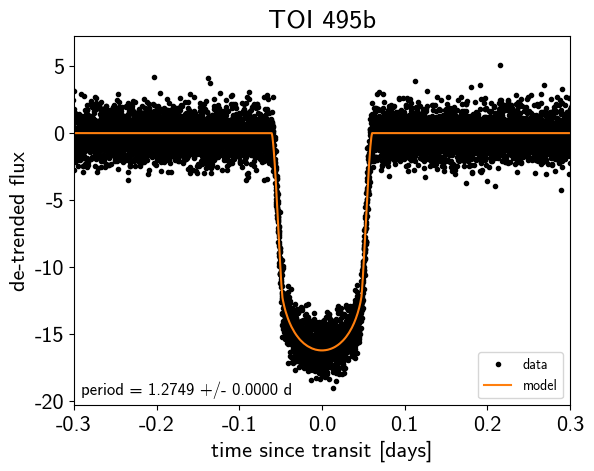

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

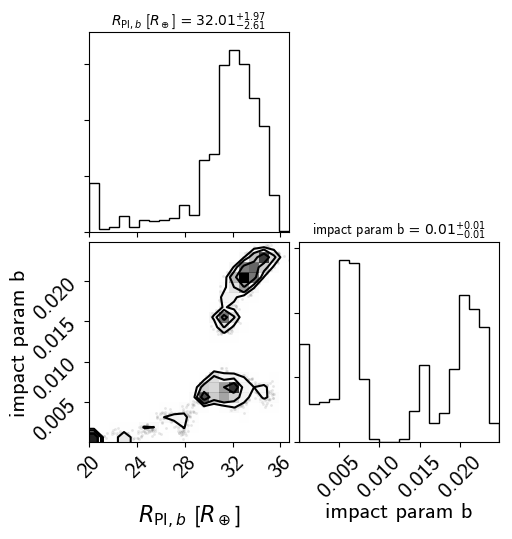

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

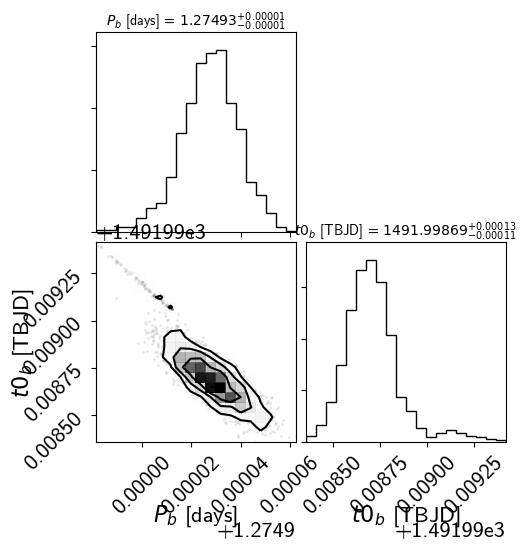

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

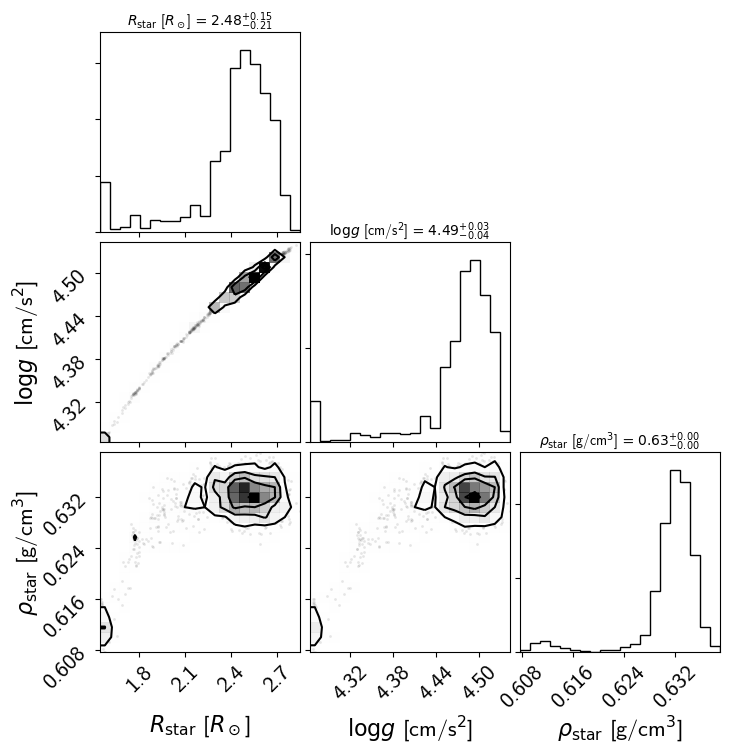

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3